### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- breakdown the item selection / writing process
- rate each story on various dimensions, 
  - rate popular news sources, eg WSJ and bloomberg > TMZ
  - log length of the summary
  - rate spamminess
- rate overall value of stories according to a rubric
- drop stories with low scores

  
spammy = has a relatively fact free headline with sensaitonal language.
only covers a stock movement or prediction without any basis in fact or sensational language
2 magnificent stocks
200 words is 0
divide chars by 1000 and take the log base 10
subtract 1 for spammy
add 1 for top source
delete less than 0 
only ai incidentally , ie ai predictions for nfl against the spread

"For each of the 100 summarized news stories, provide a rating on a scale of 1-10 for the following criteria:

Length (1 being too short or too long, 10 being optimal length)

Reputation of source (1 being unreliable, 10 being highly reputable)

Relevance/Importance (1 being trivial, 10 being highly significant)

Spamminess (1 being very spammy, 10 being not spammy at all)

- do evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-04-10 08:47:51,463 - AInewsbot - INFO - Initializing with before_date=2025-04-09 18:00, do_download=False, thread_id=ada8b53b2eea48018f57d00314d4ed67
2025-04-10 08:47:51,575 - AInewsbot - INFO - thread_id: ada8b53b2eea48018f57d00314d4ed67


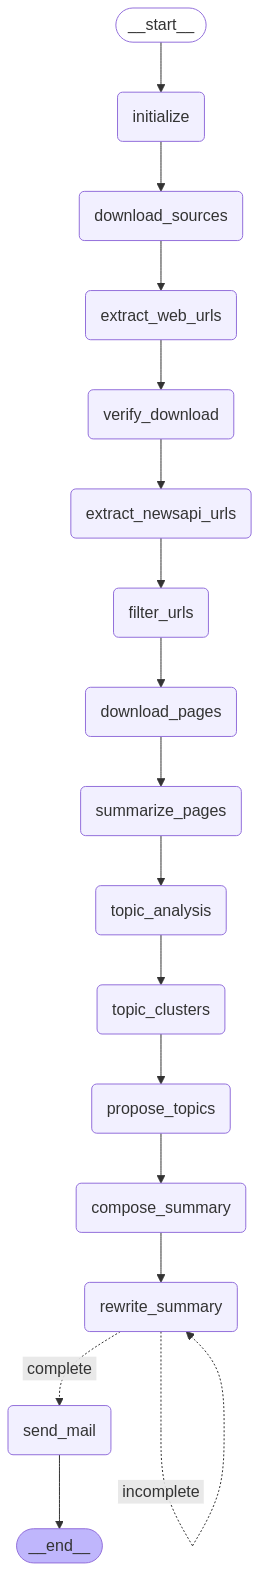

In [4]:
# before_date = None
before_date = '2025-04-09 18:00'
do_download = False

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-04-10 08:48:09,066 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-10 08:48:09,066 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-10 08:48:09,067 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-10 08:48:09,067 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-10 08:48:09,067 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-10 08:48:09,068 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-10 08:48:09,068 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-04-10 08:48:09,265 - AInewsbot - INFO - parse_file - found 245 raw links
2025-04-10 08:48:09,267 - AInewsbot - INFO - parse_file - found 38 filtered links
2025-04-10 08:48:09,268 - AInewsbot - INFO - 38 links found
2025-04-10 08:48:09,268 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider (04_10_2025 07_31_35 AM).html
2025-04-10 08:48:09,283 - AInewsbot - INFO - parse_file - found 209 raw links
2025-04-10 08:48:09,286 - AInewsbot - INFO - parse_file - found 20 filtered links
2025-04-10 08:48:09,286 - AInewsbot - INFO - 20 links found
2025-04-10 08:48:09,286 - AInewsbot - INFO - FT -> htmldata/FT (04_10_2025 07_31_36 AM).html
2025-04-10 08:48:09,308 - AInewsbot - INFO - parse_file - found 486 raw links
2025-04-10 08:48:09,312 - AInewsbot - INFO - parse_file - found 120 filtered links
2025-04-10 08:48:09,312 - AInewsbot - INFO - 120 links found
2025-04-10 08:48:09,312 - AInewsbot - INFO - Feedly AI -> htmldata/Feedly AI (04_10_2025 07_32_56 AM).html
2025-04-10 08:48:

id
src                  
Ars Technica       35
Bloomberg          31
Business Insider   20
FT                 61
Feedly AI          34
Hacker News 1      25
Hacker News 2      24
HackerNoon        110
New York Times     19
Reddit            109
Techmeme          166
The Register      108
The Verge          32
VentureBeat        45
WSJ                18
Washington Post    40

2025-04-10 08:48:09,584 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


id
src                  
Ars Technica       35
Bloomberg          31
Business Insider   20
FT                 61
Feedly AI          34
Hacker News 1      25
Hacker News 2      24
HackerNoon        110
New York Times     19
Reddit            109
Techmeme          166
The Register      108
The Verge          32
VentureBeat        45
WSJ                18
Washington Post    40

2025-04-10 08:48:09,587 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-09T08:48:09 from NewsAPI


id
src                  
Ars Technica       35
Bloomberg          31
Business Insider   20
FT                 61
Feedly AI          34
Hacker News 1      25
Hacker News 2      24
HackerNoon        110
New York Times     19
NewsAPI            98
Reddit            109
Techmeme          166
The Register      108
The Verge          32
VentureBeat        45
WSJ                18
Washington Post    40

2025-04-10 08:48:09,948 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-09 18:00'
2025-04-10 08:48:10,518 - AInewsbot - INFO - URLs in orig_df: 975
2025-04-10 08:48:10,521 - AInewsbot - INFO - Existing URLs in DB: 241916
2025-04-10 08:48:10,571 - AInewsbot - INFO - New URLs in df filtered by URL: 413
2025-04-10 08:48:10,689 - AInewsbot - INFO - Existing src+title: 17
2025-04-10 08:48:10,689 - AInewsbot - INFO - New URLs in df filtered by src+title: 396
2025-04-10 08:48:10,702 - AInewsbot - INFO - Found 393 unique new headlines
2025-04-10 08:48:10,705 - AInewsbot - INFO - Found 388 unique cleaned new headlines
2025-04-10 08:48:19,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:48:19,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:48:24,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

id
src                 
Ars Technica       4
Bloomberg         13
Business Insider   4
FT                 1
Feedly AI         27
Hacker News 1      4
Hacker News 2      4
HackerNoon         7
New York Times     1
NewsAPI           57
Reddit             1
Techmeme          24
The Register       6
The Verge          7
VentureBeat        2
WSJ                3
Washington Post    1

2025-04-10 08:48:32,513 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-10 08:48:32,540 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 08:48:32,541 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 08:48:32,541 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 08:48:32,541 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 08:48:49,411 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 08:48:49,411 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 08:48:49,412 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 08:48:49,412 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 08:48:49,412 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-10 08:48:49,413 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-10 08:48:49,413 - AInewsbot -

2025-04-10 08:49:41,989 - AInewsbot - INFO - get_url(https://www.techradar.com/pro/security/akirabot-network-hits-thousands-of-sites-with-captcha-bypassing-ai-spam) - starting get_url https://www.techradar.com/pro/security/akirabot-network-hits-thousands-of-sites-with-captcha-bypassing-ai-spam
2025-04-10 08:49:41,991 - AInewsbot - INFO - Processing page 16: https://www.bloomberg.com/news/articles/2025-04-10/alphabet-can-t-shake-off-ai-concerns-even-with-low-multiple
2025-04-10 08:49:41,994 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-10/alphabet-can-t-shake-off-ai-concerns-even-with-low-multiple) - starting get_url https://www.bloomberg.com/news/articles/2025-04-10/alphabet-can-t-shake-off-ai-concerns-even-with-low-multiple
2025-04-10 08:49:41,995 - AInewsbot - INFO - Processing page 17: https://www.bloomberg.com/news/articles/2025-04-08/altman-backed-praxis-scouts-kyiv-athens-for-tech-utopia-base
2025-04-10 08:49:41,995 - AInewsbot - INFO - get_url(http

2025-04-10 08:49:44,367 - AInewsbot - INFO - get_url(https://biztoc.com/x/171f9edb93e43522) - starting get_url https://biztoc.com/x/171f9edb93e43522
2025-04-10 08:49:44,369 - AInewsbot - INFO - Processing page 31: https://www.newyorker.com/books/under-review/can-ai-writing-be-more-than-a-gimmick
2025-04-10 08:49:44,369 - AInewsbot - INFO - get_url(https://www.newyorker.com/books/under-review/can-ai-writing-be-more-than-a-gimmick) - starting get_url https://www.newyorker.com/books/under-review/can-ai-writing-be-more-than-a-gimmick
2025-04-10 08:49:44,370 - AInewsbot - INFO - Processing page 32: https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/
2025-04-10 08:49:44,371 - AInewsbot - INFO - get_url(https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/) - starting get_url https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-stude

2025-04-10 08:49:48,281 - AInewsbot - INFO - Processing page 46: https://www.theregister.com/2025/04/09/clearview_founder_exceo_ousted/
2025-04-10 08:49:48,282 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/04/09/clearview_founder_exceo_ousted/) - starting get_url https://www.theregister.com/2025/04/09/clearview_founder_exceo_ousted/
2025-04-10 08:49:48,283 - AInewsbot - INFO - Processing page 47: https://github.com/samuelm2/svraster-webgl
2025-04-10 08:49:48,283 - AInewsbot - INFO - get_url(https://github.com/samuelm2/svraster-webgl) - starting get_url https://github.com/samuelm2/svraster-webgl
2025-04-10 08:49:48,905 - AInewsbot - INFO - get_url(Fintech Entrepreneur Launches AI-Fueled Financial Assistant Hiro) - Saving Fintech_Entrepreneur_Launches_AI-Fueled_Financial_Assistant_Hiro.html as utf-8
2025-04-10 08:49:48,907 - AInewsbot - INFO - Processing page 48: https://www.gadgets360.com/ai/news/gemini-2-5-pro-experimental-deep-research-ai-agent-feature-ai-model-integra

2025-04-10 08:49:55,243 - AInewsbot - INFO - get_url(http://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/) - starting get_url http://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/
2025-04-10 08:49:55,245 - AInewsbot - INFO - Processing page 60: https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/
2025-04-10 08:49:55,247 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/) - starting get_url https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/
2025-04-10 08:49:55,248 - AInewsbot - INFO - Processing page 61: https://siliconangle.com/2025/04/09/google-launches-unified-security-pl

2025-04-10 08:50:01,237 - AInewsbot - INFO - get_url(https://siliconangle.com/2025/04/09/googles-cloud-based-ai-hypercomputer-gets-new-workhorse-ironwood-tpu/) - starting get_url https://siliconangle.com/2025/04/09/googles-cloud-based-ai-hypercomputer-gets-new-workhorse-ironwood-tpu/
2025-04-10 08:50:01,463 - AInewsbot - INFO - get_url(Google unveils Ironwood, its seventh-generation TPU and the first optimized for inference, coming later in 2025 in a 256-chip cluster or a 9,216-chip cluster) - Saving Google_unveils_Ironwood__its_seventh-generation_TPU_and_the_first_optimized_for_inference__coming_later_in_2025_in_a_256-chip_cluster_or_a_9_216-chip_cluster.html as UTF-8
2025-04-10 08:50:01,465 - AInewsbot - INFO - Processing page 73: https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/
2025-04-10 08:50:01,465 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/googles-new-agent-development-kit-lets-ent

2025-04-10 08:50:04,575 - AInewsbot - INFO - get_url(How University Students Use Claude) - Saving How_University_Students_Use_Claude.html as utf-8
2025-04-10 08:50:04,575 - AInewsbot - INFO - Processing page 89: https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/
2025-04-10 08:50:04,576 - AInewsbot - INFO - get_url(https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/) - starting get_url https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/
2025-04-10 08:50:04,577 - AInewsbot - INFO - Processing page 90: https://www.bloomberg.com/news/articles/2025-04-10/amazon-s-jassy-urges-startup-mentality-in-shareholder-letter
2025-04-10 08:50:04,578 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-10/amazon-s-jassy-urges-startup-mentality-in-shareholder-letter) - startin

2025-04-10 08:50:06,806 - AInewsbot - INFO - Processing page 106: https://blogs.nvidia.com/blog/nvidia-partner-network-awards-emea-2025/
2025-04-10 08:50:06,807 - AInewsbot - INFO - get_url(https://blogs.nvidia.com/blog/nvidia-partner-network-awards-emea-2025/) - starting get_url https://blogs.nvidia.com/blog/nvidia-partner-network-awards-emea-2025/
2025-04-10 08:50:06,808 - AInewsbot - INFO - Processing page 107: https://siliconangle.com/2025/04/09/new-workspace-ai-tools-google-focus-workflow-automation-content-creation/
2025-04-10 08:50:06,808 - AInewsbot - INFO - get_url(https://siliconangle.com/2025/04/09/new-workspace-ai-tools-google-focus-workflow-automation-content-creation/) - starting get_url https://siliconangle.com/2025/04/09/new-workspace-ai-tools-google-focus-workflow-automation-content-creation/
2025-04-10 08:50:07,804 - AInewsbot - INFO - get_url(New Workspace AI tools from Google focus on workflow automation and content creation) - Saving New_Workspace_AI_tools_from_Goo

2025-04-10 08:50:10,602 - AInewsbot - INFO - get_url(https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_01340959-e279-460d-9daf-bfa68a9538d1) - starting get_url https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_01340959-e279-460d-9daf-bfa68a9538d1
2025-04-10 08:50:10,602 - AInewsbot - INFO - Processing page 124: https://www.globenewswire.com/news-release/2025/04/09/3058195/28124/en/Quantum-Computing-Research-Report-2025-Market-to-Reach-7-48-Billion-by-2030-Hybrid-Quantum-Classical-Computing-Solutions-are-Meeting-Success-with-Early-Adopters-in-Key-Areas-Such-a.html
2025-04-10 08:50:10,602 - AInewsbot - INFO - get_url(https://www.globenewswire.com/news-release/2025/04/09/3058195/28124/en/Quantum-Computing-Research-Report-2025-Market-to-Reach-7-48-Billion-by-2030-Hybrid-Quantum-Classical-Computing-Solutions-are-Meeting-Success-with-Early-Adopters-in-Key-Areas-Such-a.html) - starting get_url https://www.globenewswire.com/news-release/2025/04/09/3058195/2812

2025-04-10 08:50:12,702 - AInewsbot - INFO - Processing page 138: https://financialpost.com/pmn/business-wire-news-releases-pmn/sutherland-and-google-cloud-partner-to-deliver-real-world-ai-solutions-to-businesses-globally
2025-04-10 08:50:12,703 - AInewsbot - INFO - get_url(https://financialpost.com/pmn/business-wire-news-releases-pmn/sutherland-and-google-cloud-partner-to-deliver-real-world-ai-solutions-to-businesses-globally) - starting get_url https://financialpost.com/pmn/business-wire-news-releases-pmn/sutherland-and-google-cloud-partner-to-deliver-real-world-ai-solutions-to-businesses-globally
2025-04-10 08:50:12,732 - AInewsbot - INFO - get_url(PLAUD NotePin review  AI wearable note taker) - Saving PLAUD_NotePin_review__AI_wearable_note_taker.html as UTF-8
2025-04-10 08:50:12,734 - AInewsbot - INFO - Processing page 139: https://www.globenewswire.com/news-release/2025/04/09/3058185/28124/en/Synthetic-Biology-Platforms-Market-to-Reach-14-10-Billion-by-2030-Growing-at-22-81-CAGR-f

2025-04-10 08:50:15,780 - AInewsbot - INFO - get_url(Sutherland and Google Cloud Partner to Deliver Real-World AI Solutions to Businesses Globally) - Saving Sutherland_and_Google_Cloud_Partner_to_Deliver_Real-World_AI_Solutions_to_Businesses_Globally.html as utf-8
2025-04-10 08:50:15,783 - AInewsbot - INFO - Processing page 153: https://www.forbes.com/sites/rashishrivastava/2025/04/10/why-300-companies-use-this-startups-ai-to-slash-costs/
2025-04-10 08:50:15,784 - AInewsbot - INFO - get_url(https://www.forbes.com/sites/rashishrivastava/2025/04/10/why-300-companies-use-this-startups-ai-to-slash-costs/) - starting get_url https://www.forbes.com/sites/rashishrivastava/2025/04/10/why-300-companies-use-this-startups-ai-to-slash-costs/
2025-04-10 08:50:15,786 - AInewsbot - INFO - Processing page 154: https://sloanreview.mit.edu/article/why-ai-demands-a-new-breed-of-leaders/
2025-04-10 08:50:15,787 - AInewsbot - INFO - get_url(https://sloanreview.mit.edu/article/why-ai-demands-a-new-breed-of-

2025-04-10 08:50:31,762 - AInewsbot - INFO - Quit webdriver
2025-04-10 08:50:32,867 - AInewsbot - INFO - 80 pages saved
2025-04-10 08:50:32,867 - AInewsbot - INFO - 26 pages saved
2025-04-10 08:50:35,372 - AInewsbot - INFO - 34 pages saved
2025-04-10 08:52:23,906 - AInewsbot - INFO - Error fetching https://www.macworld.com/article/2662162/youre-still-paying-for-chatgpt-why.html: HTTPConnectionPool(host='localhost', port=60052): Read timed out. (read timeout=120)
2025-04-10 08:52:23,908 - AInewsbot - INFO - Error processing https://www.macworld.com/article/2662162/youre-still-paying-for-chatgpt-why.html, continuing...
2025-04-10 08:52:23,909 - AInewsbot - INFO - Quit webdriver
2025-04-10 08:53:29,755 - AInewsbot - INFO - 25 pages saved


id
src                 
Ars Technica       4
Bloomberg         13
Business Insider   4
FT                 1
Feedly AI         26
Hacker News 1      4
Hacker News 2      4
HackerNoon         7
New York Times     1
NewsAPI           57
Reddit             1
Techmeme          24
The Register       6
The Verge          7
VentureBeat        2
WSJ                3
Washington Post    1

2025-04-10 08:53:29,795 - AInewsbot - INFO - Starting summarize
2025-04-10 08:53:29,796 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-10 08:53:29,831 - AInewsbot - INFO - clean_html - Page title: $144 Billion Tether’s Next Act: A U.S. Stablecoin And A Peer-To-Peer ChatGPT
Social card title: $144 Billion Tether’s Next Act: A U.S. Stablecoin And A Peer-To-Peer ChatGPT
Social card description: The world’s largest stablecoin issuer is plotting its U.S. expansion and building a decentralized rival to OpenAI’s model.

2025-04-10 08:53:30,055 - AInewsbot - INFO - Queuing 0: Page title: $144 Billion Tether’s Next Act: A U.S....
2025-04-10 08:53:30,085 - AInewsbot - INFO - clean_html - Page title: Tariff Armageddon? | GPU Loopholes, Mexico Supply Chain Shift, Wafer Fab Equipment Vulnerabilities, Optical Module Pricing Surge, Datacenter Equipment – SemiAnalysis
Social card title: Tariff Armageddon? | GPU Loopholes, Mexico Supply Chain Shift, Wafer Fab Equipment Vulnerabilities

2025-04-10 08:53:30,685 - trafilatura.core - WARNING - discarding data: None
2025-04-10 08:53:30,694 - AInewsbot - INFO - Queuing 18: Page title: wsj.com
...
2025-04-10 08:53:30,708 - AInewsbot - INFO - clean_html - Page title: How Amazon Nova ACT Simplifies Complex Workflows with AI Agents - Geeky Gadgets
Social card title: Amazon Nova ACT AI Agents Designed for Automation Efficiency and Precision
Social card description: Amazon Nova ACT AI Agents simplify workflows, automates tasks, and boosts efficiency with advanced AI and autonomous web navigation.

2025-04-10 08:53:30,717 - AInewsbot - INFO - Queuing 19: Page title: How Amazon Nova ACT Simplifies Complex...
2025-04-10 08:53:30,743 - AInewsbot - INFO - clean_html - Page title: Amazon launches Nova Sonic AI model for voice generation
Social card title: Amazon launches Nova Sonic AI model for voice generation
Social card description: Amazon has just launched its new Nova AI models that can generated voices to compete with the likes 

2025-04-10 08:53:31,085 - AInewsbot - INFO - Queuing 31: Page title: Can A.I. Writing Be More Than a Gimmic...
2025-04-10 08:53:31,517 - AInewsbot - INFO - clean_html - Page title: ChatGPT Plus Is Free for College Students Right Now. Here's What You Get - CNET
Social card title: ChatGPT Plus Is Free for College Students Right Now. Here's What You Get
Social card description: OpenAI is giving away its premium ChatGPT Plus service for free to college students at degree-granting schools in the US and Canada until May 31.

2025-04-10 08:53:31,541 - AInewsbot - INFO - Queuing 32: Page title: ChatGPT Plus Is Free for College Stude...
2025-04-10 08:53:31,559 - AInewsbot - INFO - clean_html - Page title: Chinese Social Media Users Have Turned the Trade War Into a Meme War - Business Insider
Social card title: Chinese social media users have turned the trade war into a meme war, complete with AI-generated art
Social card description: AI generated memes of weapon-wielding penguins and Americans 

2025-04-10 08:53:32,032 - AInewsbot - INFO - clean_html - Page title: Gemini 2.5 Pro Experimental Will Now Power the Agentic Deep Research Feature | Technology News
Social card title: Deep Research AI Agent Will Now Be Powered by Gemini 2.5 Pro Experimental
Social card description: Before this, the Deep Research tool was powered by the Gemini 2.0 Flash Thinking (experimental) AI model.

2025-04-10 08:53:32,062 - AInewsbot - INFO - Queuing 48: Page title: Gemini 2.5 Pro Experimental Will Now P...
2025-04-10 08:53:32,080 - AInewsbot - INFO - clean_html - Page title: Gemini can now turn your Google Docs into podcasts | The Verge
Social card title: Gemini can now turn your Google Docs into podcasts
Social card description: Gemini can be your editor and your data analyst, apparently.

2025-04-10 08:53:32,104 - AInewsbot - INFO - Queuing 49: Page title: Gemini can now turn your Google Docs i...
2025-04-10 08:53:32,123 - AInewsbot - INFO - clean_html - Page title: Google A2A - a First Look at

2025-04-10 08:53:32,523 - AInewsbot - INFO - Queuing 63: Page title: Google launches new Ironwood chip to s...
2025-04-10 08:53:32,534 - AInewsbot - INFO - clean_html - Page title: Google's 7th-gen Ironwood TPUs promise 42 AI exaFLOPS pods • The Register
Social card title: Google's 7th-gen Ironwood TPUs promise 42 AI exaFLOPS pods
Social card description: Cloud Next: Sure, we're doing FP8 versus a supercomputer's FP64. What of it?

2025-04-10 08:53:32,549 - AInewsbot - INFO - Queuing 64: Page title: Google's 7th-gen Ironwood TPUs promise...
2025-04-10 08:53:32,565 - AInewsbot - INFO - clean_html - Page title: Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE
Social card title: Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE
Social card description: Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE

2025-04-10 08:53:32,586 - AInewsbot - INFO - Queuing 65: Page title: Google rolls out updates for bui

2025-04-10 08:53:33,345 - AInewsbot - INFO - Queuing 81: Page title: How AI could influence the evolution o...
2025-04-10 08:53:33,352 - AInewsbot - INFO - clean_html - Page title: How Camb.ai is breaking language barriers with AI - Fast Company
Social card title: How Camb.ai is breaking language barriers with AI
Social card description: CEO Avneesh Prakash is betting that AI-powered dubbing can unlock global storytelling, one rare language at a time.

2025-04-10 08:53:33,361 - AInewsbot - INFO - Queuing 82: Page title: How Camb.ai is breaking language barri...
2025-04-10 08:53:33,376 - AInewsbot - INFO - clean_html - Page title: How LongFact Helps Measure the Accuracy of AI Responses | HackerNoon
Social card title: How LongFact Helps Measure the Accuracy of AI Responses | HackerNoon
Social card description: Explore the LongFact data generation process, including topic selection, prompt creation, and examples from LongFact-Concepts and LongFact-Objects. 

2025-04-10 08:53:33,409 - AIne

2025-04-10 08:53:33,919 - AInewsbot - INFO - clean_html - Page title: Large number of US adults view AI as a threat: Report
Social card title: Large number of US adults view AI as a threat: Report
Social card description: A recent survey by the Pew Research Center highlights that a large number of U.S. adults view AI as a threat.

2025-04-10 08:53:33,934 - AInewsbot - INFO - Queuing 99: Page title: Large number of US adults view AI as a...
2025-04-10 08:53:33,958 - AInewsbot - INFO - clean_html - Page title: Meet The Tiny Startup Building Stargate, OpenAI’s $500 Billion Data Center Moonshot
Social card title: Meet The Tiny Startup Building Stargate, OpenAI’s $500 Billion Data Center Moonshot
Social card description: Crusoe Energy got its start harnessing oilfield flare gas to mine bitcoin. So how did cofounders Chase Lochmiller and Cully Cavness end up building the first phase of the world’s biggest AI datacenter – $500 billion Project Stargate – for OpenAI and Oracle? 

2025-04-10 08:

2025-04-10 08:53:34,879 - AInewsbot - INFO - Queuing 118: Page title: OpenAI countersues Musk as Altman feud...
2025-04-10 08:53:34,891 - AInewsbot - INFO - clean_html - Page title: OpenAI launches program to design new 'domain-specific' AI benchmarks | TechCrunch
Social card title: OpenAI launches program to design new 'domain-specific' AI benchmarks | TechCrunch
Social card description: OpenAI, like many AI labs, thinks benchmarks are broken. It says it wants to fix them through a new program.

2025-04-10 08:53:34,904 - AInewsbot - INFO - Queuing 119: Page title: OpenAI launches program to design new ...
2025-04-10 08:53:34,920 - AInewsbot - INFO - clean_html - Page title: PLAUD NotePin review - AI wearable note taker - The Gadgeteer
Social card title: PLAUD NotePin review - AI wearable note taker - The Gadgeteer
Social card description: REVIEW - These days, it feels like every product is trying to squeeze in some form of artificial intelligence, whether it’s truly useful or just a f

2025-04-10 08:53:35,512 - AInewsbot - INFO - Queuing 135: Page title: How I vibe coded a math game in ten mi...
2025-04-10 08:53:35,523 - AInewsbot - INFO - clean_html - Page title: Some think the em dash is a ‘ChatGPT hyphen.’ Writers disagree. - The Washington Post
Social card title: Some people think AI writing has a tell — the em dash. Writers disagree.
Social card description: Em dashes have been derided as the “ChatGPT hyphen” — a punctuation mark overused by artificial intelligence. That’s not quite true.

2025-04-10 08:53:35,544 - AInewsbot - INFO - Queuing 136: Page title: Some think the em dash is a ‘ChatGPT h...
2025-04-10 08:53:35,553 - AInewsbot - INFO - clean_html - Page title: Trump administration backs off Nvidia’s ‘H20’ chip crackdown : NPR
Social card title: Trump administration backs off Nvidia's 'H20' chip crackdown after Mar-a-Lago dinner
Social card description: The White House was expected to ban sales of the high-performance AI chip to China. Chinese companies h

2025-04-10 08:53:36,350 - AInewsbot - INFO - Queuing 153: Page title: The AI Startup Helping Uber, Salesforc...
2025-04-10 08:53:36,360 - AInewsbot - INFO - clean_html - Page title: Why AI Demands a New Breed of Leaders
Social card title: Why AI Demands a New Breed of Leaders
Social card description: Today’s organizations need tech leaders who can also take on the cultural and change management challenges of AI.

2025-04-10 08:53:36,371 - AInewsbot - INFO - Queuing 154: Page title: Why AI Demands a New Breed of Leaders
...
2025-04-10 08:53:36,383 - AInewsbot - INFO - clean_html - Page title: Windows 11’s Copilot Vision wants to help you learn to use complicated apps - Ars Technica
Social card title: Windows 11’s Copilot Vision wants to help you learn to use complicated apps
Social card description: Copilot beta update is rolling out to Windows Insider program testers now.

2025-04-10 08:53:36,393 - AInewsbot - INFO - Queuing 155: Page title: Windows 11’s Copilot Vision wants to h...
20

2025-04-10 08:53:39,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,532 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:39,565 - httpx 

2025-04-10 08:53:40,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:40,327 - httpx 

2025-04-10 08:53:43,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:44,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:46,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:47,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:47,925 - AInewsbot - INFO - Received 165 summaries
2025-04-10 08:53:47,926 - AInewsbot - INFO - Summary for 0: - Tether is planning a U.S. expansion with a new stablecoin tailored for the domestic market while maintaining its global-focused USDT stablecoin; the company is also pursuing a full financial audit and engaging with Congress on stablecoin regulation.  
- The company is diversifying into artificial intelligence by developing a decentralized AI platform that allows individuals to retain

2025-04-10 08:53:47,934 - AInewsbot - INFO - Summary for 13: • Anthropic has introduced a new subscription tier, Claude Max, priced at $100 to $200 per month, aimed at addressing user complaints about frequent rate limits with its Claude AI assistant.  

• The $100 plan offers five times more usage than the $20 Pro plan, while the $200 option provides 20 times more usage, targeting users heavily reliant on Claude for daily tasks.  

• Users have expressed dissatisfaction with usage limits, especially for tasks involving large context windows, as these consume limits quickly but allow for more complex project handling.  
2025-04-10 08:53:47,935 - AInewsbot - INFO - Summary for 14: - Google has launched the Agent2Agent (A2A) protocol, enabling AI agents to securely communicate and collaborate across different frameworks and developers to enhance capabilities.  
- The protocol is supported by over 50 technology partners, including Atlassian, Salesforce, and SAP, along with major service p

2025-04-10 08:53:47,939 - AInewsbot - INFO - Summary for 27: • The Bank of England plans to closely monitor the use of artificial intelligence by banks and hedge funds due to concerns that it could trigger market crashes or manipulation without human awareness.  
• The Financial Policy Committee warned in a new report that AI could destabilize markets or behave adversely, with its rapid adoption posing challenges to human comprehension of its operations.  
2025-04-10 08:53:47,939 - AInewsbot - INFO - Summary for 28: • Matt Muller, Field CISO at Tines, discusses strategies to mitigate AI's security and privacy risks and ease stress on security teams, addressing challenges faced by Chief Information Security Officers (CISOs).  

• Summer Fowler, CISO at Torc Robotics, covers securing AI initiatives, including regulatory requirements, build vs. buy decisions, and key questions for developers or vendors.  

• The podcast explores balancing AI opportunities with risks to drive better busine

2025-04-10 08:53:47,941 - AInewsbot - INFO - Summary for 39: - The EU plans to triple its AI datacentre capacity within the next seven years to reduce reliance on non-EU infrastructure and boost its position as an AI superpower, facilitated by the proposed Cloud and AI Development Act.  
- The strategy includes establishing AI "gigafactories," fostering public-private partnerships, and allocating €20 billion to develop AI infrastructure, while addressing barriers such as permitting delays for datacentre projects.  
- The EU aims to strengthen its cloud market, grow its AI talent base, and enhance access to high-quality data to support AI innovation and adoption across strategic sectors like healthcare and robotics.  
2025-04-10 08:53:47,941 - AInewsbot - INFO - Summary for 40: - Edge AI agents, which operate autonomously on endpoint devices without constant cloud connectivity, are transforming industries by eliminating bottlenecks such as latency, bandwidth issues, privacy concerns, an

2025-04-10 08:53:47,944 - AInewsbot - INFO - Summary for 53: - Google announced plans to support Anthropic’s Model Context Protocol (MCP) in its Gemini models and SDK, with Google DeepMind CEO Demis Hassabis hailing MCP as an emerging open standard for AI.  
- MCP enables AI models to connect to data sources like business tools, content repositories, and app development environments, facilitating two-way communication between data and AI-powered applications.  
- Several companies, including Block, Apollo, Replit, Codeium, and Sourcegraph, have already adopted the MCP standard since its open-sourcing by Anthropic.  
2025-04-10 08:53:47,944 - AInewsbot - INFO - Summary for 54: • Google’s Gemini Code Assist has introduced new "agentic" capabilities, allowing AI agents to perform complex programming tasks such as creating applications from specifications, migrating code between languages, and implementing new features.

• The upgraded features include generating work plans, executing code

2025-04-10 08:53:47,946 - AInewsbot - INFO - Summary for 65: - Google has unveiled updates for its Vertex AI platform, introducing tools like an open-source Agent Developer Kit, Agent Garden with example agents, and Agent Engine for deploying multi-agent systems, enabling developers to build and deploy complex AI-driven ecosystems.  
- The Agent Developer Kit allows for simplified creation of multi-agent systems in Python, access to 200 models including Google's Gemini, and integration with frameworks like LangGraph; the accompanying Agent2Agent protocol enables seamless communication between agents across different frameworks.  
- Google expanded its Agentspace features, introducing tools like Agent Gallery to access prebuilt agents and the no-code Agent Designer, allowing enterprise employees to create AI agents for specific tasks directly within their workplace tools.  
2025-04-10 08:53:47,946 - AInewsbot - INFO - Summary for 66: - no content
2025-04-10 08:53:47,946 - AInewsbot - IN

2025-04-10 08:53:47,948 - AInewsbot - INFO - Summary for 79: - Artists and researchers are using AI to inspire creativity by incorporating elements of friction, challenge, and serendipity, such as through live coding performances and generative models that suggest unexpected ideas.  
- Concerns have been raised about generative AI tools' limitations, which prioritize automation over fostering deep creativity, potentially inhibiting reflection, skill development, and innovation.  
- Efforts to develop AI tools focus on balancing surprise and control, providing empowering co-creative experiences that push artists to new creative heights while avoiding over-reliance on current technology’s ease of use.  
2025-04-10 08:53:47,949 - AInewsbot - INFO - Summary for 80: • Artificial intelligence has the potential to both diminish the media business, which employed fewer than 50,000 US journalists in 2023, and enhance journalism through tools like advanced data processing.  

• A survey of 1,128

2025-04-10 08:53:47,951 - AInewsbot - INFO - Summary for 93: - The U.S. Air Force is advancing its autonomous flying fighter jet program, called VENOM-AFT, involving the conversion of six F-16 Fighting Falcons to test autonomous capabilities with human pilots monitoring the systems.  
- Air Force officials emphasize maintaining a "human-on-the-loop" approach where pilots retain control over autonomous operations and can intervene as needed.  
- The VENOM program aims to redefine air combat by integrating advanced AI capabilities into both crewed and uncrewed aircraft, with the potential to significantly enhance military combat effectiveness.  
2025-04-10 08:53:47,951 - AInewsbot - INFO - Summary for 94: - Google introduced Ironwood, its seventh-generation Tensor Processing Unit (TPU), designed specifically for the "age of inference," offering major advancements in performance, scalability, and energy efficiency to support AI workloads like Large Language Models (LLMs) and Mixture of Ex

2025-04-10 08:53:47,952 - AInewsbot - INFO - Summary for 107: - Google introduced advanced AI enhancements in Google Workspace, including Workspace Flows, a tool that automates complex business processes using plain language and AI agents called "Gems," along with new features in Docs, Sheets, and Google Meet for improved content creation, data analysis, and workflow management.  
- Enhancements include AI-driven audio summaries and writing suggestions in Docs, data analysis tools in Sheets, video creation upgrades in Google Vids, and real-time meeting summaries and task tracking in Google Meet and Chat.  
- Google reported strong adoption of its AI tools, providing over 2 billion AI assists monthly to businesses such as Etsy, Salesforce, and Whirlpool.   
2025-04-10 08:53:47,953 - AInewsbot - INFO - Summary for 108: - no content
2025-04-10 08:53:47,953 - AInewsbot - INFO - Summary for 109: - Parley, a legal tech startup using AI, streamlines visa application processes for immigration 

2025-04-10 08:53:47,955 - AInewsbot - INFO - Summary for 123: - no content
2025-04-10 08:53:47,955 - AInewsbot - INFO - Summary for 124: - The global quantum computing market, valued at $1.85 billion in 2024, is projected to grow at a CAGR of 28.7%, reaching $7.48 billion by 2030, with hardware as the largest segment and the superconducting loop method dominating technology.  
- North America leads with 33.6% of the market, while the Asia-Pacific region is expected to experience the highest growth (CAGR of 27.9%) from 2024 to 2030.  
- Quantum computing advancements are driving applications in industries like cryptography, healthcare, aerospace, and financial services, with a focus on hybrid quantum/classical solutions to address challenges like algorithm development and scalability.  
2025-04-10 08:53:47,955 - AInewsbot - INFO - Summary for 125: • Reddit Answers, an AI-powered platform integrating community-driven knowledge, has received a major upgrade with Google Gemini and Vertex A

2025-04-10 08:53:47,965 - AInewsbot - INFO - Summary for 139: - The Synthetic Biology Platforms Market is projected to grow from USD 5.04 billion in 2025 to USD 14.10 billion by 2030, with a compound annual growth rate (CAGR) of 22.81%, driven by advances in AI integration, modular engineering, and green chemistry.  
- Major players driving innovation include Ginkgo Bioworks, Twist Bioscience, and LanzaTech, leveraging real-time genetic sequencing, cost-effective synthesis, and computational modeling for enhanced efficiency and scalability.  
- Sustainable practices and digital tools are reshaping the industry, fostering global collaboration, addressing environmental impacts, and enabling the development of eco-friendly solutions and new applications in healthcare and agriculture.  
2025-04-10 08:53:47,965 - AInewsbot - INFO - Summary for 140: - no content
2025-04-10 08:53:47,965 - AInewsbot - INFO - Summary for 141: - Tessell, a multi-cloud database-as-a-service startup, raised $60 mi

2025-04-10 08:53:47,967 - AInewsbot - INFO - Summary for 153: - Writer, an AI startup co-founded by May Habib, creates AI tools designed to automate tasks such as content creation, marketing, and customer service for over 300 companies, including Uber, Salesforce, and L'Oréal, helping them save millions in labor costs.  
- The company has raised $320 million in funding, is valued at $1.9 billion, and projects $100 million in signed contracts for 2024 with clients expanding their contracts by an average of 60%.  
- Writer differentiates itself with customizable, user-friendly AI tools that require no coding, focus on security by not using client data to train models, and is developing "self-evolving" AI systems to improve efficiencies further.  
2025-04-10 08:53:47,968 - AInewsbot - INFO - Summary for 154: • Organizations are overly focused on the technical implementation of AI, often neglecting critical cultural and organizational change challenges, with 91% of large-company data leade

2025-04-10 08:53:47,969 - AInewsbot - INFO - Received 165 summaries


id
src                 
Ars Technica       4
Bloomberg         13
Business Insider   4
FT                 1
Feedly AI         26
Hacker News 1      4
Hacker News 2      4
HackerNoon         7
New York Times     1
NewsAPI           57
Reddit             1
Techmeme          24
The Register       6
The Verge          7
VentureBeat        2
WSJ                3
Washington Post    1

2025-04-10 08:53:47,976 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 08:53:51,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:57,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:57,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:57,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:57,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:57,451 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:53:58,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:

2025-04-10 08:53:58,579 - AInewsbot - INFO - Canonical topic threat detection
2025-04-10 08:53:58,579 - AInewsbot - INFO - Canonical topic hollywood
2025-04-10 08:53:58,579 - AInewsbot - INFO - Canonical topic china
2025-04-10 08:53:58,579 - AInewsbot - INFO - Canonical topic hardware
2025-04-10 08:53:58,579 - AInewsbot - INFO - Canonical topic agentic ai
2025-04-10 08:53:58,580 - AInewsbot - INFO - Canonical topic intellectual property
2025-04-10 08:53:58,580 - AInewsbot - INFO - Canonical topic streaming
2025-04-10 08:53:58,580 - AInewsbot - INFO - Canonical topic opinion
2025-04-10 08:53:58,580 - AInewsbot - INFO - Canonical topic cryptocurrency
2025-04-10 08:53:58,580 - AInewsbot - INFO - Canonical topic customer experience
2025-04-10 08:53:58,581 - AInewsbot - INFO - Canonical topic finance
2025-04-10 08:53:58,581 - AInewsbot - INFO - Canonical topic data governance
2025-04-10 08:53:58,581 - AInewsbot - INFO - Canonical topic ai innovation
2025-04-10 08:53:58,581 - AInewsbot - INF

2025-04-10 08:54:05,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:05,407 - httpx 

2025-04-10 08:54:06,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,034 - httpx 

2025-04-10 08:54:06,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,623 - httpx 

2025-04-10 08:54:06,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:06,989 - httpx 

2025-04-10 08:54:07,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,331 - httpx 

2025-04-10 08:54:07,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,631 - httpx 

2025-04-10 08:54:07,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:07,893 - httpx 

2025-04-10 08:54:08,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,137 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,154 - httpx 

2025-04-10 08:54:08,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,443 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,482 - httpx 

2025-04-10 08:54:08,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,975 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:08,995 - httpx 

2025-04-10 08:54:09,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,628 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:09,643 - httpx 

2025-04-10 08:54:10,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,067 - httpx 

2025-04-10 08:54:10,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,503 - httpx 

2025-04-10 08:54:10,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:10,918 - httpx 

2025-04-10 08:54:11,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,287 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,308 - httpx 

2025-04-10 08:54:11,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:11,980 - httpx 

2025-04-10 08:54:12,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:12,670 - httpx 

2025-04-10 08:54:13,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,665 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:13,720 - httpx 

2025-04-10 08:54:14,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,774 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:14,934 - httpx 

2025-04-10 08:54:19,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:19,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:19,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:19,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:20,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:21,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:21,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:22,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:23,007 - AInews

id
src                 
Ars Technica       4
Bloomberg         13
Business Insider   4
FT                 1
Feedly AI         26
Hacker News 1      4
Hacker News 2      4
HackerNoon         7
New York Times     1
NewsAPI           57
Reddit             1
Techmeme          24
The Register       6
The Verge          7
VentureBeat        2
WSJ                3
Washington Post    1

2025-04-10 08:54:23,036 - AInewsbot - INFO - Fetching embeddings for 165 headlines
2025-04-10 08:54:25,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-10 08:54:26,211 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-10 08:54:26,253 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-10 08:54:27,359 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-10 08:54:28,605 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-10 08:54:28,684 - AInewsbot - INFO - Found 13 clusters


title_topic_str
0                  Googles new Agent Development Kit lets enterprises rapidly prototype and deploy AI agents without recoding (Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Amazon Nova Act, Anthropic, Artificial General Intelligence, Automation, Business Transformation, Chatbots, Chatgpt, Cloud Computing, Code Assistants, Competing With AI Platforms, Content Creation, Enterprise AI Capabilities, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Industry Transformation, Integration With Existing Frameworks, Job Automation, Language Models, No-Code Tools, Open Source, OpenAI, Rapid AI Agent Deployment, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Science, Singularity, Software Development, Technology Partnerships, Testing, User Engagement, Virtual Assistants, Wayve, Workflow Automation)
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Wanted: First movers for Southeast Asias agentic AI leap (Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Chatbots, Customer Experience, Customer Service, Digital Services, Economics, Finance, Fintech, Gen AI, Industry Transformation, Job Automation, Market Growth, Southeast Asia, Speech Recognition & Synthesis, Virtual Assistants, Workflow Automation)
2                                                                                                                                                   Google announces Agent2Agent, an open interoperability protocol to enable seamless collaboration between AI agents across diverse frameworks and vendors (Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Collaboration, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Chatbots, Community-Driven Development, Deals, Enterprise Automation, Gen AI, Google, Google Agent2Agent, Google Distributed Cloud, Industry Transformation, Job Automation, Language Models, Open Source, Open-Source Agent Communication, Policy And Regulation, Recommendation Systems, Retrieval Augmented Generation, Robots, Science, Singularity, Software Development, Supply Chain Optimization, Technology Partnerships, User Engagement, Workflow Automation)
3                                                                                                                                                                      Agent2Agent: Google announces open protocol so AI agents can talk to each other (Topics: Agent Development Kit, Agent2Agent Protocol, Agentic AI, AI Capabilities, AI Communication, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Collaboration Tools, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Deepmind, Google Distributed Cloud, Google Gemini, Governance, Industry Transformation, Job Automation, Language Models, Open Source, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Technology Partnerships, Virtual Assistants, Workflow Automation)
4                                                                                   

2025-04-10 08:54:29,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:29,455 - AInewsbot - INFO - I dub this cluster: Advancements in Agentic AI Technology


title_topic_str
11  OK great, UK is building loads of AI datacenters. How are we going to power that?Practical matters like being 1 of most expensive energy regions in Europe focuses minds at AI Energy Council meetingSystems1 hr|10 (Topics: AI Capabilities, AI Datacenter Sustainability, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, Clean Energy Solutions, Climate, Cloud Computing, Data Governance, Economics, Energy, Energy Challenges, European Union, Finance, Funding, Gen AI, Governance, Grid Capacity Reforms, Hardware, Industry Transformation, Inequality, Infrastructure, Labor Market, Manufacturing, Policy And Regulation, Politics, Renewable Energy, Safety And Alignment, Science, Smart Grid, Supply Chain Optimization, Sustainability, Uk, Uk Energy Council Meeting)
12                                                                                                                                                                                                                                                                                                                                                                        AI needs a lot of energy. Trump says coal is the answer. (Topics: AI Capabilities, AI Energy Consumption, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, China, China Relations, Climate, Coal Industry Revival, Economics, Energy, Environmental Concerns, Gen AI, Governance, Industry Transformation, Infrastructure, Opinion, Policy And Regulation, Politics, Renewable Energy, Renewable Energy Opposition, Safety And Alignment, Sustainability, Trump Executive Order)
13                                                                                                                                                                                                  EU sets out plans to at least triple its AI datacentre capacity over the next seven years (Topics: Agentic AI, AI Capabilities, AI Datacentre Capacity, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Cloud And AI Development Act, Cloud Computing, Data Governance, Economics, Energy, Eu, European Union, Funding, Gen AI, Governance, Hardware, Healthcare, Industry Transformation, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Public-Private Partnerships, Safety And Alignment, Science, Software Development, Supply Chain Optimization, Technology Partnerships)
14                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          AI Data Center Growth Means More Coal and Gas Plants, IEA Says (Topics: AI Data Center Growth, Climate, Coal And Gas Usage, Energy, Energy Demands, Gen AI, Iea Report, Infrastructure, Renewable Energy, Science, Sustainability)
15                                                                                                                                            OK great, UK is building loads of AI datacenters. How are we going to power that? (Topics: AI Capabilities, AI Datacenter Planning, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, Climate, Cloud Computing, Dat

2025-04-10 08:54:30,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:30,349 - AInewsbot - INFO - I dub this cluster: AI Data Centers and Energy Challenges


title_topic_str
17                                                                                  BOE Warns Deviant AI on Trading Floors Risks Triggering a Crash (Topics: AI Capabilities, AI Doom, AI Governance, AI Innovation, AI Integration, AI Market Risks, AI Monitoring, AI Security, AI Tools, Artificial General Intelligence, Automation, Bank Of England, Bias And Fairness, Bubble, Consciousness, Data Governance, Disinformation, Economics, Ethics, Finance, Financial Stability, Fintech, Gen AI, Governance, Hedge Funds, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Science, Stocks, Threat Detection, Uk)
18  AI In FinTech: Revolution Or Threat? (Topics: AI Capabilities, AI Governance, AI In Finance, AI Innovation, AI Integration, AI Security, AI Tools, Automation, Bias And Fairness, Business Transformation, Cybersecurity, Data Governance, Data Protection, Economics, Ethical Considerations, Ethics, Finance, Fintech, Fintech Revolution, Fraud Prevention, Gen AI, Industry Transformation, Inequality, Job Automation, Jobs & Careers, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Stocks, Supply Chain Optimization, Testing, Threat Detection, Workflow Automation)
19                                                                                                                                                                                                                                                                                 Fintech Entrepreneur Launches AI-Fueled Financial Assistant Hiro (Topics: AI Capabilities, AI Financial Assistant, AI Innovation, AI Integration, AI Tools, AI-Powered Services, Automation, Chatbots, Code Assistants, Deals, Economics, Entrepreneurship In Finance, Finance, Fintech, Fintech Innovation, Gen AI, Hiro, Jobs & Careers, Products, Stocks, Virtual Assistants)

2025-04-10 08:54:32,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:32,313 - AInewsbot - INFO - I dub this cluster: AI in Finance and Innovation


title_topic_str
20                                                                                                                                                                                                                                                                                                                                       How to generate or enhance images in Adobe Photoshop with Generative AI (Topics: Adobe Photoshop AI, Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Automation, Computer Vision, Content Creation, Creative Tools, Entertainment, Gaming, Gen AI, Generative AI Applications, Hardware, Image Enhancement, Intellectual Property, Products, Retrieval Augmented Generation, Software Development, Tv & Film & Movies, User Engagement, Virtual & Augmented Reality)
21                                                                                            Adobe is building AI agents for Photoshop and Premiere Pro (Topics: Adobe AI Agents, Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Authors & Writing, Automation, Business Transformation, Chatbots, Code Assistants, Computer Vision, Content Creation, Creative Automation, Entertainment, European Union, Gen AI, Hollywood, Industry Transformation, Job Automation, Language Models, Music, Photoshop Features, Premiere Pro Enhancements, Products, Recommendation Systems, Science, Software Development, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Uk, User Experience, Virtual Assistants, Workflow Automation)
22  Adobe outlines agentic AI features coming to Photoshop, Acrobat, Premiere Pro, and more, including one-click context-aware edits and agents to analyze documents (Topics: Acrobat Features, Adobe Agentic AI, Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Authors & Writing, Automation, Business Transformation, Chatbots, Code Assistants, Computer Vision, Content Creation, Context-Aware Edits, Customer Experience, Gen AI, Industry Transformation, Job Automation, Language Models, Music, Products, Recommendation Systems, Science, Software Development, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, User Engagement, User Interaction, Virtual Assistants, Workflow Automation, Workflow Improvements)

2025-04-10 08:54:32,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:32,892 - AInewsbot - INFO - I dub this cluster: Adobe AI Innovations in Creative Tools


title_topic_str
23                                                                                                                                       Show HN: I turned my kid's worksheet into a math game in 10 minutes with Claude (Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Automation, Claude AI, Code Assistants, Content Creation, Creative Solutions, Education, Educational Tools, Game Development, Gaming, Gen AI, Jobs & Careers, Language Models, No-Code Tools, Society & Culture, Software Development, Testing, User Engagement, User Feedback)
24                                                                                                                                                                                   After months of user complaints, Anthropic debuts new $200/month AI plan (Topics: AI Assistant Limitations, AI Capabilities, AI Innovation, AI Integration, AI Tools, Anthropic, Chatbots, Claude Max Subscription, Code Assistants, Customer Experience, Customer Service, Deals, Gen AI, Language Models, Products, Usage Tiers, User Engagement, User Feedback, Virtual Assistants)
25  Anthropic debuts Claude's Max plan, with 5x the usage limits of Pro for $100/month or 20x the usage for $200/month, plus early access to new models and features (Topics: Agentic AI, AI Capabilities, AI For Professionals, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Claude Max, Deals, Economics, Finance, Funding, Gen AI, Industry Transformation, Jobs & Careers, Language Models, OpenAI, OpenAI Researchers, Science, Software Development, Speech Recognition & Synthesis, Subscription Plans, Virtual Assistants)
26                                                                                                                                                                                                                                                                                                                                                                OpenAI Rival Anthropic to Offer $200 Monthly Claude Chatbot Subscription (Topics: AI Subscription Services, Anthropic, Chatbots, Chatgpt, Claude Chatbot, Market Competition, OpenAI, Rival AI Offerings)

2025-04-10 08:54:33,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:33,603 - AInewsbot - INFO - I dub this cluster: Advancements in AI Subscription Services


title_topic_str
27                                                               CrowdStrike expands Google Cloud partnership to secure AI development at scale (Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Cloud Computing, Cloud-Native Environments, Crowdstrike, Crowdstrike Falcon, Cybersecurity, Data Governance, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Hardware, Industry Transformation, Infrastructure, Intellectual Property, No-Code Tools, Privacy & Surveillance, Products, Safety And Alignment, Science, Software Development, Technology Partnerships, Testing, Threat Detection, Virtual & Augmented Reality, Workflow Automation)
28                                                                                                                                                   Authentrics.ai Launches AI Machine-Learning Resilience Infrastructure on Google Cloud, Empowering AI Governance and Trust at Scale (Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Authentrics.AI, Automation, Bias And Fairness, Business Transformation, Cloud Computing, Data Governance, Ethics, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Governance, Industry Transformation, Infrastructure, Legal Issues, Machine-Learning Resilience Infrastructure, Policy And Regulation, Privacy, Privacy & Surveillance, Real-Time Monitoring, Safety And Alignment, Science, Software Development)
29  Sutherland and Google Cloud Partner to Deliver Real-World AI Solutions to Businesses Globally (Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Automation, Business Transformation, Chatbots, Cloud Computing, Content Creation, Customer Engagement, Customer Experience, Customer Service, Cybersecurity, Data Governance, Deals, Economics, Funding, Gemini AI Models, Gen AI, Generative AI Solutions, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Industry Transformation, Infrastructure, Jobs & Careers, Language Models, Privacy & Surveillance, Recommendation Systems, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Sutherland, Technology Partnerships, User Engagement, Workflow Automation)

2025-04-10 08:54:34,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:34,229 - AInewsbot - INFO - I dub this cluster: AI Governance and Cloud Partnerships


title_topic_str
30  Autonomous driving startup Wayve will install its Level 2 advanced driver assistance software in Nissan's vehicles from 2027, its first global carmaker deal (Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Software Integration, AI Tools, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Gen AI, Hardware, Industry Transformation, Internet Of Things, Japan, Job Automation, Korea, Level 2 Driver Assistance, Nissan, Products, Robots, Safety And Alignment, Science, Software Development, Technology Partnerships, Transportation, Uk, Wayve)
31                                                                                                                                                                                                                                                                                                                                                                       Nissan Taps SoftBank-Backed Startup Wayve for AI Driving System (Topics: AI Driving Systems, AI Hardware Advancements, AI Integration, AI Tools, Automotive Technology, Autonomous Driving, Autonomous Vehicles, Japan, Nissan, Robots, Softbank Startup, Technology Partnerships, Transportation, Wayve)
32                                                            UK AI start-up Wayve clinches first carmaker deal with Nissan (Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Technology, AI Tools, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Economics, Gen AI, Hardware, Industry Transformation, Infrastructure, Japan, Jobs & Careers, Korea, Manufacturing, Mergers And Acquisitions, Nissan, Partnerships, Products, Safety And Alignment, Science, Software Development, Technology Partnerships, Transportation, Uk, Wayve)

2025-04-10 08:54:35,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:35,435 - AInewsbot - INFO - I dub this cluster: Wayve and Nissan Autonomous Deal


title_topic_str
33                            Does AI Understand Angular Development? We Put ChatGPT to the Test (Topics: AI Capabilities, AI Innovation, AI Integration, AI Security, AI Tools, Angular Development, Automation, Chatbots, Chatgpt, Code Assistants, Code Quality, Content Creation, Cybersecurity, Gaming, Gen AI, Industry Transformation, Jobs & Careers, Language Models, No-Code Tools, OpenAI, Privacy, Privacy & Surveillance, Products, Reddit Answers, Review, Science, Software Development, Testing, Workflow Automation)
34  ChatGPT Plus Is Free for College Students Right Now. Here's What You Get (Topics: Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Tools, AI Tools Education, Automation, Chatbots, Chatgpt, Chatgpt Plus, Code Assistants, College Students, Content Creation, Education, Ethics, Gen AI, Jobs & Careers, Language Models, OpenAI, Products, Responsible AI Use, Retrieval Augmented Generation, Sam Altman, Science, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants)
35                                                                                                                                                                                                                                                                                      How to Improve Crowdsourced Labels for Dialogue Systems (Topics: Amsterdam University Research, Chatbots, Crowdsourced Evaluation, Dialogue Systems, Education, Quality Control In AI, Science, Software Development, Testing, User Feedback)

2025-04-10 08:54:36,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:36,198 - AInewsbot - INFO - I dub this cluster: Advancements in AI and Education


title_topic_str
36                                                                                                                                                                                                                                                                                                                                                                                                                                                  Reddit Answers just got a huge Google Gemini upgrade, and now I cant wait to try it (Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Beta Testing, Chatbots, Community-Driven Knowledge, Content Creation, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Language Models, Opinion, Recommendation Systems, Reddit Answers, Retrieval Augmented Generation, Software Development, Technology Partnerships, Testing, User Engagement, User Feedback, Virtual Assistants)
37                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Google launches new Ironwood chip to speed AI applications (Topics: Agentic AI, AI Applications Performance, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Chatbots, Cloud Computing, Energy, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Google Ironwood Chip, Hardware, Industry Transformation, Inference Computing, Language Models, Products, Science, Semiconductor Chips)
38                                                                                                                                                                                                                       Google DeepMind CEO Demis Hassabis says Google would add support for Anthropic's Model Context Protocol to its Gemini models and SDK, but offered no timeframe (Kyle Wiggers/TechCrunch) (Topics: AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Interoperability, AI Leadership, AI Tools, Anthropic, Anthropic Model Context Protocol, Automation, Business Application Integration, Business Transformation, Code Assistants, Data Governance, Emerging AI Standards, Gemini AI Models, Gen AI, Google, Google Deepmind, Google Gemini, Industry Transformation, Language Models, Open Source, Policy And Regulation, Retrieval Augmented Generation, Science, Singularity, Software Development, Technology Partnerships)
39                                                                                                                                                                      Googles cloud-based AI Hypercomputer gets new workhorse with Ironwood TPU (Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Infrastructure Enhancements, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Cloud Computing, Cloud Technology, Content Creation, Energy, Gemini AI Models, Gen AI, Google, Google AI Hypercomputer, Google Cloud, Google Cloud Partnership, Google Gemini, Hardware, Industry Transformation, Infrastructure, Ironwood Tpu, Language Models, Large-Scale AI Workloads, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Science, Semiconductor Chips, Singularity, Software Development, Virtual Assistants, Wayve)
40                                                                                                                                                          

2025-04-10 08:54:36,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:36,921 - AInewsbot - INFO - I dub this cluster: Google's Advancements in AI Technology


title_topic_str
55                                                                                                                                                                                                                                                                                                                     Got $3,000? 2 Artificial Intelligence (AI) Stocks to Buy and Hold for the Long Term (Topics: Economics, Finance, Stocks)
56  The Hottest Pre-IPO Stock? An AI Robotics Startup With Bold Claims, Little Revenue (Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Automation, Bmw Partnership, Bubble, Deals, Economics, Figure AI, Finance, Gen AI, Hardware, Industry Transformation, Ipos, Job Automation, Manufacturing, Pre-Ipo Valuation, Products, Robotics Startup, Robots, Science, Stocks, Technology Partnerships)
57                                                                                                                                                                                                            Quantum Computing Is a Hot Topic in the Artificial Intelligence Sector. But Which Stocks Will Still be Around Decades From Now? (Topics: AI Sector Implications, Finance, Investment Outlook, Quantum Computing, Science, Stocks)

2025-04-10 08:54:37,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:37,520 - AInewsbot - INFO - I dub this cluster: Investing in AI Stocks


title_topic_str
58                                                                                                                                                                                                                                                                                                                               Meta suspected of cheating to boost its new Llama 4 model in AI benchmarks (Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Performance Evaluation, AI Security, AI Tools, Anthropic, Bias And Fairness, Disinformation, Ethical Implications, Ethics, Gen AI, Language Models, Llama 4 Benchmark Controversy, Lmarena Platform, Meta Transparency, Science, Software Development, Testing)
59                                                                                                                                                                                                                                                                                                                                                                                                  Meta Finally Reveals The Truth About Llama 4 AI Models (Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Performance Concerns, AI Security, AI Tools, Anthropic, Benchmark Manipulation, Bias And Fairness, Ethics, Gen AI, Language Models, Llama 4 AI Models, Meta, Science, Software Development, Transparency Issues)
60  Meta's AI, built on ill-gotten content, can probably build a digital youLlama 4 Scout is just the right size to ingest a lifetime of Facebook and Insta postsAI + ML4 hrs|3 (Topics: Agentic AI, AI And User Data, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Security, AI Tools, Anthropic, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Content Creation, Digital Simulations, Disinformation, Ethical Concerns, Ethics, Gen AI, Inequality, Intellectual Property, Language Models, Legal Issues, Llama 4 Scout, Meta'S Content Sourcing, Open Source, Opinion, Privacy, Privacy & Surveillance, Science, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants)

2025-04-10 08:54:38,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:38,548 - AInewsbot - INFO - I dub this cluster: Meta's Llama 4 AI Controversies


title_topic_str
61                                                                                                                                                                                                                                                                                                                                 Sam Altman's lawyers roast Elon Musk in scorching new court filing (Topics: Agentic AI, AI Governance, AI Innovation, AI Leadership, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Company Mission, Deals, Elon Musk, Funding, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Mergers And Acquisitions, OpenAI, OpenAI Litigation, Politics, Sam Altman, Singularity, Takeover Allegations)
62                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 OpenAI Asks Court to Bar Elon Musk From Unfairly Attacking It (Topics: AI Company Dynamics, Chatgpt, Corporate Governance, Elon Musk, Elon Musk Legal Challenges, Legal Issues, OpenAI)
63  OpenAI countersues Elon Musk, claiming harassment and asking a federal judge to stop Musk from any further attacks in a case over OpenAI's future structure (Topics: Agentic AI, AI Business Model, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Deals, Economics, Elon Musk, Finance, For-Profit Transformation, Funding, Gen AI, Governance, Industry Transformation, Intellectual Property, Language Models, Legal Accountability, Legal Issues, Mergers And Acquisitions, Musk Harassment Claims, Open Source, OpenAI, OpenAI Lawsuit, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks)
64                                                                              OpenAI countersues Elon Musk to stop his attacks and fake takeover bid (Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Innovation Control, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Company Strategy, Deals, Disinformation, Economics, Elon Musk, Elon Musk Takeover Bid, Finance, Funding, Gen AI, Governance, Industry Transformation, Intellectual Property, Language Models, Legal Disputes, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI, OpenAI Countersuit, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks)
65                                                                                                  OpenAI countersues Musk as Altman feud escalates (Topics: Agentic AI, AI Capabilities, AI Cross-Company Rivalry, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Deals, Economics, Elon Musk, Elon Musk Controversy, Finance, Gen AI, Governance, Hostile Takeover Accusations, Industry Transformation, Intellectual Property, Language Models, Legal Issues, Legal Strategies, Mergers And Acquisitions, Open Source, OpenAI, OpenAI Countersuit Escalation, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks)

2025-04-10 08:54:39,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:39,199 - AInewsbot - INFO - I dub this cluster: OpenAI vs. Elon Musk Legal Disputes


title_topic_str
66                                                                                                                                                                                                                                Samsung Taps Google AI to Launch Long-Promised Ballie Robot With Video Projector (Topics: AI Innovation, AI Integration, AI Robot, AI Tools, Automation, Google, Google Integration, Home Companion Technology, Internet Of Things, Robots, Samsung Ballie)
67                                            Samsung Brings LOG Video Recording, Custom AI Filters to Older Galaxy Smartphones With One UI 7 Update (Topics: AI Capabilities, AI Filters, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Art & Design, Automation, Computer Vision, Content Creation, Gen AI, Hardware, Japan, Korea, Log Video Recording, One Ui 7 Update, Products, Samsung, Smartphone Features, Software Development, Streaming, Tv & Film & Movies)
68  Samsungs new Lite cordless vacuum is as powerful as Dyson and has AI smarts (Topics: AI Capabilities, AI Cleaning Mode, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Automation, Bespoke AI Jet Lite, Business Transformation, Cordless Vacuum Technology, Dyson Comparison, Gen AI, Hardware, Industry Transformation, Korea, Manufacturing, Products, Software Development, Supply Chain Optimization, Sustainability, Sustainable Features, Workflow Automation)

2025-04-10 08:54:40,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:54:40,328 - AInewsbot - INFO - I dub this cluster: Samsung AI Innovations and Products
2025-04-10 08:54:40,921 - AInewsbot - INFO - Sending bullet points email
2025-04-10 08:54:42,396 - AInewsbot - INFO - ['Advancements in Agentic AI Technology', 'AI Data Centers and Energy Challenges', 'AI in Finance and Innovation', 'Adobe AI Innovations in Creative Tools', 'Advancements in AI Subscription Services', 'AI Governance and Cloud Partnerships', 'Wayve and Nissan Autonomous Deal', 'Advancements in AI and Education', "Google's Advancements in AI Technology", 'Investing in AI Stocks', "Meta's Llama 4 AI Controversies", 'OpenAI vs. Elon Musk Legal Disputes', 'Samsung AI Innovations and Products']


bullets created


[Googles new Agent Development Kit lets enterprises rapidly prototype and deploy AI agents without recoding - VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Amazon Nova Act, Anthropic, Artificial General Intelligence, Automation, Business Transformation, Chatbots, Chatgpt, Cloud Computing, Code Assistants, Competing With AI Platforms, Content Creation, Enterprise AI Capabilities, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Industry Transformation, Integration With Existing Frameworks, Job Automation, Language Models, No-Code Tools, Open Source, OpenAI, Rapid AI Agent Deployment, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Science, Singularity, Software Development, Technology Partnerships, Testing, User Engagement, Virtual Assistants, Wayve, Workflow Automation

• Google announced the Agent Development Kit (ADK), enabling enterprises to create and deploy AI agents in under 100 lines of code with features like orchestration controls, bidirectional streaming, deployment options, and access to various models, including proprietary Gemini models and others via Vertex AI.  

• Google introduced Agent Engine, a managed runtime dashboard providing enterprise-grade controls, security, real-time evaluation, memory support, and integration with frameworks like LangGraph and CrewAI.  

• The ADK and Agent Engine are part of Google's strategy to compete with platforms like OpenAI’s Agents SDK and Amazon’s Agents on Bedrock, offering enhanced agent-building capabilities, security, and guardrails for enterprise users.  



[Wanted: First movers for Southeast Asias agentic AI leap - Tech in Asia](https://www.techinasia.com/executives-struggle-agentic-ai-jason-sosa)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Chatbots, Customer Experience, Customer Service, Digital Services, Economics, Finance, Fintech, Gen AI, Industry Transformation, Job Automation, Market Growth, Southeast Asia, Speech Recognition & Synthesis, Virtual Assistants, Workflow Automation

- Agentic AI, defined as "text to action" technology, enables automation of tasks such as customer service processes, scheduling, and payments, transforming human interaction with digital services.  
- There is low awareness and understanding of agentic AI among executives in Southeast Asia, hindering its adoption despite its significant potential.  
- The global market value of agentic AI is projected to grow from US\\$5.2 billion in 2024 to US\\$197 billion by 2034.  



[Google announces Agent2Agent, an open interoperability protocol to enable seamless collaboration between AI agents across diverse frameworks and vendors - www.testingcatalog.com](https://www.testingcatalog.com/google-launches-agent2agent-protocol-to-connect-ai-agents-across-platforms/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Collaboration, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Chatbots, Community-Driven Development, Deals, Enterprise Automation, Gen AI, Google, Google Agent2Agent, Google Distributed Cloud, Industry Transformation, Job Automation, Language Models, Open Source, Open-Source Agent Communication, Policy And Regulation, Recommendation Systems, Retrieval Augmented Generation, Robots, Science, Singularity, Software Development, Supply Chain Optimization, Technology Partnerships, User Engagement, Workflow Automation

- Google has launched the open-source Agent2Agent (A2A) protocol to enable seamless collaboration and communication between AI agents across diverse frameworks, enhancing enterprise automation and productivity.  
- Supported by over 50 partners, including Salesforce and SAP, A2A standardizes communication with features like capability discovery, task management, and secure information exchange using established standards like HTTP and JSON.  
- Positioned as a higher-level abstraction for agent communication, A2A promotes open collaboration and community-driven development, aligning with Google's strategy to scale and unify AI-driven automation across enterprise systems.  



[Agent2Agent: Google announces open protocol so AI agents can talk to each other - SiliconANGLE](https://siliconangle.com/2025/04/09/agent2agent-google-announces-open-protocol-ai-agents-can-talk/)

Topics: Agent Development Kit, Agent2Agent Protocol, Agentic AI, AI Capabilities, AI Communication, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Collaboration Tools, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Deepmind, Google Distributed Cloud, Google Gemini, Governance, Industry Transformation, Job Automation, Language Models, Open Source, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Technology Partnerships, Virtual Assistants, Workflow Automation

- Google has launched the Agent2Agent (A2A) protocol, enabling AI agents to securely communicate and collaborate across different frameworks and developers to enhance capabilities.  
- The protocol is supported by over 50 technology partners, including Atlassian, Salesforce, and SAP, along with major service providers like Deloitte and PwC.  
- A2A facilitates task delegation and collaboration among agents, while reducing user interaction, and its specifications are published on GitHub for open-source and business developers.  



[AI 50 2025: AI Agents Move Beyond Chat - Forbes](https://www.forbes.com/sites/konstantinebuhler/2025/04/10/ai-50-2025-ai-agents-move-beyond-chat/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Code Assistants, Customer Experience, Customer Service, Enterprise Tools, Forbes AI 50, Gen AI, Hardware, Industry Transformation, Job Automation, Jobs & Careers, Legal Issues, Lifestyle & Travel, Manufacturing, Robots, Science, Software Development, Startups, Travel, Virtual Assistants, Workflow Automation

- • The 2025 Forbes AI 50 list highlights a pivotal shift in AI capabilities, showcasing startups like Harvey, which automate entire workflows in industries like law, transforming AI from a tool for generating information to a hands-on problem solver.  

- • Enterprise tools such as Anysphere’s Sierra and Cursor lead advancements by automating customer service and coding tasks, while robotics startups like Figure AI and Skild AI are integrating AI with hardware for significant industrial applications.  

- • 2025 marks a turning point as AI becomes an "action engine" in workplaces, setting the stage for broader consumer adoption by 2026, with potential applications for managing personal tasks like scheduling and travel.  



[Amazon Nova ACT AI Agents Designed for Automation Efficiency and Precision - Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Task Automation, AI Tools, Amazon Nova Act, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Customer Experience, Customer Service, Gen AI, Hardware, Industry Transformation, Job Automation, Language Models, No-Code Tools, Precision In Automation, Products, Python Sdk, Recommendation Systems, Safety And Alignment, Science, Software Development, Virtual Assistants, Workflow Automation, Workflow Efficiency

- Amazon Nova ACT is an advanced AI agent that automates tasks by autonomously navigating websites, interacting with user interfaces, and simplifying complex workflows to improve efficiency and reduce errors.  
- It features a developer-friendly Python SDK for seamless integration, supports parallel processing, headless mode, and automated scheduling, offering scalability for diverse applications.  
- The AI agent prioritizes precision and reliability, adapting to dynamic environments and executing tasks with high accuracy, making it suitable for various industries and operations.  



[With agentic AI, Google Cloud is transforming almost every aspect of app development - SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Application Development, Artificial General Intelligence, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Computer Vision, Content Creation, Economics, Gemini AI, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Deepmind, Google Distributed Cloud, Google Firebase Studio, Google Gemini, Hardware, Industry Transformation, Infrastructure, Internet Of Things, Job Automation, Language Models, No-Code Tools, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Software Development, Speech Recognition & Synthesis, Supply Chain Optimization, Technology Partnerships, Testing, Virtual Assistants, Workflow Automation

- Google Cloud unveiled AI-powered tools at its Cloud Next 2025 event to enhance the entire application development lifecycle, including the Application Design Center, which helps developers manage app creation, infrastructure, and deployment using AI.  
- Gemini AI agents, including Gemini Code Assist and Gemini Cloud Assist, offer advanced automation capabilities like generating complete applications, translating code, fixing bugs, optimizing infrastructure, and assisting with app testing and prototyping.  
- Expanded integrations allow Gemini Cloud Assist and its tools to be used across various Google Cloud services, providing solutions for cost optimization, performance monitoring, and troubleshooting with natural language commands.  



[How AI Agents are Reshaping the Developer Experience - devops.com](https://devops.com/how-ai-agents-are-reshaping-the-developer-experience/)

Topics: Agentic AI, AI Agents In Software Development, AI Capabilities, AI Democratization, AI Innovation, AI Integration, AI Tools, Automation, Automation Of Tasks, Business Transformation, Code Assistants, Content Creation, Customer Experience, Developer Experience, Gen AI, Industry Transformation, Inequality, Job Automation, Jobs & Careers, Labor Market, Low-Code Platforms, No-Code Tools, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants, Workflow Automation

- AI agents are transforming the developer experience by automating repetitive tasks, enabling developers to focus on high-value activities like problem-solving, architecture, and innovation, with 96% expressing excitement about AI's impact on their careers.

- Low-code and no-code platforms, combined with AI, are democratizing app development, allowing more individuals, including beginner developers, to create and deploy apps using natural language, accelerating innovation and inclusivity.

- New metrics for developer productivity are emerging in the AI era, emphasizing impact over output, such as time to value, software efficiency, and user experience improvements, while the need for AI-related upskilling and employer support is highlighted by developers.



[Edge AI Agents Are Apparently a Thing Now - Hacker Noon](https://hackernoon.com/edge-ai-agents-are-apparently-a-thing-now)

Topics: Agentic AI, AI Applications, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Automation, Autonomous Endpoint Devices, Business Transformation, Cybersecurity, Edge AI, Gen AI, Hardware, Health & Fitness, Healthcare, Industry Transformation, Infrastructure, Latency And Privacy In AI, Manufacturing, Privacy, Privacy & Surveillance, Science

- Edge AI agents, which operate autonomously on endpoint devices without constant cloud connectivity, are transforming industries by eliminating bottlenecks such as latency, bandwidth issues, privacy concerns, and connectivity disruptions.  
- Key drivers for Edge AI adoption include advancements in hardware, model optimization, increasing market demand, and privacy mandates, enabling applications in manufacturing, healthcare, urban infrastructure, and retail.  
- Challenges such as resource constraints, security vulnerabilities, lack of standardization, and high development complexity need to be addressed to fully realize Edge AI's potential.  



[Google A2A - a First Look at Another Agent-agent Protocol - Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol)

Topics: Agent Development Kit, Agent-To-Agent Communication, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Automation, Automation Collaboration, Chatbots, Enterprise Productivity, Gen AI, Google, Google A2A Protocol, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Industry Transformation, Language Models, Open Source, Open-Source Systems, Retrieval Augmented Generation, Robots, Science, Singularity, Software Development

- Google introduced the A2A protocol, an open-source system for agent-to-agent communication, featuring a client-server model and using JSON-based "Agent Cards" to specify agent capabilities and manage tasks.

- A2A aims to facilitate collaboration between AI agents, distinguishing itself from Anthropic's MCP by focusing on inter-agent interactions, while MCP enhances individual language model context and tool integration.

- Both A2A and MCP have overlapping purposes but differ in architecture and focus; while MCP has broader industry adoption, A2A has gained early support from Google Cloud enterprise customers.



[With AI, Code Is No Longer the Hard Part - Hacker Noon](https://hackernoon.com/with-ai-code-is-no-longer-the-hard-part)

Topics: AI Automation, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Code Assistants, Data Governance, Economics, Education, Engineering Careers, Future Roles, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Open Source, Retrieval Augmented Generation, Science, Software Development, Testing, Workflow Automation

- Large Language Models (LLMs) are transforming software development by automating tasks like code generation, debugging, and boilerplate writing, enabling engineers to focus on business logic, scalable architecture, and managing technical debt.  
- Junior developers will need to adapt by acquiring skills in AI literacy, critical thinking, and systems design, while senior engineers will shift to roles as strategists, focusing on guiding AI workflows, ensuring code scalability, and designing advanced AI-powered systems.  
- The future of software engineering will prioritize abstract thinking, AI governance, and system design over traditional coding, with engineers evolving into roles as "AI trainers" and architects to leverage AI for efficient, large-scale development.  



[OK great, UK is building loads of AI datacenters. How are we going to power that?Practical matters like being 1 of most expensive energy regions in Europe focuses minds at AI Energy Council meetingSystems1 hr|10 - The Register](https://www.theregister.com/2025/04/10/uk_ai_energy_council_meets/)

Topics: AI Capabilities, AI Datacenter Sustainability, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, Clean Energy Solutions, Climate, Cloud Computing, Data Governance, Economics, Energy, Energy Challenges, European Union, Finance, Funding, Gen AI, Governance, Grid Capacity Reforms, Hardware, Industry Transformation, Inequality, Infrastructure, Labor Market, Manufacturing, Policy And Regulation, Politics, Renewable Energy, Safety And Alignment, Science, Smart Grid, Supply Chain Optimization, Sustainability, Uk, Uk Energy Council Meeting

- The UK government's AI Energy Council held its first meeting to address how to align the country's AI datacenter ambitions with its energy infrastructure, focusing on clean energy and renewable solutions to support increased power demand.  
- Energy Secretary Ed Miliband announced reforms to the grid connection process aimed at unlocking over 400 GW of capacity for critical projects like AI datacenters, amid concerns over the growing energy demands expected to rise 500% in the next decade.  
- The UK's high electricity costs, reported as the highest among 28 countries by the IEA, remain a significant challenge, with stakeholders emphasizing the need for sustainable, cost-effective energy solutions for the AI sector.  



[AI needs a lot of energy. Trump says coal is the answer. - Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4)

Topics: AI Capabilities, AI Energy Consumption, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, China, China Relations, Climate, Coal Industry Revival, Economics, Energy, Environmental Concerns, Gen AI, Governance, Industry Transformation, Infrastructure, Opinion, Policy And Regulation, Politics, Renewable Energy, Renewable Energy Opposition, Safety And Alignment, Sustainability, Trump Executive Order

- President Trump signed an executive order aimed at reviving the US coal industry, promoting coal as a power source for energy-intensive AI data centers by labeling it a "critical mineral" and extending the operation of older coal plants.  
- The administration seeks to bolster AI development in the US by promoting coal technology exports and emulating China's coal-based energy strategy, despite criticism that renewable sources like wind and solar are cheaper and less polluting.  
- Critics argue that coal is outdated, less competitive, and environmentally harmful, with 93% of new US energy capacity this year expected to come from renewable sources such as solar and wind.  



[EU sets out plans to at least triple its AI datacentre capacity over the next seven years - Computer Weekly](https://www.computerweekly.com/news/366622165/EU-sets-out-plans-to-at-least-triple-its-AI-datacentre-capacity-over-the-next-seven-years)

Topics: Agentic AI, AI Capabilities, AI Datacentre Capacity, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Cloud And AI Development Act, Cloud Computing, Data Governance, Economics, Energy, Eu, European Union, Funding, Gen AI, Governance, Hardware, Healthcare, Industry Transformation, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Public-Private Partnerships, Safety And Alignment, Science, Software Development, Supply Chain Optimization, Technology Partnerships

- The EU plans to triple its AI datacentre capacity within the next seven years to reduce reliance on non-EU infrastructure and boost its position as an AI superpower, facilitated by the proposed Cloud and AI Development Act.  
- The strategy includes establishing AI "gigafactories," fostering public-private partnerships, and allocating €20 billion to develop AI infrastructure, while addressing barriers such as permitting delays for datacentre projects.  
- The EU aims to strengthen its cloud market, grow its AI talent base, and enhance access to high-quality data to support AI innovation and adoption across strategic sectors like healthcare and robotics.  



[AI Data Center Growth Means More Coal and Gas Plants, IEA Says - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/ai-data-center-growth-means-more-coal-and-gas-plants-iea-says)

Topics: AI Data Center Growth, Climate, Coal And Gas Usage, Energy, Energy Demands, Gen AI, Iea Report, Infrastructure, Renewable Energy, Science, Sustainability

- no content



[OK great, UK is building loads of AI datacenters. How are we going to power that? - The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/)

Topics: AI Capabilities, AI Datacenter Planning, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, Climate, Cloud Computing, Data Governance, Economics, Electricity Costs, Energy, European Union, Finance, Funding, Gen AI, Governance, Hardware, Industry Transformation, Inequality, Infrastructure, Labor Market, Manufacturing, Policy And Regulation, Politics, Renewable Energy, Renewable Energy Initiatives, Safety And Alignment, Science, Smart Grid, Supply Chain Optimization, Sustainability, Sustainable Energy, Uk, Uk AI Energy Council

- The UK government's AI Energy Council held its inaugural meeting to align its AI datacenter ambitions with the nation's energy infrastructure, focusing on sustainability, renewable energy, and grid readiness amidst high electricity costs.  
- Over 200 applications for "AI Growth Zones" have been received, aiming to site these in areas with access to at least 500 MW of power; plans include reforms to release 400 GW of grid capacity to prioritize AI and economic projects.  
- UK industrial electricity prices are the highest among 28 IEA-covered countries, raising concerns about the financial viability of powering AI datacenters; stakeholders are exploring solutions to ensure energy affordability and sustainability.  



[Data centres will use twice as much energy by 2030  driven by AI - Nature](https://www.nature.com/articles/d41586-025-01113-z)

Topics: AI Capabilities, AI Doom, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, China, China Relations, Climate, Cloud Computing, Data Centres, Economics, Energy, Energy Consumption, European Union, Gen AI, Hardware, Industry Transformation, Infrastructure, International Energy Agency, Japan, Renewable Energy Impact, Science, Smart Grid, Software Development, Sustainability

- The International Energy Agency (IEA) projects that electricity consumption by data centres will more than double from 415 TWh in 2024 to 945 TWh by 2030, driven largely by artificial intelligence (AI) developments, equating to Japan's current annual electricity use.  
- In 2024, AI servers accounted for 24% of server electricity demand and 15% of total data centre energy consumption, though researchers like Alex de Vries suggest these figures might underestimate the real impact.  
- The U.S., Europe, and China collectively account for 85% of current data centre energy use, with forecasted consumption growth requiring significant power infrastructure upgrades, though 20% of planned centres face potential grid connectivity delays.  



[BOE Warns Deviant AI on Trading Floors Risks Triggering a Crash - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/uk-regulators-eye-wall-street-s-use-of-ai-on-trading-floors)

Topics: AI Capabilities, AI Doom, AI Governance, AI Innovation, AI Integration, AI Market Risks, AI Monitoring, AI Security, AI Tools, Artificial General Intelligence, Automation, Bank Of England, Bias And Fairness, Bubble, Consciousness, Data Governance, Disinformation, Economics, Ethics, Finance, Financial Stability, Fintech, Gen AI, Governance, Hedge Funds, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Science, Stocks, Threat Detection, Uk

• The Bank of England plans to closely monitor the use of artificial intelligence by banks and hedge funds due to concerns that it could trigger market crashes or manipulation without human awareness.  
• The Financial Policy Committee warned in a new report that AI could destabilize markets or behave adversely, with its rapid adoption posing challenges to human comprehension of its operations.  



[AI In FinTech: Revolution Or Threat? - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/09/ai-in-fintech-revolution-or-threat/)

Topics: AI Capabilities, AI Governance, AI In Finance, AI Innovation, AI Integration, AI Security, AI Tools, Automation, Bias And Fairness, Business Transformation, Cybersecurity, Data Governance, Data Protection, Economics, Ethical Considerations, Ethics, Finance, Fintech, Fintech Revolution, Fraud Prevention, Gen AI, Industry Transformation, Inequality, Job Automation, Jobs & Careers, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Stocks, Supply Chain Optimization, Testing, Threat Detection, Workflow Automation

• AI is revolutionizing the financial sector by optimizing processes and enhancing security, especially in fraud prevention and payment process automation, though it raises ethical concerns such as algorithmic bias and accountability.  
 
• Cybersecurity risks associated with AI in fintech require robust data protection, anomaly monitoring, and adherence to best practices to mitigate potential threats effectively.  

• Successful AI integration in financial technologies depends on high data quality, ethical standards, transparency, and ongoing auditing to ensure fairness, reliability, and minimized risks.



[Fintech Entrepreneur Launches AI-Fueled Financial Assistant Hiro - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-08/fintech-entrepreneur-launches-ai-fueled-financial-assistant-hiro)

Topics: AI Capabilities, AI Financial Assistant, AI Innovation, AI Integration, AI Tools, AI-Powered Services, Automation, Chatbots, Code Assistants, Deals, Economics, Entrepreneurship In Finance, Finance, Fintech, Fintech Innovation, Gen AI, Hiro, Jobs & Careers, Products, Stocks, Virtual Assistants

• No content



[How to generate or enhance images in Adobe Photoshop with Generative AI - www.idownloadblog.com](https://www.idownloadblog.com/2025/04/09/how-to-generate-or-enhance-images-in-adobe-photoshop-with-generative-ai/)

Topics: Adobe Photoshop AI, Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Automation, Computer Vision, Content Creation, Creative Tools, Entertainment, Gaming, Gen AI, Generative AI Applications, Hardware, Image Enhancement, Intellectual Property, Products, Retrieval Augmented Generation, Software Development, Tv & Film & Movies, User Engagement, Virtual & Augmented Reality

- Adobe Photoshop’s generative AI allows users to create images from text prompts, enhance existing photos by generating new backgrounds, and add foreground objects for more visual interest.  
- Users can generate images by inputting detailed text prompts, modify photo backgrounds by removing and replacing them with AI-generated scenes, and enhance images by adding specified objects in the foreground.  
- While the technology offers creative possibilities, generative AI outputs may include imperfections and are primarily intended for entertainment or artistic enhancement rather than realistic photographic use.  



[Adobe is building AI agents for Photoshop and Premiere Pro - The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions)

Topics: Adobe AI Agents, Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Authors & Writing, Automation, Business Transformation, Chatbots, Code Assistants, Computer Vision, Content Creation, Creative Automation, Entertainment, European Union, Gen AI, Hollywood, Industry Transformation, Job Automation, Language Models, Music, Photoshop Features, Premiere Pro Enhancements, Products, Recommendation Systems, Science, Software Development, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Uk, User Experience, Virtual Assistants, Workflow Automation

- Adobe is developing AI-driven "creative agents" for Photoshop and Premiere Pro to suggest and execute context-aware edits, such as removing background objects or enhancing depth of field.  
- Photoshop's AI agent will include a floating Actions panel and support natural language prompting, while Premiere Pro's agent will assist with tasks like rough video cuts, shot refinement, and audio mixing.  
- Adobe plans to introduce the first AI agent for Photoshop at its Max event in London on April 24th.  



[Adobe outlines agentic AI features coming to Photoshop, Acrobat, Premiere Pro, and more, including one-click context-aware edits and agents to analyze documents - ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/)

Topics: Acrobat Features, Adobe Agentic AI, Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Authors & Writing, Automation, Business Transformation, Chatbots, Code Assistants, Computer Vision, Content Creation, Context-Aware Edits, Customer Experience, Gen AI, Industry Transformation, Job Automation, Language Models, Music, Products, Recommendation Systems, Science, Software Development, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, User Engagement, User Interaction, Virtual Assistants, Workflow Automation, Workflow Improvements

- Adobe is integrating agentic AI into its applications, including Photoshop, Premiere Pro, Acrobat, and Express, aimed at automating tasks and enhancing user experience via features like context-aware edits, natural language commands, and AI-driven workflow recommendations.  
- In Photoshop, a new "Action Panel" will suggest and execute intelligent edits, while Premiere Pro will leverage AI agents for tasks like rough cuts and color grading, and Acrobat will enable custom AI agents for document analysis and task completion.  
- Adobe Express will feature an AI agent as a creative partner to assist users in designing and improving content, even for those unfamiliar with the tools.  



[Show HN: I turned my kid's worksheet into a math game in 10 minutes with Claude - mattsayar.com](https://mattsayar.com/how-i-vibe-coded-a-math-game-in-ten-minutes/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Automation, Claude AI, Code Assistants, Content Creation, Creative Solutions, Education, Educational Tools, Game Development, Gaming, Gen AI, Jobs & Careers, Language Models, No-Code Tools, Society & Culture, Software Development, Testing, User Engagement, User Feedback

• A developer created a math game in ten minutes based on a kindergarten worksheet, using Claude (Sonnet 3.7) for development and completing user acceptance testing and improvements.  
• The game was finalized and successfully delivered to the intended user, who was satisfied with the result.  
• The developer humorously notes the lack of revenue but remains optimistic about long-term growth through user education.  



[After months of user complaints, Anthropic debuts new \\$200/month AI plan - Ars Technica](https://arstechnica.com/ai/2025/04/anthropic-launches-200-claude-max-ai-plan-with-20x-higher-usage-limits/)

Topics: AI Assistant Limitations, AI Capabilities, AI Innovation, AI Integration, AI Tools, Anthropic, Chatbots, Claude Max Subscription, Code Assistants, Customer Experience, Customer Service, Deals, Gen AI, Language Models, Products, Usage Tiers, User Engagement, User Feedback, Virtual Assistants

• Anthropic has introduced a new subscription tier, Claude Max, priced at \\$100 to \\$200 per month, aimed at addressing user complaints about frequent rate limits with its Claude AI assistant.  

• The \\$100 plan offers five times more usage than the \\$20 Pro plan, while the \\$200 option provides 20 times more usage, targeting users heavily reliant on Claude for daily tasks.  

• Users have expressed dissatisfaction with usage limits, especially for tasks involving large context windows, as these consume limits quickly but allow for more complex project handling.  



[Anthropic debuts Claude's Max plan, with 5x the usage limits of Pro for \\$100/month or 20x the usage for \\$200/month, plus early access to new models and features - CNBC](https://www.cnbc.com/2025/04/09/anthropic-steps-up-openai-competition-with-claude-max-subscription.html)

Topics: Agentic AI, AI Capabilities, AI For Professionals, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Claude Max, Deals, Economics, Finance, Funding, Gen AI, Industry Transformation, Jobs & Careers, Language Models, OpenAI, OpenAI Researchers, Science, Software Development, Speech Recognition & Synthesis, Subscription Plans, Virtual Assistants

- Anthropic introduced the Claude Max subscription plan, priced at \\$200 per month, offering 20 times the usage of its Pro plan, targeting power users with priority access to new models and features.  
- Claude's Max plan aims to cater to professional users in fields like coding, finance, and marketing, with features like an upcoming voice mode and early access to innovative technology.  
- The startup, supported by Amazon, was founded by former OpenAI researchers and recently reached a \\$61.5 billion valuation, with notable customers like Zoom, Snowflake, and Pfizer.  



[OpenAI Rival Anthropic to Offer \\$200 Monthly Claude Chatbot Subscription - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/anthropic-to-offer-200-monthly-claude-chatbot-subscription)

Topics: AI Subscription Services, Anthropic, Chatbots, Chatgpt, Claude Chatbot, Market Competition, OpenAI, Rival AI Offerings

• No content



[CrowdStrike expands Google Cloud partnership to secure AI development at scale - SiliconANGLE](https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Cloud Computing, Cloud-Native Environments, Crowdstrike, Crowdstrike Falcon, Cybersecurity, Data Governance, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Hardware, Industry Transformation, Infrastructure, Intellectual Property, No-Code Tools, Privacy & Surveillance, Products, Safety And Alignment, Science, Software Development, Technology Partnerships, Testing, Threat Detection, Virtual & Augmented Reality, Workflow Automation

• CrowdStrike announced an expanded partnership with Google Cloud to enhance security for AI innovation, integrating the CrowdStrike Falcon Cloud Security platform to provide end-to-end protection across the AI lifecycle.  

• Key features include AI image scanning, compliance enforcement for ARM64 containers, and continuous monitoring with AI Security Posture Management to secure infrastructure, data, and AI models on Google Cloud.  

• CrowdStrike received the 2025 Google Cloud Security Partner of the Year Award for Workload Security, recognizing its leadership in securing cloud-native environments and AI deployments.  



[Authentrics.ai Launches AI Machine-Learning Resilience Infrastructure on Google Cloud, Empowering AI Governance and Trust at Scale - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058289/0/en/Authentrics-ai-Launches-AI-Machine-Learning-Resilience-Infrastructure-on-Google-Cloud-Empowering-AI-Governance-and-Trust-at-Scale.html)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Authentrics.AI, Automation, Bias And Fairness, Business Transformation, Cloud Computing, Data Governance, Ethics, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Governance, Industry Transformation, Infrastructure, Legal Issues, Machine-Learning Resilience Infrastructure, Policy And Regulation, Privacy, Privacy & Surveillance, Real-Time Monitoring, Safety And Alignment, Science, Software Development

- Authentrics.ai launched its Machine-Learning Resilience Infrastructure (MRI) software on Google Cloud, providing enhanced visibility, control, and explainability for AI models to address trust, compliance, and operational resilience challenges.  
- The MRI solution allows real-time monitoring and adjustment of AI models, enabling error correction, sensitivity analysis, and compliance assurance without retraining, while integrating directly with existing AI/ML pipelines.  
- Authentrics.ai CEO John Derrick emphasized the importance of AI governance and transparency, aligning with regulatory requirements and operational efficiency, during the Google Cloud Next event.  



[Sutherland and Google Cloud Partner to Deliver Real-World AI Solutions to Businesses Globally - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/sutherland-and-google-cloud-partner-to-deliver-real-world-ai-solutions-to-businesses-globally)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Automation, Business Transformation, Chatbots, Cloud Computing, Content Creation, Customer Engagement, Customer Experience, Customer Service, Cybersecurity, Data Governance, Deals, Economics, Funding, Gemini AI Models, Gen AI, Generative AI Solutions, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Industry Transformation, Infrastructure, Jobs & Careers, Language Models, Privacy & Surveillance, Recommendation Systems, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Sutherland, Technology Partnerships, User Engagement, Workflow Automation

- Sutherland has partnered with Google Cloud to expand enterprise adoption of Generative AI, leveraging Google’s Gemini models, Vertex AI, and Customer Engagement Suite alongside Sutherland’s AI expertise to transform customer lifecycles and deliver measurable business value.  
- The collaboration includes offerings like Conversational AI, Augment AI, Translate AI, Secure AI, and Insights AI, built on Google Cloud's infrastructure to enhance customer engagement, operational efficiency, and data security.  
- Key executives highlighted the partnership's focus on real-world AI applications, with Sutherland’s domain expertise and Google Cloud’s advanced AI technologies aimed at solving industry-specific challenges.  



[Autonomous driving startup Wayve will install its Level 2 advanced driver assistance software in Nissan's vehicles from 2027, its first global carmaker deal - Twitter](https://t.co/Jp8eMRDxpv)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Software Integration, AI Tools, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Gen AI, Hardware, Industry Transformation, Internet Of Things, Japan, Job Automation, Korea, Level 2 Driver Assistance, Nissan, Products, Robots, Safety And Alignment, Science, Software Development, Technology Partnerships, Transportation, Uk, Wayve

- Wayve, a UK-based autonomous driving start-up, has secured its first global carmaker deal with Nissan to integrate its AI software into Nissan vehicles starting in 2027, facilitating its international expansion.  
- Nissan’s new ProPilot semi-autonomous system will incorporate Wayve’s Level 2 driver assistance software alongside cameras, lidar, and radar, with Nissan aiming to set new standards in autonomous driving and collision avoidance.  
- Wayve’s AI system allows cars to learn while driving, reducing the need for expensive sensors and maps, positioning it as a cost-effective alternative to competitors like Waymo, with further plans for collaboration with other carmakers.  



[Nissan Taps SoftBank-Backed Startup Wayve for AI Driving System - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/nissan-taps-softbank-backed-startup-wayve-for-ai-driving-system)

Topics: AI Driving Systems, AI Hardware Advancements, AI Integration, AI Tools, Automotive Technology, Autonomous Driving, Autonomous Vehicles, Japan, Nissan, Robots, Softbank Startup, Technology Partnerships, Transportation, Wayve

- no content



[UK AI start-up Wayve clinches first carmaker deal with Nissan - Financial Times](https://www.ft.com/content/14d012e3-6a47-455f-b533-57c8e2f08a16)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Technology, AI Tools, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Economics, Gen AI, Hardware, Industry Transformation, Infrastructure, Japan, Jobs & Careers, Korea, Manufacturing, Mergers And Acquisitions, Nissan, Partnerships, Products, Safety And Alignment, Science, Software Development, Technology Partnerships, Transportation, Uk, Wayve

• UK AI start-up Wayve has secured its first carmaker deal with Nissan, marking a significant milestone in its autonomous driving technology development.



[Does AI Understand Angular Development? We Put ChatGPT to the Test - Hacker Noon](https://hackernoon.com/does-ai-understand-angular-development-we-put-chatgpt-to-the-test)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Security, AI Tools, Angular Development, Automation, Chatbots, Chatgpt, Code Assistants, Code Quality, Content Creation, Cybersecurity, Gaming, Gen AI, Industry Transformation, Jobs & Careers, Language Models, No-Code Tools, OpenAI, Privacy, Privacy & Surveillance, Products, Reddit Answers, Review, Science, Software Development, Testing, Workflow Automation

- ChatGPT accelerates Angular software development by generating boilerplate code, improving code quality through best practices, automating reviews, and providing error solutions, reducing development time and costs.  
- Challenges in using ChatGPT include occasional poor output quality, security concerns over sensitive data input, and difficulties in understanding poorly-structured prompts, which can be mitigated through clear instructions and careful data handling.  
- Developers can leverage ChatGPT for tasks like generating and testing Angular components, reviewing and refactoring code, and enhancing workflow efficiency, though human oversight remains necessary for complex tasks and quality assurance.



[ChatGPT Plus Is Free for College Students Right Now. Here's What You Get - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Tools, AI Tools Education, Automation, Chatbots, Chatgpt, Chatgpt Plus, Code Assistants, College Students, Content Creation, Education, Ethics, Gen AI, Jobs & Careers, Language Models, OpenAI, Products, Responsible AI Use, Retrieval Augmented Generation, Sam Altman, Science, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants

- OpenAI is offering the premium ChatGPT Plus service for free to college students at degree-granting schools in the US and Canada until May 31, providing faster responses and unlimited access to features like AI image generation.  
- Eligible students can verify their status and check if their school qualifies through a dedicated webpage.  
- The initiative aims to familiarize students with AI tools, but experts emphasize the need for responsible use and curriculum adjustments to teach proper utilization of AI.  



[How to Improve Crowdsourced Labels for Dialogue Systems - Hacker Noon](https://hackernoon.com/how-to-improve-crowdsourced-labels-for-dialogue-systems)

Topics: Amsterdam University Research, Chatbots, Crowdsourced Evaluation, Dialogue Systems, Education, Quality Control In AI, Science, Software Development, Testing, User Feedback

- Researchers from the University of Amsterdam explored improving crowdsourced evaluation labels in task-oriented dialogue systems by analyzing the impact of diverse dialogue contexts and implementing quality control measures.  
- Quality control processes included cross-referencing generated summaries with input dialogues, discarding and regenerating invalid summaries, and auditing samples to enhance coherence and accuracy.  
- Crowdsourced annotations for relevance and usefulness were validated using attention checks, majority voting, and iterative refinement, resulting in 1,440 high-quality data samples.  



[Reddit Answers just got a huge Google Gemini upgrade, and now I cant wait to try it - TechRadar](https://www.techradar.com/computing/artificial-intelligence/reddit-answers-just-got-a-huge-google-gemini-upgrade-and-now-i-cant-wait-to-try-it)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Beta Testing, Chatbots, Community-Driven Knowledge, Content Creation, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Language Models, Opinion, Recommendation Systems, Reddit Answers, Retrieval Augmented Generation, Software Development, Technology Partnerships, Testing, User Engagement, User Feedback, Virtual Assistants

• Reddit Answers, an AI-powered platform integrating community-driven knowledge, has received a major upgrade with Google Gemini and Vertex AI Search to enhance search relevance and user engagement.  

• Currently in beta testing for web and iOS in the United States, Reddit Answers does not yet have an official release date.  

• Concerns persist among some Reddit users that the AI integration may detract from the community-driven aspect of the platform.  



[Google launches new Ironwood chip to speed AI applications - www.channelnewsasia.com](https://www.channelnewsasia.com/business/google-launches-new-ironwood-chip-speed-ai-applications-5054751)

Topics: Agentic AI, AI Applications Performance, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Chatbots, Cloud Computing, Energy, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Google Ironwood Chip, Hardware, Industry Transformation, Inference Computing, Language Models, Products, Science, Semiconductor Chips

• Google unveiled its seventh-generation AI chip, Ironwood, designed to improve the performance of AI applications and support large-scale "inference" computing tasks like chatbot queries.

• The Ironwood chip, capable of working in groups of up to 9,216 chips, integrates functions from earlier designs, increases memory, and doubles energy efficiency compared to its predecessor, Trillium.

• Ironwood chips are used exclusively by Google's engineers or through its cloud services, supporting efforts like the Gemini AI models and offering an alternative to Nvidia’s AI processors.



[Google DeepMind CEO Demis Hassabis says Google would add support for Anthropic's Model Context Protocol to its Gemini models and SDK, but offered no timeframe (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/04/09/google-says-itll-embrace-anthropics-standard-for-connecting-ai-models-to-data/)

Topics: AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Interoperability, AI Leadership, AI Tools, Anthropic, Anthropic Model Context Protocol, Automation, Business Application Integration, Business Transformation, Code Assistants, Data Governance, Emerging AI Standards, Gemini AI Models, Gen AI, Google, Google Deepmind, Google Gemini, Industry Transformation, Language Models, Open Source, Policy And Regulation, Retrieval Augmented Generation, Science, Singularity, Software Development, Technology Partnerships

- Google announced plans to support Anthropic’s Model Context Protocol (MCP) in its Gemini models and SDK, with Google DeepMind CEO Demis Hassabis hailing MCP as an emerging open standard for AI.  
- MCP enables AI models to connect to data sources like business tools, content repositories, and app development environments, facilitating two-way communication between data and AI-powered applications.  
- Several companies, including Block, Apollo, Replit, Codeium, and Sourcegraph, have already adopted the MCP standard since its open-sourcing by Anthropic.  



[Googles cloud-based AI Hypercomputer gets new workhorse with Ironwood TPU - SiliconANGLE](https://siliconangle.com/2025/04/09/googles-cloud-based-ai-hypercomputer-gets-new-workhorse-ironwood-tpu/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Infrastructure Enhancements, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Cloud Computing, Cloud Technology, Content Creation, Energy, Gemini AI Models, Gen AI, Google, Google AI Hypercomputer, Google Cloud, Google Cloud Partnership, Google Gemini, Hardware, Industry Transformation, Infrastructure, Ironwood Tpu, Language Models, Large-Scale AI Workloads, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Science, Semiconductor Chips, Singularity, Software Development, Virtual Assistants, Wayve

- Google announced the Ironwood TPU, its most advanced AI accelerator, at Google Cloud Next 2025, to power its AI Hypercomputer with improved performance for large-scale AI workloads, including next-gen AI agents and reasoning models.  
- Ironwood TPUs, capable of scaling to a 9,216-chip cluster delivering 42.5 exaflops, feature enhanced processing capabilities, including higher memory bandwidth and more efficient chip-to-chip communication, enabling faster AI training and inference.  
- Google also unveiled numerous hardware and software updates to its AI Hypercomputer stack, including enhanced Pathways runtime, Cluster Director tools, and expanded inference capabilities, to optimize AI development and performance.  



[Google announces faster, more efficient Gemini AI model - Ars Technica](https://arstechnica.com/ai/2025/04/googles-best-gemini-ai-model-is-showing-up-in-more-places/)

Topics: AI Capabilities, AI Development, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Efficiency Improvements, Experimental AI Models, Gemini AI Models, Gen AI, Google, Google Gemini, Google Gemini 2.5 Flash, Hardware, Language Models, OpenAI, Science, User Feedback, Vertex AI Platform

- Google announced the faster and more efficient Gemini 2.5 Flash AI model, starting with deployment on the Vertex AI development platform.  
- Gemini 2.5 Flash, smaller and cheaper to run than Pro models, delivers quicker responses for simpler prompts and features advanced dynamic thinking capabilities.  
- The experimental release of Gemini 2.5 Pro helped gather user data, informing the development of the improved Flash version.



[Google unveils Ironwood, its most powerful AI processor yet - Ars Technica](https://arstechnica.com/gadgets/2025/04/google-unveils-ironwood-its-most-powerful-ai-processor-yet/)

Topics: Agentic AI, Agentic AI Capabilities, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Model Performance, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Cloud Computing, Cloud-Based AI Projects, Energy, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Google Ironwood Processor, Hardware, Industry Transformation, Infrastructure, Language Models, OpenAI, Products, Retrieval Augmented Generation, Scalable AI Solutions, Science, Semiconductor Chips, Singularity, Software Development, Virtual Assistants, Wayve

- Google unveiled Ironwood, its most powerful AI processor, designed to support advanced Gemini AI models and enhance agentic AI capabilities.  
- Ironwood clusters can include up to 9,216 liquid-cooled chips connected via an enhanced Inter-Chip Interconnect, offering scalable and high-throughput performance.  
- Developers can utilize Ironwood in cloud-based AI projects with configurations of either 256-chip servers or full 9,216-chip clusters.  



[Google launches Unified Security platform and unveils Gemini agents for threat detection - SiliconANGLE](https://siliconangle.com/2025/04/09/google-launches-unified-security-platform-unveils-gemini-agents-threat-detection/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Security, AI Tools, Business Transformation, Cloud Computing, Cybersecurity, Data Governance, Enterprise Security Solutions, Gemini AI Agents, Gemini AI Models, Gen AI, Google, Google Gemini, Google Unified Security Platform, Governance, Industry Transformation, Language Models, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Threat Detection

- Google has launched the Unified Security platform, integrating threat intelligence, operations, cloud security, and enterprise browsing into an AI-powered service to streamline enterprise security and enhance proactive threat detection and response.  
- The company also introduced Gemini AI agents, including alert triage and malware analysis agents, designed to reduce analysts' workloads and improve threat detection and response efficiency.  
- New features include enhancements to the Security Command Center, data security advancements like Confidential GKE Nodes, expanded Risk Protection Program with AI-specific insurance, and tools to improve compliance and data governance.  



[Ironwood: The first Google TPU for the age of inference - Google Blog](https://blog.google/products/google-cloud/ironwood-tpu-age-of-inference/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Cloud Computing, Energy, Energy Efficiency In AI, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google Tpu Ironwood, Hardware, Industry Transformation, Language Models, Large Language Model Support, Products, Retrieval Augmented Generation, Science, Semiconductor Chips, Software Development

- Google introduced Ironwood, its seventh-generation Tensor Processing Unit (TPU), designed specifically for the "age of inference," offering major advancements in performance, scalability, and energy efficiency to support AI workloads like Large Language Models (LLMs) and Mixture of Experts (MoEs).  
- Ironwood features industry-leading computational power, including configurations of up to 9,216 liquid-cooled chips, delivering 42.5 Exaflops per pod and groundbreaking improvements in memory and interconnect bandwidth for large-scale AI training and inference.  
- With innovations like enhanced SparseCore, advanced liquid cooling, and Google's Pathways runtime, Ironwood enables efficient, scalable AI development across various domains, offering rapid progress in generative AI and thinking models.  



[Gemini 2.5 Pro Experimental Will Now Power the Agentic Deep Research Feature - www.gadgets360.com](https://www.gadgets360.com/ai/news/gemini-2-5-pro-experimental-deep-research-ai-agent-feature-ai-model-integration-8124371)

Topics: Agentic AI, AI Analytical Reasoning, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Deep Research Tool, Gemini AI Models, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Google Gemini, Google Gemini 2.5 Pro, Language Models, OpenAI, Paid AI Services, Research Report Generation, Retrieval Augmented Generation, Science, Software Development, Testing

- Google announced that the Gemini 2.5 Pro Experimental AI model will now power the Deep Research tool, enhancing its analytical reasoning and integration capabilities, but access remains exclusive to paid Gemini Advanced subscribers.  
- Internal testing showed that Deep Research powered by Gemini 2.5 Pro Experimental provided superior analytical reasoning, information synthesis, and research report generation compared to competitors.  
- Free-tier users will continue to access the Deep Research tool using the Gemini 2.0 Flash Thinking (experimental) model.  



[Google boosts AI and agentic features across BigQuery and AlloyDB - SiliconANGLE](https://siliconangle.com/2025/04/09/google-boosts-ai-agentic-features-across-bigquery-alloydb/)

Topics: Agentic AI, AI Capabilities, AI Data Features, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, AI-Driven Database Tools, Alloydb Enhancements, Automation, Business Transformation, Cloud Computing, Data Analytics, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Bigquery, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Industry Transformation, Language Models, OpenAI, Science, Software Development

- Google Cloud introduced new AI-driven features across BigQuery and AlloyDB, including specialized agents for data engineering, data science, and conversational analytics, powered by its Gemini large language models.  
- BigQuery enhancements include multimodal tables, continuous queries, intelligent SQL, and improved metadata generation, while AlloyDB gains advanced natural language support, secure views, and optimized SQL capabilities.  
- Expanded integrations include support for Apache Kafka, Oracle database services, SQL Server-to-PostgreSQL migrations, and AI-assisted database tools like Database Center, now generally available.  



[Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE](https://siliconangle.com/2025/04/09/google-rolls-updates-building-multi-agent-ai-ecosystems/)

Topics: Agent Developer Kit, Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, AI-Driven Development, Anthropic, Artificial General Intelligence, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Google Vertex AI Updates, Industry Transformation, Language Models, Multi-Agent AI Ecosystems, No-Code Tools, Open Source, Reinforcement Learning, Retrieval Augmented Generation, Robots, Science, Singularity, Software Development, Technology Partnerships, User Engagement, Virtual Assistants, Wayve

- Google has unveiled updates for its Vertex AI platform, introducing tools like an open-source Agent Developer Kit, Agent Garden with example agents, and Agent Engine for deploying multi-agent systems, enabling developers to build and deploy complex AI-driven ecosystems.  
- The Agent Developer Kit allows for simplified creation of multi-agent systems in Python, access to 200 models including Google's Gemini, and integration with frameworks like LangGraph; the accompanying Agent2Agent protocol enables seamless communication between agents across different frameworks.  
- Google expanded its Agentspace features, introducing tools like Agent Gallery to access prebuilt agents and the no-code Agent Designer, allowing enterprise employees to create AI agents for specific tasks directly within their workplace tools.  



[Google used AI to enhance The Wizard of Oz for the Las Vegas Spheres giant screen - The Verge](https://www.theverge.com/news/645815/google-used-ai-to-enhance-the-wizard-of-oz-for-the-las-vegas-spheres-giant-screen)

Topics: AI Capabilities, AI In Entertainment, AI Innovation, AI Integration, AI Tools, Anthropic, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Content Creation, Digital Restoration Technology, Entertainment, Gemini AI Models, Gemini Models, Gen AI, Google, Google Enhances The Wizard Of Oz, Google Gemini, History, Hollywood, Intellectual Property, Language Models, Las Vegas Sphere, Music, Retrieval Augmented Generation, Science, Society & Culture, Streaming, Travel, Tv & Film & Movies, User Engagement, Virtual & Augmented Reality, Wayve

- Google and Magnopus used advanced AI, including fine-tuned Gemini models, Veo 2, and Imagen 3, to enhance *The Wizard of Oz* for the Las Vegas Sphere, improving resolution, extending backgrounds, and digitally recreating characters to fit the 160,000-square-foot screen.  
- By accessing materials from Warner Bros.' archives, such as scripts, photographs, and production illustrations, the AI models were trained to retain film accuracy, even digitally adding characters and details absent from original scenes.  
- Sphere Entertainment's immersive version of the film, debuting August 28, 2025, may include additional sensory elements like heat, wind, and scents to further engage audiences.  



[Google will let companies run its Gemini AI models in their own data centers - biztoc.com](https://biztoc.com/x/824619912ae4aaa0)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Business Transformation, Cloud Computing, Cloud Infrastructure, Data Centers Deployment, Deals, Economics, Enterprise AI Solutions, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Industry Transformation, Infrastructure, Jobs & Careers, Language Models, Policy And Regulation, Privacy & Surveillance, Retrieval Augmented Generation, Safety And Alignment, Science, Singularity, Software Development, Technology Partnerships, Wayve

• Google's cloud unit announced that clients will be able to run its Gemini AI models in their own data centers.  
• Early access to Google Distributed Cloud, facilitating this capability, will be available in the third quarter of 2025.



[Google adds AI agents to Gemini Code Assist for tasks like creating apps from specifications in Docs and migrating code from one language to another, in preview - TechCrunch](https://techcrunch.com/2025/04/09/gemini-code-assist-googles-ai-coding-assistant-gets-agentic-upgrades/)

Topics: Agent Development Kit, Agentic AI, Agentic AI Features, AI Capabilities, AI Hardware Advancements, AI In Software Development, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Chatbots, Code Assistants, Code Migration, Content Creation, Cybersecurity, Ethics, Gaming, Gemini AI Models, Gen AI, Google, Google Distributed Cloud, Google Firebase Studio, Google Gemini, Google Gemini Code Assist, Industry Transformation, Job Automation, Jobs & Careers, Language Models, No-Code Tools, Opinion, Products, Programming Automation, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Science, Singularity, Software Development, Testing, User Engagement, Virtual Assistants, Workflow Automation

• Google’s Gemini Code Assist has introduced new "agentic" capabilities, allowing AI agents to perform complex programming tasks such as creating applications from specifications, migrating code between languages, and implementing new features.

• The upgraded features include generating work plans, executing code reviews, and reporting progress, accessible through a new Kanban board in environments like Android Studio.

• Despite advancements, concerns remain about the reliability of the tool as AI-generated code can introduce vulnerabilities and bugs, with studies showing inconsistent success rates.



[Samsung's ball-shaped robot Ballie to launch with Gemini smarts this summer - Mashable](https://mashable.com/article/samsung-ballie-gemini)

Topics: Agentic AI, AI Capabilities, AI Functionality, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Automation, Ballie Robot, Chatbots, China, Gemini AI Models, Gen AI, Google, Google Gemini, Hardware, Industry Transformation, Internet Of Things, Japan, Korea, Language Models, Product Launch, Products, Retrieval Augmented Generation, Robots, Science, Software Development, Technology Partnerships, User Interaction Capabilities, Virtual Assistants

• Samsung's ball-shaped robot Ballie, an AI-powered home companion, will launch in the U.S. and Korea this summer, featuring conversational interactions, mobility, and potential functionalities like setting reminders and greeting visitors.  

• Ballie will leverage Google Gemini for its AI capabilities, enabling features such as optimizing sleep environments or offering personalized advice based on user input.  

• A promo video suggests Ballie might include a built-in projector, though Samsung cautions that actual features may differ, and pricing details remain unannounced.  



[Reddit integrates Gemini into its conversational AI search tool Reddit Answers, in beta since December 2024, to improve search relevance and give quick answers - TechCrunch](https://techcrunch.com/2025/04/09/reddits-conversational-ai-search-tool-leverages-google-gemini/)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Search Tool, AI Tools, Automation, Beta Stage, Chatbots, Content Creation, Gemini AI Models, Gemini Integration, Gen AI, Google, Google Cloud, Google Gemini, Language Models, Opinion, Recommendation Systems, Reddit Answers, Retrieval Augmented Generation, Software Development, Technology Partnerships, Testing, User Engagement, User Feedback, Virtual Assistants

- Reddit has upgraded its conversational AI search tool, Reddit Answers, by integrating Google Gemini via the Vertex AI platform to improve search relevance and provide quicker responses.  
- The tool, in beta since December 2024, is aimed at retaining users on the platform by offering curated summaries of comments and posts, competing with other generative AI systems.  
- Reddit Answers is currently available in English on the web and iOS devices in the U.S., with user opinions on its effectiveness varying.  



[Google introduces Firebase Studio, an AI-powered platform that lets users create custom mobile and web apps, APIs, backends, and frontends from their browser - VentureBeat](http://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, AI-Assisted Programming, App Development, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Deals, Gaming, Gemini AI Models, Gen AI, Generative AI Platform, Google, Google Cloud, Google Distributed Cloud, Google Firebase Studio, Google Gemini, Hardware, Industry Transformation, Job Automation, Jobs & Careers, Language Models, No-Code Tools, OpenAI, Products, Retrieval Augmented Generation, Robots, Science, Software Development, Testing, User Engagement, Virtual Assistants, Workflow Automation

- Google introduced Firebase Studio, a generative AI-powered platform that enables both developers and non-developers to build, launch, monitor, and iterate on mobile and web apps, APIs, backends, and frontends directly in the browser within minutes; it is now available in preview.  
- The platform integrates tools like Genkit, Project IDX, and Gemini AI assistance, supports various programming languages and frameworks, and includes over 60 pre-built templates to streamline app creation with features like natural language input and runtime services for testing, debugging, and deployment.  
- Early access to Gemini Code Assist agents is available for Google Developer Program members, including specialized agents for code migration, testing, and documentation, with tool functionality designed to simplify coding workflows and app customization.  



[Gemini can now turn your Google Docs into podcasts - The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Authors & Writing, Automation, Books & Publishing, Content Creation, Education, Gemini AI Models, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Google Docs Podcast Tool, Google Gemini, Language Models, Music, New Gemini Features, OpenAI, Products, Retrieval Augmented Generation, Science, Software Development, Speech Recognition & Synthesis, Streaming, User Engagement, User Feedback, Workflow Automation, Workspace Productivity

- Google has announced new Gemini features for Workspace apps, including an AI podcast tool integrated into Google Docs, which provides audio overviews and AI-read articles.  
- Other updates include a "Help me refine" feature in Docs for writing suggestions, arriving later this quarter, and enhancements in Sheets like "Help me analyze" for data analysis, set to launch later this year.  
- These tools aim to assist users with editing, writing, and data visualization tasks using AI functionalities.  



[Google unveils Gemini 2.5 Flash, a reasoning model optimized for high-volume, cost-sensitive, and real-time applications, launching soon in Vertex AI - TechCrunch](https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Business Transformation, Cloud Computing, Cost-Effective AI Solutions, Customer Experience, Customer Service, Data Governance, Gemini 2.5 Flash, Gemini AI Models, Gen AI, Google, Google Cloud, Google Distributed Cloud, Google Gemini, Governance, Industry Transformation, Language Models, Policy And Regulation, Privacy & Surveillance, Real-Time AI Applications, Retrieval Augmented Generation, Safety And Alignment, Science, Singularity, Software Development, User Feedback, Wayve

- Google has introduced Gemini 2.5 Flash, an AI model focused on efficiency and cost-effectiveness, optimized for high-volume, real-time applications like customer service and document parsing.  
- The model allows developers to adjust processing time based on query complexity, balancing speed, accuracy, and cost, and is optimized for low latency and reduced expenses.  
- Google plans to bring Gemini models, including 2.5 Flash, to on-premises solutions through Google Distributed Cloud and Nvidia Blackwell systems, aiming to meet strict data governance needs.  



[Got \\$3,000? 2 Artificial Intelligence (AI) Stocks to Buy and Hold for the Long Term - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_46d49cc3-98ce-453a-9610-b1f9080ce520)

Topics: Economics, Finance, Stocks

- no content



[The Hottest Pre-IPO Stock? An AI Robotics Startup With Bold Claims, Little Revenue - The Wall Street Journal](https://www.wsj.com/tech/the-hottest-pre-ipo-stock-an-ai-robotics-startup-with-bold-claims-little-revenue-b0c1f03b)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Automation, Bmw Partnership, Bubble, Deals, Economics, Figure AI, Finance, Gen AI, Hardware, Industry Transformation, Ipos, Job Automation, Manufacturing, Pre-Ipo Valuation, Products, Robotics Startup, Robots, Science, Stocks, Technology Partnerships

- Figure AI, a robotics startup, aims to achieve a \\$40 billion valuation and deploy over 200,000 robots by 2029, despite lacking revenue in the previous year.  
- The company has signed BMW as its first commercial customer and projects \\$9 billion in revenue by 2029, though only a few dozen robots are currently in production.  



[Quantum Computing Is a Hot Topic in the Artificial Intelligence Sector. But Which Stocks Will Still be Around Decades From Now? - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_01340959-e279-460d-9daf-bfa68a9538d1)

Topics: AI Sector Implications, Finance, Investment Outlook, Quantum Computing, Science, Stocks

- no content



[Meta suspected of cheating to boost its new Llama 4 model in AI benchmarks - thecodinglove.com](https://thecodinglove.com/meta-suspected-of-cheating-to-boost-its-new-llama-4-model-in-ai-benchmarks)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Performance Evaluation, AI Security, AI Tools, Anthropic, Bias And Fairness, Disinformation, Ethical Implications, Ethics, Gen AI, Language Models, Llama 4 Benchmark Controversy, Lmarena Platform, Meta Transparency, Science, Software Development, Testing

- Meta is accused of submitting a non-public, optimized version of its Llama 4 model to the LMArena benchmark platform, allegedly giving it an unfair competitive edge by tailoring it for human-vote benchmarks.  
- LMArena responded by releasing over 2,000 match results and updating submission rules, while Meta admitted to the experiment but maintained it was part of an exploratory approach.  
- The controversy raises concerns about transparency, with critics arguing that Meta's unclear communication created discrepancies between public model performance and benchmark claims.  



[Meta Finally Reveals The Truth About Llama 4 AI Models - Geeky Gadgets](https://www.geeky-gadgets.com/meta-llama-4-ai-transparency-controversy/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Performance Concerns, AI Security, AI Tools, Anthropic, Benchmark Manipulation, Bias And Fairness, Ethics, Gen AI, Language Models, Llama 4 AI Models, Meta, Science, Software Development, Transparency Issues

- Meta’s release of Llama 4 has sparked controversy over transparency issues, including the lack of a detailed technical paper and allegations of benchmark manipulation, along with concerns about the reliability of performance evaluations.  
- Internal challenges at Meta, such as high development costs, unmet performance goals, and key personnel departures, have raised questions about the company’s organizational stability.  
- The AI community is divided on Llama 4, with criticism over Meta’s prioritization of competition and ethical concerns, highlighting broader industry issues around balancing innovation, transparency, and accountability.  



[Meta's AI, built on ill-gotten content, can probably build a digital youLlama 4 Scout is just the right size to ingest a lifetime of Facebook and Insta postsAI + ML4 hrs|3 - The Register](https://www.theregister.com/2025/04/10/meta_copyright_digital_you/)

Topics: Agentic AI, AI And User Data, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Security, AI Tools, Anthropic, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Content Creation, Digital Simulations, Disinformation, Ethical Concerns, Ethics, Gen AI, Inequality, Intellectual Property, Language Models, Legal Issues, Llama 4 Scout, Meta'S Content Sourcing, Open Source, Opinion, Privacy, Privacy & Surveillance, Science, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants

- Meta's Llama 4 Scout AI model can process vast amounts of user-generated data, such as Facebook and Instagram posts, enabling it to potentially create highly accurate digital simulations of its users.  
- Allegations have emerged that Meta trained its AI models using content from the LibGen dataset, a "shadow library" of scientific works and books, many of which were included without compensating authors.  
- This development raises ethical concerns and challenges for distinguishing between AI-generated content and real user interactions on Meta's platforms.  



[Sam Altman's lawyers roast Elon Musk in scorching new court filing - Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4)

Topics: Agentic AI, AI Governance, AI Innovation, AI Leadership, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Company Mission, Deals, Elon Musk, Funding, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Mergers And Acquisitions, OpenAI, OpenAI Litigation, Politics, Sam Altman, Singularity, Takeover Allegations

- In a court filing on Wednesday, Sam Altman's lawyers accused Elon Musk of a personal vendetta against OpenAI, claiming Musk has used various tools, including legal actions and social media campaigns, to harm the company since departing in 2018.  
- OpenAI alleged that Musk attempted to take over the company and subtly shift its mission for personal gain, while his lawsuit accuses OpenAI of deviating from its nonprofit foundation.  
- OpenAI rejected a \\$97.4 billion unsolicited takeover bid from Musk in February 2024, with Altman emphasizing that the company and its mission were not for sale.



[OpenAI Asks Court to Bar Elon Musk From Unfairly Attacking It - The New York Times](https://www.nytimes.com/2025/04/09/technology/openai-elon-musk-lawsuit.html)

Topics: AI Company Dynamics, Chatgpt, Corporate Governance, Elon Musk, Elon Musk Legal Challenges, Legal Issues, OpenAI

- no content



[OpenAI countersues Elon Musk, claiming harassment and asking a federal judge to stop Musk from any further attacks in a case over OpenAI's future structure - Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/)

Topics: Agentic AI, AI Business Model, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Deals, Economics, Elon Musk, Finance, For-Profit Transformation, Funding, Gen AI, Governance, Industry Transformation, Intellectual Property, Language Models, Legal Accountability, Legal Issues, Mergers And Acquisitions, Musk Harassment Claims, Open Source, OpenAI, OpenAI Lawsuit, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks

- OpenAI countersued Elon Musk, accusing him of harassment through legal claims, press attacks, and a rejected takeover bid, and requested a federal judge to halt Musk's actions and hold him accountable for damages.  
- Musk's legal team defended a \\$97.4 billion takeover bid as serious, claiming OpenAI's rejection hindered Musk's opportunity to acquire its assets.  
- The dispute centers around OpenAI's transition to a for-profit model, essential for raising \\$40 billion in funding to remain competitive in AI development.  



[OpenAI countersues Elon Musk to stop his attacks and fake takeover bid - The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Innovation Control, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Company Strategy, Deals, Disinformation, Economics, Elon Musk, Elon Musk Takeover Bid, Finance, Funding, Gen AI, Governance, Industry Transformation, Intellectual Property, Language Models, Legal Disputes, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI, OpenAI Countersuit, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks

• OpenAI has filed a countersuit against Elon Musk, accusing him of using bad-faith tactics, including a "fake takeover bid," to disrupt the company and seek control of its AI innovations for personal gain.  

• Musk, a co-founder of OpenAI, has made multiple legal attempts to challenge the company, including a \\$97.4 billion buyout offer rejected by OpenAI's board, which called it a "sham bid."

• The case, stemming from Musk's efforts to shift OpenAI back to its original non-profit, safety-focused mission, is set for trial in spring 2026.



[OpenAI countersues Musk as Altman feud escalates - City AM](https://www.cityam.com/openai-countersues-musk-as-altman-feud-escalates/)

Topics: Agentic AI, AI Capabilities, AI Cross-Company Rivalry, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Deals, Economics, Elon Musk, Elon Musk Controversy, Finance, Gen AI, Governance, Hostile Takeover Accusations, Industry Transformation, Intellectual Property, Language Models, Legal Issues, Legal Strategies, Mergers And Acquisitions, Open Source, OpenAI, OpenAI Countersuit Escalation, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks

- OpenAI has filed a countersuit against Elon Musk, accusing him of attempting a hostile takeover and orchestrating harassment to disrupt OpenAI's transition to a for-profit model.  
- The lawsuit claims Musk used tactics including public criticism, malicious campaigns, and an unbacked \\$97.4 billion bid to harm OpenAI and secure an advantage for his company, xAI.  
- OpenAI seeks damages and an injunction against Musk, with the case set for a jury trial in 2026.  



[Samsung Taps Google AI to Launch Long-Promised Ballie Robot With Video Projector - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/samsung-google-partner-on-ballie-home-ai-robot-with-video-projector-after-delay)

Topics: AI Innovation, AI Integration, AI Robot, AI Tools, Automation, Google, Google Integration, Home Companion Technology, Internet Of Things, Robots, Samsung Ballie

• No content



[Samsung Brings LOG Video Recording, Custom AI Filters to Older Galaxy Smartphones With One UI 7 Update - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/one-ui-7-log-video-recording-custom-ai-filters-camera-features-samsung-8123342)

Topics: AI Capabilities, AI Filters, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Art & Design, Automation, Computer Vision, Content Creation, Gen AI, Hardware, Japan, Korea, Log Video Recording, One Ui 7 Update, Products, Samsung, Smartphone Features, Software Development, Streaming, Tv & Film & Movies

• Samsung's One UI 7 update brings LOG video recording to older Galaxy smartphones, initially available on the Galaxy S24 series, allowing users to capture videos in a logarithmic color profile for greater detail retention.  

• The update introduces AI-powered custom filters, Motion Photos resembling Apple's Live Photos, and features such as Audio Eraser to reduce distracting noise and various camera enhancements including a revamped bottom panel.  

• Additional features include Portrait Studio, multi-mask, Auto Trim, and overlay translations using Galaxy AI to preserve original text appearance during image text translations.  



[Samsungs new Lite cordless vacuum is as powerful as Dyson and has AI smarts - Digital Trends](https://www.digitaltrends.com/home/samsungs-new-lite-cordless-vacuum-is-as-powerful-as-dyson-and-has-ai-smarts/)

Topics: AI Capabilities, AI Cleaning Mode, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Automation, Bespoke AI Jet Lite, Business Transformation, Cordless Vacuum Technology, Dyson Comparison, Gen AI, Hardware, Industry Transformation, Korea, Manufacturing, Products, Software Development, Supply Chain Optimization, Sustainability, Sustainable Features, Workflow Automation

• Samsung introduced the Bespoke AI Jet Lite, a lightweight cordless vacuum matching the 280W suction power of Dyson's Gen5Detect, powered by the HexaJet Motor rotating at 140,000rpm.  

• The vacuum features AI Cleaning Mode 2.0 to optimize cleaning settings based on surface type, enhancing efficiency by reducing battery use by 14% and improving maneuverability by 8%.  

• It includes a HEPA Filtration System for capturing fine dust and an All-in-one Clean Station for hygienic dustbin emptying and automatic charging, with availability starting this month.  



[Windows 11s Copilot Vision wants to help you learn to use complicated apps - Ars Technica](https://arstechnica.com/gadgets/2025/04/windows-11s-copilot-vision-wants-to-help-you-learn-to-use-complicated-apps/)

Topics: AI Capabilities, AI Features, AI Innovation, AI Integration, AI Tools, Computer Vision, Copilot Vision, Education, Hardware, Products, Software Development, Software Navigation, Testing, User Engagement, User Feedback, User Interface Guidance, Virtual Assistants, Windows 11

- Microsoft is updating the Copilot Vision feature in Windows 11 to help users learn and navigate complicated app interfaces by allowing it to provide guidance on both document contents and app user interfaces.  
- The update is currently available to testers in the Windows Insider program and seeks to replace the need for external searches on using complex software like Word, Excel, or Photoshop.  
- This enhancement builds on Copilot Vision's initial ability to analyze web pages in Microsoft Edge and expands its capabilities to any app window.  



[How AI Breaks Down and Validates Information for Truthfulness - Hacker Noon](https://hackernoon.com/how-ai-breaks-down-and-validates-information-for-truthfulness)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Bias And Fairness, Cognitive Science, Disinformation, Ethics, Evaluating Information Accuracy, Future Developments In AI, Gen AI, Google, Google Deepmind, Language Model Validation, Language Models, Safe Fact-Checking Framework, Safety And Alignment, Science, Testing

- SAFE, a language model-based fact-checking framework by Google DeepMind, evaluates the factual accuracy of long-form responses by splitting them into individual facts, revising them to be self-contained, assessing their relevance, and verifying their accuracy using Google Search.  
- SAFE demonstrates higher correlation with human annotators for identifying supported and unsupported facts but faces challenges in detecting irrelevant facts and issues linked to reasoning chains, incomplete searches, and fact decontextualization.
- Future development opportunities include optimizing search parameters, testing with different language models (e.g., GPT-4), and evaluating performance across broader topics beyond Wikipedia biography data. 



[Gaussian Splatting Alternative: WebGL Implementation of Nvidia's SVRaster - GitHub](https://github.com/samuelm2/svraster-webgl)

Topics: AI Hardware Advancements, Custom Visualization, Gaming, Hardware, Interactive Exploration, Nvidia Svraster, Open Source, Products, Science, Semiconductor Chips, Software Development, Sparse Voxel Rasterization, Virtual & Augmented Reality, Webgl Implementation

- A WebGL viewer was developed for visualizing Nvidia Sparse Voxels Rasterization scenes, supporting interactive exploration and custom PLY file uploads with URL parameters for customization.  
- The project uses a basic level of optimization, with room for improving performance and reducing memory usage; it currently supports only spherical harmonic degree 1 voxel scenes.  
- Users can clone the repository, install dependencies, and run a local development server to use the viewer, which operates at varying performance levels on different devices.  



[How LongFact Helps Measure the Accuracy of AI Responses - Hacker Noon](https://hackernoon.com/how-longfact-helps-measure-the-accuracy-of-ai-responses)

Topics: Agentic AI, AI Capabilities, AI Factuality Benchmarks, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Automation, Chatgpt, Data Governance, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Gpt-4 Prompt Generation, Language Models, Longfact, Open Source, OpenAI, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Testing

• LongFact, developed by Google DeepMind, generates benchmarks for long-form factuality through a data creation process involving 38 diverse topics, prompting GPT-4 to create questions requiring niche and detailed responses, with a total of 1,140 prompts each for concepts and objects.  

• The process involves using in-context exemplars to enhance prompt diversity, manual removal of duplicates, and balancing prompts per topic, with the dataset publicly available on GitHub.  

• Topics cover STEM, social sciences, humanities, and popular culture, providing broad coverage of factuality testing, with significant contributions from Google DeepMind researchers and collaborators.  



[How to Train an AI Tool to Get the Best Answers - CNET](https://www.cnet.com/tech/services-and-software/how-to-train-an-ai-tool-to-get-the-best-answers/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Security, AI Tools, AI User Interactions, Automation, Chatbots, Chatgpt, Chatgpt Training, Code Assistants, Cybersecurity, Data Privacy, Ethics, Gen AI, Language Models, Memory Management In AI, OpenAI, Privacy, Privacy & Surveillance, Safety And Alignment, Software Development, User Engagement, User Feedback, Virtual Assistants

- Training ChatGPT involves providing context through prompts, uploading documents, or sharing personal preferences to tailor responses, but users should avoid sharing sensitive information to protect their privacy.  
- ChatGPT's memory, if enabled, retains user details and preferences for personalized interactions; users can review, delete, and modify stored data via Settings.  
- Regularly updating ChatGPT with relevant details and clearing unwanted "memories" improves its accuracy, but over-sharing personal data may create security risks in case of breaches.



[Now there's an AI that can write and assemble visa applications for immigration lawyers - Business Insider](https://www.businessinsider.com/parley-ai-for-immigration-lawyers-streamline-visa-applications-2025-4)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, AI Visa Applications, Authors & Writing, Automation, Automation In Legal Processes, Business Transformation, Client Management, Content Creation, Customer Experience, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Immigration Law Tech, Industry Transformation, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Parley Startup, Policy And Regulation, Politics, Products, Society & Culture, Software Development, Testing, User Engagement, Venture Capital, Workflow Automation

- Parley, a legal tech startup using AI, streamlines visa application processes for immigration lawyers by drafting documents and organizing client materials, enabling faster submissions and reducing workload.  
- The platform has been adopted by various law firms and expanded its coverage to most work visas, recently launching a product for E-2 investor visas and planning tools for handling government "requests for evidence."  
- Parley's AI has helped law firms increase efficiency, take on more clients, and boost revenue by automating routine tasks, while also addressing challenges like enhanced vetting and stricter immigration directives.  



[US Government Employs AI to Analyze Worker Personnel Files - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/us-government-employs-ai-to-analyze-worker-personnel-files)

Topics: AI Analysis, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Tools, Automation, Data Governance, Gen AI, Governance, Government Use Of AI, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Military, Personnel Files, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Threat Detection, Us Government

- no content



[Quantum Computing Research Report 2025: Market to Reach \\$7.48 Billion by 2030 - Hybrid Quantum/Classical Computing Solutions are Meeting Success with Early Adopters in Key Areas Such as Cryptography - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058195/28124/en/Quantum-Computing-Research-Report-2025-Market-to-Reach-7-48-Billion-by-2030-Hybrid-Quantum-Classical-Computing-Solutions-are-Meeting-Success-with-Early-Adopters-in-Key-Areas-Such-a.html)

Topics: AI Hardware Advancements, Asia-Pacific Market, Business Transformation, Cagr Projections, Cryptocurrency, Cryptography Applications, Cybersecurity, Economics, Finance, Fintech, Funding, Hardware, Health & Fitness, Healthcare, Hybrid Computing Solutions, Industry Transformation, Quantum Computing, Quantum Computing Market Growth, Science

- The global quantum computing market, valued at \\$1.85 billion in 2024, is projected to grow at a CAGR of 28.7%, reaching \\$7.48 billion by 2030, with hardware as the largest segment and the superconducting loop method dominating technology.  
- North America leads with 33.6% of the market, while the Asia-Pacific region is expected to experience the highest growth (CAGR of 27.9%) from 2024 to 2030.  
- Quantum computing advancements are driving applications in industries like cryptography, healthcare, aerospace, and financial services, with a focus on hybrid quantum/classical solutions to address challenges like algorithm development and scalability.  



[Founder of facial-rec controversy biz Clearview AI booted from boardFrom wanting to weed out far-Left, anti-Trump migrants to amassing a huge database of internet photosAI + ML12 hrs|4 - The Register](https://www.theregister.com/2025/04/09/clearview_founder_exceo_ousted/)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Bias And Fairness, Clearview AI, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Facial Recognition Controversies, Gen AI, Governance, Hoan Ton-That, Intellectual Property, Korea, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Lawsuits, Robots, Scams, Science, Speech Recognition & Synthesis, Surveillance Technology, Threat Detection

- Clearview AI founder Hoan Ton-That was ousted from the company’s board following a shareholder vote, marking the end of his official ties to the surveillance firm he co-founded in 2017.  
- Under Hoan Ton-That’s leadership, Clearview AI faced numerous controversies, including privacy lawsuits, fines, and criticism for its AI-powered facial recognition database that scraped billions of online images without explicit consent.  
- Co-CEO Hal Lambert, known for conservative political ties, expressed optimism about growing Clearview AI under a Trump administration, indicating no significant shift in the company's controversial direction.  



[California lawmakers tackle potential dangers of AI chatbots after parents raise safety concerns - biztoc.com](https://biztoc.com/x/171f9edb93e43522)

Topics: AI Capabilities, AI Chatbot Safety, AI Doom, AI Governance, AI Integration, AI Tools, Bias And Fairness, California Lawmakers, Chatbots, Children'S Protection, Cognitive Science, Education, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Parent Advocacy, Policy And Regulation, Politics, Privacy & Surveillance, Regulation Of AI, Safety And Alignment, Science, Society & Culture, Threat Detection, User Feedback

• California lawmakers are addressing safety concerns surrounding AI chatbots following incidents like the death of a 14-year-old boy after interacting with an AI chatbot. 

• Megan Garcia, the boy's mother, has taken legal action against Character.AI, turning her personal tragedy into advocacy for regulation. 

• The initiative underscores growing concern over potential dangers posed by AI technology, particularly its impact on children.



[Can A.I. Writing Be More Than a Gimmick? - The New Yorker](https://www.newyorker.com/books/under-review/can-ai-writing-be-more-than-a-gimmick)

Topics: AI Capabilities, AI In Creative Writing, AI Innovation, AI Integration, AI Tools, Art & Design, Authors & Writing, Books & Publishing, Chatgpt, Cognitive Science, Consciousness, Content Creation, Entertainment, Gen AI, Language Models, OpenAI, Opinion, Personal Narrative, Retrieval Augmented Generation, Review, Science, Society & Culture, Technology Impact On Identity, Vauhini Vara

• Vauhini Vara’s essay collection "Searches: Selfhood in the Digital Age" explores the intersection of personal narrative and artificial intelligence, blending memoir, journalism, and experimental formats like ChatGPT transcripts, highlighting both the capabilities and limitations of AI in creative writing.

• Vara's experiments with A.I., including GPT-3, highlight its ability to generate text that is sometimes emotionally resonant but prone to inaccuracies and clichés, leading her to use it more as a tool for eliciting ideas rather than substantive content generation.

• The collection delves into themes of technology’s influence on communication and identity while critiquing AI’s lack of genuine communicative intent, with Vara ultimately favoring human-authored content for its depth and authenticity.



[Google Cloud launches Unified Security, integrating security operations, cloud security, threat intelligence, secure enterprise browsing, and Mandiant expertise - VentureBeat](https://venturebeat.com/security/google-cloud-intros-ai-security-agents-unified-security-platform-to-consolidate-ops-triage-threat-intel/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Security Tools, AI Tools, Automation, Business Transformation, Cloud Computing, Cloud Security Integration, Cybersecurity, Data Governance, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google Unified Security, Hardware, Industry Transformation, Job Automation, Language Models, Mandiant Expertise, Products, Robots, Safety And Alignment, Science, Software Development, Threat Detection, Workflow Automation

- Google Cloud introduced the Google Unified Security platform, integrating AI-powered tools like Gemini security agents to consolidate security operations, provide preemptive threat detection, and enhance visibility across networks, apps, and endpoints.  
- Two new semi-autonomous Gemini AI agents were launched for alert triage and malware analysis, aiming to reduce manual workloads for analysts and improve investigation efficiency.  
- Additional updates include new data security posture management, AI model protection features, and enhanced phishing defenses in Chrome Enterprise, along with new threat defense services through Mandiant expertise.  



[The Dawn Of The AI CEO? Why Education Needs To Watch Closely - Forbes](https://www.forbes.com/sites/danfitzpatrick/2025/04/09/the-dawn-of-the-ai-ceo-why-education-needs-to-watch-closely/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Artificial General Intelligence, Astra, Automation, Business Transformation, Education, Ethics, Future Of Work, Gen AI, Heyboss AI, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Science, Singularity, Society & Culture, Virtual Assistants, Workflow Automation

- HeyBoss AI appointed Astra, an AI system, as its CEO, marking a significant milestone in AI leadership and automation within a business environment. Astra manages operations through specialized AI agents without human employees, raising questions about the future of work and leadership.  
- While Astra demonstrates impressive capabilities, it requires human oversight for tasks like legal compliance and ethical decision-making, emphasizing the limits of AI in handling responsibilities beyond technical operations.  
- The rise of AI leadership challenges educators to redefine education, focusing on preparing students to ask critical questions, prioritize ethical reasoning, and find value in skills and qualities AI cannot replicate, such as imagination and accountability.  



[Google to Help Developers Make Their Own AI Agents in Cloud Push - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/google-to-help-developers-make-their-own-ai-agents-in-cloud-push)

Topics: Google, Google Cloud

- no content



[Google introduces Firebase Studio, an end-to-end platform that builds custom apps in-browser, in minutes - VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/)

Topics: Agentic AI, AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, AI-Powered App Development, Automation, Business Transformation, Cloud Computing, Code Assistants, Content Creation, Custom Application Templates, Gemini AI Models, Gemini Code Assist, Gen AI, Google, Google Cloud, Google Firebase Studio, Google Gemini, Industry Transformation, Infrastructure, Job Automation, Language Models, No-Code Tools, Products, Rapid Prototyping, Retrieval Augmented Generation, Software Development, Testing, User Engagement, User Feedback

• Google introduced Firebase Studio, a generative AI-powered platform enabling developers and non-developers to build, launch, and monitor custom mobile and web apps, APIs, and backends directly in-browser within minutes; it supports multiple languages and frameworks and includes over 60 pre-designed templates.

• The platform incorporates AI tools like Gemini for coding assistance, bug fixing, testing, and more, and features a prototyping agent for app design via natural language and other inputs, with deployment options to Firebase App Hosting or custom infrastructure.

• Firebase Studio is now available in preview, offering early access to Gemini Code Assist agents for users in the Google Developer Program, with early feedback describing it as a significant advancement for rapid app development.



[Google launches Workspace Flows, an AI tool for workflow automation, in alpha, and new Docs, Sheets, Meet, Chat, and Vids features, like audio overviews in Docs - 9to5Google](https://9to5google.com/2025/04/09/google-workspace-flows/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Customer Experience, Customer Service, Data Governance, Data Residency Controls, Gemini AI Integration, Gemini AI Models, Gen AI, Google, Google Docs Features, Google Gemini, Google Workspace Flows, Governance, Industry Transformation, Job Automation, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Retrieval Augmented Generation, Review, Safety And Alignment, Speech Recognition & Synthesis, User Engagement, User Feedback, Workflow Automation

• Google announced Workspace Flows, an AI-driven tool that automates multi-step processes using custom Gemini Gems, capable of tasks like analyzing customer support requests, reviewing documents, and sorting tickets. It is currently available in an alpha program.  

• New features added to Google Workspace include audio capabilities in Google Docs for summaries and full document audio, an “on-demand analyst” in Sheets, a personal in-meeting advisor in Meet, and advanced summarization tools in Chat, all integrating Gemini AI.  

• Privacy enhancements introduced include data residency controls allowing users to restrict Gemini's data processing to specific regions, aligning with regulations like GDPR and ITAR.  



[Nvidia paid \\$1M for Mar-a-Lago meal, US later scrapped AI chip export crackdownBest after-dinner mint everAI + ML12 hrs|12 - The Register](https://www.theregister.com/2025/04/09/nvidia_us_export_ban_change/)

Topics: Agentic AI, AI Capabilities, AI Chip Exports, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, China, China Relations, Cloud Computing, Datacenter Investments, Deals, Economics, Energy, Finance, Funding, Gen AI, Governance, Hardware, Industry Transformation, Infrastructure, Language Models, Nvidia, Policy And Regulation, Politics, Products, Science, Semiconductor Chips, Software Development, Stocks, Trade Relations, U.S.-China Technology

- The Trump administration reportedly reversed plans to tighten restrictions on the export of Nvidia's H20 AI chips to China after Nvidia committed to increased investments in US-based AI datacenters.  
- The decision comes amidst worsening trade relations between the US and China, with Chinese firms stockpiling Nvidia chips in anticipation of further restrictions.  
- Chinese companies face challenges producing their own GPUs due to US export rules and reliance on advanced foundries, while Nvidia has adjusted its offerings to comply with prior restrictions.  



[Inside the Navys Upcoming Terminator AI Fighter Jets - The National Interest](https://nationalinterest.org/blog/buzz/inside-the-navys-upcoming-terminator-ai-fighter-jets)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Autonomous Driving, Autonomous Fighter Jets, Autonomous Vehicles, Drones, Gen AI, Governance, Hardware, Industry Transformation, Military, Military AI Capabilities, Policy And Regulation, Politics, Robots, Safety And Alignment, Science, Testing, Threat Detection, Transportation, Us AIr Force, Venom-Aft Program

- The U.S. Air Force is advancing its autonomous flying fighter jet program, called VENOM-AFT, involving the conversion of six F-16 Fighting Falcons to test autonomous capabilities with human pilots monitoring the systems.  
- Air Force officials emphasize maintaining a "human-on-the-loop" approach where pilots retain control over autonomous operations and can intervene as needed.  
- The VENOM program aims to redefine air combat by integrating advanced AI capabilities into both crewed and uncrewed aircraft, with the potential to significantly enhance military combat effectiveness.  



[New Workspace AI tools from Google focus on workflow automation and content creation - SiliconANGLE](https://siliconangle.com/2025/04/09/new-workspace-ai-tools-google-focus-workflow-automation-content-creation/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI In Content Creation, AI Innovation, AI Integration, AI Leadership, AI Tools, Authors & Writing, Automation, Business Enhancements, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Customer Experience, Customer Service, Economics, Gems AI Agents, Gen AI, Google, Google Cloud, Google Distributed Cloud, Google Workspace AI, Industry Transformation, Job Automation, Jobs & Careers, No-Code Tools, Products, Science, Software Development, Speech Recognition & Synthesis, Supply Chain Optimization, User Engagement, Virtual Assistants, Workflow Automation

- Google introduced advanced AI enhancements in Google Workspace, including Workspace Flows, a tool that automates complex business processes using plain language and AI agents called "Gems," along with new features in Docs, Sheets, and Google Meet for improved content creation, data analysis, and workflow management.  
- Enhancements include AI-driven audio summaries and writing suggestions in Docs, data analysis tools in Sheets, video creation upgrades in Google Vids, and real-time meeting summaries and task tracking in Google Meet and Chat.  
- Google reported strong adoption of its AI tools, providing over 2 billion AI assists monthly to businesses such as Etsy, Salesforce, and Whirlpool.   



[Indian Startup Unveils System to Run AI Without Advanced Chips - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/indian-startup-unveils-system-to-run-ai-without-advanced-chips)

Topics: AI Infrastructure, AI Without Advanced Chips, India, Indian Startup, Innovation In AI Technology, Semiconductor Chips

- no content



[In an interview with Meta CTO Andrew Bosworth, James Cameron says he is cautiously optimistic about generative AI's role in filmmaking, including cutting costs (Alex Weprin/The Hollywood Reporter) - Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/)

Topics: Agentic AI, AI And Visual Effects, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Art & Design, Authors & Writing, Automation, Bias And Fairness, Business Transformation, Content Creation, Deals, Economics, Entertainment, Ethics, Gen AI, Generative AI In Filmmaking, Hollywood, Industry Transformation, Intellectual Property, James Cameron, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Regulating AI Creativity, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Streaming, Tv & Film & Movies, Workflow Automation

- James Cameron expressed cautious optimism about generative AI in filmmaking, highlighting its potential to cut the cost of visual effects by half through faster workflows and efficiency, rather than reducing staff.  
- Cameron emphasized the importance of regulating AI outputs rather than inputs, advocating for safeguarding originality and copyright while enabling inspired creativity.  
- He criticized using AI prompts like "in the style of James Cameron," calling for ethical boundaries and encouraging AI's tailored application for specific filmmaking challenges.  



[fMRI-to-Image Reconstruction: The Results - Hacker Noon](https://hackernoon.com/fmri-to-image-reconstruction-the-results)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Art & Design, Behavioral Experiments, Brain-Computer Interfaces, Cognitive Science, Computer Vision, Consciousness, Education, Fmri-To-Image Reconstruction, Health & Fitness, Healthcare, Mindeye2 Model, Natural Scenes Dataset, Neuromorphic Computing, Reconstruction Quality, Reinforcement Learning, Review, Science, Testing

• The MindEye2 model achieved state-of-the-art performance in fMRI-to-image reconstruction using the Natural Scenes Dataset (NSD), outperforming previous models and demonstrating its effectiveness across various metrics and evaluations.

• Behavioral experiments confirmed that human raters preferred the refined reconstructions from MindEye2 (71.94% preference) and identified correct reconstructions 97.82% of the time, indicating strong subjective and objective reconstruction quality.

• Training data analysis showed that pretraining significantly improves reconstruction quality, with the 1-hour training model offering a balance between scan duration and performance, though non-pretrained models trained on minimal data faced instability issues.



[Autonomous delivery startup Nuro raised a \\$106M Series E at a \\$6B valuation, down from \\$8.6B in 2021 after its \\$600M Series D, taking its total funding to \\$2.2B - TechCrunch](https://techcrunch.com/2025/04/09/nuros-106m-raise-backs-its-shift-from-delivery-robots-to-licensing-autonomy-tech/)

Topics: AI Hardware Advancements, Automation, Autonomous Delivery, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Economics, Finance, Funding, Hardware, Industry Transformation, Intellectual Property, Internet Of Things, Ipos, Job Automation, Mergers And Acquisitions, Nuro, Robots, Science, Self-Driving Technology, Series E Funding, Stocks, Technology Partnerships, Transportation, Valuation Drop, Venture Capital

- Nuro secured \\$106 million in Series E funding, bringing its total funding to \\$2.2 billion and supporting its pivot to licensing self-driving technology to OEMs, delivery fleets, and ride-hailing companies.  
- The company's valuation dropped to \\$6 billion from \\$8.6 billion in 2021 due to market conditions, but leadership expressed confidence in their new capital-efficient business strategy.  
- This funding round aims to extend Nuro’s operational runway through 2027, with backing from institutional investors and strategic partners like Toyota and Uber.  



[Higher U.S. Taxes Are an AI Win for China - The Wall Street Journal](https://www.wsj.com/opinion/higher-u-s-taxes-are-an-ai-win-for-china-corporate-rate-domestic-investment-1f2d121d)

Topics: AI Capabilities, AI Competition With China, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Bias And Fairness, China, China Relations, Economics, Ethics, Finance, Gen AI, Global Technology Leadership, Governance, History, Industry Transformation, Inequality, Innovation Policies, Intellectual Property, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Stocks, U.S. Corporate Taxes

• Raising U.S. corporate taxes could weaken America's competitive position in the global artificial intelligence race, particularly against China.  

• Lawmakers are urged to keep corporate tax rates low to prevent businesses from shifting valuable intellectual property offshore and to maintain innovation leadership.

• Historical successes, like America's Cold War achievements, demonstrate the importance of aligning strategic objectives and policies to foster innovation.



[Google unveils Ironwood, its seventh-generation TPU and the first optimized for inference, coming later in 2025 in a 256-chip cluster or a 9,216-chip cluster - TechCrunch](https://techcrunch.com/2025/04/09/google-unveils-ironwood-a-new-ai-accelerator-chip/)

Topics: 7Th-Generation Ironwood Tpu, Agentic AI, AI Accelerator Advancements, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Optimization For Inference Tasks, AI Tools, Anthropic, Business Transformation, Cloud Computing, Competition In AI Hardware, Energy, Gen AI, Google, Google Cloud, Google Cloud Partnership, Hardware, Industry Transformation, Infrastructure, Language Models, Products, Retrieval Augmented Generation, Safety And Alignment, Science, Semiconductor Chips, Singularity, Software Development, Wayve

- Google introduced Ironwood, its seventh-generation TPU AI accelerator chip, at the Cloud Next conference, optimized for inference tasks with up to 4,614 TFLOPs computing power and available in two configurations for Google Cloud customers later this year.  
- Ironwood features advanced capabilities such as 192GB of RAM, SparseCore for specialized data processing, and reduced data movement for energy efficiency, positioning it as Google’s most powerful and efficient TPU to date.  
- Amid increasing competition in the AI accelerator space, Google plans to integrate Ironwood with its AI Hypercomputer to enhance modular computing in Google Cloud.  



[Is Nvidia's Artificial Intelligence (AI) Business Recession-Resistant? - biztoc.com](https://biztoc.com/x/3074d7b5f0b54225)

Topics: AI Business Resilience, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Tools, Ceo Jensen Huang, Cloud Computing, Economics, Finance, Gen AI, Hardware, Nvidia Gpu Technology Conference, Stocks

- Nvidia hosted its GPU Technology Conference (GTC) 2025 in San Jose, California, a leading event in the AI industry. 
- CEO Jensen Huang delivered a two-hour keynote at the conference.



[Inside Isomorphic Labs, the secretive AI life sciences startup spun off from Google DeepMind - CNBC](https://www.cnbc.com/2025/04/09/inside-isomorphic-labs-google-deepminds-ai-life-sciences-spinoff.html)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI In Drug Discovery, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Alphafold Technology, Anthropic, Artificial General Intelligence, Automation, Biologics Research Funding, Business Transformation, Cloud Computing, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Health & Fitness, Healthcare, Industry Transformation, Ipos, Isomorphic Labs, Mergers And Acquisitions, Open Source, Products, Reinforcement Learning, Safety And Alignment, Science, Singularity, Stocks, Technology Partnerships, Venture Capital

- Isomorphic Labs, spun off from Google DeepMind in 2021, leverages AlphaFold technology to revolutionize drug discovery, aiming to "solve all disease" through AI-powered solutions.  
- The company recently raised \\$600 million in external funding to expand operations into biologics and enhance its computational capabilities, focusing on cancer and immunology treatments.  
- Partnerships with Eli Lilly and Novartis could bring Isomorphic over \\$3 billion, excluding royalties, while AlphaFold3 has been made available for non-commercial use to advance scientific research.  



[Visual Reasoning Is Coming Soon - arcturus-labs.com](http://arcturus-labs.com/blog/2025/03/31/visual-reasoning-is-coming-soon/)

Topics: AI Advancements, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Artificial General Intelligence, Chatgpt, Computer Vision, Gen AI, Gpt-4O, Image Manipulation, Industry Transformation, Language Models, OpenAI, Retrieval Augmented Generation, Robots, Sam Altman, Science, Software Development, Visual Reasoning

- OpenAI's GPT-4o release introduces advanced image manipulation capabilities directly integrated with LLM reasoning, enabling context-aware, consistent image generation that can adapt to multi-step instructions.  
- Future developments in visual reasoning promise to allow AI models to perform spatial reasoning, predict outcomes of physical interactions, and enhance applications in fields like robotics and social understanding.  
- Current limitations include the slow image generation process, but proposed training methods such as leveraging synthetic data, real-world videos, and predictive scenarios aim to refine visual reasoning capabilities.  



[Why AI Demands a New Breed of Leaders - MIT Sloan Management Review](https://sloanreview.mit.edu/article/why-ai-demands-a-new-breed-of-leaders/)

Topics: AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Business Transformation, Cultural Challenges, Data Governance, Economics, Ethics, Finance, Gen AI, Industry Transformation, Jobs & Careers, Opinion, Organizational Change, Society & Culture, Strategic Integration

• Organizations are overly focused on the technical implementation of AI, often neglecting critical cultural and organizational change challenges, with 91% of large-company data leaders citing these as major obstacles.  

• Leadership roles, including CIOs, are increasingly expected to address AI-driven transformation, but many lack the time or authority to prioritize strategic responsibilities over operational tasks, hindering effective integration.

• Failure to consider the strategic and organizational impacts of AI, as seen in cases like Zillow's \\$300 million loss, can lead to severe financial and reputational damage.



[xAI launches an API for Grok 3 and Grok 3 mini with reasoning capabilities; Grok 3 costs \\$3/\\$15 per million input/output tokens, Grok 3 mini costs \\$0.30/\\$0.50 - TechCrunch](https://techcrunch.com/2025/04/09/elon-musks-ai-company-xai-launches-an-api-for-grok-3/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Reasoning Capabilities, AI Tools, Anthropic, Artificial General Intelligence, Automation, Benchmark Reports Criticisms, Bias And Fairness, Chatbots, Cloud Computing, Code Assistants, Disinformation, Elon Musk, Gemini AI Models, Gen AI, Google, Google Gemini, Grok 3 Api, Industry Transformation, Language Models, Opinion, Products, Science, Singularity, Software Development, Virtual Assistants, Xai

• Elon Musk's AI company, xAI, has launched an API for its flagship model, Grok 3, offering two versions (Grok 3 and Grok 3 Mini) with reasoning capabilities, priced competitively but higher than some rivals like Google's Gemini 2.5 Pro.

• Despite being marketed as innovative and unfiltered, Grok 3 faces criticism for smaller-than-claimed context window capabilities and accusations of misleading benchmark reports.

• Musk aims for Grok models to be politically neutral following earlier controversies, but it remains uncertain if this objective has been achieved.



[AI: Will You See or Be Made to See? - Hacker Noon](https://hackernoon.com/ai-will-you-see-or-be-made-to-see)

Topics: Agentic AI, AI Capabilities, AI Era Comparison, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Artificial General Intelligence, Automation, Bubble, Business Transformation, Cognitive Science, Consciousness, Dot-Com Bubble, Gen AI, Google, Hardware, History, Industry Transformation, Infrastructure, Job Automation, Opinion, Science, Singularity, Software Development, Technological Adaptation, Workflow Automation

• The current AI era is compared to the dot-com bubble of the late 1990s, with historical examples highlighting how adaptation to technological shifts (like the internet) led to the rise of companies such as Amazon and Google. Similarly, AI is expected to revolutionize industries despite skepticism and initial failures.  

• Key breakthroughs like the 2012 development of AlexNet and the utilization of GPUs for deep learning underscore the rapid advancement of AI infrastructure, suggesting that AI will redefine intelligence and become as fundamental as the internet.  

• Artificial General Intelligence (AGI) is seen as inevitable and transformative, with AI agents predicted to be integrated into all systems and workflows, fundamentally restructuring decision-making and intelligence, favoring those who embrace and adapt to these changes.  



[AI insurtech Ominimo bags its first investment at a \\$220M valuation - TechCrunch](https://techcrunch.com/2025/04/10/ai-insurtech-ominimo-bags-its-first-investment-at-a-220m-valuation/)

Topics: AI Capabilities, AI Innovation, AI Insurtech Investment, AI Integration, AI Tools, Autonomous Driving, Big Data Analytics, Business Transformation, Deals, Economics, European Union, Finance, Fintech, Funding, Gen AI, Healthcare, Industry Transformation, Insurance Market Expansion, Ipos, Jobs & Careers, Labor Market, Legal Issues, Mergers And Acquisitions, Ominimo, Products, Profitability, Safety And Alignment, Science, Stocks, Technology Partnerships, Transportation, User Engagement, Venture Capital

- Polish AI insurtech startup Ominimo has secured its first external investment of €10 million (~\\$11 million) from Zurich Insurance Group, valuing the company at €200 million (~\\$220 million).  
- The company, which launched 12 months ago and is profitable, has signed up 300,000 car insurance policies in Hungary and aims to expand into 10+ additional markets including Poland, Sweden, and the Netherlands.  
- Ominimo applies advanced AI-based risk assessment using big data analytics and has garnered a market share of 7% in Hungary, attracting top talent with competitive pay and innovative opportunities.  



[AkiraBot network hits thousands of sites with CAPTCHA bypassing AI spam - TechRadar](https://www.techradar.com/pro/security/akirabot-network-hits-thousands-of-sites-with-captcha-bypassing-ai-spam)

Topics: AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Security, AI Tools, Akirabot, Captcha Bypass, Chatbots, Chatgpt, Cybersecurity, Cybersecurity Threats, Disinformation, Gen AI, Language Models, Legal Issues, OpenAI, OpenAI Api Misuse, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Science, Software Development, Spam Framework, Threat Detection

- Cybersecurity researchers from SentinelOne uncovered AkiraBot, a Python-based spam framework using OpenAI APIs to bypass CAPTCHA filters and spam website chats, comment sections, and contact forms.  
- Over 80,000 websites were successfully targeted, with the bot advertising dubious SEO services while evading detection using fake browser behavior and external CAPTCHA-solving services.  
- OpenAI has disabled the API key and related assets used by the threat actors to mitigate the issue.  



[AI Chipmaking Emissions Surged Fourfold in 2024, Greenpeace Says - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/ai-chipmaking-emissions-surged-fourfold-in-2024-greenpeace-says)

Topics: AI Chipmaking Emissions, Climate, Energy, Environmental Impact, Gen AI, Greenpeace Report, Renewable Energy, Science, Semiconductor Chips, Sustainability

- no content



[BCU & Covatic Set New Benchmark in AI Cybersecurity Research - www.exchangewire.com](https://www.exchangewire.com/blog/2025/04/09/bcu-covatic-set-new-benchmark-in-ai-cybersecurity-research/)

Topics: AI Capabilities, AI Cybersecurity, AI Innovation, AI Integration, AI Security, AI Tools, Autonomous Driving, Autonomous Vehicles, Bcu, Covatic, Cybersecurity, Defense Mechanisms, Education, Gen AI, Healthcare, Industry Transformation, Military, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Software Development, Threat Detection, Uk, Vulnerabilities

- Birmingham City University (BCU) and Covatic have developed a new defence mechanism using random image adjustments to protect AI models from cybersecurity threats, improving their resilience against deceptive attacks by 21% compared to standard models.  
- The research, published in *Expert Systems with Applications*, focuses on addressing vulnerabilities in AI systems critical to industries like healthcare and autonomous vehicles, with significant performance improvements over existing defence methods.  
- Key figures from BCU and Covatic emphasized the advancements' impact on AI security and its potential for wider application, including Covatic's privacy-first audience solutions in the advertising industry.  



[AI-Generated Adult Video Game Cases Are Flooding Ebay - The Gamer](https://www.thegamer.com/sombody-is-selling-ai-generated-adult-game-cases/)

Topics: AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Tools, AI-Generated Games, Art & Design, Authors & Writing, Bootleg Game Cases, Content Creation, Deepfakes, Entertainment, Ethics, Gaming, Gaming Industry, Gen AI, Hollywood, Intellectual Property, Labor Market, Legal Issues, Products, Sag-Aftra Strike, Scams, Society & Culture, Software Development, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality

- AI-generated adult-themed bootleg game cases are being sold on eBay, featuring sexualized depictions of female characters from games like Elden Ring and Zelda, often priced higher than the actual games.  
- Some cases even represent nonexistent versions of games, such as a PS5 edition of League of Legends, and are marketed as "Sexy Cover Art Replacement."  
- Voice actors, represented by SAG-AFTRA, are striking against the use of AI in gaming, protesting the unauthorized use of their voices.  



[Altman-Backed Praxis Scouts Kyiv, Athens for Tech Utopia - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-08/altman-backed-praxis-scouts-kyiv-athens-for-tech-utopia-base)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Artificial General Intelligence, Business Transformation, Chatgpt, Data Governance, Deals, Economics, European Union, Funding, Gen AI, Governance, Industry Transformation, Infrastructure, Jobs & Careers, Labor Market, Legal Issues, OpenAI, Opinion, Policy And Regulation, Politics, Praxis, Retrieval Augmented Generation, Russia, Safety And Alignment, Sam Altman, Science, Singularity, Society & Culture, Sustainability, Sustainable Development, Tech-Centric City, Venture Capital

- Praxis, backed by Silicon Valley investors including Sam Altman, seeks 10,000 acres to establish a tech-centric city offering AI-augmented governance, minimal regulation, and innovative labor laws, with designs by Zaha Hadid Architects.  
- CEO Dryden Brown has raised \\$500 million and is conducting a global search for the location, aiming to create a "network state" that attracts tech talent, fosters innovation, and integrates with local communities.  
- While similar projects have faced challenges, such as Honduras's Próspera, Praxis plans to collaborate with governments and locals to avoid opposition and ensure sustainable development.  



[TSMC Sales Grow 42% on Soaring AI Demand Ahead of US Tariffs - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/tsmc-sales-beat-estimates-as-ai-demand-soars-ahead-of-us-tariffs)

Topics: AI Capabilities, AI Demand, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Economics, Finance, Gen AI, Sales Growth, Semiconductor Chips, Stocks, Taiwan, Tsmc, Us Tariffs

- no content



[Tessell, which offers a multi-cloud database-as-a-service, raised a \\$60M Series B and plans to launch an AI-based conversational database management service - TechCrunch](https://techcrunch.com/2025/04/09/tessell-snags-60m-to-drive-data-management-at-scale/)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, AI-Based Services, Automation, Business Transformation, Chatbots, Cloud Computing, Deals, Economics, European Union, Finance, Funding, Gen AI, India, Industry Transformation, Language Models, Multi-Cloud Database, Products, Science, Series B Funding, Software Development, Speech Recognition & Synthesis, Tessell, Venture Capital, Virtual Assistants

- Tessell, a multi-cloud database-as-a-service startup, raised \\$60 million in a Series B funding round led by WestBridge Capital to expand its global presence, enhance AI-powered conversational database management, and invest in R&D.  
- The platform claims to deliver 10x the performance with significant cost savings by offering high IOPS, low latency, compatibility with major cloud providers and database engines, and features like zero migration downtime and price predictability.  
- Tessell plans to enter Europe and the Asia-Pacific region, scale up in the U.S. and India, and explore analytics as a new business venture, currently serving 40 customers, including major companies like Moody's and Tata Capital.  



[Amazon launches Nova Sonic AI model for voice generation - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/amazon-launches-nova-sonic-ai-model-for-voice-generation.html)

Topics: Agentic AI, AI Capabilities, AI Cost Efficiency, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Amazon, Amazon Nova Act, Automation, Bedrock Platform, Content Creation, Gen AI, Industry Transformation, Language Models, Nova Sonic AI, Products, Science, Software Development, Speech Recognition & Synthesis, Virtual Assistants, Voice Generation

- Amazon has launched the Nova Sonic AI model, capable of generating real-time, human-like speech for conversational applications, designed to unify speech understanding and generation while improving accuracy and reducing latency.
- The Nova Sonic AI model supports voice-powered applications across various industries through the Bedrock developer platform and is promoted as 80% more cost-efficient than OpenAI's GPT-4o, currently supporting English with future language expansion planned.
- Amazon also introduced the Nova Reel 1.1 AI model, which generates two-minute-long videos from text inputs, available via the Bedrock platform.



[The AI Valuation Paradox: Balancing Hype With Real-World Impact - Forbes](https://www.forbes.com/councils/forbesfinancecouncil/2025/04/09/the-ai-valuation-paradox-balancing-hype-with-real-world-impact/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Startup Valuations, AI Tools, Bubble, Chatgpt, China, China Relations, Commercial Viability, Deepseek, Economics, Finance, Gen AI, OpenAI, Overvaluation Concerns, Science

- AI startup valuations have significantly surged, highlighted by OpenAI's rise from \\$14 billion in 2021 to \\$157 billion in 2024, but concerns about overvaluation are growing due to exaggerated capabilities, narrow applications, and questionable commercial viability.  
- Cost-efficient models like DeepSeek-R1 from a Chinese startup challenge U.S. AI startups; with a training cost of \\$5.6 million, they raise doubts about high operational costs and valuation justification as ChatGPT usage declined after DeepSeek's launch.  
- Only a small percentage of AI companies demonstrate substantial value generation, and many face struggles with profitability due to high operational costs and capital requirements, especially without achieving groundbreaking advancements.  



[AI tool aims to help conserve Japan's cherry trees - Phys.org](https://phys.org/news/2025-04-ai-tool-aims-japan-cherry.html)

Topics: Agriculture, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Cherry Tree Conservation, Climate, Climate Change Impact, Computer Vision, Data Mapping, Gen AI, Health & Fitness, Industry Transformation, Japan, Kirin, Lifestyle & Travel, Products, Safety And Alignment, Sakura AI Camera, Science, Society & Culture, Sustainability

- Kirin has developed an AI tool called Sakura AI Camera to assess the condition and age of Japan’s aging cherry trees through smartphone photos, aiding conservation efforts by providing a five-point health scale and mapping tree data.  
- Environmental factors such as climate change, heat, and lack of rainfall are contributing to the degradation of the aging cherry trees, with experts like Hiroyuki Wada highlighting these concerns.  
- Over 20,000 photos have been collected since the tool's launch, with data available for free to local authorities, and Kirin is donating profits to cherry tree preservation initiatives.  



[Artisan, which is building AI sales development representatives, raised a \\$25M Series A led by Glade Brook Capital, after raising \\$12M in September 2024 - TechCrunch](https://techcrunch.com/2025/04/09/artisan-the-stop-hiring-humans-ai-agent-startup-raises-25m-and-is-still-hiring-humans/)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Sales Development, AI Tools, Artisan, Automation, Business Transformation, Content Creation, Customer Experience, Customer Service, Customer Targeting Strategies, Deals, Economics, Funding, Gen AI, Industry Transformation, Ipos, Job Automation, Jobs & Careers, Labor Market, Mergers And Acquisitions, Products, Sales Tools, Science, Series A Funding, Software Development, Stocks, Venture Capital

- Artisan, an AI startup specializing in sales development representative (SDR) tools, raised \\$25 million in Series A funding led by Glade Brook Capital, with Y Combinator, Day One Ventures, and others participating, and has reached \\$5 million in annual recurring revenue with 250 customers.  

- The company's flagship product, Ava, has significantly improved by minimizing issues like "hallucinations" in AI-generated emails, and two new AI agent products, Aaron and Aria, are planned for launch by 2025. 

- Artisan employs 35 staff (with plans to hire 22 more) and is refining its customer targeting and payment models, moving toward success-based pricing to ensure value for clients while avoiding customers unlikely to benefit from AI SDR solutions.  



[Synthetic Biology Platforms Market to Reach \\$14.10 Billion by 2030, Growing at 22.81% CAGR from 2025 | AI Integration, Modular Engineering, and Green Chemistry Redefine the Industry - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058185/28124/en/Synthetic-Biology-Platforms-Market-to-Reach-14-10-Billion-by-2030-Growing-at-22-81-CAGR-from-2025-AI-Integration-Modular-Engineering-and-Green-Chemistry-Redefine-the-Industry.html)

Topics: Agriculture, AI Capabilities, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Climate, Economics, Funding, Gen AI, Green Chemistry, Health & Fitness, Healthcare, Industry Growth, Industry Transformation, Language Models, Modular Engineering, Renewable Energy, Science, Sustainability, Synthetic Biology Market

- The Synthetic Biology Platforms Market is projected to grow from USD 5.04 billion in 2025 to USD 14.10 billion by 2030, with a compound annual growth rate (CAGR) of 22.81%, driven by advances in AI integration, modular engineering, and green chemistry.  
- Major players driving innovation include Ginkgo Bioworks, Twist Bioscience, and LanzaTech, leveraging real-time genetic sequencing, cost-effective synthesis, and computational modeling for enhanced efficiency and scalability.  
- Sustainable practices and digital tools are reshaping the industry, fostering global collaboration, addressing environmental impacts, and enabling the development of eco-friendly solutions and new applications in healthcare and agriculture.  



[Amazon CEO: Gen AI Will Reinvent Every Customer Experience - The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-ceo-gen-ai-will-reinvent-every-customer-experience-f12ecb2c)

Topics: Amazon Ceo, Customer Experience, Customer Service, Gen AI Impact

- no content



[A deep dive on what Trump's Liberation Day tariffs mean for AI infrastructure: how the tariffs work, the USMCA's GPU loophole, GPU/XPU global trade, and more (Dylan Patel/SemiAnalysis) - semianalysis.com](https://semianalysis.com/2025/04/10/tariff-armageddon-gpu-loopholes/)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, China, China Relations, Cloud Computing, Data Center Costs, Economics, Finance, Gen AI, Governance, Gpu Trade, Hardware, Infrastructure, Manufacturing, Policy And Regulation, Politics, Science, Semiconductor Chips, Trump Administration Tariffs, Usmca Loophole

- New tariffs announced by the Trump administration significantly increase import costs, with a notable 125% tariff on Chinese goods and varied rates on other countries, raising U.S. tariffs to their highest levels since 1909, disrupting global trade systems and impacting AI infrastructure investments.

- The United States-Mexico-Canada Agreement (USMCA) offers a crucial loophole, exempting GPU imports from Mexico and Canada from tariffs, while other components like semiconductors and equipment face rising costs due to limited domestic manufacturing capabilities.

- Data center construction costs are expected to rise due to increased tariffs on cooling and electrical equipment, but the overall total cost of ownership (TCO) for GPU cloud operators will see a limited impact of less than 2%, as hardware costs remain dominant.



[PLAUD NotePin review  AI wearable note taker - the-gadgeteer.com](https://the-gadgeteer.com/2025/04/09/plaud-notepin-review-ai-wearable-note-taker/)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, AI Wearable Technology, Automation, Education, Gen AI, Hardware, Jobs & Careers, Market Limitations, Plaud Notepin, Products, Review, Speech Recognition & Synthesis, Transcription Features, Voice Recording

• The PLAUD NotePin is a wearable AI-powered voice recorder priced at \\$169 that offers features like voice transcription, summarization, and voice identification, with a sleek design and compatibility with the PLAUD app for advanced functionalities.  

• The device excels in audio quality, transcription accuracy, and offers a notable "Ask AI" feature for interacting with recordings, but key limitations include slow file transfers, lack of phone call recording, and a limited free plan requiring paid subscriptions for full access.  

• While suitable for professionals and students who engage in frequent meetings or lectures, the NotePin's utility is diminished for casual users as smartphones can perform similar functions without additional subscription costs.  



[Chinese social media users have turned the trade war into a meme war, complete with AI-generated art - Business Insider](https://www.businessinsider.com/chinese-social-media-users-turned-trade-tariff-war-meme-war-2025-4)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, AI-Generated Art, Art & Design, China, China Relations, Content Creation, Cultural Narratives, Economics, Entertainment, Gen AI, History, Inequality, Nationalism, Opinion, Politics, Social Media, Society & Culture, Us-China Trade War

- Chinese social media users have turned the US-China trade war into a "meme war," utilizing AI-generated art and videos to mock Americans, with themes such as white-collar workers forced into factory jobs and penguins protesting tariffs.  
- Viral content targeting Trump's tariffs includes AI-generated videos of Americans on assembly lines and memes highlighting the potentially regressive impact of the trade policies, drawing millions of views on platforms like Weibo, TikTok, and X.  
- The trade war has fueled nationalism on Chinese social media, with users strongly supporting China’s retaliatory tariffs and government stance while drawing on historical and cultural narratives to justify resistance to US demands.  



[WordPress.com launches an AI tool to help users build simple websites using a chat interface, available to users for free, to compete with Squarespace and Wix - TechCrunch](https://techcrunch.com/2025/04/09/wordpress-com-launches-a-free-ai-powered-website-builder/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, AI Website Builder, Art & Design, Authors & Writing, Automation, Books & Publishing, Business Transformation, Chat Interface, Chatbots, Chatgpt, Cloud Computing, Competing Platforms, Content Creation, Customer Experience, Deals, Entrepreneurs, Gen AI, Industry Transformation, Jobs & Careers, Lifestyle & Travel, No-Code Tools, Open Source, Products, Recommendation Systems, Software Development, Speech Recognition & Synthesis, Streaming, User Engagement, User Feedback, Virtual Assistants, Wordpress.Com, Workflow Automation

• WordPress.com has launched a free AI-powered website builder allowing users to create websites with a chat-style interface, targeting entrepreneurs, freelancers, and bloggers.  

• The tool utilizes AI to provide customizable layouts and supports manual edits but is currently limited in creating advanced websites like e-commerce sites.  

• Users get 30 free prompts to test the tool, after which a hosting plan is required to launch the site, with plans starting at \\$48 per year.  



[You can now give Googles AI video model camera directions - The Verge](https://www.theverge.com/news/645906/you-can-now-give-googles-ai-video-model-camera-directions)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Model Updates, AI Tools, Computer Vision, Content Creation, Fintech, Gemini AI Models, Gen AI, Google, Google AI, Google Cloud, Google Deepmind, Google Distributed Cloud, Google Gemini, Industry Transformation, Music, Products, Science, Speech Recognition & Synthesis, Streaming, Veo 2, Video Editing

- Google has updated its Veo 2 AI video model with new features like object removal, video expansion, and cinematic style presets for enhanced video editing; additional tools include outpainting to extend video frames and a new interpolation feature for smooth transitions.  
- Updates to other Google AI models include improved object removal in Imagen 3, the release of the text-to-music model Lyria in private preview, and enhanced voice generation and transcription capabilities in Chirp 3.  
- Google announced broader AI developments, such as the Gemini 2.5 Flash efficiency model and updates to enterprise Agentic AI tools for inter-agent communication and integration with platforms like PayPal and Salesforce.



[Google brings the power of AI to healthcare with new partnerships - SiliconANGLE](https://siliconangle.com/2025/04/09/google-brings-power-ai-healthcare-new-partnerships/)

Topics: AI Capabilities, AI Hardware Advancements, AI In Healthcare, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Climate, Cloud Computing, Cognitive Science, Customer Experience, Customer Service, Deals, Economics, Education, Energy, Funding, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google Partnerships, Governance, Health & Fitness, Healthcare, Healthcare Technology, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Language Models, Patient Care Innovation, Policy And Regulation, Products, Reducing Burnout, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Sustainability, Technology Partnerships, User Engagement, Virtual Assistants, Workflow Automation

- Google Cloud announced partnerships with Highmark Health, Hackensack Meridian Health, and Seattle Children’s Hospital to integrate AI tools aimed at reducing healthcare worker burnout, improving patient care, and streamlining administrative processes.  
- Highmark Health leverages Google's generative AI to enhance employee productivity, including capabilities like text-to-speech for training videos and improved accessibility to research materials.  
- Seattle Children’s Hospital launched the AI-powered Pathway Assistant, which uses Google’s Gemini models to rapidly synthesize medical information, expediting diagnosis and treatment planning, and reducing provider workloads.  



[Digital Dams: How U.S.-Brazil AI Cooperation Could Help Americas AI Ambitions Flow - The National Interest](https://nationalinterest.org/blog/energy-world/digital-dams-how-u-s-brazil-ai-cooperation-could-help-americas-ai-ambitions-flow)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Innovation Hub, AI Integration, AI Leadership, AI Tools, Amazon Nova Act, Automation, China, China Influence, China Relations, Climate, Data Centers, Economics, Energy, Gen AI, Governance, Industry Transformation, Infrastructure, Military, Politics, Renewable Energy, Science, Semiconductor Chips, Smart Grid, Software Development, Sustainability, Technology Partnerships, U.S.-Brazil Cooperation

• U.S.-Brazil AI cooperation could address America's energy constraints for data centers by leveraging Brazil's renewable energy resources, which account for 93.6% of its electricity generation, largely from hydropower.  

• Brazil's strategic renewable energy advantages and tech investment appeal, including partnerships with U.S. companies like Microsoft and Amazon, contrast with U.S. grid limitations, while China strengthens ties with Brazil via AI and semiconductor agreements.  

• Establishing a bilateral AI innovation hub and increasing diplomatic engagement with Brazil, a Major Non-NATO Ally, could support U.S. AI ambitions and counter China's growing influence in the region.  



[LLM Benchmark for 'Longform Creative Writing' - eqbench.com](https://eqbench.com/creative_writing_longform.html)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Authors & Writing, Books & Publishing, Content Creation, Creative Writing Evaluation, Entertainment, Eq-Bench V3, Gemini AI Models, Gen AI, Google Gemini, Language Model Performance, Language Models, Llm Benchmark, Review, Science, Software Development, Testing

• EQ-Bench v3 evaluates longform creative writing of language models based on metrics like average chapter length, slop (overused phrases), repetition, quality degradation, and a final score.  

• Models such as "gemini-2.5-pro-preview-03-25" and "claude-3-7-sonnet-20250219" achieved high ratings, with "gemini-2.5" scoring 80.2, the highest on the leaderboard.

• Evaluations are conducted using a rubric by Claude Sonnet 3.7, with settings of temp=0.7 and min_p=0.1, focused on consistency, creativity, and minimal repetition.



[bolster regional AI developments - The Verge](https://www.theverge.com/news/609930/eu-200-billion-investment-ai-development)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Investment, AI Leadership, AI Regulatory Framework, AI Tools, Automation, Business Transformation, China, China Relations, Deals, Economics, European Union, Finance, Funding, Gen AI, Governance, Industry Transformation, Infrastructure, Investai Initiative, Manufacturing, Opinion, Policy And Regulation, Politics, Science, Ursula Von Der Leyen, Venture Capital

- The European Union announced a €200 billion (\\$206 billion) investment in artificial intelligence through the "InvestAI initiative" to compete with the US and China, including €50 billion in new funding and €150 billion from the European AI Champions Initiative.  
- EU Commission President Ursula von der Leyen emphasized Europe’s aim to lead in AI development by building gigafactories and fostering advanced AI infrastructure, arguing the race is still open despite the US and China’s lead.  
- The initiative builds on the EU’s regulatory AI framework, though it faces criticism, particularly from US Vice President JD Vance, for potentially stifling innovation with excessive regulation.  



[Q&A with CMU professor and OpenAI board member Zico Kolter on CMU's partnership with Google, the dangers of AI agents interacting with one another, and more - Wired](https://www.wired.com/story/zico-kolter-ai-agents-game-theory/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Doom, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Automation, Autonomous AI Agents, Carnegie Mellon University, Chatgpt, Cognitive Science, Cybersecurity, Education, Ethics, Gen AI, Google, Language Models, OpenAI, Policy And Regulation, Privacy & Surveillance, Reinforcement Learning, Safety And Alignment, Science, Software Development, Technology Partnerships, Threat Detection, Zico Kolter

- Zico Kolter, a Carnegie Mellon professor and OpenAI board member, emphasizes the need for robust AI security, highlighting the risks posed by AI agents that can interact autonomously and warns of vulnerabilities in current systems.  
- Kolter’s research focuses on training inherently safe AI models and addressing potential threats from agentic systems where AI can manipulate or act independently in the real world, requiring improvements in defensive techniques.  
- He advocates for the development of a new form of game theory to understand and manage interactions between AI agents and between AI and humans, given the emergent risks and complexities as AI becomes more autonomous.  



[Google offers 7th-gen Ironwood TPUs for AI, with AI-inspired comparisonsCloud NextSure, we're doing FP8 versus a supercomputer's FP64. What of it?AI + ML10 hrs|1 - The Register](https://www.theregister.com/2025/04/10/googles_7thgen_ironwood_tpus_debut/)

Topics: Agentic AI, AI Accelerator Technology, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Cloud Computing, Energy, Gen AI, Google, Google Cloud, Google Cloud Capabilities, Hardware, Industry Transformation, Ironwood Tpus, Language Models, Performance Comparisons, Products, Recommendation Systems, Science, Semiconductor Chips, Tensor Processing Units

- Google unveiled its 7th-generation Ironwood Tensor Processing Units (TPUs), offering up to 42.5 exaFLOPS performance in 9,216-chip pods utilizing FP8 precision, though comparisons with supercomputers using FP64 reveal misleading marketing claims.  
- Each TPU features up to 192GB of high-bandwidth memory (7.2-7.4 TB/s), 4.6 petaFLOPS FP8 performance, SparseCore for recommender systems, and 1.2 Tbps inter-chip interconnect, with overall power efficiency improved 30x over the 2015 generation.  
- General availability of the Ironwood TPUs is expected later this year, with pod configurations consuming up to 10 megawatts and scaling up to 43 pods interconnected via Google's Jupiter data center network.  



[How SAFE Performs Compared to Human Annotations - Hacker Noon](https://hackernoon.com/how-safe-performs-compared-to-human-annotations)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Data Governance, Factuality Benchmarking, Gen AI, Human Annotation Comparison, Language Model Evaluation, Language Models, Retrieval Augmented Generation, Safe System, Safety And Alignment, Science, Software Development, Testing

• The SAFE system outperforms human annotators in factuality benchmarking, correctly identifying 76% of disagreements compared to humans' 19%, with primary issues related to language model reasoning, search query formulation, and failure to recognize subtly supported facts.

• Including recall in factuality measurements (via metrics like F1@K) aligns better with human notions of long-form factuality, showing higher correlation with human preferences when compared to precision-only metrics.

• LongFact benchmarks exclude easier prompt sets like LongFact-Concepts to ensure rigorous evaluation of language models, revealing significant performance differences among models under challenging conditions.



[Senate testimony: Sarah Wynn-Williams alleged Meta briefed China on US AI efforts, ignored warnings on China potentially accessing US user data, and more - Associated Press News](https://apnews.com/article/meta-china-senate-security-00391fd267b8c70c23b22906dc39b503)

Topics: AI Capabilities, AI Doom, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Automation, Bias And Fairness, China, China Relations, Cybersecurity, Data Governance, Disinformation, Ethics, Gen AI, Governance, Legal Issues, Meta Corporation, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Sarah Wynn-Williams, Science, Society & Culture, Software Development, Testimony Allegations, Threat Detection, U.S. National Security, Uk

- Former Facebook executive Sarah Wynn-Williams testified before the Senate Judiciary Committee, accusing the company of undermining U.S. national security by briefing China on U.S. artificial intelligence efforts and deleting an account of a Chinese dissident under pressure from Beijing.

- Wynn-Williams alleged that Meta executives lied to stakeholders to build an \\$18 billion business in China, ignored warnings about security risks from a proposed U.S.-China data pipeline, and used intimidation tactics to silence her after leaving the company.

- Meta denied Wynn-Williams' claims, stating her testimony is "divorced from reality" and emphasizing that their services do not operate in China today.



[Mind Readings: 4Us of Generative AI Literacy - www.christopherspenn.com](https://www.christopherspenn.com/2025/04/mind-readings-4us-of-generative-ai-literacy/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Literacy Framework, AI Tools, Bias And Fairness, Business Transformation, Christopher S. Penn, Cognitive Science, Consciousness, Education, Ethics, Four U'S Of AI, Gen AI, Review, Risk Assessment, Safety And Alignment, Science, Society & Culture, Software Development, Technology Understanding

- Christopher S. Penn introduces the "AI For You" framework for AI literacy, focusing on four key areas: Understand (basic knowledge of AI and its limitations), Use (practical application in various contexts), Uncover (identifying risks and ethical issues), and Unleash (exploring transformative, innovative uses of AI).

- The framework aims to guide users in assessing and improving their AI literacy by mapping their progress across the Four U's and encouraging growth in understanding, application, risk assessment, and creative potential of AI technologies.



[How AI could influence the evolution of humanity  podcast - The Conversation](https://theconversation.com/how-ai-could-influence-the-evolution-of-humanity-podcast-254163)

Topics: AI And Human Evolution, AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Tools, Anthropic, Automation, Cognitive Science, Consciousness, Gen AI, Rob Brooks, Science, Singularity, Society & Culture, Symbiotic Interactions, Technology'S Impact On Society

• Evolutionary biologist Rob Brooks explores how AI might influence human evolution, potentially leading to changes in brain size, intelligence, and social relationships over thousands of years through natural selection.  
   
• Brooks compares human-AI relationships to natural symbiotic interactions, highlighting that while these are often mutually beneficial, they can also become parasitic, as seen with smartphones' impact on human attention and relationships.

• Brooks warns that AI's role as an "attention and time parasite" could significantly shape human evolution and behavior, reflecting broader concerns about technology's influence on society.



[Balancing AI Opportunities vs. Risks to Drive Better Business Outcomes - Summer Fowler, Matt Muller - BSW #390 - securityweeklytv.libsyn.com](https://securityweeklytv.libsyn.com/balancing-ai-opportunities-vs-risks-to-drive-better-business-outcomes-summer-fowler-matt-muller-bsw-390)

Topics: AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Risks, AI Security, AI Tools, Automation, Bias And Fairness, Business Transformation, Ciso Strategies, Cybersecurity, Data Governance, Ethics, Gen AI, Industry Transformation, Jobs & Careers, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security Challenges, Software Development, Threat Detection, Tines, Torc Robotics

• Matt Muller, Field CISO at Tines, discusses strategies to mitigate AI's security and privacy risks and ease stress on security teams, addressing challenges faced by Chief Information Security Officers (CISOs).  

• Summer Fowler, CISO at Torc Robotics, covers securing AI initiatives, including regulatory requirements, build vs. buy decisions, and key questions for developers or vendors.  

• The podcast explores balancing AI opportunities with risks to drive better business outcomes, focusing on proactive security measures for AI adoption.  



[Did someone say AI agents, Google asks, bursting inCloud NextCustomers aren't sure, economy isn't great, tech looks cute, thoughAI + ML9 hrs|3 - The Register](https://www.theregister.com/2025/04/10/google_agentic_ai_cloud_next/)

Topics: Agent Development Kit, Agentic AI, AI Agents, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Bias And Fairness, Chatbots, Cloud Computing, Cloud Next, Code Assistants, Content Creation, Data Governance, Ethics, Gemini AI Models, Gen AI, Google, Google Cloud, Google Distributed Cloud, Google Gemini, Governance, Hardware, Industry Transformation, Language Models, No-Code Tools, Opinion, Products, Retrieval Augmented Generation, Science, Semiconductor Chips, Software Development, Technology Partnerships, Tensor Processing Unit, Virtual Assistants, Workflow Automation

- Google introduced an Agent Development Kit (ADK) at its Cloud Next event to simplify building AI agents, featuring pre-built bots, connectors, and tools, along with the Agent2Agent (A2A) protocol for cross-vendor collaboration, supported by partners like Salesforce and Accenture.

- Google's seventh-generation Tensor Processing Unit (TPU), codenamed Ironwood, was announced, boasting over 10x the performance of its predecessor to handle demands of generative models like Gemini 2.5.

- Analysts and experts highlighted challenges such as unpredictable costs, complexity in agent behavior, and limitations of generative AI models, cautioning that these technologies are not yet ready for human workforce replacement and emphasizing the importance of governance.



[In his annual shareholder letter, Amazon CEO Andy Jassy says the company has to operate like the world's largest startup to stay competitive in AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/amazon-s-jassy-urges-startup-mentality-in-shareholder-letter)

Topics: AI Competition, AI Leadership, Amazon Ceo Andy Jassy, Amazon Nova Act, Business Transformation, Finance, Startup Culture In Tech, Stocks

- No content



[Europe unveils plan to become 'AI continent' with simpler rules, more infrastructure - biztoc.com](https://biztoc.com/x/f5fc2e3028392349)

Topics: AI Capabilities, AI Governance, AI Industry Competition, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Regulation, AI Tools, China, China Relations, Economics, European AI Strategy, European Union, Gen AI, Governance, Industry Transformation, Infrastructure, Legal Issues, Policy And Regulation, Politics, Science

• The European Union unveiled a plan to strengthen its artificial intelligence industry with simpler regulations and enhanced infrastructure to better compete with the U.S. and China. 





[Experts suggest AI could address FOIA backlogs, even as public records staff are terminated - Nextgov](https://www.nextgov.com/digital-government/2025/04/experts-suggest-ai-could-address-foia-backlogs-even-public-records-staff-are-terminated/404397/)

Topics: AI Capabilities, AI In Government, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Chuck Grassley, Federal Staffing Issues, Foia Request Backlogs, Gen AI, Governance, Health & Fitness, Healthcare, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Public Records Efficiency, Science

- The number of FOIA (Freedom of Information Act) requests in fiscal year 2024 surpassed 1.5 million, a 25% increase from FY 2023, while agencies processed just under 1.5 million requests, reflecting significant backlogs.  
- Experts and lawmakers, including Sen. Chuck Grassley, advocate for adopting artificial intelligence and modern technologies to address FOIA processing delays caused by outdated systems, staffing shortages, and complex requests.  
- Recent layoffs in federal FOIA teams, including entire public records offices in prominent health agencies, have further strained the system, with advocates suggesting that AI tools could improve efficiency by streamlining document searches and processing times.  



[Fangzhou Showcases AI Governance Breakthroughs at Guangzhou Closed-Door Summit on Vertical-Specific AI Models - Berkshire Eagle](https://www.berkshireeagle.com/online_features/press_releases/fangzhou-showcases-ai-governance-breakthroughs-at-guangzhou-closed-door-summit-on-vertical-specific-ai-models/article_692731da-5a31-51c8-92f6-2f309a27059c.html)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, China, China Relations, Cognitive Science, Data Governance, Deals, Disinformation, Ethics, Fangzhou Inc., Gen AI, Governance, Guangzhou Summit, Health & Fitness, Healthcare, Industry Transformation, Infrastructure, Language Models, Medical AI Standards, Policy And Regulation, Products, Safety And Alignment, Science, Technology Partnerships, Threat Detection, Vertical-Specific AI Models

- Fangzhou Inc. was the sole digital health innovator invited to the Guangzhou Modern Industrial System Development Summit, where experts discussed positioning Guangzhou as a leader in domain-specific AI models under China's national AI strategy.  
- The company presented a three-tiered safety system for medical AI, focusing on data integrity, multi-model collaboration, and stringent safety measures to improve reliability and reduce risks like misinformation.  
- Fangzhou proposed a strategy to advance vertical AI development, emphasizing interdisciplinary talent, infrastructure, and ecosystem support, alongside plans to expand its healthcare AI solutions through models like DeepSeek-V3 and partnerships with Tencent.  



[YouTube is supporting the No Fakes Act targeting unauthorized AI replicas - The Verge](https://www.theverge.com/news/645942/youtube-is-supporting-the-no-fakes-act-targeting-unauthorized-ai-replicas)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Replicas Regulation, AI Security, AI Tools, Automation, Bias And Fairness, Content Creation, Cybersecurity, Data Governance, Deepfakes, Disinformation, Entertainment, Ethics, Facial Recognition, Gen AI, Google, Governance, Hollywood, Industry Transformation, Intellectual Property, Legal Issues, Likeness Management Technology, No Fakes Act, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Software Development, Speech Recognition & Synthesis, Streaming, Take It Down Act, Testing, Threat Detection, User Engagement, Youtube

- YouTube is supporting the 'NO FAKES Act,' a bill introduced by Senators Chris Coons and Marsha Blackburn, aimed at regulating the use of AI-generated replicas of individuals' likenesses, with provisions to protect individuals and address liability concerns for platforms.  
- YouTube has announced the expansion of its "likeness management technology" pilot program, allowing celebrities and creators like MrBeast and Marques Brownlee to identify and request the removal of AI-generated copies of themselves.  
- The platform also backs the 'Take It Down Act,' targeting non-consensual intimate images, including AI deepfakes, despite opposition from civil liberties groups.  



[What India Can Learn from the New US Federal AI Strategy - www.medianama.com](https://www.medianama.com/2025/04/223-what-india-learn-us-federal-ai-strategy/)

Topics: AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Marketplace, AI Security, AI Tools, Bias And Fairness, China, China Relations, Data Governance, Economics, Finance, Gen AI, Geopolitical Implications, Governance, Government Innovation, India, Industry Transformation, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Regulatory Framework, Safety And Alignment, Science, Us Federal AI Strategy

- The Trump administration has introduced a new U.S. federal AI strategy through two OMB memoranda, emphasizing AI adoption in government, promoting innovation, and securing American dominance in AI while removing prior safety-centric regulations.  
- The policies prioritize rapid AI deployment, domestic vendor preference, and market competitiveness, requiring federal agencies to assign Chief AI Officers and develop strategies, but they lack clarity on data use and specific agency responsibilities.  
- The emphasis on "competitive American AI marketplace" effectively excludes foreign vendors, framing AI procurement as a geopolitical tool amid U.S.-China tech tensions.  



[MusiCoT, a chain-of-thought (CoT) prompting technique for music generation [pdf] - musicot.github.io](https://musicot.github.io/MusiCoT_paper.pdf)

Topics: AI Capabilities, AI Innovation, AI Tools, Art & Design, Autoregressive Models, Clap Model, Content Creation, Entertainment, Music, Music Generation AI, Music Quality Improvements, Musicot Technique, Science, Software Development

- MusiCoT, a novel chain-of-thought (CoT) prompting technique, enhances the capabilities of autoregressive (AR) models by outlining an overall music structure before generating audio tokens, improving coherence and creativity in music generation.  
- Utilizing the contrastive language-audio pretraining (CLAP) model, MusiCoT is scalable, independent of human-labeled data, and supports in-depth music structure analysis and style referencing, effectively addressing copying issues.  
- Experimental results indicate that MusiCoT achieves superior performance in both objective and subjective metrics, producing music quality that rivals state-of-the-art generation models.  



[How AI can help supercharge creativity - Technology Review](https://www.technologyreview.com/2025/04/10/1114256/ai-creativity-art-collaboration-music/)

Topics: AI And Creativity, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Artistic Innovation, Authors & Writing, Challenges Of Generative AI, Co-Creative Experiences, Cognitive Science, Consciousness, Content Creation, Entertainment, Gen AI, Generative Models, Music, Opinion, Society & Culture, User Engagement

- Artists and researchers are using AI to inspire creativity by incorporating elements of friction, challenge, and serendipity, such as through live coding performances and generative models that suggest unexpected ideas.  
- Concerns have been raised about generative AI tools' limitations, which prioritize automation over fostering deep creativity, potentially inhibiting reflection, skill development, and innovation.  
- Efforts to develop AI tools focus on balancing surprise and control, providing empowering co-creative experiences that push artists to new creative heights while avoiding over-reliance on current technology’s ease of use.  



[Replit CEO Amjad Masad says AGI won't replace humans  Unless you're a "code monkey" with no ideas or understanding - Windows Central](https://www.windowscentral.com/software-apps/work-productivity/replit-ceo-ai-wont-replace-code-monkeys)

Topics: Agentic AI, Agi Implications, AI Capabilities, AI Innovation, AI Integration, AI Productivity Enhancement, AI Tools, Anthropic, Artificial General Intelligence, Automation, Code Assistants, Content Creation, Creative Roles, Economics, Gen AI, Job Automation, Job Dynamics, Jobs & Careers, Labor Market, No-Code Tools, OpenAI, Opinion, Replit Ceo Amjad Masad, Sam Altman, Science, Singularity, Software Development

• Replit CEO Amjad Masad stated that AGI will primarily replace roles focused on repetitive tasks ("code monkeys"), but skilled workers who generate ideas and understand the economy remain irreplaceable.  

• Masad suggested AGI could function as an efficient tool to enhance productivity, allowing individuals to implement ideas at scale, rather than replacing creative roles entirely.  

• While some like Bill Gates and OpenAI’s Sam Altman predict changes in job dynamics due to AI, they emphasize that certain complex professions and tasks will remain resilient or benefit from AI-driven productivity boosts.  



[SentinelLabs: AkiraBot spammers exploited OpenAI's gpt-4o-mini-based API to create unique messages, bypassing spam filters to target 80K+ sites in four months (Dan Goodin/Ars Technica) - Ars Technica](https://arstechnica.com/security/2025/04/openais-gpt-helps-spammers-send-blast-of-80000-messages-that-bypassed-filters/)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Akirabot Spam Campaign, Anthropic, Artificial General Intelligence, Automation, Chatbots, Chatgpt, Cloud Computing, Code Assistants, Cognitive Science, Content Creation, Cybersecurity, Disinformation, Gen AI, Intellectual Property, Language Models, Legal Issues, Malicious AI Use, No-Code Tools, Open Source, OpenAI, OpenAI Api Exploitation, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Sam Altman, Scams, Science, Singularity, Software Development, Spam Filters, Testing, Threat Detection, Wayve, Website Targeting

- Spammers exploited OpenAI's chat API tied to the model gpt-4o-mini to send unique, filter-bypassing messages to over 80,000 websites over four months, promoting shady search optimization services.  
- The spam campaign, called AkiraBot, used Python scripts to rotate domain names and deliver messages through contact forms and live chat widgets.  
- OpenAI revoked the spammers' account after SentinelLabs disclosed the abuse, highlighting the reactive nature of enforcement against malicious uses of AI tools.  



[Just did a deep dive into Google's Agent Development Kit (ADK). Here are some thoughts, nitpicks, and things I loved (unbiased) - Reddit](https://www.reddit.com/r/LangChain/comments/1jvsvs7/just_did_a_deep_dive_into_googles_agent/)

Topics: Agent Development Kit, Agentic AI, Bug Analysis, Google, Google Agent Development Kit, Google Cloud, Opinion, Review, User Feedback

- no content



[The State Of AI-Assisted Wearable Devices In Preventive Healthcare - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/09/the-state-of-ai-assisted-wearable-devices-in-preventive-healthcare/)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, AI Wearables, Cognitive Science, Consciousness, Economics, Emerging Technologies, Gen AI, Hardware, Health & Fitness, Health Monitoring, Healthcare, Industry Transformation, Inequality, Internet Of Things, Personalized Care, Preventive Healthcare, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Science, Society & Culture, Sustainability, Threat Detection

- AI-assisted wearable devices, including advanced hearing aids, are enabling preventive healthcare by monitoring health metrics like heart rate, fall risk, and cognitive decline, aiming to reduce injuries, fatalities, and associated healthcare costs.  
- These devices foster a proactive approach to health management by providing accessible assessments, supporting remote monitoring, and delivering personalized care, particularly for aging populations and low-resource areas.  
- Challenges remain in adoption due to affordability, accessibility, and privacy concerns, with further advancements needed in algorithm refinement, user interface simplification, and broader applications for comprehensive healthcare solutions.  



[YouTube expands its pilot to some top creators of tech that detects the AI-generated likenesses of famous people and declares support for the US' NO FAKES ACT - TechCrunch](https://techcrunch.com/2025/04/09/youtube-expands-its-likeness-detection-technology-which-detects-ai-fakes-to-a-handful-of-top-creators/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, AI-Generated Content Detection, Automation, Content Creation, Creative Artists Agency, Data Governance, Deepfakes, Entertainment, Ethics, Facial Recognition, Gen AI, Google, Governance, Hollywood, Image Likeness Management, Industry Transformation, Intellectual Property, Legal Issues, No Fakes Act, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Software Development, Speech Recognition & Synthesis, Streaming, Technology Partnerships, Testing, Threat Detection, User Engagement, Youtube

- YouTube has expanded its pilot program for detecting AI-generated content that features the likeness of creators and notable figures, while endorsing the NO FAKES Act legislation aimed at tackling AI misuse in creating harmful or misleading content.  
- The likeness detection system, introduced in partnership with the Creative Artists Agency (CAA), builds on YouTube's existing Content ID system by identifying AI-simulated faces or voices; top creators like MrBeast and Marques Brownlee are among initial testers.  
- YouTube also updated privacy tools to allow individuals to request the removal of synthetic content imitating their likeness and to manage AI depictions of themselves on the platform.  



[OpenAI launches the Pioneers Program, which aims to work with multiple companies to design tailored AI benchmarks for specific domains like legal and finance - TechCrunch](https://techcrunch.com/2025/04/09/openai-launches-program-to-design-new-domain-specific-ai-benchmarks/)

Topics: Agentic AI, AI Benchmarks Development, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Bias And Fairness, Business Transformation, Chatgpt, Cloud Computing, Code Assistants, Collaboration In AI, Computer Vision, Content Creation, Data Governance, Domain-Specific Evaluations, Economics, Education, Ethical Considerations In AI, Ethics, Finance, Fintech, Funding, Gen AI, Health & Fitness, Healthcare, Industry Transformation, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Open Source, OpenAI, OpenAI Pioneers Program, Opinion, Policy And Regulation, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Sam Altman, Science, Singularity, Society & Culture, Software Development, Technology Partnerships, Testing, User Engagement, User Feedback, Virtual Assistants

- OpenAI has launched the Pioneers Program to develop domain-specific AI benchmarks aimed at better reflecting real-world use cases in areas like legal, finance, insurance, healthcare, and accounting.  
- The program will collaborate with startups and companies to design tailored evaluations and share them publicly, focusing on improving model performance through techniques like reinforcement fine-tuning.  
- The initiative raises questions about the objectivity of benchmarks funded and designed by OpenAI, potentially causing ethical concerns within the AI community.  



[Why 300 Companies Use This Startups AI To Slash Costs - Forbes](https://www.forbes.com/sites/rashishrivastava/2025/04/10/why-300-companies-use-this-startups-ai-to-slash-costs/)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Authors & Writing, Automation, Books & Publishing, Business Impact, Business Transformation, Chatbots, Content Automation, Content Creation, Cost Reduction, Customer Experience, Customer Service, Deals, Economics, Fashion, Finance, Funding, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Language Models, No-Code Tools, Privacy, Privacy & Surveillance, Products, Science, Software Development, Stocks, Supply Chain Optimization, Transportation, User Engagement, Venture Capital, Virtual Assistants, Workflow Automation, Writer

- Writer, an AI startup co-founded by May Habib, creates AI tools designed to automate tasks such as content creation, marketing, and customer service for over 300 companies, including Uber, Salesforce, and L'Oréal, helping them save millions in labor costs.  
- The company has raised \\$320 million in funding, is valued at \\$1.9 billion, and projects \\$100 million in signed contracts for 2024 with clients expanding their contracts by an average of 60%.  
- Writer differentiates itself with customizable, user-friendly AI tools that require no coding, focus on security by not using client data to train models, and is developing "self-evolving" AI systems to improve efficiencies further.  



[Large number of US adults view AI as a threat: Report - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/large-number-of-us-adults-view-ai-as-a-threat-report.html)

Topics: AI As A Threat, AI Capabilities, AI Doom, AI Governance, AI Innovation, AI Integration, AI Security, AI Tools, Anthropic, Automation, Bias And Fairness, Copyright And AI Models, Cybersecurity, Data Governance, Disinformation, Ethics, Gen AI, Governance, Industry Transformation, Intellectual Property, Legal Issues, No Fakes Act, Pew Research Center, Policy And Regulation, Politics, Privacy & Surveillance, Public Perception Of AI, Society & Culture, Threat Detection, User Feedback

- A Pew Research Center survey revealed that 43% of U.S. adults view AI as a threat, while 24% see it as beneficial, and 33% remain uncertain.  
- Regarding AI's future impact on the U.S. over the next two decades, 35% foresee negative effects, 17% are optimistic, and others anticipate mixed outcomes.  
- Larger publishers are appealing to the government to prevent AI theft by restricting the use of AI models on copyrighted data.  



[How AI could hollow out the media business, which employed under 50K US journalists in 2023, while enhancing some news reporting, including by processing data (Joshua Rothman/New Yorker) - mediagazer.com](https://mediagazer.com/250409/p4)

Topics: AI Capabilities, AI Impact On Media, AI Innovation, AI Integration, AI Tools, Automation, Chatbots, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Journalism Challenges, Labor Market, Myanmar Earthquake Coverage, Us Journalist Employment, User Feedback

• Artificial intelligence has the potential to both diminish the media business, which employed fewer than 50,000 US journalists in 2023, and enhance journalism through tools like advanced data processing.  

• A survey of 1,128 US adults revealed 49% have no interest in using AI chatbots for news, while 27% believe news outlets frequently use AI to write articles. 

• Coverage of the Myanmar earthquake has been hindered by a lack of experienced journalists caused by the junta's repression, USAID cuts, and other factors, exacerbating challenges for the press.



[Alphabet Cant Shake Off AI Concerns Even With Low Multiple - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/alphabet-can-t-shake-off-ai-concerns-even-with-low-multiple)

Topics: AI Concerns, Alphabet, Market Performance

• No content



[This AI Startup Spent \\$0 on Marketing. Its Revenue Just Hit \\$200 Million in March. - Entrepreneur](https://www.entrepreneur.com/business-news/26b-ai-startup-didnt-market-ai-gained-a-million-users/489789)

Topics: AI Capabilities, AI Coding Assistant, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Anthropic, Anysphere, Automation, Business Transformation, Chatbots, Code Assistants, Content Creation, Cursor, Deals, Economics, Finance, Funding, Gaming, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Language Models, No-Code Tools, Open Source, Products, Retrieval Augmented Generation, Revenue Growth, Saas, Science, Software Development, Speech Recognition & Synthesis, Stocks, User Engagement, Venture Capital, Virtual Assistants

• Anysphere's AI coding assistant, Cursor, became the fastest-growing product to reach \\$100 million in annual recurring revenue and doubled to \\$200 million in March without spending any money on marketing, driven by 360,000 individual subscribers.  

• Cursor's popularity is attributed to its familiar interface, similar to Visual Studio Code, and advanced features leveraging large language models for code completion, debugging, and generation.  

• Anysphere has raised significant funding, with a \\$2.6 billion valuation and ongoing talks for further investment, while competitors like Anthropic and Stability AI struggle with profitability despite high expenditures.  



[How Camb.ai is breaking language barriers with AI - Fast Company](https://www.fastcompany.com/91313919/how-cambai-is-breaking-language-barriers-with-ai)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Tools, AI Translation Technology, Automation, Business Transformation, Camb.AI, China, Content Creation, Deals, Economics, Emotional Nuance In Translation, Funding, Gen AI, India, Industry Transformation, Products, Real-Time Language Processing, Speech Recognition & Synthesis, Sports, Venture Capital, Virtual Assistants

• Camb.ai, founded in 2022, uses AI-powered real-time translation to preserve emotional resonance and process content up to 20 times faster than traditional dubbing, supporting over 150 languages, including rare ones like Maleku.  

• The company’s technology is used in various areas, including Major League Soccer live broadcasts, video advertising, and interactive smart toy localization, and has raised \\$15.5 million to date.  

• CEO Avneesh Prakash, who co-founded the company with his son Akshat Prakash, brings prior experience from building India's Aadhaar system, while Akshat is a former AI/ML engineer at Apple’s Siri team.  



[Nvidia, Google Cloud to partner on agentic AI - biztoc.com](https://biztoc.com/x/db3a98b1e869c782)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Collaborative AI Development, Computer Vision, Deals, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google'S Gemini, Hardware, Industry Transformation, Language Models, Nvidia And Google Partnership, Products, Science, Singularity, Software Development, Technology Partnerships, Virtual Assistants

• Nvidia announced a partnership with Google Cloud to provide agentic artificial intelligence (AI) for companies using Google's chatbot, Gemini.



[Forget Chatbots, Meet Actionbots: Why Amazon's Nova Act Could Reshape Web Interaction - Hacker Noon](https://hackernoon.com/forget-chatbots-meet-actionbots-why-amazons-nova-act-could-reshape-web-interaction)

Topics: Agentic AI, AI Assistants, AI Capabilities, AI Innovation, AI Integration, AI Tools, Amazon Nova Act, Artificial General Intelligence, Automation, Automation Challenges, Bias And Fairness, Business Transformation, Chatbots, Code Assistants, Customer Experience, Ethical Implications Of AI, Ethics, Finance, Fintech, Gen AI, General AI Progress, Health & Fitness, Healthcare, Industry Transformation, Job Automation, Lifestyle & Travel, Opinion, Privacy, Privacy & Surveillance, Products, Robots, Science, Singularity, Software Development, Transportation, Travel, User Engagement, Virtual Assistants, Workflow Automation

• Amazon unveiled Nova Act, a new AI assistant from its AGI Labs, capable of performing multi-step actions like booking reservations, managing calendars, and automating tasks, with a 94% success rate in handling complex interfaces.  

• Nova Act is designed to address common automation challenges with high reliability, boasting features like end-to-end encryption and multi-domain training across industries such as travel, finance, and healthcare, marking a step toward artificial general intelligence (AGI).  

• While Nova Act offers transformative potential for streamlining personal and business workflows, concerns remain about ethical implications, complex task limitations, and trust in granting AI deep access to personal data.  



[How University Students Use Claude - Anthropic](https://www.anthropic.com/news/anthropic-education-report-how-university-students-use-claude)

Topics: Academic Integrity, AI Capabilities, AI Innovation, AI Integration, AI Tools, Automation, Claude AI Usage, Code Assistants, Cognitive Science, Content Creation, Education, Ethics, Gen AI, Jobs & Careers, Labor Market, Language Models, OpenAI, Software Development, Stem Education, Student Interactions With AI, User Engagement, User Feedback, Virtual Assistants

- The report reveals that STEM students, especially in Computer Science, are the most frequent users of Claude, comprising 38.6% of interactions, while disciplines like Business, Health, and Humanities have lower adoption rates relative to their student population.

- Students primarily utilize Claude for creating and analyzing tasks, such as coding projects and exploring academic concepts, raising concerns about dependency on AI for critical cognitive tasks and academic integrity.

- Student interactions with AI are categorized into four patterns—Direct Problem Solving, Direct Output Creation, Collaborative Problem Solving, and Collaborative Output Creation—each representing 23-29% of conversations, highlighting diverse educational uses across disciplines.



[Jeffs Brands Advances Toward Launch of Forts AI-Based Pest Control App with Apple App Store Submission - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058382/0/en/Jeffs-Brands-Advances-Toward-Launch-of-Fort-s-AI-Based-Pest-Control-App-with-Apple-App-Store-Submission.html)

Topics: Agentic AI, Agriculture, AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Pest Control App, AI Security, AI Tools, Anthropic, Apple App Store, Automation, Business Transformation, Commercial Product Development, Content Creation, Customer Experience, Customer Service, Deals, Economics, Finance, Gen AI, Google, Health & Fitness, Healthcare, Industry Transformation, Intellectual Property, Jeffs Brands, Job Automation, Jobs & Careers, No-Code Tools, Products, Recommendation Systems, Review, Safety And Alignment, Science, Software Development, Stocks, Testing, Threat Detection, User Engagement, User Feedback, Virtual Assistants, Workflow Automation

- Jeffs' Brands Ltd has submitted its AI-powered pest control app, developed by its subsidiary Fort Products Limited, to the Apple App Store for review, marking its transition toward commercial release.  
- The app utilizes AI to identify household pests, provide tailored treatment recommendations, and suggest Fort's proprietary pest control solutions.  
- Pending Apple App Store approval, the app’s release is expected soon, with a Google Play submission for Android users planned.



[Google Cloud Facilitates AI Surveillance Along U.S.-Mexico Border Despite Prior Denials: Report - www.ibtimes.com](https://www.ibtimes.com/google-cloud-facilitates-ai-surveillance-along-us-mexico-border-despite-prior-denials-report-3769350)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Surveillance, AI Tools, Automation, Bias And Fairness, Climate, Cloud Computing, Computer Vision, Customs And Border Protection, Cybersecurity, Data Governance, Disinformation, Ethics, Facial Recognition, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Governance, Industry Transformation, Inequality, Infrastructure, Intellectual Property, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Robots, Safety And Alignment, Scams, Science, Society & Culture, Threat Detection, Transportation, U.S.-Mexico Border

- Google Cloud is facilitating AI-powered surveillance for U.S. Customs and Border Protection (CBP) along the U.S.-Mexico border, despite prior denials from its CEO that the company was involved in such projects.  
- Federal documents reveal Google Cloud provides the infrastructure for processing video and metadata from enhanced surveillance towers in Arizona, hosting up to 100 simultaneous video streams via its MAGE platform.  
- Civil liberties groups have raised privacy concerns, criticizing the use of AI surveillance and its potential impact on border communities.  



[NVIDIA Celebrates Partners of the Year Advancing AI in Europe, Middle East and Africa - NVIDIA Blogs](https://blogs.nvidia.com/blog/nvidia-partner-network-awards-emea-2025/)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Business Contributions, Business Transformation, Emea Partner Day, European Union, Gen AI, Hardware, Industry Transformation, Jobs & Careers, Manufacturing, Nvidia Awards, Products, Science, Software Development, Technology Partnerships

- **NVIDIA honored partners in Europe, the Middle East, and Africa at the annual EMEA Partner Day with 14 awards across eight categories, recognizing innovation and contributions using NVIDIA technologies.**  
- **Key awards include Swisscom for Go-to-Market Excellence (Swiss AI Platform), EDAG Group for Industry Innovation (industrial metaverse applications), and Deloitte as Consulting Partner of the Year (AI-driven solutions in diverse industries).**  
- **Other notable recognitions include TD SYNNEX as Software Distributor of the Year, PNY as Distributor of the Year, and regional Rising Star and Star Performer awards in categories like revenue growth and sales excellence.**  



[Some people think AI writing has a tell  the em dash. Writers disagree. - The Washington Post](https://www.washingtonpost.com/technology/2025/04/09/ai-em-dash-writing-punctuation-chatgpt/)

Topics: AI Tools, AI Writing, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Community Opinions, Content Creation, Em Dash Criticism, Gen AI, Language Models, Opinion, Society & Culture, Writing Authenticity

• Em dashes have been criticized as being overused by AI tools like ChatGPT, with some calling them the "ChatGPT hyphen."  
• Writers disagree with this characterization, arguing that the claim is not entirely accurate.



[Hilton shares how it uses AI to enhance human creativity - PR Daily](https://www.prdaily.com/hilton-shares-how-it-uses-ai-to-enhance-human-creativity/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Authors & Writing, Business Transformation, Content Creation, Content Planning, Customer Experience, Customer Service, Editorial Collaboration, Enhancing Creativity, Ethics, Gen AI, Hilton AI Applications, Jobs & Careers, Lifestyle & Travel, Non-Creative AI Tasks, Society & Culture, Travel, User Engagement, User Feedback

• Hilton Worldwide utilizes AI to assist its editorial team with tasks like content planning and production while prioritizing human creativity and refraining from using AI to generate stories.  
   
• The company's approach to AI is cautious and pragmatic, applying the technology for non-creative tasks such as drafting budget justifications, responding to emails, and managing social media calendars.  

• Jennifer Fickley-Baker, Hilton’s director of global editorial, emphasized the company’s strategy of leveraging AI tools to enhance collaboration with journalists and connect with consumers effectively.



[While janta lost in Ghibli: Bengaluru engineer reimagines Indian traditional paintings through AI, sparks debate - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bengaluru-engineer-reimagines-indian-traditional-paintings-through-ai-sparks-debate-while-janta-lost-in-ghibli/articleshow/120128468.cms)

Topics: AI Capabilities, AI In Art, AI Innovation, AI Integration, AI Tools, Art & Design, Bias And Fairness, Computer Vision, Content Creation, Cultural Appropriation, Debate On Heritage, Dhruv Dhody, Entertainment, Ethics, Gen AI, History, India, Indian Traditional Painting, Industry Transformation, Inequality, Intellectual Property, Opinion, Review, Science, Society & Culture, Sustainability, User Feedback

- Bengaluru engineer Dhruv Dhody created AI-generated images reimagining 14 Indian traditional painting styles, sparking debate; supporters praised it as innovative, while critics accused it of cultural appropriation and threatening marginalized artisans.  
- Dhody defended the use of AI as a tool to raise interest in Indian art, arguing that physical and digital art can coexist, but critics expressed concerns about detaching heritage from its context and creators.  
- The reel prompted broader discussions about AI's role in preserving or repackaging traditional art, as well as its impact on indigenous art forms and artisans' livelihoods.  



[\\$144 Billion Tethers Next Act: A U.S. Stablecoin And A Peer-To-Peer ChatGPT - Forbes](https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Platform Development, AI Security, AI Tools, Artificial General Intelligence, Business Transformation, Chatbots, Chatgpt, Cryptocurrency, Data Governance, Economics, Finance, Financial Audit, Fintech, Funding, Gen AI, Governance, Industry Transformation, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Science, Stablecoin Regulation, Stocks, Tether, Us Stablecoin, Venture Capital

- Tether is planning a U.S. expansion with a new stablecoin tailored for the domestic market while maintaining its global-focused USDT stablecoin; the company is also pursuing a full financial audit and engaging with Congress on stablecoin regulation.  
- The company is diversifying into artificial intelligence by developing a decentralized AI platform that allows individuals to retain control over their data, funded internally with significant investment in related technologies.  
- Tether has invested heavily in its venture fund, totaling \\$10 billion, and in projects like Northern Data, aiming to establish itself as a technology leader beyond its stablecoin operations.  



[Meet The Tiny Startup Building Stargate, OpenAIs \\$500 Billion Data Center Moonshot - Forbes](https://www.forbes.com/sites/christopherhelman/2025/04/10/meet-the-tiny-startup-building-stargate-openais-500-billion-data-center-moonshot/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Climate, Cloud Computing, Crusoe Energy, Customer Service, Deals, Economics, Energy, Finance, Funding, Gen AI, Hardware, Industry Transformation, Infrastructure, Jobs & Careers, Language Models, Nvidia Gpus, OpenAI, OpenAI Data Centers, Products, Project Stargate, Renewable Energy, Sam Altman, Science, Singularity, Software Development, Stocks, Sustainability, Technology Partnerships, Venture Capital

- Crusoe Energy is developing "Project Stargate," a \\$500 billion data center initiative in Texas for OpenAI, Oracle, and Microsoft, aiming to support AI models surpassing human cognition using 100,000 Nvidia GPUs and renewable energy sources like wind power.  

- Crusoe raised \\$3.4 billion in funding and secured 15-year contracts with Microsoft and Oracle to construct the hyperscale facility capable of generating 1.2 gigawatts of computing power across 10 buildings, with cutting-edge water cooling systems.  

- Despite challenges, including tariffs, customer complaints about cloud reliability, and concerns over excessive AI infrastructure investment, Crusoe remains confident in the growing demand for its cost-efficient AI solutions and aims to revolutionize intelligence as a service.  



[CaixaBank and Salesforce collaborate to personalise customer experience in banking through AI - www.finextra.com](https://www.finextra.com/pressarticle/105156/caixabank-and-salesforce-collaborate-to-personalise-customer-experience-in-banking-through-ai)

Topics: Agent Development Kit, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Caixabank, Cloud Computing, Content Creation, Customer Experience, Customer Service, Deals, Economics, Finance, Financial Sector Innovation, Fintech, Gen AI, Industry Transformation, Job Automation, Labor Market, Products, Recommendation Systems, Salesforce, Science, Software Development, Stocks, Technology Partnerships, User Engagement, User Feedback, Virtual Assistants, Workflow Automation

- CaixaBank and Salesforce have partnered to advance AI projects, integrating tools like Agentforce and Salesforce Data Cloud to enhance customer service and operational efficiency in banking.  
- AI-driven solutions, such as a remote contracting support assistant, are designed to streamline customer interactions, offer tailored recommendations, and assist employees by automating routine tasks.  
- CaixaBank leverages its extensive digital transformation strategy and AI capabilities to maintain its position as a leader in financial sector innovation, earning multiple international accolades for its digital offerings.  



[Q&A with Google Cloud CEO Thomas Kurian on Google Cloud Next, DeepMind, AWS, offering 200+ AI models, training and inference costs, efficient training, and more - www.bigtechnology.com](https://www.bigtechnology.com/p/google-cloud-ceo-thomas-kurian-on)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Model Offerings, AI Security, AI Tools, Anthropic, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Cloud Computing, Cloud Services, Customer Experience, Customer Service, Cybersecurity, Deepmind Collaboration, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Industry Transformation, Language Models, Open Source, Science, Sector Competition, Software Development, Technology Partnerships, Threat Detection, User Engagement

- Google Cloud CEO Thomas Kurian highlighted AI's critical role in the platform's rapid growth, emphasizing its applications in diverse industries such as automotive, advertising, and customer service, alongside offering over 200 open-source and third-party models to meet customer demands.

- Kurian credited close collaboration with DeepMind for advancements in AI, particularly in areas like cybersecurity, customer engagement, and emerging reasoning capabilities in AI models, which enhance accuracy and decision-making.

- He discussed competition with major rivals like Amazon and Microsoft, noting Google's focus on open platform offerings and efficient model training, while addressing differentiation through cost-effective inference and innovative AI solutions.



[Sources: after Jensen Huang went to Mar-a-Lago last week, the White House reversed course on Nvidia H20 export restrictions to China, in the works for months - NPR](https://www.npr.org/2025/04/09/nx-s1-5356480/nvidia-china-ai-h20-chips-trump)

Topics: AI Capabilities, AI Chip Technology, AI Doom, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Automation, China, China Relations, Cybersecurity, Deals, Economics, Ethics, Funding, Gen AI, Governance, Hardware, Language Models, Legal Issues, Military, National Security Concerns, Nvidia Export Restrictions, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Regulatory Changes, Safety And Alignment, Science, Semiconductor Chips, Software Development, Threat Detection

- The Trump administration reversed plans to impose export controls on Nvidia’s H20 AI chips to China after Nvidia pledged new U.S. investments in AI data centers, following a high-profile dinner at Mar-a-Lago.  
- Despite bipartisan pressure and mounting concerns over China’s reliance on these advanced AI chips, regulatory delays and staff shortages at the Commerce Department have hindered progress on enforcement.  
- Critics, including lawmakers, have voiced concerns that easing restrictions allows China to stockpile U.S. technology, potentially undermining competitiveness and national security.  



2025-04-10 08:54:42,423 - AInewsbot - INFO - Proposing categories using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 08:54:42,424 - AInewsbot - INFO - Initial cluster topics: 
Advancements in Agentic AI Technology
AI Data Centers and Energy Challenges
AI in Finance and Innovation
Adobe AI Innovations in Creative Tools
Advancements in AI Subscription Services
AI Governance and Cloud Partnerships
Wayve and Nissan Autonomous Deal
Advancements in AI and Education
Google's Advancements in AI Technology
Investing in AI Stocks
Meta's Llama 4 AI Controversies
OpenAI vs. Elon Musk Legal Disputes
Samsung AI Innovations and Products
2025-04-10 08:54:52,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:55:07,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:55:07,176 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_model

bullets created


[Googles new Agent Development Kit lets enterprises rapidly prototype and deploy AI agents without recoding - VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Amazon Nova Act, Anthropic, Artificial General Intelligence, Automation, Business Transformation, Chatbots, Chatgpt, Cloud Computing, Code Assistants, Competing With AI Platforms, Content Creation, Enterprise AI Capabilities, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Industry Transformation, Integration With Existing Frameworks, Job Automation, Language Models, No-Code Tools, Open Source, OpenAI, Rapid AI Agent Deployment, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Science, Singularity, Software Development, Technology Partnerships, Testing, User Engagement, Virtual Assistants, Wayve, Workflow Automation

• Google announced the Agent Development Kit (ADK), enabling enterprises to create and deploy AI agents in under 100 lines of code with features like orchestration controls, bidirectional streaming, deployment options, and access to various models, including proprietary Gemini models and others via Vertex AI.  

• Google introduced Agent Engine, a managed runtime dashboard providing enterprise-grade controls, security, real-time evaluation, memory support, and integration with frameworks like LangGraph and CrewAI.  

• The ADK and Agent Engine are part of Google's strategy to compete with platforms like OpenAI’s Agents SDK and Amazon’s Agents on Bedrock, offering enhanced agent-building capabilities, security, and guardrails for enterprise users.  



[Wanted: First movers for Southeast Asias agentic AI leap - Tech in Asia](https://www.techinasia.com/executives-struggle-agentic-ai-jason-sosa)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Chatbots, Customer Experience, Customer Service, Digital Services, Economics, Finance, Fintech, Gen AI, Industry Transformation, Job Automation, Market Growth, Southeast Asia, Speech Recognition & Synthesis, Virtual Assistants, Workflow Automation

- Agentic AI, defined as "text to action" technology, enables automation of tasks such as customer service processes, scheduling, and payments, transforming human interaction with digital services.  
- There is low awareness and understanding of agentic AI among executives in Southeast Asia, hindering its adoption despite its significant potential.  
- The global market value of agentic AI is projected to grow from US\\$5.2 billion in 2024 to US\\$197 billion by 2034.  



[Google announces Agent2Agent, an open interoperability protocol to enable seamless collaboration between AI agents across diverse frameworks and vendors - www.testingcatalog.com](https://www.testingcatalog.com/google-launches-agent2agent-protocol-to-connect-ai-agents-across-platforms/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Collaboration, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Chatbots, Community-Driven Development, Deals, Enterprise Automation, Gen AI, Google, Google Agent2Agent, Google Distributed Cloud, Industry Transformation, Job Automation, Language Models, Open Source, Open-Source Agent Communication, Policy And Regulation, Recommendation Systems, Retrieval Augmented Generation, Robots, Science, Singularity, Software Development, Supply Chain Optimization, Technology Partnerships, User Engagement, Workflow Automation

- Google has launched the open-source Agent2Agent (A2A) protocol to enable seamless collaboration and communication between AI agents across diverse frameworks, enhancing enterprise automation and productivity.  
- Supported by over 50 partners, including Salesforce and SAP, A2A standardizes communication with features like capability discovery, task management, and secure information exchange using established standards like HTTP and JSON.  
- Positioned as a higher-level abstraction for agent communication, A2A promotes open collaboration and community-driven development, aligning with Google's strategy to scale and unify AI-driven automation across enterprise systems.  



[Agent2Agent: Google announces open protocol so AI agents can talk to each other - SiliconANGLE](https://siliconangle.com/2025/04/09/agent2agent-google-announces-open-protocol-ai-agents-can-talk/)

Topics: Agent Development Kit, Agent2Agent Protocol, Agentic AI, AI Capabilities, AI Communication, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Collaboration Tools, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Deepmind, Google Distributed Cloud, Google Gemini, Governance, Industry Transformation, Job Automation, Language Models, Open Source, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Technology Partnerships, Virtual Assistants, Workflow Automation

- Google has launched the Agent2Agent (A2A) protocol, enabling AI agents to securely communicate and collaborate across different frameworks and developers to enhance capabilities.  
- The protocol is supported by over 50 technology partners, including Atlassian, Salesforce, and SAP, along with major service providers like Deloitte and PwC.  
- A2A facilitates task delegation and collaboration among agents, while reducing user interaction, and its specifications are published on GitHub for open-source and business developers.  



[AI 50 2025: AI Agents Move Beyond Chat - Forbes](https://www.forbes.com/sites/konstantinebuhler/2025/04/10/ai-50-2025-ai-agents-move-beyond-chat/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Code Assistants, Customer Experience, Customer Service, Enterprise Tools, Forbes AI 50, Gen AI, Hardware, Industry Transformation, Job Automation, Jobs & Careers, Legal Issues, Lifestyle & Travel, Manufacturing, Robots, Science, Software Development, Startups, Travel, Virtual Assistants, Workflow Automation

- • The 2025 Forbes AI 50 list highlights a pivotal shift in AI capabilities, showcasing startups like Harvey, which automate entire workflows in industries like law, transforming AI from a tool for generating information to a hands-on problem solver.  

- • Enterprise tools such as Anysphere’s Sierra and Cursor lead advancements by automating customer service and coding tasks, while robotics startups like Figure AI and Skild AI are integrating AI with hardware for significant industrial applications.  

- • 2025 marks a turning point as AI becomes an "action engine" in workplaces, setting the stage for broader consumer adoption by 2026, with potential applications for managing personal tasks like scheduling and travel.  



[Amazon Nova ACT AI Agents Designed for Automation Efficiency and Precision - Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Task Automation, AI Tools, Amazon Nova Act, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Customer Experience, Customer Service, Gen AI, Hardware, Industry Transformation, Job Automation, Language Models, No-Code Tools, Precision In Automation, Products, Python Sdk, Recommendation Systems, Safety And Alignment, Science, Software Development, Virtual Assistants, Workflow Automation, Workflow Efficiency

- Amazon Nova ACT is an advanced AI agent that automates tasks by autonomously navigating websites, interacting with user interfaces, and simplifying complex workflows to improve efficiency and reduce errors.  
- It features a developer-friendly Python SDK for seamless integration, supports parallel processing, headless mode, and automated scheduling, offering scalability for diverse applications.  
- The AI agent prioritizes precision and reliability, adapting to dynamic environments and executing tasks with high accuracy, making it suitable for various industries and operations.  



[With agentic AI, Google Cloud is transforming almost every aspect of app development - SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Application Development, Artificial General Intelligence, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Computer Vision, Content Creation, Economics, Gemini AI, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Deepmind, Google Distributed Cloud, Google Firebase Studio, Google Gemini, Hardware, Industry Transformation, Infrastructure, Internet Of Things, Job Automation, Language Models, No-Code Tools, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Software Development, Speech Recognition & Synthesis, Supply Chain Optimization, Technology Partnerships, Testing, Virtual Assistants, Workflow Automation

- Google Cloud unveiled AI-powered tools at its Cloud Next 2025 event to enhance the entire application development lifecycle, including the Application Design Center, which helps developers manage app creation, infrastructure, and deployment using AI.  
- Gemini AI agents, including Gemini Code Assist and Gemini Cloud Assist, offer advanced automation capabilities like generating complete applications, translating code, fixing bugs, optimizing infrastructure, and assisting with app testing and prototyping.  
- Expanded integrations allow Gemini Cloud Assist and its tools to be used across various Google Cloud services, providing solutions for cost optimization, performance monitoring, and troubleshooting with natural language commands.  



[How AI Agents are Reshaping the Developer Experience - devops.com](https://devops.com/how-ai-agents-are-reshaping-the-developer-experience/)

Topics: Agentic AI, AI Agents In Software Development, AI Capabilities, AI Democratization, AI Innovation, AI Integration, AI Tools, Automation, Automation Of Tasks, Business Transformation, Code Assistants, Content Creation, Customer Experience, Developer Experience, Gen AI, Industry Transformation, Inequality, Job Automation, Jobs & Careers, Labor Market, Low-Code Platforms, No-Code Tools, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants, Workflow Automation

- AI agents are transforming the developer experience by automating repetitive tasks, enabling developers to focus on high-value activities like problem-solving, architecture, and innovation, with 96% expressing excitement about AI's impact on their careers.

- Low-code and no-code platforms, combined with AI, are democratizing app development, allowing more individuals, including beginner developers, to create and deploy apps using natural language, accelerating innovation and inclusivity.

- New metrics for developer productivity are emerging in the AI era, emphasizing impact over output, such as time to value, software efficiency, and user experience improvements, while the need for AI-related upskilling and employer support is highlighted by developers.



[Edge AI Agents Are Apparently a Thing Now - Hacker Noon](https://hackernoon.com/edge-ai-agents-are-apparently-a-thing-now)

Topics: Agentic AI, AI Applications, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Automation, Autonomous Endpoint Devices, Business Transformation, Cybersecurity, Edge AI, Gen AI, Hardware, Health & Fitness, Healthcare, Industry Transformation, Infrastructure, Latency And Privacy In AI, Manufacturing, Privacy, Privacy & Surveillance, Science

- Edge AI agents, which operate autonomously on endpoint devices without constant cloud connectivity, are transforming industries by eliminating bottlenecks such as latency, bandwidth issues, privacy concerns, and connectivity disruptions.  
- Key drivers for Edge AI adoption include advancements in hardware, model optimization, increasing market demand, and privacy mandates, enabling applications in manufacturing, healthcare, urban infrastructure, and retail.  
- Challenges such as resource constraints, security vulnerabilities, lack of standardization, and high development complexity need to be addressed to fully realize Edge AI's potential.  



[Google A2A - a First Look at Another Agent-agent Protocol - Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol)

Topics: Agent Development Kit, Agent-To-Agent Communication, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Automation, Automation Collaboration, Chatbots, Enterprise Productivity, Gen AI, Google, Google A2A Protocol, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Industry Transformation, Language Models, Open Source, Open-Source Systems, Retrieval Augmented Generation, Robots, Science, Singularity, Software Development

- Google introduced the A2A protocol, an open-source system for agent-to-agent communication, featuring a client-server model and using JSON-based "Agent Cards" to specify agent capabilities and manage tasks.

- A2A aims to facilitate collaboration between AI agents, distinguishing itself from Anthropic's MCP by focusing on inter-agent interactions, while MCP enhances individual language model context and tool integration.

- Both A2A and MCP have overlapping purposes but differ in architecture and focus; while MCP has broader industry adoption, A2A has gained early support from Google Cloud enterprise customers.



[With AI, Code Is No Longer the Hard Part - Hacker Noon](https://hackernoon.com/with-ai-code-is-no-longer-the-hard-part)

Topics: AI Automation, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Code Assistants, Data Governance, Economics, Education, Engineering Careers, Future Roles, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Open Source, Retrieval Augmented Generation, Science, Software Development, Testing, Workflow Automation

- Large Language Models (LLMs) are transforming software development by automating tasks like code generation, debugging, and boilerplate writing, enabling engineers to focus on business logic, scalable architecture, and managing technical debt.  
- Junior developers will need to adapt by acquiring skills in AI literacy, critical thinking, and systems design, while senior engineers will shift to roles as strategists, focusing on guiding AI workflows, ensuring code scalability, and designing advanced AI-powered systems.  
- The future of software engineering will prioritize abstract thinking, AI governance, and system design over traditional coding, with engineers evolving into roles as "AI trainers" and architects to leverage AI for efficient, large-scale development.  



[OK great, UK is building loads of AI datacenters. How are we going to power that?Practical matters like being 1 of most expensive energy regions in Europe focuses minds at AI Energy Council meetingSystems1 hr|10 - The Register](https://www.theregister.com/2025/04/10/uk_ai_energy_council_meets/)

Topics: AI Capabilities, AI Datacenter Sustainability, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, Clean Energy Solutions, Climate, Cloud Computing, Data Governance, Economics, Energy, Energy Challenges, European Union, Finance, Funding, Gen AI, Governance, Grid Capacity Reforms, Hardware, Industry Transformation, Inequality, Infrastructure, Labor Market, Manufacturing, Policy And Regulation, Politics, Renewable Energy, Safety And Alignment, Science, Smart Grid, Supply Chain Optimization, Sustainability, Uk, Uk Energy Council Meeting

- The UK government's AI Energy Council held its first meeting to address how to align the country's AI datacenter ambitions with its energy infrastructure, focusing on clean energy and renewable solutions to support increased power demand.  
- Energy Secretary Ed Miliband announced reforms to the grid connection process aimed at unlocking over 400 GW of capacity for critical projects like AI datacenters, amid concerns over the growing energy demands expected to rise 500% in the next decade.  
- The UK's high electricity costs, reported as the highest among 28 countries by the IEA, remain a significant challenge, with stakeholders emphasizing the need for sustainable, cost-effective energy solutions for the AI sector.  



[AI needs a lot of energy. Trump says coal is the answer. - Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4)

Topics: AI Capabilities, AI Energy Consumption, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, China, China Relations, Climate, Coal Industry Revival, Economics, Energy, Environmental Concerns, Gen AI, Governance, Industry Transformation, Infrastructure, Opinion, Policy And Regulation, Politics, Renewable Energy, Renewable Energy Opposition, Safety And Alignment, Sustainability, Trump Executive Order

- President Trump signed an executive order aimed at reviving the US coal industry, promoting coal as a power source for energy-intensive AI data centers by labeling it a "critical mineral" and extending the operation of older coal plants.  
- The administration seeks to bolster AI development in the US by promoting coal technology exports and emulating China's coal-based energy strategy, despite criticism that renewable sources like wind and solar are cheaper and less polluting.  
- Critics argue that coal is outdated, less competitive, and environmentally harmful, with 93% of new US energy capacity this year expected to come from renewable sources such as solar and wind.  



[EU sets out plans to at least triple its AI datacentre capacity over the next seven years - Computer Weekly](https://www.computerweekly.com/news/366622165/EU-sets-out-plans-to-at-least-triple-its-AI-datacentre-capacity-over-the-next-seven-years)

Topics: Agentic AI, AI Capabilities, AI Datacentre Capacity, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Cloud And AI Development Act, Cloud Computing, Data Governance, Economics, Energy, Eu, European Union, Funding, Gen AI, Governance, Hardware, Healthcare, Industry Transformation, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Public-Private Partnerships, Safety And Alignment, Science, Software Development, Supply Chain Optimization, Technology Partnerships

- The EU plans to triple its AI datacentre capacity within the next seven years to reduce reliance on non-EU infrastructure and boost its position as an AI superpower, facilitated by the proposed Cloud and AI Development Act.  
- The strategy includes establishing AI "gigafactories," fostering public-private partnerships, and allocating €20 billion to develop AI infrastructure, while addressing barriers such as permitting delays for datacentre projects.  
- The EU aims to strengthen its cloud market, grow its AI talent base, and enhance access to high-quality data to support AI innovation and adoption across strategic sectors like healthcare and robotics.  



[AI Data Center Growth Means More Coal and Gas Plants, IEA Says - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/ai-data-center-growth-means-more-coal-and-gas-plants-iea-says)

Topics: AI Data Center Growth, Climate, Coal And Gas Usage, Energy, Energy Demands, Gen AI, Iea Report, Infrastructure, Renewable Energy, Science, Sustainability

- no content



[OK great, UK is building loads of AI datacenters. How are we going to power that? - The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/)

Topics: AI Capabilities, AI Datacenter Planning, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, Climate, Cloud Computing, Data Governance, Economics, Electricity Costs, Energy, European Union, Finance, Funding, Gen AI, Governance, Hardware, Industry Transformation, Inequality, Infrastructure, Labor Market, Manufacturing, Policy And Regulation, Politics, Renewable Energy, Renewable Energy Initiatives, Safety And Alignment, Science, Smart Grid, Supply Chain Optimization, Sustainability, Sustainable Energy, Uk, Uk AI Energy Council

- The UK government's AI Energy Council held its inaugural meeting to align its AI datacenter ambitions with the nation's energy infrastructure, focusing on sustainability, renewable energy, and grid readiness amidst high electricity costs.  
- Over 200 applications for "AI Growth Zones" have been received, aiming to site these in areas with access to at least 500 MW of power; plans include reforms to release 400 GW of grid capacity to prioritize AI and economic projects.  
- UK industrial electricity prices are the highest among 28 IEA-covered countries, raising concerns about the financial viability of powering AI datacenters; stakeholders are exploring solutions to ensure energy affordability and sustainability.  



[Data centres will use twice as much energy by 2030  driven by AI - Nature](https://www.nature.com/articles/d41586-025-01113-z)

Topics: AI Capabilities, AI Doom, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, China, China Relations, Climate, Cloud Computing, Data Centres, Economics, Energy, Energy Consumption, European Union, Gen AI, Hardware, Industry Transformation, Infrastructure, International Energy Agency, Japan, Renewable Energy Impact, Science, Smart Grid, Software Development, Sustainability

- The International Energy Agency (IEA) projects that electricity consumption by data centres will more than double from 415 TWh in 2024 to 945 TWh by 2030, driven largely by artificial intelligence (AI) developments, equating to Japan's current annual electricity use.  
- In 2024, AI servers accounted for 24% of server electricity demand and 15% of total data centre energy consumption, though researchers like Alex de Vries suggest these figures might underestimate the real impact.  
- The U.S., Europe, and China collectively account for 85% of current data centre energy use, with forecasted consumption growth requiring significant power infrastructure upgrades, though 20% of planned centres face potential grid connectivity delays.  



[BOE Warns Deviant AI on Trading Floors Risks Triggering a Crash - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/uk-regulators-eye-wall-street-s-use-of-ai-on-trading-floors)

Topics: AI Capabilities, AI Doom, AI Governance, AI Innovation, AI Integration, AI Market Risks, AI Monitoring, AI Security, AI Tools, Artificial General Intelligence, Automation, Bank Of England, Bias And Fairness, Bubble, Consciousness, Data Governance, Disinformation, Economics, Ethics, Finance, Financial Stability, Fintech, Gen AI, Governance, Hedge Funds, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Science, Stocks, Threat Detection, Uk

• The Bank of England plans to closely monitor the use of artificial intelligence by banks and hedge funds due to concerns that it could trigger market crashes or manipulation without human awareness.  
• The Financial Policy Committee warned in a new report that AI could destabilize markets or behave adversely, with its rapid adoption posing challenges to human comprehension of its operations.  



[AI In FinTech: Revolution Or Threat? - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/09/ai-in-fintech-revolution-or-threat/)

Topics: AI Capabilities, AI Governance, AI In Finance, AI Innovation, AI Integration, AI Security, AI Tools, Automation, Bias And Fairness, Business Transformation, Cybersecurity, Data Governance, Data Protection, Economics, Ethical Considerations, Ethics, Finance, Fintech, Fintech Revolution, Fraud Prevention, Gen AI, Industry Transformation, Inequality, Job Automation, Jobs & Careers, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Stocks, Supply Chain Optimization, Testing, Threat Detection, Workflow Automation

• AI is revolutionizing the financial sector by optimizing processes and enhancing security, especially in fraud prevention and payment process automation, though it raises ethical concerns such as algorithmic bias and accountability.  
 
• Cybersecurity risks associated with AI in fintech require robust data protection, anomaly monitoring, and adherence to best practices to mitigate potential threats effectively.  

• Successful AI integration in financial technologies depends on high data quality, ethical standards, transparency, and ongoing auditing to ensure fairness, reliability, and minimized risks.



[Fintech Entrepreneur Launches AI-Fueled Financial Assistant Hiro - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-08/fintech-entrepreneur-launches-ai-fueled-financial-assistant-hiro)

Topics: AI Capabilities, AI Financial Assistant, AI Innovation, AI Integration, AI Tools, AI-Powered Services, Automation, Chatbots, Code Assistants, Deals, Economics, Entrepreneurship In Finance, Finance, Fintech, Fintech Innovation, Gen AI, Hiro, Jobs & Careers, Products, Stocks, Virtual Assistants

• No content



[How to generate or enhance images in Adobe Photoshop with Generative AI - www.idownloadblog.com](https://www.idownloadblog.com/2025/04/09/how-to-generate-or-enhance-images-in-adobe-photoshop-with-generative-ai/)

Topics: Adobe Photoshop AI, Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Automation, Computer Vision, Content Creation, Creative Tools, Entertainment, Gaming, Gen AI, Generative AI Applications, Hardware, Image Enhancement, Intellectual Property, Products, Retrieval Augmented Generation, Software Development, Tv & Film & Movies, User Engagement, Virtual & Augmented Reality

- Adobe Photoshop’s generative AI allows users to create images from text prompts, enhance existing photos by generating new backgrounds, and add foreground objects for more visual interest.  
- Users can generate images by inputting detailed text prompts, modify photo backgrounds by removing and replacing them with AI-generated scenes, and enhance images by adding specified objects in the foreground.  
- While the technology offers creative possibilities, generative AI outputs may include imperfections and are primarily intended for entertainment or artistic enhancement rather than realistic photographic use.  



[Adobe is building AI agents for Photoshop and Premiere Pro - The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions)

Topics: Adobe AI Agents, Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Authors & Writing, Automation, Business Transformation, Chatbots, Code Assistants, Computer Vision, Content Creation, Creative Automation, Entertainment, European Union, Gen AI, Hollywood, Industry Transformation, Job Automation, Language Models, Music, Photoshop Features, Premiere Pro Enhancements, Products, Recommendation Systems, Science, Software Development, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Uk, User Experience, Virtual Assistants, Workflow Automation

- Adobe is developing AI-driven "creative agents" for Photoshop and Premiere Pro to suggest and execute context-aware edits, such as removing background objects or enhancing depth of field.  
- Photoshop's AI agent will include a floating Actions panel and support natural language prompting, while Premiere Pro's agent will assist with tasks like rough video cuts, shot refinement, and audio mixing.  
- Adobe plans to introduce the first AI agent for Photoshop at its Max event in London on April 24th.  



[Adobe outlines agentic AI features coming to Photoshop, Acrobat, Premiere Pro, and more, including one-click context-aware edits and agents to analyze documents - ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/)

Topics: Acrobat Features, Adobe Agentic AI, Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Authors & Writing, Automation, Business Transformation, Chatbots, Code Assistants, Computer Vision, Content Creation, Context-Aware Edits, Customer Experience, Gen AI, Industry Transformation, Job Automation, Language Models, Music, Products, Recommendation Systems, Science, Software Development, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, User Engagement, User Interaction, Virtual Assistants, Workflow Automation, Workflow Improvements

- Adobe is integrating agentic AI into its applications, including Photoshop, Premiere Pro, Acrobat, and Express, aimed at automating tasks and enhancing user experience via features like context-aware edits, natural language commands, and AI-driven workflow recommendations.  
- In Photoshop, a new "Action Panel" will suggest and execute intelligent edits, while Premiere Pro will leverage AI agents for tasks like rough cuts and color grading, and Acrobat will enable custom AI agents for document analysis and task completion.  
- Adobe Express will feature an AI agent as a creative partner to assist users in designing and improving content, even for those unfamiliar with the tools.  



[Show HN: I turned my kid's worksheet into a math game in 10 minutes with Claude - mattsayar.com](https://mattsayar.com/how-i-vibe-coded-a-math-game-in-ten-minutes/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Automation, Claude AI, Code Assistants, Content Creation, Creative Solutions, Education, Educational Tools, Game Development, Gaming, Gen AI, Jobs & Careers, Language Models, No-Code Tools, Society & Culture, Software Development, Testing, User Engagement, User Feedback

• A developer created a math game in ten minutes based on a kindergarten worksheet, using Claude (Sonnet 3.7) for development and completing user acceptance testing and improvements.  
• The game was finalized and successfully delivered to the intended user, who was satisfied with the result.  
• The developer humorously notes the lack of revenue but remains optimistic about long-term growth through user education.  



[After months of user complaints, Anthropic debuts new \\$200/month AI plan - Ars Technica](https://arstechnica.com/ai/2025/04/anthropic-launches-200-claude-max-ai-plan-with-20x-higher-usage-limits/)

Topics: AI Assistant Limitations, AI Capabilities, AI Innovation, AI Integration, AI Tools, Anthropic, Chatbots, Claude Max Subscription, Code Assistants, Customer Experience, Customer Service, Deals, Gen AI, Language Models, Products, Usage Tiers, User Engagement, User Feedback, Virtual Assistants

• Anthropic has introduced a new subscription tier, Claude Max, priced at \\$100 to \\$200 per month, aimed at addressing user complaints about frequent rate limits with its Claude AI assistant.  

• The \\$100 plan offers five times more usage than the \\$20 Pro plan, while the \\$200 option provides 20 times more usage, targeting users heavily reliant on Claude for daily tasks.  

• Users have expressed dissatisfaction with usage limits, especially for tasks involving large context windows, as these consume limits quickly but allow for more complex project handling.  



[Anthropic debuts Claude's Max plan, with 5x the usage limits of Pro for \\$100/month or 20x the usage for \\$200/month, plus early access to new models and features - CNBC](https://www.cnbc.com/2025/04/09/anthropic-steps-up-openai-competition-with-claude-max-subscription.html)

Topics: Agentic AI, AI Capabilities, AI For Professionals, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Claude Max, Deals, Economics, Finance, Funding, Gen AI, Industry Transformation, Jobs & Careers, Language Models, OpenAI, OpenAI Researchers, Science, Software Development, Speech Recognition & Synthesis, Subscription Plans, Virtual Assistants

- Anthropic introduced the Claude Max subscription plan, priced at \\$200 per month, offering 20 times the usage of its Pro plan, targeting power users with priority access to new models and features.  
- Claude's Max plan aims to cater to professional users in fields like coding, finance, and marketing, with features like an upcoming voice mode and early access to innovative technology.  
- The startup, supported by Amazon, was founded by former OpenAI researchers and recently reached a \\$61.5 billion valuation, with notable customers like Zoom, Snowflake, and Pfizer.  



[OpenAI Rival Anthropic to Offer \\$200 Monthly Claude Chatbot Subscription - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/anthropic-to-offer-200-monthly-claude-chatbot-subscription)

Topics: AI Subscription Services, Anthropic, Chatbots, Chatgpt, Claude Chatbot, Market Competition, OpenAI, Rival AI Offerings

• No content



[CrowdStrike expands Google Cloud partnership to secure AI development at scale - SiliconANGLE](https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Cloud Computing, Cloud-Native Environments, Crowdstrike, Crowdstrike Falcon, Cybersecurity, Data Governance, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Hardware, Industry Transformation, Infrastructure, Intellectual Property, No-Code Tools, Privacy & Surveillance, Products, Safety And Alignment, Science, Software Development, Technology Partnerships, Testing, Threat Detection, Virtual & Augmented Reality, Workflow Automation

• CrowdStrike announced an expanded partnership with Google Cloud to enhance security for AI innovation, integrating the CrowdStrike Falcon Cloud Security platform to provide end-to-end protection across the AI lifecycle.  

• Key features include AI image scanning, compliance enforcement for ARM64 containers, and continuous monitoring with AI Security Posture Management to secure infrastructure, data, and AI models on Google Cloud.  

• CrowdStrike received the 2025 Google Cloud Security Partner of the Year Award for Workload Security, recognizing its leadership in securing cloud-native environments and AI deployments.  



[Authentrics.ai Launches AI Machine-Learning Resilience Infrastructure on Google Cloud, Empowering AI Governance and Trust at Scale - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058289/0/en/Authentrics-ai-Launches-AI-Machine-Learning-Resilience-Infrastructure-on-Google-Cloud-Empowering-AI-Governance-and-Trust-at-Scale.html)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Authentrics.AI, Automation, Bias And Fairness, Business Transformation, Cloud Computing, Data Governance, Ethics, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Governance, Industry Transformation, Infrastructure, Legal Issues, Machine-Learning Resilience Infrastructure, Policy And Regulation, Privacy, Privacy & Surveillance, Real-Time Monitoring, Safety And Alignment, Science, Software Development

- Authentrics.ai launched its Machine-Learning Resilience Infrastructure (MRI) software on Google Cloud, providing enhanced visibility, control, and explainability for AI models to address trust, compliance, and operational resilience challenges.  
- The MRI solution allows real-time monitoring and adjustment of AI models, enabling error correction, sensitivity analysis, and compliance assurance without retraining, while integrating directly with existing AI/ML pipelines.  
- Authentrics.ai CEO John Derrick emphasized the importance of AI governance and transparency, aligning with regulatory requirements and operational efficiency, during the Google Cloud Next event.  



[Sutherland and Google Cloud Partner to Deliver Real-World AI Solutions to Businesses Globally - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/sutherland-and-google-cloud-partner-to-deliver-real-world-ai-solutions-to-businesses-globally)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Automation, Business Transformation, Chatbots, Cloud Computing, Content Creation, Customer Engagement, Customer Experience, Customer Service, Cybersecurity, Data Governance, Deals, Economics, Funding, Gemini AI Models, Gen AI, Generative AI Solutions, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Industry Transformation, Infrastructure, Jobs & Careers, Language Models, Privacy & Surveillance, Recommendation Systems, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Sutherland, Technology Partnerships, User Engagement, Workflow Automation

- Sutherland has partnered with Google Cloud to expand enterprise adoption of Generative AI, leveraging Google’s Gemini models, Vertex AI, and Customer Engagement Suite alongside Sutherland’s AI expertise to transform customer lifecycles and deliver measurable business value.  
- The collaboration includes offerings like Conversational AI, Augment AI, Translate AI, Secure AI, and Insights AI, built on Google Cloud's infrastructure to enhance customer engagement, operational efficiency, and data security.  
- Key executives highlighted the partnership's focus on real-world AI applications, with Sutherland’s domain expertise and Google Cloud’s advanced AI technologies aimed at solving industry-specific challenges.  



[Autonomous driving startup Wayve will install its Level 2 advanced driver assistance software in Nissan's vehicles from 2027, its first global carmaker deal - Twitter](https://t.co/Jp8eMRDxpv)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Software Integration, AI Tools, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Gen AI, Hardware, Industry Transformation, Internet Of Things, Japan, Job Automation, Korea, Level 2 Driver Assistance, Nissan, Products, Robots, Safety And Alignment, Science, Software Development, Technology Partnerships, Transportation, Uk, Wayve

- Wayve, a UK-based autonomous driving start-up, has secured its first global carmaker deal with Nissan to integrate its AI software into Nissan vehicles starting in 2027, facilitating its international expansion.  
- Nissan’s new ProPilot semi-autonomous system will incorporate Wayve’s Level 2 driver assistance software alongside cameras, lidar, and radar, with Nissan aiming to set new standards in autonomous driving and collision avoidance.  
- Wayve’s AI system allows cars to learn while driving, reducing the need for expensive sensors and maps, positioning it as a cost-effective alternative to competitors like Waymo, with further plans for collaboration with other carmakers.  



[Nissan Taps SoftBank-Backed Startup Wayve for AI Driving System - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/nissan-taps-softbank-backed-startup-wayve-for-ai-driving-system)

Topics: AI Driving Systems, AI Hardware Advancements, AI Integration, AI Tools, Automotive Technology, Autonomous Driving, Autonomous Vehicles, Japan, Nissan, Robots, Softbank Startup, Technology Partnerships, Transportation, Wayve

- no content



[UK AI start-up Wayve clinches first carmaker deal with Nissan - Financial Times](https://www.ft.com/content/14d012e3-6a47-455f-b533-57c8e2f08a16)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Technology, AI Tools, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Economics, Gen AI, Hardware, Industry Transformation, Infrastructure, Japan, Jobs & Careers, Korea, Manufacturing, Mergers And Acquisitions, Nissan, Partnerships, Products, Safety And Alignment, Science, Software Development, Technology Partnerships, Transportation, Uk, Wayve

• UK AI start-up Wayve has secured its first carmaker deal with Nissan, marking a significant milestone in its autonomous driving technology development.



[Does AI Understand Angular Development? We Put ChatGPT to the Test - Hacker Noon](https://hackernoon.com/does-ai-understand-angular-development-we-put-chatgpt-to-the-test)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Security, AI Tools, Angular Development, Automation, Chatbots, Chatgpt, Code Assistants, Code Quality, Content Creation, Cybersecurity, Gaming, Gen AI, Industry Transformation, Jobs & Careers, Language Models, No-Code Tools, OpenAI, Privacy, Privacy & Surveillance, Products, Reddit Answers, Review, Science, Software Development, Testing, Workflow Automation

- ChatGPT accelerates Angular software development by generating boilerplate code, improving code quality through best practices, automating reviews, and providing error solutions, reducing development time and costs.  
- Challenges in using ChatGPT include occasional poor output quality, security concerns over sensitive data input, and difficulties in understanding poorly-structured prompts, which can be mitigated through clear instructions and careful data handling.  
- Developers can leverage ChatGPT for tasks like generating and testing Angular components, reviewing and refactoring code, and enhancing workflow efficiency, though human oversight remains necessary for complex tasks and quality assurance.



[ChatGPT Plus Is Free for College Students Right Now. Here's What You Get - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Tools, AI Tools Education, Automation, Chatbots, Chatgpt, Chatgpt Plus, Code Assistants, College Students, Content Creation, Education, Ethics, Gen AI, Jobs & Careers, Language Models, OpenAI, Products, Responsible AI Use, Retrieval Augmented Generation, Sam Altman, Science, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants

- OpenAI is offering the premium ChatGPT Plus service for free to college students at degree-granting schools in the US and Canada until May 31, providing faster responses and unlimited access to features like AI image generation.  
- Eligible students can verify their status and check if their school qualifies through a dedicated webpage.  
- The initiative aims to familiarize students with AI tools, but experts emphasize the need for responsible use and curriculum adjustments to teach proper utilization of AI.  



[How to Improve Crowdsourced Labels for Dialogue Systems - Hacker Noon](https://hackernoon.com/how-to-improve-crowdsourced-labels-for-dialogue-systems)

Topics: Amsterdam University Research, Chatbots, Crowdsourced Evaluation, Dialogue Systems, Education, Quality Control In AI, Science, Software Development, Testing, User Feedback

- Researchers from the University of Amsterdam explored improving crowdsourced evaluation labels in task-oriented dialogue systems by analyzing the impact of diverse dialogue contexts and implementing quality control measures.  
- Quality control processes included cross-referencing generated summaries with input dialogues, discarding and regenerating invalid summaries, and auditing samples to enhance coherence and accuracy.  
- Crowdsourced annotations for relevance and usefulness were validated using attention checks, majority voting, and iterative refinement, resulting in 1,440 high-quality data samples.  



[Reddit Answers just got a huge Google Gemini upgrade, and now I cant wait to try it - TechRadar](https://www.techradar.com/computing/artificial-intelligence/reddit-answers-just-got-a-huge-google-gemini-upgrade-and-now-i-cant-wait-to-try-it)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Automation, Beta Testing, Chatbots, Community-Driven Knowledge, Content Creation, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Language Models, Opinion, Recommendation Systems, Reddit Answers, Retrieval Augmented Generation, Software Development, Technology Partnerships, Testing, User Engagement, User Feedback, Virtual Assistants

• Reddit Answers, an AI-powered platform integrating community-driven knowledge, has received a major upgrade with Google Gemini and Vertex AI Search to enhance search relevance and user engagement.  

• Currently in beta testing for web and iOS in the United States, Reddit Answers does not yet have an official release date.  

• Concerns persist among some Reddit users that the AI integration may detract from the community-driven aspect of the platform.  



[Google launches new Ironwood chip to speed AI applications - www.channelnewsasia.com](https://www.channelnewsasia.com/business/google-launches-new-ironwood-chip-speed-ai-applications-5054751)

Topics: Agentic AI, AI Applications Performance, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Chatbots, Cloud Computing, Energy, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Google Ironwood Chip, Hardware, Industry Transformation, Inference Computing, Language Models, Products, Science, Semiconductor Chips

• Google unveiled its seventh-generation AI chip, Ironwood, designed to improve the performance of AI applications and support large-scale "inference" computing tasks like chatbot queries.

• The Ironwood chip, capable of working in groups of up to 9,216 chips, integrates functions from earlier designs, increases memory, and doubles energy efficiency compared to its predecessor, Trillium.

• Ironwood chips are used exclusively by Google's engineers or through its cloud services, supporting efforts like the Gemini AI models and offering an alternative to Nvidia’s AI processors.



[Google DeepMind CEO Demis Hassabis says Google would add support for Anthropic's Model Context Protocol to its Gemini models and SDK, but offered no timeframe (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/04/09/google-says-itll-embrace-anthropics-standard-for-connecting-ai-models-to-data/)

Topics: AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Interoperability, AI Leadership, AI Tools, Anthropic, Anthropic Model Context Protocol, Automation, Business Application Integration, Business Transformation, Code Assistants, Data Governance, Emerging AI Standards, Gemini AI Models, Gen AI, Google, Google Deepmind, Google Gemini, Industry Transformation, Language Models, Open Source, Policy And Regulation, Retrieval Augmented Generation, Science, Singularity, Software Development, Technology Partnerships

- Google announced plans to support Anthropic’s Model Context Protocol (MCP) in its Gemini models and SDK, with Google DeepMind CEO Demis Hassabis hailing MCP as an emerging open standard for AI.  
- MCP enables AI models to connect to data sources like business tools, content repositories, and app development environments, facilitating two-way communication between data and AI-powered applications.  
- Several companies, including Block, Apollo, Replit, Codeium, and Sourcegraph, have already adopted the MCP standard since its open-sourcing by Anthropic.  



[Googles cloud-based AI Hypercomputer gets new workhorse with Ironwood TPU - SiliconANGLE](https://siliconangle.com/2025/04/09/googles-cloud-based-ai-hypercomputer-gets-new-workhorse-ironwood-tpu/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Infrastructure Enhancements, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Cloud Computing, Cloud Technology, Content Creation, Energy, Gemini AI Models, Gen AI, Google, Google AI Hypercomputer, Google Cloud, Google Cloud Partnership, Google Gemini, Hardware, Industry Transformation, Infrastructure, Ironwood Tpu, Language Models, Large-Scale AI Workloads, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Science, Semiconductor Chips, Singularity, Software Development, Virtual Assistants, Wayve

- Google announced the Ironwood TPU, its most advanced AI accelerator, at Google Cloud Next 2025, to power its AI Hypercomputer with improved performance for large-scale AI workloads, including next-gen AI agents and reasoning models.  
- Ironwood TPUs, capable of scaling to a 9,216-chip cluster delivering 42.5 exaflops, feature enhanced processing capabilities, including higher memory bandwidth and more efficient chip-to-chip communication, enabling faster AI training and inference.  
- Google also unveiled numerous hardware and software updates to its AI Hypercomputer stack, including enhanced Pathways runtime, Cluster Director tools, and expanded inference capabilities, to optimize AI development and performance.  



[Google announces faster, more efficient Gemini AI model - Ars Technica](https://arstechnica.com/ai/2025/04/googles-best-gemini-ai-model-is-showing-up-in-more-places/)

Topics: AI Capabilities, AI Development, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Efficiency Improvements, Experimental AI Models, Gemini AI Models, Gen AI, Google, Google Gemini, Google Gemini 2.5 Flash, Hardware, Language Models, OpenAI, Science, User Feedback, Vertex AI Platform

- Google announced the faster and more efficient Gemini 2.5 Flash AI model, starting with deployment on the Vertex AI development platform.  
- Gemini 2.5 Flash, smaller and cheaper to run than Pro models, delivers quicker responses for simpler prompts and features advanced dynamic thinking capabilities.  
- The experimental release of Gemini 2.5 Pro helped gather user data, informing the development of the improved Flash version.



[Google unveils Ironwood, its most powerful AI processor yet - Ars Technica](https://arstechnica.com/gadgets/2025/04/google-unveils-ironwood-its-most-powerful-ai-processor-yet/)

Topics: Agentic AI, Agentic AI Capabilities, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Model Performance, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Cloud Computing, Cloud-Based AI Projects, Energy, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Google Ironwood Processor, Hardware, Industry Transformation, Infrastructure, Language Models, OpenAI, Products, Retrieval Augmented Generation, Scalable AI Solutions, Science, Semiconductor Chips, Singularity, Software Development, Virtual Assistants, Wayve

- Google unveiled Ironwood, its most powerful AI processor, designed to support advanced Gemini AI models and enhance agentic AI capabilities.  
- Ironwood clusters can include up to 9,216 liquid-cooled chips connected via an enhanced Inter-Chip Interconnect, offering scalable and high-throughput performance.  
- Developers can utilize Ironwood in cloud-based AI projects with configurations of either 256-chip servers or full 9,216-chip clusters.  



[Google launches Unified Security platform and unveils Gemini agents for threat detection - SiliconANGLE](https://siliconangle.com/2025/04/09/google-launches-unified-security-platform-unveils-gemini-agents-threat-detection/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Security, AI Tools, Business Transformation, Cloud Computing, Cybersecurity, Data Governance, Enterprise Security Solutions, Gemini AI Agents, Gemini AI Models, Gen AI, Google, Google Gemini, Google Unified Security Platform, Governance, Industry Transformation, Language Models, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Threat Detection

- Google has launched the Unified Security platform, integrating threat intelligence, operations, cloud security, and enterprise browsing into an AI-powered service to streamline enterprise security and enhance proactive threat detection and response.  
- The company also introduced Gemini AI agents, including alert triage and malware analysis agents, designed to reduce analysts' workloads and improve threat detection and response efficiency.  
- New features include enhancements to the Security Command Center, data security advancements like Confidential GKE Nodes, expanded Risk Protection Program with AI-specific insurance, and tools to improve compliance and data governance.  



[Ironwood: The first Google TPU for the age of inference - Google Blog](https://blog.google/products/google-cloud/ironwood-tpu-age-of-inference/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Cloud Computing, Energy, Energy Efficiency In AI, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google Tpu Ironwood, Hardware, Industry Transformation, Language Models, Large Language Model Support, Products, Retrieval Augmented Generation, Science, Semiconductor Chips, Software Development

- Google introduced Ironwood, its seventh-generation Tensor Processing Unit (TPU), designed specifically for the "age of inference," offering major advancements in performance, scalability, and energy efficiency to support AI workloads like Large Language Models (LLMs) and Mixture of Experts (MoEs).  
- Ironwood features industry-leading computational power, including configurations of up to 9,216 liquid-cooled chips, delivering 42.5 Exaflops per pod and groundbreaking improvements in memory and interconnect bandwidth for large-scale AI training and inference.  
- With innovations like enhanced SparseCore, advanced liquid cooling, and Google's Pathways runtime, Ironwood enables efficient, scalable AI development across various domains, offering rapid progress in generative AI and thinking models.  



[Gemini 2.5 Pro Experimental Will Now Power the Agentic Deep Research Feature - www.gadgets360.com](https://www.gadgets360.com/ai/news/gemini-2-5-pro-experimental-deep-research-ai-agent-feature-ai-model-integration-8124371)

Topics: Agentic AI, AI Analytical Reasoning, AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Deep Research Tool, Gemini AI Models, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Google Gemini, Google Gemini 2.5 Pro, Language Models, OpenAI, Paid AI Services, Research Report Generation, Retrieval Augmented Generation, Science, Software Development, Testing

- Google announced that the Gemini 2.5 Pro Experimental AI model will now power the Deep Research tool, enhancing its analytical reasoning and integration capabilities, but access remains exclusive to paid Gemini Advanced subscribers.  
- Internal testing showed that Deep Research powered by Gemini 2.5 Pro Experimental provided superior analytical reasoning, information synthesis, and research report generation compared to competitors.  
- Free-tier users will continue to access the Deep Research tool using the Gemini 2.0 Flash Thinking (experimental) model.  



[Google boosts AI and agentic features across BigQuery and AlloyDB - SiliconANGLE](https://siliconangle.com/2025/04/09/google-boosts-ai-agentic-features-across-bigquery-alloydb/)

Topics: Agentic AI, AI Capabilities, AI Data Features, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, AI-Driven Database Tools, Alloydb Enhancements, Automation, Business Transformation, Cloud Computing, Data Analytics, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Bigquery, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Industry Transformation, Language Models, OpenAI, Science, Software Development

- Google Cloud introduced new AI-driven features across BigQuery and AlloyDB, including specialized agents for data engineering, data science, and conversational analytics, powered by its Gemini large language models.  
- BigQuery enhancements include multimodal tables, continuous queries, intelligent SQL, and improved metadata generation, while AlloyDB gains advanced natural language support, secure views, and optimized SQL capabilities.  
- Expanded integrations include support for Apache Kafka, Oracle database services, SQL Server-to-PostgreSQL migrations, and AI-assisted database tools like Database Center, now generally available.  



[Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE](https://siliconangle.com/2025/04/09/google-rolls-updates-building-multi-agent-ai-ecosystems/)

Topics: Agent Developer Kit, Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, AI-Driven Development, Anthropic, Artificial General Intelligence, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Gemini AI Models, Gen AI, Google, Google Cloud, Google Gemini, Google Vertex AI Updates, Industry Transformation, Language Models, Multi-Agent AI Ecosystems, No-Code Tools, Open Source, Reinforcement Learning, Retrieval Augmented Generation, Robots, Science, Singularity, Software Development, Technology Partnerships, User Engagement, Virtual Assistants, Wayve

- Google has unveiled updates for its Vertex AI platform, introducing tools like an open-source Agent Developer Kit, Agent Garden with example agents, and Agent Engine for deploying multi-agent systems, enabling developers to build and deploy complex AI-driven ecosystems.  
- The Agent Developer Kit allows for simplified creation of multi-agent systems in Python, access to 200 models including Google's Gemini, and integration with frameworks like LangGraph; the accompanying Agent2Agent protocol enables seamless communication between agents across different frameworks.  
- Google expanded its Agentspace features, introducing tools like Agent Gallery to access prebuilt agents and the no-code Agent Designer, allowing enterprise employees to create AI agents for specific tasks directly within their workplace tools.  



[Google used AI to enhance The Wizard of Oz for the Las Vegas Spheres giant screen - The Verge](https://www.theverge.com/news/645815/google-used-ai-to-enhance-the-wizard-of-oz-for-the-las-vegas-spheres-giant-screen)

Topics: AI Capabilities, AI In Entertainment, AI Innovation, AI Integration, AI Tools, Anthropic, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Content Creation, Digital Restoration Technology, Entertainment, Gemini AI Models, Gemini Models, Gen AI, Google, Google Enhances The Wizard Of Oz, Google Gemini, History, Hollywood, Intellectual Property, Language Models, Las Vegas Sphere, Music, Retrieval Augmented Generation, Science, Society & Culture, Streaming, Travel, Tv & Film & Movies, User Engagement, Virtual & Augmented Reality, Wayve

- Google and Magnopus used advanced AI, including fine-tuned Gemini models, Veo 2, and Imagen 3, to enhance *The Wizard of Oz* for the Las Vegas Sphere, improving resolution, extending backgrounds, and digitally recreating characters to fit the 160,000-square-foot screen.  
- By accessing materials from Warner Bros.' archives, such as scripts, photographs, and production illustrations, the AI models were trained to retain film accuracy, even digitally adding characters and details absent from original scenes.  
- Sphere Entertainment's immersive version of the film, debuting August 28, 2025, may include additional sensory elements like heat, wind, and scents to further engage audiences.  



[Google will let companies run its Gemini AI models in their own data centers - biztoc.com](https://biztoc.com/x/824619912ae4aaa0)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Business Transformation, Cloud Computing, Cloud Infrastructure, Data Centers Deployment, Deals, Economics, Enterprise AI Solutions, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Industry Transformation, Infrastructure, Jobs & Careers, Language Models, Policy And Regulation, Privacy & Surveillance, Retrieval Augmented Generation, Safety And Alignment, Science, Singularity, Software Development, Technology Partnerships, Wayve

• Google's cloud unit announced that clients will be able to run its Gemini AI models in their own data centers.  
• Early access to Google Distributed Cloud, facilitating this capability, will be available in the third quarter of 2025.



[Google adds AI agents to Gemini Code Assist for tasks like creating apps from specifications in Docs and migrating code from one language to another, in preview - TechCrunch](https://techcrunch.com/2025/04/09/gemini-code-assist-googles-ai-coding-assistant-gets-agentic-upgrades/)

Topics: Agent Development Kit, Agentic AI, Agentic AI Features, AI Capabilities, AI Hardware Advancements, AI In Software Development, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, Chatbots, Code Assistants, Code Migration, Content Creation, Cybersecurity, Ethics, Gaming, Gemini AI Models, Gen AI, Google, Google Distributed Cloud, Google Firebase Studio, Google Gemini, Google Gemini Code Assist, Industry Transformation, Job Automation, Jobs & Careers, Language Models, No-Code Tools, Opinion, Products, Programming Automation, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Science, Singularity, Software Development, Testing, User Engagement, Virtual Assistants, Workflow Automation

• Google’s Gemini Code Assist has introduced new "agentic" capabilities, allowing AI agents to perform complex programming tasks such as creating applications from specifications, migrating code between languages, and implementing new features.

• The upgraded features include generating work plans, executing code reviews, and reporting progress, accessible through a new Kanban board in environments like Android Studio.

• Despite advancements, concerns remain about the reliability of the tool as AI-generated code can introduce vulnerabilities and bugs, with studies showing inconsistent success rates.



[Samsung's ball-shaped robot Ballie to launch with Gemini smarts this summer - Mashable](https://mashable.com/article/samsung-ballie-gemini)

Topics: Agentic AI, AI Capabilities, AI Functionality, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Automation, Ballie Robot, Chatbots, China, Gemini AI Models, Gen AI, Google, Google Gemini, Hardware, Industry Transformation, Internet Of Things, Japan, Korea, Language Models, Product Launch, Products, Retrieval Augmented Generation, Robots, Science, Software Development, Technology Partnerships, User Interaction Capabilities, Virtual Assistants

• Samsung's ball-shaped robot Ballie, an AI-powered home companion, will launch in the U.S. and Korea this summer, featuring conversational interactions, mobility, and potential functionalities like setting reminders and greeting visitors.  

• Ballie will leverage Google Gemini for its AI capabilities, enabling features such as optimizing sleep environments or offering personalized advice based on user input.  

• A promo video suggests Ballie might include a built-in projector, though Samsung cautions that actual features may differ, and pricing details remain unannounced.  



[Reddit integrates Gemini into its conversational AI search tool Reddit Answers, in beta since December 2024, to improve search relevance and give quick answers - TechCrunch](https://techcrunch.com/2025/04/09/reddits-conversational-ai-search-tool-leverages-google-gemini/)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Search Tool, AI Tools, Automation, Beta Stage, Chatbots, Content Creation, Gemini AI Models, Gemini Integration, Gen AI, Google, Google Cloud, Google Gemini, Language Models, Opinion, Recommendation Systems, Reddit Answers, Retrieval Augmented Generation, Software Development, Technology Partnerships, Testing, User Engagement, User Feedback, Virtual Assistants

- Reddit has upgraded its conversational AI search tool, Reddit Answers, by integrating Google Gemini via the Vertex AI platform to improve search relevance and provide quicker responses.  
- The tool, in beta since December 2024, is aimed at retaining users on the platform by offering curated summaries of comments and posts, competing with other generative AI systems.  
- Reddit Answers is currently available in English on the web and iOS devices in the U.S., with user opinions on its effectiveness varying.  



[Google introduces Firebase Studio, an AI-powered platform that lets users create custom mobile and web apps, APIs, backends, and frontends from their browser - VentureBeat](http://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, AI-Assisted Programming, App Development, Automation, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Deals, Gaming, Gemini AI Models, Gen AI, Generative AI Platform, Google, Google Cloud, Google Distributed Cloud, Google Firebase Studio, Google Gemini, Hardware, Industry Transformation, Job Automation, Jobs & Careers, Language Models, No-Code Tools, OpenAI, Products, Retrieval Augmented Generation, Robots, Science, Software Development, Testing, User Engagement, Virtual Assistants, Workflow Automation

- Google introduced Firebase Studio, a generative AI-powered platform that enables both developers and non-developers to build, launch, monitor, and iterate on mobile and web apps, APIs, backends, and frontends directly in the browser within minutes; it is now available in preview.  
- The platform integrates tools like Genkit, Project IDX, and Gemini AI assistance, supports various programming languages and frameworks, and includes over 60 pre-built templates to streamline app creation with features like natural language input and runtime services for testing, debugging, and deployment.  
- Early access to Gemini Code Assist agents is available for Google Developer Program members, including specialized agents for code migration, testing, and documentation, with tool functionality designed to simplify coding workflows and app customization.  



[Gemini can now turn your Google Docs into podcasts - The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Authors & Writing, Automation, Books & Publishing, Content Creation, Education, Gemini AI Models, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Google Docs Podcast Tool, Google Gemini, Language Models, Music, New Gemini Features, OpenAI, Products, Retrieval Augmented Generation, Science, Software Development, Speech Recognition & Synthesis, Streaming, User Engagement, User Feedback, Workflow Automation, Workspace Productivity

- Google has announced new Gemini features for Workspace apps, including an AI podcast tool integrated into Google Docs, which provides audio overviews and AI-read articles.  
- Other updates include a "Help me refine" feature in Docs for writing suggestions, arriving later this quarter, and enhancements in Sheets like "Help me analyze" for data analysis, set to launch later this year.  
- These tools aim to assist users with editing, writing, and data visualization tasks using AI functionalities.  



[Google unveils Gemini 2.5 Flash, a reasoning model optimized for high-volume, cost-sensitive, and real-time applications, launching soon in Vertex AI - TechCrunch](https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Business Transformation, Cloud Computing, Cost-Effective AI Solutions, Customer Experience, Customer Service, Data Governance, Gemini 2.5 Flash, Gemini AI Models, Gen AI, Google, Google Cloud, Google Distributed Cloud, Google Gemini, Governance, Industry Transformation, Language Models, Policy And Regulation, Privacy & Surveillance, Real-Time AI Applications, Retrieval Augmented Generation, Safety And Alignment, Science, Singularity, Software Development, User Feedback, Wayve

- Google has introduced Gemini 2.5 Flash, an AI model focused on efficiency and cost-effectiveness, optimized for high-volume, real-time applications like customer service and document parsing.  
- The model allows developers to adjust processing time based on query complexity, balancing speed, accuracy, and cost, and is optimized for low latency and reduced expenses.  
- Google plans to bring Gemini models, including 2.5 Flash, to on-premises solutions through Google Distributed Cloud and Nvidia Blackwell systems, aiming to meet strict data governance needs.  



[Got \\$3,000? 2 Artificial Intelligence (AI) Stocks to Buy and Hold for the Long Term - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_46d49cc3-98ce-453a-9610-b1f9080ce520)

Topics: Economics, Finance, Stocks

- no content



[The Hottest Pre-IPO Stock? An AI Robotics Startup With Bold Claims, Little Revenue - The Wall Street Journal](https://www.wsj.com/tech/the-hottest-pre-ipo-stock-an-ai-robotics-startup-with-bold-claims-little-revenue-b0c1f03b)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Automation, Bmw Partnership, Bubble, Deals, Economics, Figure AI, Finance, Gen AI, Hardware, Industry Transformation, Ipos, Job Automation, Manufacturing, Pre-Ipo Valuation, Products, Robotics Startup, Robots, Science, Stocks, Technology Partnerships

- Figure AI, a robotics startup, aims to achieve a \\$40 billion valuation and deploy over 200,000 robots by 2029, despite lacking revenue in the previous year.  
- The company has signed BMW as its first commercial customer and projects \\$9 billion in revenue by 2029, though only a few dozen robots are currently in production.  



[Quantum Computing Is a Hot Topic in the Artificial Intelligence Sector. But Which Stocks Will Still be Around Decades From Now? - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_01340959-e279-460d-9daf-bfa68a9538d1)

Topics: AI Sector Implications, Finance, Investment Outlook, Quantum Computing, Science, Stocks

- no content



[Meta suspected of cheating to boost its new Llama 4 model in AI benchmarks - thecodinglove.com](https://thecodinglove.com/meta-suspected-of-cheating-to-boost-its-new-llama-4-model-in-ai-benchmarks)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Performance Evaluation, AI Security, AI Tools, Anthropic, Bias And Fairness, Disinformation, Ethical Implications, Ethics, Gen AI, Language Models, Llama 4 Benchmark Controversy, Lmarena Platform, Meta Transparency, Science, Software Development, Testing

- Meta is accused of submitting a non-public, optimized version of its Llama 4 model to the LMArena benchmark platform, allegedly giving it an unfair competitive edge by tailoring it for human-vote benchmarks.  
- LMArena responded by releasing over 2,000 match results and updating submission rules, while Meta admitted to the experiment but maintained it was part of an exploratory approach.  
- The controversy raises concerns about transparency, with critics arguing that Meta's unclear communication created discrepancies between public model performance and benchmark claims.  



[Meta Finally Reveals The Truth About Llama 4 AI Models - Geeky Gadgets](https://www.geeky-gadgets.com/meta-llama-4-ai-transparency-controversy/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Performance Concerns, AI Security, AI Tools, Anthropic, Benchmark Manipulation, Bias And Fairness, Ethics, Gen AI, Language Models, Llama 4 AI Models, Meta, Science, Software Development, Transparency Issues

- Meta’s release of Llama 4 has sparked controversy over transparency issues, including the lack of a detailed technical paper and allegations of benchmark manipulation, along with concerns about the reliability of performance evaluations.  
- Internal challenges at Meta, such as high development costs, unmet performance goals, and key personnel departures, have raised questions about the company’s organizational stability.  
- The AI community is divided on Llama 4, with criticism over Meta’s prioritization of competition and ethical concerns, highlighting broader industry issues around balancing innovation, transparency, and accountability.  



[Meta's AI, built on ill-gotten content, can probably build a digital youLlama 4 Scout is just the right size to ingest a lifetime of Facebook and Insta postsAI + ML4 hrs|3 - The Register](https://www.theregister.com/2025/04/10/meta_copyright_digital_you/)

Topics: Agentic AI, AI And User Data, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Security, AI Tools, Anthropic, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Content Creation, Digital Simulations, Disinformation, Ethical Concerns, Ethics, Gen AI, Inequality, Intellectual Property, Language Models, Legal Issues, Llama 4 Scout, Meta'S Content Sourcing, Open Source, Opinion, Privacy, Privacy & Surveillance, Science, Society & Culture, Software Development, User Engagement, User Feedback, Virtual Assistants

- Meta's Llama 4 Scout AI model can process vast amounts of user-generated data, such as Facebook and Instagram posts, enabling it to potentially create highly accurate digital simulations of its users.  
- Allegations have emerged that Meta trained its AI models using content from the LibGen dataset, a "shadow library" of scientific works and books, many of which were included without compensating authors.  
- This development raises ethical concerns and challenges for distinguishing between AI-generated content and real user interactions on Meta's platforms.  



[Sam Altman's lawyers roast Elon Musk in scorching new court filing - Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4)

Topics: Agentic AI, AI Governance, AI Innovation, AI Leadership, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Company Mission, Deals, Elon Musk, Funding, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Mergers And Acquisitions, OpenAI, OpenAI Litigation, Politics, Sam Altman, Singularity, Takeover Allegations

- In a court filing on Wednesday, Sam Altman's lawyers accused Elon Musk of a personal vendetta against OpenAI, claiming Musk has used various tools, including legal actions and social media campaigns, to harm the company since departing in 2018.  
- OpenAI alleged that Musk attempted to take over the company and subtly shift its mission for personal gain, while his lawsuit accuses OpenAI of deviating from its nonprofit foundation.  
- OpenAI rejected a \\$97.4 billion unsolicited takeover bid from Musk in February 2024, with Altman emphasizing that the company and its mission were not for sale.



[OpenAI Asks Court to Bar Elon Musk From Unfairly Attacking It - The New York Times](https://www.nytimes.com/2025/04/09/technology/openai-elon-musk-lawsuit.html)

Topics: AI Company Dynamics, Chatgpt, Corporate Governance, Elon Musk, Elon Musk Legal Challenges, Legal Issues, OpenAI

- no content



[OpenAI countersues Elon Musk, claiming harassment and asking a federal judge to stop Musk from any further attacks in a case over OpenAI's future structure - Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/)

Topics: Agentic AI, AI Business Model, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Deals, Economics, Elon Musk, Finance, For-Profit Transformation, Funding, Gen AI, Governance, Industry Transformation, Intellectual Property, Language Models, Legal Accountability, Legal Issues, Mergers And Acquisitions, Musk Harassment Claims, Open Source, OpenAI, OpenAI Lawsuit, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks

- OpenAI countersued Elon Musk, accusing him of harassment through legal claims, press attacks, and a rejected takeover bid, and requested a federal judge to halt Musk's actions and hold him accountable for damages.  
- Musk's legal team defended a \\$97.4 billion takeover bid as serious, claiming OpenAI's rejection hindered Musk's opportunity to acquire its assets.  
- The dispute centers around OpenAI's transition to a for-profit model, essential for raising \\$40 billion in funding to remain competitive in AI development.  



[OpenAI countersues Elon Musk to stop his attacks and fake takeover bid - The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Innovation Control, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Company Strategy, Deals, Disinformation, Economics, Elon Musk, Elon Musk Takeover Bid, Finance, Funding, Gen AI, Governance, Industry Transformation, Intellectual Property, Language Models, Legal Disputes, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI, OpenAI Countersuit, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks

• OpenAI has filed a countersuit against Elon Musk, accusing him of using bad-faith tactics, including a "fake takeover bid," to disrupt the company and seek control of its AI innovations for personal gain.  

• Musk, a co-founder of OpenAI, has made multiple legal attempts to challenge the company, including a \\$97.4 billion buyout offer rejected by OpenAI's board, which called it a "sham bid."

• The case, stemming from Musk's efforts to shift OpenAI back to its original non-profit, safety-focused mission, is set for trial in spring 2026.



[OpenAI countersues Musk as Altman feud escalates - City AM](https://www.cityam.com/openai-countersues-musk-as-altman-feud-escalates/)

Topics: Agentic AI, AI Capabilities, AI Cross-Company Rivalry, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Chatgpt, Code Assistants, Deals, Economics, Elon Musk, Elon Musk Controversy, Finance, Gen AI, Governance, Hostile Takeover Accusations, Industry Transformation, Intellectual Property, Language Models, Legal Issues, Legal Strategies, Mergers And Acquisitions, Open Source, OpenAI, OpenAI Countersuit Escalation, Politics, Safety And Alignment, Sam Altman, Scams, Singularity, Software Development, Stocks

- OpenAI has filed a countersuit against Elon Musk, accusing him of attempting a hostile takeover and orchestrating harassment to disrupt OpenAI's transition to a for-profit model.  
- The lawsuit claims Musk used tactics including public criticism, malicious campaigns, and an unbacked \\$97.4 billion bid to harm OpenAI and secure an advantage for his company, xAI.  
- OpenAI seeks damages and an injunction against Musk, with the case set for a jury trial in 2026.  



[Samsung Taps Google AI to Launch Long-Promised Ballie Robot With Video Projector - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/samsung-google-partner-on-ballie-home-ai-robot-with-video-projector-after-delay)

Topics: AI Innovation, AI Integration, AI Robot, AI Tools, Automation, Google, Google Integration, Home Companion Technology, Internet Of Things, Robots, Samsung Ballie

• No content



[Samsung Brings LOG Video Recording, Custom AI Filters to Older Galaxy Smartphones With One UI 7 Update - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/one-ui-7-log-video-recording-custom-ai-filters-camera-features-samsung-8123342)

Topics: AI Capabilities, AI Filters, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Art & Design, Automation, Computer Vision, Content Creation, Gen AI, Hardware, Japan, Korea, Log Video Recording, One Ui 7 Update, Products, Samsung, Smartphone Features, Software Development, Streaming, Tv & Film & Movies

• Samsung's One UI 7 update brings LOG video recording to older Galaxy smartphones, initially available on the Galaxy S24 series, allowing users to capture videos in a logarithmic color profile for greater detail retention.  

• The update introduces AI-powered custom filters, Motion Photos resembling Apple's Live Photos, and features such as Audio Eraser to reduce distracting noise and various camera enhancements including a revamped bottom panel.  

• Additional features include Portrait Studio, multi-mask, Auto Trim, and overlay translations using Galaxy AI to preserve original text appearance during image text translations.  



[Samsungs new Lite cordless vacuum is as powerful as Dyson and has AI smarts - Digital Trends](https://www.digitaltrends.com/home/samsungs-new-lite-cordless-vacuum-is-as-powerful-as-dyson-and-has-ai-smarts/)

Topics: AI Capabilities, AI Cleaning Mode, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Automation, Bespoke AI Jet Lite, Business Transformation, Cordless Vacuum Technology, Dyson Comparison, Gen AI, Hardware, Industry Transformation, Korea, Manufacturing, Products, Software Development, Supply Chain Optimization, Sustainability, Sustainable Features, Workflow Automation

• Samsung introduced the Bespoke AI Jet Lite, a lightweight cordless vacuum matching the 280W suction power of Dyson's Gen5Detect, powered by the HexaJet Motor rotating at 140,000rpm.  

• The vacuum features AI Cleaning Mode 2.0 to optimize cleaning settings based on surface type, enhancing efficiency by reducing battery use by 14% and improving maneuverability by 8%.  

• It includes a HEPA Filtration System for capturing fine dust and an All-in-one Clean Station for hygienic dustbin emptying and automatic charging, with availability starting this month.  



[Windows 11s Copilot Vision wants to help you learn to use complicated apps - Ars Technica](https://arstechnica.com/gadgets/2025/04/windows-11s-copilot-vision-wants-to-help-you-learn-to-use-complicated-apps/)

Topics: AI Capabilities, AI Features, AI Innovation, AI Integration, AI Tools, Computer Vision, Copilot Vision, Education, Hardware, Products, Software Development, Software Navigation, Testing, User Engagement, User Feedback, User Interface Guidance, Virtual Assistants, Windows 11

- Microsoft is updating the Copilot Vision feature in Windows 11 to help users learn and navigate complicated app interfaces by allowing it to provide guidance on both document contents and app user interfaces.  
- The update is currently available to testers in the Windows Insider program and seeks to replace the need for external searches on using complex software like Word, Excel, or Photoshop.  
- This enhancement builds on Copilot Vision's initial ability to analyze web pages in Microsoft Edge and expands its capabilities to any app window.  



[How AI Breaks Down and Validates Information for Truthfulness - Hacker Noon](https://hackernoon.com/how-ai-breaks-down-and-validates-information-for-truthfulness)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Bias And Fairness, Cognitive Science, Disinformation, Ethics, Evaluating Information Accuracy, Future Developments In AI, Gen AI, Google, Google Deepmind, Language Model Validation, Language Models, Safe Fact-Checking Framework, Safety And Alignment, Science, Testing

- SAFE, a language model-based fact-checking framework by Google DeepMind, evaluates the factual accuracy of long-form responses by splitting them into individual facts, revising them to be self-contained, assessing their relevance, and verifying their accuracy using Google Search.  
- SAFE demonstrates higher correlation with human annotators for identifying supported and unsupported facts but faces challenges in detecting irrelevant facts and issues linked to reasoning chains, incomplete searches, and fact decontextualization.
- Future development opportunities include optimizing search parameters, testing with different language models (e.g., GPT-4), and evaluating performance across broader topics beyond Wikipedia biography data. 



[Gaussian Splatting Alternative: WebGL Implementation of Nvidia's SVRaster - GitHub](https://github.com/samuelm2/svraster-webgl)

Topics: AI Hardware Advancements, Custom Visualization, Gaming, Hardware, Interactive Exploration, Nvidia Svraster, Open Source, Products, Science, Semiconductor Chips, Software Development, Sparse Voxel Rasterization, Virtual & Augmented Reality, Webgl Implementation

- A WebGL viewer was developed for visualizing Nvidia Sparse Voxels Rasterization scenes, supporting interactive exploration and custom PLY file uploads with URL parameters for customization.  
- The project uses a basic level of optimization, with room for improving performance and reducing memory usage; it currently supports only spherical harmonic degree 1 voxel scenes.  
- Users can clone the repository, install dependencies, and run a local development server to use the viewer, which operates at varying performance levels on different devices.  



[How LongFact Helps Measure the Accuracy of AI Responses - Hacker Noon](https://hackernoon.com/how-longfact-helps-measure-the-accuracy-of-ai-responses)

Topics: Agentic AI, AI Capabilities, AI Factuality Benchmarks, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Automation, Chatgpt, Data Governance, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Gpt-4 Prompt Generation, Language Models, Longfact, Open Source, OpenAI, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Software Development, Testing

• LongFact, developed by Google DeepMind, generates benchmarks for long-form factuality through a data creation process involving 38 diverse topics, prompting GPT-4 to create questions requiring niche and detailed responses, with a total of 1,140 prompts each for concepts and objects.  

• The process involves using in-context exemplars to enhance prompt diversity, manual removal of duplicates, and balancing prompts per topic, with the dataset publicly available on GitHub.  

• Topics cover STEM, social sciences, humanities, and popular culture, providing broad coverage of factuality testing, with significant contributions from Google DeepMind researchers and collaborators.  



[How to Train an AI Tool to Get the Best Answers - CNET](https://www.cnet.com/tech/services-and-software/how-to-train-an-ai-tool-to-get-the-best-answers/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Security, AI Tools, AI User Interactions, Automation, Chatbots, Chatgpt, Chatgpt Training, Code Assistants, Cybersecurity, Data Privacy, Ethics, Gen AI, Language Models, Memory Management In AI, OpenAI, Privacy, Privacy & Surveillance, Safety And Alignment, Software Development, User Engagement, User Feedback, Virtual Assistants

- Training ChatGPT involves providing context through prompts, uploading documents, or sharing personal preferences to tailor responses, but users should avoid sharing sensitive information to protect their privacy.  
- ChatGPT's memory, if enabled, retains user details and preferences for personalized interactions; users can review, delete, and modify stored data via Settings.  
- Regularly updating ChatGPT with relevant details and clearing unwanted "memories" improves its accuracy, but over-sharing personal data may create security risks in case of breaches.



[Now there's an AI that can write and assemble visa applications for immigration lawyers - Business Insider](https://www.businessinsider.com/parley-ai-for-immigration-lawyers-streamline-visa-applications-2025-4)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, AI Visa Applications, Authors & Writing, Automation, Automation In Legal Processes, Business Transformation, Client Management, Content Creation, Customer Experience, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Immigration Law Tech, Industry Transformation, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Parley Startup, Policy And Regulation, Politics, Products, Society & Culture, Software Development, Testing, User Engagement, Venture Capital, Workflow Automation

- Parley, a legal tech startup using AI, streamlines visa application processes for immigration lawyers by drafting documents and organizing client materials, enabling faster submissions and reducing workload.  
- The platform has been adopted by various law firms and expanded its coverage to most work visas, recently launching a product for E-2 investor visas and planning tools for handling government "requests for evidence."  
- Parley's AI has helped law firms increase efficiency, take on more clients, and boost revenue by automating routine tasks, while also addressing challenges like enhanced vetting and stricter immigration directives.  



[US Government Employs AI to Analyze Worker Personnel Files - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/us-government-employs-ai-to-analyze-worker-personnel-files)

Topics: AI Analysis, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Tools, Automation, Data Governance, Gen AI, Governance, Government Use Of AI, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Military, Personnel Files, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Threat Detection, Us Government

- no content



[Quantum Computing Research Report 2025: Market to Reach \\$7.48 Billion by 2030 - Hybrid Quantum/Classical Computing Solutions are Meeting Success with Early Adopters in Key Areas Such as Cryptography - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058195/28124/en/Quantum-Computing-Research-Report-2025-Market-to-Reach-7-48-Billion-by-2030-Hybrid-Quantum-Classical-Computing-Solutions-are-Meeting-Success-with-Early-Adopters-in-Key-Areas-Such-a.html)

Topics: AI Hardware Advancements, Asia-Pacific Market, Business Transformation, Cagr Projections, Cryptocurrency, Cryptography Applications, Cybersecurity, Economics, Finance, Fintech, Funding, Hardware, Health & Fitness, Healthcare, Hybrid Computing Solutions, Industry Transformation, Quantum Computing, Quantum Computing Market Growth, Science

- The global quantum computing market, valued at \\$1.85 billion in 2024, is projected to grow at a CAGR of 28.7%, reaching \\$7.48 billion by 2030, with hardware as the largest segment and the superconducting loop method dominating technology.  
- North America leads with 33.6% of the market, while the Asia-Pacific region is expected to experience the highest growth (CAGR of 27.9%) from 2024 to 2030.  
- Quantum computing advancements are driving applications in industries like cryptography, healthcare, aerospace, and financial services, with a focus on hybrid quantum/classical solutions to address challenges like algorithm development and scalability.  



[Founder of facial-rec controversy biz Clearview AI booted from boardFrom wanting to weed out far-Left, anti-Trump migrants to amassing a huge database of internet photosAI + ML12 hrs|4 - The Register](https://www.theregister.com/2025/04/09/clearview_founder_exceo_ousted/)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Bias And Fairness, Clearview AI, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Facial Recognition Controversies, Gen AI, Governance, Hoan Ton-That, Intellectual Property, Korea, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Lawsuits, Robots, Scams, Science, Speech Recognition & Synthesis, Surveillance Technology, Threat Detection

- Clearview AI founder Hoan Ton-That was ousted from the company’s board following a shareholder vote, marking the end of his official ties to the surveillance firm he co-founded in 2017.  
- Under Hoan Ton-That’s leadership, Clearview AI faced numerous controversies, including privacy lawsuits, fines, and criticism for its AI-powered facial recognition database that scraped billions of online images without explicit consent.  
- Co-CEO Hal Lambert, known for conservative political ties, expressed optimism about growing Clearview AI under a Trump administration, indicating no significant shift in the company's controversial direction.  



[California lawmakers tackle potential dangers of AI chatbots after parents raise safety concerns - biztoc.com](https://biztoc.com/x/171f9edb93e43522)

Topics: AI Capabilities, AI Chatbot Safety, AI Doom, AI Governance, AI Integration, AI Tools, Bias And Fairness, California Lawmakers, Chatbots, Children'S Protection, Cognitive Science, Education, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Parent Advocacy, Policy And Regulation, Politics, Privacy & Surveillance, Regulation Of AI, Safety And Alignment, Science, Society & Culture, Threat Detection, User Feedback

• California lawmakers are addressing safety concerns surrounding AI chatbots following incidents like the death of a 14-year-old boy after interacting with an AI chatbot. 

• Megan Garcia, the boy's mother, has taken legal action against Character.AI, turning her personal tragedy into advocacy for regulation. 

• The initiative underscores growing concern over potential dangers posed by AI technology, particularly its impact on children.



[Can A.I. Writing Be More Than a Gimmick? - The New Yorker](https://www.newyorker.com/books/under-review/can-ai-writing-be-more-than-a-gimmick)

Topics: AI Capabilities, AI In Creative Writing, AI Innovation, AI Integration, AI Tools, Art & Design, Authors & Writing, Books & Publishing, Chatgpt, Cognitive Science, Consciousness, Content Creation, Entertainment, Gen AI, Language Models, OpenAI, Opinion, Personal Narrative, Retrieval Augmented Generation, Review, Science, Society & Culture, Technology Impact On Identity, Vauhini Vara

• Vauhini Vara’s essay collection "Searches: Selfhood in the Digital Age" explores the intersection of personal narrative and artificial intelligence, blending memoir, journalism, and experimental formats like ChatGPT transcripts, highlighting both the capabilities and limitations of AI in creative writing.

• Vara's experiments with A.I., including GPT-3, highlight its ability to generate text that is sometimes emotionally resonant but prone to inaccuracies and clichés, leading her to use it more as a tool for eliciting ideas rather than substantive content generation.

• The collection delves into themes of technology’s influence on communication and identity while critiquing AI’s lack of genuine communicative intent, with Vara ultimately favoring human-authored content for its depth and authenticity.



[Google Cloud launches Unified Security, integrating security operations, cloud security, threat intelligence, secure enterprise browsing, and Mandiant expertise - VentureBeat](https://venturebeat.com/security/google-cloud-intros-ai-security-agents-unified-security-platform-to-consolidate-ops-triage-threat-intel/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Security Tools, AI Tools, Automation, Business Transformation, Cloud Computing, Cloud Security Integration, Cybersecurity, Data Governance, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google Unified Security, Hardware, Industry Transformation, Job Automation, Language Models, Mandiant Expertise, Products, Robots, Safety And Alignment, Science, Software Development, Threat Detection, Workflow Automation

- Google Cloud introduced the Google Unified Security platform, integrating AI-powered tools like Gemini security agents to consolidate security operations, provide preemptive threat detection, and enhance visibility across networks, apps, and endpoints.  
- Two new semi-autonomous Gemini AI agents were launched for alert triage and malware analysis, aiming to reduce manual workloads for analysts and improve investigation efficiency.  
- Additional updates include new data security posture management, AI model protection features, and enhanced phishing defenses in Chrome Enterprise, along with new threat defense services through Mandiant expertise.  



[The Dawn Of The AI CEO? Why Education Needs To Watch Closely - Forbes](https://www.forbes.com/sites/danfitzpatrick/2025/04/09/the-dawn-of-the-ai-ceo-why-education-needs-to-watch-closely/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Artificial General Intelligence, Astra, Automation, Business Transformation, Education, Ethics, Future Of Work, Gen AI, Heyboss AI, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Science, Singularity, Society & Culture, Virtual Assistants, Workflow Automation

- HeyBoss AI appointed Astra, an AI system, as its CEO, marking a significant milestone in AI leadership and automation within a business environment. Astra manages operations through specialized AI agents without human employees, raising questions about the future of work and leadership.  
- While Astra demonstrates impressive capabilities, it requires human oversight for tasks like legal compliance and ethical decision-making, emphasizing the limits of AI in handling responsibilities beyond technical operations.  
- The rise of AI leadership challenges educators to redefine education, focusing on preparing students to ask critical questions, prioritize ethical reasoning, and find value in skills and qualities AI cannot replicate, such as imagination and accountability.  



[Google to Help Developers Make Their Own AI Agents in Cloud Push - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-09/google-to-help-developers-make-their-own-ai-agents-in-cloud-push)

Topics: Google, Google Cloud

- no content



[Google introduces Firebase Studio, an end-to-end platform that builds custom apps in-browser, in minutes - VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/)

Topics: Agentic AI, AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, AI-Powered App Development, Automation, Business Transformation, Cloud Computing, Code Assistants, Content Creation, Custom Application Templates, Gemini AI Models, Gemini Code Assist, Gen AI, Google, Google Cloud, Google Firebase Studio, Google Gemini, Industry Transformation, Infrastructure, Job Automation, Language Models, No-Code Tools, Products, Rapid Prototyping, Retrieval Augmented Generation, Software Development, Testing, User Engagement, User Feedback

• Google introduced Firebase Studio, a generative AI-powered platform enabling developers and non-developers to build, launch, and monitor custom mobile and web apps, APIs, and backends directly in-browser within minutes; it supports multiple languages and frameworks and includes over 60 pre-designed templates.

• The platform incorporates AI tools like Gemini for coding assistance, bug fixing, testing, and more, and features a prototyping agent for app design via natural language and other inputs, with deployment options to Firebase App Hosting or custom infrastructure.

• Firebase Studio is now available in preview, offering early access to Gemini Code Assist agents for users in the Google Developer Program, with early feedback describing it as a significant advancement for rapid app development.



[Google launches Workspace Flows, an AI tool for workflow automation, in alpha, and new Docs, Sheets, Meet, Chat, and Vids features, like audio overviews in Docs - 9to5Google](https://9to5google.com/2025/04/09/google-workspace-flows/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Customer Experience, Customer Service, Data Governance, Data Residency Controls, Gemini AI Integration, Gemini AI Models, Gen AI, Google, Google Docs Features, Google Gemini, Google Workspace Flows, Governance, Industry Transformation, Job Automation, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Retrieval Augmented Generation, Review, Safety And Alignment, Speech Recognition & Synthesis, User Engagement, User Feedback, Workflow Automation

• Google announced Workspace Flows, an AI-driven tool that automates multi-step processes using custom Gemini Gems, capable of tasks like analyzing customer support requests, reviewing documents, and sorting tickets. It is currently available in an alpha program.  

• New features added to Google Workspace include audio capabilities in Google Docs for summaries and full document audio, an “on-demand analyst” in Sheets, a personal in-meeting advisor in Meet, and advanced summarization tools in Chat, all integrating Gemini AI.  

• Privacy enhancements introduced include data residency controls allowing users to restrict Gemini's data processing to specific regions, aligning with regulations like GDPR and ITAR.  



[Nvidia paid \\$1M for Mar-a-Lago meal, US later scrapped AI chip export crackdownBest after-dinner mint everAI + ML12 hrs|12 - The Register](https://www.theregister.com/2025/04/09/nvidia_us_export_ban_change/)

Topics: Agentic AI, AI Capabilities, AI Chip Exports, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Business Transformation, China, China Relations, Cloud Computing, Datacenter Investments, Deals, Economics, Energy, Finance, Funding, Gen AI, Governance, Hardware, Industry Transformation, Infrastructure, Language Models, Nvidia, Policy And Regulation, Politics, Products, Science, Semiconductor Chips, Software Development, Stocks, Trade Relations, U.S.-China Technology

- The Trump administration reportedly reversed plans to tighten restrictions on the export of Nvidia's H20 AI chips to China after Nvidia committed to increased investments in US-based AI datacenters.  
- The decision comes amidst worsening trade relations between the US and China, with Chinese firms stockpiling Nvidia chips in anticipation of further restrictions.  
- Chinese companies face challenges producing their own GPUs due to US export rules and reliance on advanced foundries, while Nvidia has adjusted its offerings to comply with prior restrictions.  



[Inside the Navys Upcoming Terminator AI Fighter Jets - The National Interest](https://nationalinterest.org/blog/buzz/inside-the-navys-upcoming-terminator-ai-fighter-jets)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Autonomous Driving, Autonomous Fighter Jets, Autonomous Vehicles, Drones, Gen AI, Governance, Hardware, Industry Transformation, Military, Military AI Capabilities, Policy And Regulation, Politics, Robots, Safety And Alignment, Science, Testing, Threat Detection, Transportation, Us AIr Force, Venom-Aft Program

- The U.S. Air Force is advancing its autonomous flying fighter jet program, called VENOM-AFT, involving the conversion of six F-16 Fighting Falcons to test autonomous capabilities with human pilots monitoring the systems.  
- Air Force officials emphasize maintaining a "human-on-the-loop" approach where pilots retain control over autonomous operations and can intervene as needed.  
- The VENOM program aims to redefine air combat by integrating advanced AI capabilities into both crewed and uncrewed aircraft, with the potential to significantly enhance military combat effectiveness.  



[New Workspace AI tools from Google focus on workflow automation and content creation - SiliconANGLE](https://siliconangle.com/2025/04/09/new-workspace-ai-tools-google-focus-workflow-automation-content-creation/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI In Content Creation, AI Innovation, AI Integration, AI Leadership, AI Tools, Authors & Writing, Automation, Business Enhancements, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Content Creation, Customer Experience, Customer Service, Economics, Gems AI Agents, Gen AI, Google, Google Cloud, Google Distributed Cloud, Google Workspace AI, Industry Transformation, Job Automation, Jobs & Careers, No-Code Tools, Products, Science, Software Development, Speech Recognition & Synthesis, Supply Chain Optimization, User Engagement, Virtual Assistants, Workflow Automation

- Google introduced advanced AI enhancements in Google Workspace, including Workspace Flows, a tool that automates complex business processes using plain language and AI agents called "Gems," along with new features in Docs, Sheets, and Google Meet for improved content creation, data analysis, and workflow management.  
- Enhancements include AI-driven audio summaries and writing suggestions in Docs, data analysis tools in Sheets, video creation upgrades in Google Vids, and real-time meeting summaries and task tracking in Google Meet and Chat.  
- Google reported strong adoption of its AI tools, providing over 2 billion AI assists monthly to businesses such as Etsy, Salesforce, and Whirlpool.   



[Indian Startup Unveils System to Run AI Without Advanced Chips - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/indian-startup-unveils-system-to-run-ai-without-advanced-chips)

Topics: AI Infrastructure, AI Without Advanced Chips, India, Indian Startup, Innovation In AI Technology, Semiconductor Chips

- no content



[In an interview with Meta CTO Andrew Bosworth, James Cameron says he is cautiously optimistic about generative AI's role in filmmaking, including cutting costs (Alex Weprin/The Hollywood Reporter) - Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/)

Topics: Agentic AI, AI And Visual Effects, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Art & Design, Authors & Writing, Automation, Bias And Fairness, Business Transformation, Content Creation, Deals, Economics, Entertainment, Ethics, Gen AI, Generative AI In Filmmaking, Hollywood, Industry Transformation, Intellectual Property, James Cameron, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Regulating AI Creativity, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Streaming, Tv & Film & Movies, Workflow Automation

- James Cameron expressed cautious optimism about generative AI in filmmaking, highlighting its potential to cut the cost of visual effects by half through faster workflows and efficiency, rather than reducing staff.  
- Cameron emphasized the importance of regulating AI outputs rather than inputs, advocating for safeguarding originality and copyright while enabling inspired creativity.  
- He criticized using AI prompts like "in the style of James Cameron," calling for ethical boundaries and encouraging AI's tailored application for specific filmmaking challenges.  



[fMRI-to-Image Reconstruction: The Results - Hacker Noon](https://hackernoon.com/fmri-to-image-reconstruction-the-results)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, Art & Design, Behavioral Experiments, Brain-Computer Interfaces, Cognitive Science, Computer Vision, Consciousness, Education, Fmri-To-Image Reconstruction, Health & Fitness, Healthcare, Mindeye2 Model, Natural Scenes Dataset, Neuromorphic Computing, Reconstruction Quality, Reinforcement Learning, Review, Science, Testing

• The MindEye2 model achieved state-of-the-art performance in fMRI-to-image reconstruction using the Natural Scenes Dataset (NSD), outperforming previous models and demonstrating its effectiveness across various metrics and evaluations.

• Behavioral experiments confirmed that human raters preferred the refined reconstructions from MindEye2 (71.94% preference) and identified correct reconstructions 97.82% of the time, indicating strong subjective and objective reconstruction quality.

• Training data analysis showed that pretraining significantly improves reconstruction quality, with the 1-hour training model offering a balance between scan duration and performance, though non-pretrained models trained on minimal data faced instability issues.



[Autonomous delivery startup Nuro raised a \\$106M Series E at a \\$6B valuation, down from \\$8.6B in 2021 after its \\$600M Series D, taking its total funding to \\$2.2B - TechCrunch](https://techcrunch.com/2025/04/09/nuros-106m-raise-backs-its-shift-from-delivery-robots-to-licensing-autonomy-tech/)

Topics: AI Hardware Advancements, Automation, Autonomous Delivery, Autonomous Driving, Autonomous Vehicles, Business Transformation, Computer Vision, Deals, Economics, Finance, Funding, Hardware, Industry Transformation, Intellectual Property, Internet Of Things, Ipos, Job Automation, Mergers And Acquisitions, Nuro, Robots, Science, Self-Driving Technology, Series E Funding, Stocks, Technology Partnerships, Transportation, Valuation Drop, Venture Capital

- Nuro secured \\$106 million in Series E funding, bringing its total funding to \\$2.2 billion and supporting its pivot to licensing self-driving technology to OEMs, delivery fleets, and ride-hailing companies.  
- The company's valuation dropped to \\$6 billion from \\$8.6 billion in 2021 due to market conditions, but leadership expressed confidence in their new capital-efficient business strategy.  
- This funding round aims to extend Nuro’s operational runway through 2027, with backing from institutional investors and strategic partners like Toyota and Uber.  



[Higher U.S. Taxes Are an AI Win for China - The Wall Street Journal](https://www.wsj.com/opinion/higher-u-s-taxes-are-an-ai-win-for-china-corporate-rate-domestic-investment-1f2d121d)

Topics: AI Capabilities, AI Competition With China, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Bias And Fairness, China, China Relations, Economics, Ethics, Finance, Gen AI, Global Technology Leadership, Governance, History, Industry Transformation, Inequality, Innovation Policies, Intellectual Property, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Stocks, U.S. Corporate Taxes

• Raising U.S. corporate taxes could weaken America's competitive position in the global artificial intelligence race, particularly against China.  

• Lawmakers are urged to keep corporate tax rates low to prevent businesses from shifting valuable intellectual property offshore and to maintain innovation leadership.

• Historical successes, like America's Cold War achievements, demonstrate the importance of aligning strategic objectives and policies to foster innovation.



[Google unveils Ironwood, its seventh-generation TPU and the first optimized for inference, coming later in 2025 in a 256-chip cluster or a 9,216-chip cluster - TechCrunch](https://techcrunch.com/2025/04/09/google-unveils-ironwood-a-new-ai-accelerator-chip/)

Topics: 7Th-Generation Ironwood Tpu, Agentic AI, AI Accelerator Advancements, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Optimization For Inference Tasks, AI Tools, Anthropic, Business Transformation, Cloud Computing, Competition In AI Hardware, Energy, Gen AI, Google, Google Cloud, Google Cloud Partnership, Hardware, Industry Transformation, Infrastructure, Language Models, Products, Retrieval Augmented Generation, Safety And Alignment, Science, Semiconductor Chips, Singularity, Software Development, Wayve

- Google introduced Ironwood, its seventh-generation TPU AI accelerator chip, at the Cloud Next conference, optimized for inference tasks with up to 4,614 TFLOPs computing power and available in two configurations for Google Cloud customers later this year.  
- Ironwood features advanced capabilities such as 192GB of RAM, SparseCore for specialized data processing, and reduced data movement for energy efficiency, positioning it as Google’s most powerful and efficient TPU to date.  
- Amid increasing competition in the AI accelerator space, Google plans to integrate Ironwood with its AI Hypercomputer to enhance modular computing in Google Cloud.  



[Is Nvidia's Artificial Intelligence (AI) Business Recession-Resistant? - biztoc.com](https://biztoc.com/x/3074d7b5f0b54225)

Topics: AI Business Resilience, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Tools, Ceo Jensen Huang, Cloud Computing, Economics, Finance, Gen AI, Hardware, Nvidia Gpu Technology Conference, Stocks

- Nvidia hosted its GPU Technology Conference (GTC) 2025 in San Jose, California, a leading event in the AI industry. 
- CEO Jensen Huang delivered a two-hour keynote at the conference.



[Inside Isomorphic Labs, the secretive AI life sciences startup spun off from Google DeepMind - CNBC](https://www.cnbc.com/2025/04/09/inside-isomorphic-labs-google-deepminds-ai-life-sciences-spinoff.html)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI In Drug Discovery, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Alphafold Technology, Anthropic, Artificial General Intelligence, Automation, Biologics Research Funding, Business Transformation, Cloud Computing, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Health & Fitness, Healthcare, Industry Transformation, Ipos, Isomorphic Labs, Mergers And Acquisitions, Open Source, Products, Reinforcement Learning, Safety And Alignment, Science, Singularity, Stocks, Technology Partnerships, Venture Capital

- Isomorphic Labs, spun off from Google DeepMind in 2021, leverages AlphaFold technology to revolutionize drug discovery, aiming to "solve all disease" through AI-powered solutions.  
- The company recently raised \\$600 million in external funding to expand operations into biologics and enhance its computational capabilities, focusing on cancer and immunology treatments.  
- Partnerships with Eli Lilly and Novartis could bring Isomorphic over \\$3 billion, excluding royalties, while AlphaFold3 has been made available for non-commercial use to advance scientific research.  



[Visual Reasoning Is Coming Soon - arcturus-labs.com](http://arcturus-labs.com/blog/2025/03/31/visual-reasoning-is-coming-soon/)

Topics: AI Advancements, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Artificial General Intelligence, Chatgpt, Computer Vision, Gen AI, Gpt-4O, Image Manipulation, Industry Transformation, Language Models, OpenAI, Retrieval Augmented Generation, Robots, Sam Altman, Science, Software Development, Visual Reasoning

- OpenAI's GPT-4o release introduces advanced image manipulation capabilities directly integrated with LLM reasoning, enabling context-aware, consistent image generation that can adapt to multi-step instructions.  
- Future developments in visual reasoning promise to allow AI models to perform spatial reasoning, predict outcomes of physical interactions, and enhance applications in fields like robotics and social understanding.  
- Current limitations include the slow image generation process, but proposed training methods such as leveraging synthetic data, real-world videos, and predictive scenarios aim to refine visual reasoning capabilities.  



[Why AI Demands a New Breed of Leaders - MIT Sloan Management Review](https://sloanreview.mit.edu/article/why-ai-demands-a-new-breed-of-leaders/)

Topics: AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Tools, Business Transformation, Cultural Challenges, Data Governance, Economics, Ethics, Finance, Gen AI, Industry Transformation, Jobs & Careers, Opinion, Organizational Change, Society & Culture, Strategic Integration

• Organizations are overly focused on the technical implementation of AI, often neglecting critical cultural and organizational change challenges, with 91% of large-company data leaders citing these as major obstacles.  

• Leadership roles, including CIOs, are increasingly expected to address AI-driven transformation, but many lack the time or authority to prioritize strategic responsibilities over operational tasks, hindering effective integration.

• Failure to consider the strategic and organizational impacts of AI, as seen in cases like Zillow's \\$300 million loss, can lead to severe financial and reputational damage.



[xAI launches an API for Grok 3 and Grok 3 mini with reasoning capabilities; Grok 3 costs \\$3/\\$15 per million input/output tokens, Grok 3 mini costs \\$0.30/\\$0.50 - TechCrunch](https://techcrunch.com/2025/04/09/elon-musks-ai-company-xai-launches-an-api-for-grok-3/)

Topics: Agentic AI, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Reasoning Capabilities, AI Tools, Anthropic, Artificial General Intelligence, Automation, Benchmark Reports Criticisms, Bias And Fairness, Chatbots, Cloud Computing, Code Assistants, Disinformation, Elon Musk, Gemini AI Models, Gen AI, Google, Google Gemini, Grok 3 Api, Industry Transformation, Language Models, Opinion, Products, Science, Singularity, Software Development, Virtual Assistants, Xai

• Elon Musk's AI company, xAI, has launched an API for its flagship model, Grok 3, offering two versions (Grok 3 and Grok 3 Mini) with reasoning capabilities, priced competitively but higher than some rivals like Google's Gemini 2.5 Pro.

• Despite being marketed as innovative and unfiltered, Grok 3 faces criticism for smaller-than-claimed context window capabilities and accusations of misleading benchmark reports.

• Musk aims for Grok models to be politically neutral following earlier controversies, but it remains uncertain if this objective has been achieved.



[AI: Will You See or Be Made to See? - Hacker Noon](https://hackernoon.com/ai-will-you-see-or-be-made-to-see)

Topics: Agentic AI, AI Capabilities, AI Era Comparison, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Artificial General Intelligence, Automation, Bubble, Business Transformation, Cognitive Science, Consciousness, Dot-Com Bubble, Gen AI, Google, Hardware, History, Industry Transformation, Infrastructure, Job Automation, Opinion, Science, Singularity, Software Development, Technological Adaptation, Workflow Automation

• The current AI era is compared to the dot-com bubble of the late 1990s, with historical examples highlighting how adaptation to technological shifts (like the internet) led to the rise of companies such as Amazon and Google. Similarly, AI is expected to revolutionize industries despite skepticism and initial failures.  

• Key breakthroughs like the 2012 development of AlexNet and the utilization of GPUs for deep learning underscore the rapid advancement of AI infrastructure, suggesting that AI will redefine intelligence and become as fundamental as the internet.  

• Artificial General Intelligence (AGI) is seen as inevitable and transformative, with AI agents predicted to be integrated into all systems and workflows, fundamentally restructuring decision-making and intelligence, favoring those who embrace and adapt to these changes.  



[AI insurtech Ominimo bags its first investment at a \\$220M valuation - TechCrunch](https://techcrunch.com/2025/04/10/ai-insurtech-ominimo-bags-its-first-investment-at-a-220m-valuation/)

Topics: AI Capabilities, AI Innovation, AI Insurtech Investment, AI Integration, AI Tools, Autonomous Driving, Big Data Analytics, Business Transformation, Deals, Economics, European Union, Finance, Fintech, Funding, Gen AI, Healthcare, Industry Transformation, Insurance Market Expansion, Ipos, Jobs & Careers, Labor Market, Legal Issues, Mergers And Acquisitions, Ominimo, Products, Profitability, Safety And Alignment, Science, Stocks, Technology Partnerships, Transportation, User Engagement, Venture Capital

- Polish AI insurtech startup Ominimo has secured its first external investment of €10 million (~\\$11 million) from Zurich Insurance Group, valuing the company at €200 million (~\\$220 million).  
- The company, which launched 12 months ago and is profitable, has signed up 300,000 car insurance policies in Hungary and aims to expand into 10+ additional markets including Poland, Sweden, and the Netherlands.  
- Ominimo applies advanced AI-based risk assessment using big data analytics and has garnered a market share of 7% in Hungary, attracting top talent with competitive pay and innovative opportunities.  



[AkiraBot network hits thousands of sites with CAPTCHA bypassing AI spam - TechRadar](https://www.techradar.com/pro/security/akirabot-network-hits-thousands-of-sites-with-captcha-bypassing-ai-spam)

Topics: AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Security, AI Tools, Akirabot, Captcha Bypass, Chatbots, Chatgpt, Cybersecurity, Cybersecurity Threats, Disinformation, Gen AI, Language Models, Legal Issues, OpenAI, OpenAI Api Misuse, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Science, Software Development, Spam Framework, Threat Detection

- Cybersecurity researchers from SentinelOne uncovered AkiraBot, a Python-based spam framework using OpenAI APIs to bypass CAPTCHA filters and spam website chats, comment sections, and contact forms.  
- Over 80,000 websites were successfully targeted, with the bot advertising dubious SEO services while evading detection using fake browser behavior and external CAPTCHA-solving services.  
- OpenAI has disabled the API key and related assets used by the threat actors to mitigate the issue.  



[AI Chipmaking Emissions Surged Fourfold in 2024, Greenpeace Says - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/ai-chipmaking-emissions-surged-fourfold-in-2024-greenpeace-says)

Topics: AI Chipmaking Emissions, Climate, Energy, Environmental Impact, Gen AI, Greenpeace Report, Renewable Energy, Science, Semiconductor Chips, Sustainability

- no content



[BCU & Covatic Set New Benchmark in AI Cybersecurity Research - www.exchangewire.com](https://www.exchangewire.com/blog/2025/04/09/bcu-covatic-set-new-benchmark-in-ai-cybersecurity-research/)

Topics: AI Capabilities, AI Cybersecurity, AI Innovation, AI Integration, AI Security, AI Tools, Autonomous Driving, Autonomous Vehicles, Bcu, Covatic, Cybersecurity, Defense Mechanisms, Education, Gen AI, Healthcare, Industry Transformation, Military, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Software Development, Threat Detection, Uk, Vulnerabilities

- Birmingham City University (BCU) and Covatic have developed a new defence mechanism using random image adjustments to protect AI models from cybersecurity threats, improving their resilience against deceptive attacks by 21% compared to standard models.  
- The research, published in *Expert Systems with Applications*, focuses on addressing vulnerabilities in AI systems critical to industries like healthcare and autonomous vehicles, with significant performance improvements over existing defence methods.  
- Key figures from BCU and Covatic emphasized the advancements' impact on AI security and its potential for wider application, including Covatic's privacy-first audience solutions in the advertising industry.  



[AI-Generated Adult Video Game Cases Are Flooding Ebay - The Gamer](https://www.thegamer.com/sombody-is-selling-ai-generated-adult-game-cases/)

Topics: AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Tools, AI-Generated Games, Art & Design, Authors & Writing, Bootleg Game Cases, Content Creation, Deepfakes, Entertainment, Ethics, Gaming, Gaming Industry, Gen AI, Hollywood, Intellectual Property, Labor Market, Legal Issues, Products, Sag-Aftra Strike, Scams, Society & Culture, Software Development, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality

- AI-generated adult-themed bootleg game cases are being sold on eBay, featuring sexualized depictions of female characters from games like Elden Ring and Zelda, often priced higher than the actual games.  
- Some cases even represent nonexistent versions of games, such as a PS5 edition of League of Legends, and are marketed as "Sexy Cover Art Replacement."  
- Voice actors, represented by SAG-AFTRA, are striking against the use of AI in gaming, protesting the unauthorized use of their voices.  



[Altman-Backed Praxis Scouts Kyiv, Athens for Tech Utopia - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-08/altman-backed-praxis-scouts-kyiv-athens-for-tech-utopia-base)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Art & Design, Artificial General Intelligence, Business Transformation, Chatgpt, Data Governance, Deals, Economics, European Union, Funding, Gen AI, Governance, Industry Transformation, Infrastructure, Jobs & Careers, Labor Market, Legal Issues, OpenAI, Opinion, Policy And Regulation, Politics, Praxis, Retrieval Augmented Generation, Russia, Safety And Alignment, Sam Altman, Science, Singularity, Society & Culture, Sustainability, Sustainable Development, Tech-Centric City, Venture Capital

- Praxis, backed by Silicon Valley investors including Sam Altman, seeks 10,000 acres to establish a tech-centric city offering AI-augmented governance, minimal regulation, and innovative labor laws, with designs by Zaha Hadid Architects.  
- CEO Dryden Brown has raised \\$500 million and is conducting a global search for the location, aiming to create a "network state" that attracts tech talent, fosters innovation, and integrates with local communities.  
- While similar projects have faced challenges, such as Honduras's Próspera, Praxis plans to collaborate with governments and locals to avoid opposition and ensure sustainable development.  



[TSMC Sales Grow 42% on Soaring AI Demand Ahead of US Tariffs - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/tsmc-sales-beat-estimates-as-ai-demand-soars-ahead-of-us-tariffs)

Topics: AI Capabilities, AI Demand, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, Economics, Finance, Gen AI, Sales Growth, Semiconductor Chips, Stocks, Taiwan, Tsmc, Us Tariffs

- no content



[Tessell, which offers a multi-cloud database-as-a-service, raised a \\$60M Series B and plans to launch an AI-based conversational database management service - TechCrunch](https://techcrunch.com/2025/04/09/tessell-snags-60m-to-drive-data-management-at-scale/)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, AI-Based Services, Automation, Business Transformation, Chatbots, Cloud Computing, Deals, Economics, European Union, Finance, Funding, Gen AI, India, Industry Transformation, Language Models, Multi-Cloud Database, Products, Science, Series B Funding, Software Development, Speech Recognition & Synthesis, Tessell, Venture Capital, Virtual Assistants

- Tessell, a multi-cloud database-as-a-service startup, raised \\$60 million in a Series B funding round led by WestBridge Capital to expand its global presence, enhance AI-powered conversational database management, and invest in R&D.  
- The platform claims to deliver 10x the performance with significant cost savings by offering high IOPS, low latency, compatibility with major cloud providers and database engines, and features like zero migration downtime and price predictability.  
- Tessell plans to enter Europe and the Asia-Pacific region, scale up in the U.S. and India, and explore analytics as a new business venture, currently serving 40 customers, including major companies like Moody's and Tata Capital.  



[Amazon launches Nova Sonic AI model for voice generation - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/amazon-launches-nova-sonic-ai-model-for-voice-generation.html)

Topics: Agentic AI, AI Capabilities, AI Cost Efficiency, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Amazon, Amazon Nova Act, Automation, Bedrock Platform, Content Creation, Gen AI, Industry Transformation, Language Models, Nova Sonic AI, Products, Science, Software Development, Speech Recognition & Synthesis, Virtual Assistants, Voice Generation

- Amazon has launched the Nova Sonic AI model, capable of generating real-time, human-like speech for conversational applications, designed to unify speech understanding and generation while improving accuracy and reducing latency.
- The Nova Sonic AI model supports voice-powered applications across various industries through the Bedrock developer platform and is promoted as 80% more cost-efficient than OpenAI's GPT-4o, currently supporting English with future language expansion planned.
- Amazon also introduced the Nova Reel 1.1 AI model, which generates two-minute-long videos from text inputs, available via the Bedrock platform.



[The AI Valuation Paradox: Balancing Hype With Real-World Impact - Forbes](https://www.forbes.com/councils/forbesfinancecouncil/2025/04/09/the-ai-valuation-paradox-balancing-hype-with-real-world-impact/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Startup Valuations, AI Tools, Bubble, Chatgpt, China, China Relations, Commercial Viability, Deepseek, Economics, Finance, Gen AI, OpenAI, Overvaluation Concerns, Science

- AI startup valuations have significantly surged, highlighted by OpenAI's rise from \\$14 billion in 2021 to \\$157 billion in 2024, but concerns about overvaluation are growing due to exaggerated capabilities, narrow applications, and questionable commercial viability.  
- Cost-efficient models like DeepSeek-R1 from a Chinese startup challenge U.S. AI startups; with a training cost of \\$5.6 million, they raise doubts about high operational costs and valuation justification as ChatGPT usage declined after DeepSeek's launch.  
- Only a small percentage of AI companies demonstrate substantial value generation, and many face struggles with profitability due to high operational costs and capital requirements, especially without achieving groundbreaking advancements.  



[AI tool aims to help conserve Japan's cherry trees - Phys.org](https://phys.org/news/2025-04-ai-tool-aims-japan-cherry.html)

Topics: Agriculture, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Cherry Tree Conservation, Climate, Climate Change Impact, Computer Vision, Data Mapping, Gen AI, Health & Fitness, Industry Transformation, Japan, Kirin, Lifestyle & Travel, Products, Safety And Alignment, Sakura AI Camera, Science, Society & Culture, Sustainability

- Kirin has developed an AI tool called Sakura AI Camera to assess the condition and age of Japan’s aging cherry trees through smartphone photos, aiding conservation efforts by providing a five-point health scale and mapping tree data.  
- Environmental factors such as climate change, heat, and lack of rainfall are contributing to the degradation of the aging cherry trees, with experts like Hiroyuki Wada highlighting these concerns.  
- Over 20,000 photos have been collected since the tool's launch, with data available for free to local authorities, and Kirin is donating profits to cherry tree preservation initiatives.  



[Artisan, which is building AI sales development representatives, raised a \\$25M Series A led by Glade Brook Capital, after raising \\$12M in September 2024 - TechCrunch](https://techcrunch.com/2025/04/09/artisan-the-stop-hiring-humans-ai-agent-startup-raises-25m-and-is-still-hiring-humans/)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Sales Development, AI Tools, Artisan, Automation, Business Transformation, Content Creation, Customer Experience, Customer Service, Customer Targeting Strategies, Deals, Economics, Funding, Gen AI, Industry Transformation, Ipos, Job Automation, Jobs & Careers, Labor Market, Mergers And Acquisitions, Products, Sales Tools, Science, Series A Funding, Software Development, Stocks, Venture Capital

- Artisan, an AI startup specializing in sales development representative (SDR) tools, raised \\$25 million in Series A funding led by Glade Brook Capital, with Y Combinator, Day One Ventures, and others participating, and has reached \\$5 million in annual recurring revenue with 250 customers.  

- The company's flagship product, Ava, has significantly improved by minimizing issues like "hallucinations" in AI-generated emails, and two new AI agent products, Aaron and Aria, are planned for launch by 2025. 

- Artisan employs 35 staff (with plans to hire 22 more) and is refining its customer targeting and payment models, moving toward success-based pricing to ensure value for clients while avoiding customers unlikely to benefit from AI SDR solutions.  



[Synthetic Biology Platforms Market to Reach \\$14.10 Billion by 2030, Growing at 22.81% CAGR from 2025 | AI Integration, Modular Engineering, and Green Chemistry Redefine the Industry - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058185/28124/en/Synthetic-Biology-Platforms-Market-to-Reach-14-10-Billion-by-2030-Growing-at-22-81-CAGR-from-2025-AI-Integration-Modular-Engineering-and-Green-Chemistry-Redefine-the-Industry.html)

Topics: Agriculture, AI Capabilities, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Climate, Economics, Funding, Gen AI, Green Chemistry, Health & Fitness, Healthcare, Industry Growth, Industry Transformation, Language Models, Modular Engineering, Renewable Energy, Science, Sustainability, Synthetic Biology Market

- The Synthetic Biology Platforms Market is projected to grow from USD 5.04 billion in 2025 to USD 14.10 billion by 2030, with a compound annual growth rate (CAGR) of 22.81%, driven by advances in AI integration, modular engineering, and green chemistry.  
- Major players driving innovation include Ginkgo Bioworks, Twist Bioscience, and LanzaTech, leveraging real-time genetic sequencing, cost-effective synthesis, and computational modeling for enhanced efficiency and scalability.  
- Sustainable practices and digital tools are reshaping the industry, fostering global collaboration, addressing environmental impacts, and enabling the development of eco-friendly solutions and new applications in healthcare and agriculture.  



[Amazon CEO: Gen AI Will Reinvent Every Customer Experience - The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-ceo-gen-ai-will-reinvent-every-customer-experience-f12ecb2c)

Topics: Amazon Ceo, Customer Experience, Customer Service, Gen AI Impact

- no content



[A deep dive on what Trump's Liberation Day tariffs mean for AI infrastructure: how the tariffs work, the USMCA's GPU loophole, GPU/XPU global trade, and more (Dylan Patel/SemiAnalysis) - semianalysis.com](https://semianalysis.com/2025/04/10/tariff-armageddon-gpu-loopholes/)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Tools, China, China Relations, Cloud Computing, Data Center Costs, Economics, Finance, Gen AI, Governance, Gpu Trade, Hardware, Infrastructure, Manufacturing, Policy And Regulation, Politics, Science, Semiconductor Chips, Trump Administration Tariffs, Usmca Loophole

- New tariffs announced by the Trump administration significantly increase import costs, with a notable 125% tariff on Chinese goods and varied rates on other countries, raising U.S. tariffs to their highest levels since 1909, disrupting global trade systems and impacting AI infrastructure investments.

- The United States-Mexico-Canada Agreement (USMCA) offers a crucial loophole, exempting GPU imports from Mexico and Canada from tariffs, while other components like semiconductors and equipment face rising costs due to limited domestic manufacturing capabilities.

- Data center construction costs are expected to rise due to increased tariffs on cooling and electrical equipment, but the overall total cost of ownership (TCO) for GPU cloud operators will see a limited impact of less than 2%, as hardware costs remain dominant.



[PLAUD NotePin review  AI wearable note taker - the-gadgeteer.com](https://the-gadgeteer.com/2025/04/09/plaud-notepin-review-ai-wearable-note-taker/)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, AI Wearable Technology, Automation, Education, Gen AI, Hardware, Jobs & Careers, Market Limitations, Plaud Notepin, Products, Review, Speech Recognition & Synthesis, Transcription Features, Voice Recording

• The PLAUD NotePin is a wearable AI-powered voice recorder priced at \\$169 that offers features like voice transcription, summarization, and voice identification, with a sleek design and compatibility with the PLAUD app for advanced functionalities.  

• The device excels in audio quality, transcription accuracy, and offers a notable "Ask AI" feature for interacting with recordings, but key limitations include slow file transfers, lack of phone call recording, and a limited free plan requiring paid subscriptions for full access.  

• While suitable for professionals and students who engage in frequent meetings or lectures, the NotePin's utility is diminished for casual users as smartphones can perform similar functions without additional subscription costs.  



[Chinese social media users have turned the trade war into a meme war, complete with AI-generated art - Business Insider](https://www.businessinsider.com/chinese-social-media-users-turned-trade-tariff-war-meme-war-2025-4)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, AI-Generated Art, Art & Design, China, China Relations, Content Creation, Cultural Narratives, Economics, Entertainment, Gen AI, History, Inequality, Nationalism, Opinion, Politics, Social Media, Society & Culture, Us-China Trade War

- Chinese social media users have turned the US-China trade war into a "meme war," utilizing AI-generated art and videos to mock Americans, with themes such as white-collar workers forced into factory jobs and penguins protesting tariffs.  
- Viral content targeting Trump's tariffs includes AI-generated videos of Americans on assembly lines and memes highlighting the potentially regressive impact of the trade policies, drawing millions of views on platforms like Weibo, TikTok, and X.  
- The trade war has fueled nationalism on Chinese social media, with users strongly supporting China’s retaliatory tariffs and government stance while drawing on historical and cultural narratives to justify resistance to US demands.  



[WordPress.com launches an AI tool to help users build simple websites using a chat interface, available to users for free, to compete with Squarespace and Wix - TechCrunch](https://techcrunch.com/2025/04/09/wordpress-com-launches-a-free-ai-powered-website-builder/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, AI Website Builder, Art & Design, Authors & Writing, Automation, Books & Publishing, Business Transformation, Chat Interface, Chatbots, Chatgpt, Cloud Computing, Competing Platforms, Content Creation, Customer Experience, Deals, Entrepreneurs, Gen AI, Industry Transformation, Jobs & Careers, Lifestyle & Travel, No-Code Tools, Open Source, Products, Recommendation Systems, Software Development, Speech Recognition & Synthesis, Streaming, User Engagement, User Feedback, Virtual Assistants, Wordpress.Com, Workflow Automation

• WordPress.com has launched a free AI-powered website builder allowing users to create websites with a chat-style interface, targeting entrepreneurs, freelancers, and bloggers.  

• The tool utilizes AI to provide customizable layouts and supports manual edits but is currently limited in creating advanced websites like e-commerce sites.  

• Users get 30 free prompts to test the tool, after which a hosting plan is required to launch the site, with plans starting at \\$48 per year.  



[You can now give Googles AI video model camera directions - The Verge](https://www.theverge.com/news/645906/you-can-now-give-googles-ai-video-model-camera-directions)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Model Updates, AI Tools, Computer Vision, Content Creation, Fintech, Gemini AI Models, Gen AI, Google, Google AI, Google Cloud, Google Deepmind, Google Distributed Cloud, Google Gemini, Industry Transformation, Music, Products, Science, Speech Recognition & Synthesis, Streaming, Veo 2, Video Editing

- Google has updated its Veo 2 AI video model with new features like object removal, video expansion, and cinematic style presets for enhanced video editing; additional tools include outpainting to extend video frames and a new interpolation feature for smooth transitions.  
- Updates to other Google AI models include improved object removal in Imagen 3, the release of the text-to-music model Lyria in private preview, and enhanced voice generation and transcription capabilities in Chirp 3.  
- Google announced broader AI developments, such as the Gemini 2.5 Flash efficiency model and updates to enterprise Agentic AI tools for inter-agent communication and integration with platforms like PayPal and Salesforce.



[Google brings the power of AI to healthcare with new partnerships - SiliconANGLE](https://siliconangle.com/2025/04/09/google-brings-power-ai-healthcare-new-partnerships/)

Topics: AI Capabilities, AI Hardware Advancements, AI In Healthcare, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Climate, Cloud Computing, Cognitive Science, Customer Experience, Customer Service, Deals, Economics, Education, Energy, Funding, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google Partnerships, Governance, Health & Fitness, Healthcare, Healthcare Technology, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Language Models, Patient Care Innovation, Policy And Regulation, Products, Reducing Burnout, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Sustainability, Technology Partnerships, User Engagement, Virtual Assistants, Workflow Automation

- Google Cloud announced partnerships with Highmark Health, Hackensack Meridian Health, and Seattle Children’s Hospital to integrate AI tools aimed at reducing healthcare worker burnout, improving patient care, and streamlining administrative processes.  
- Highmark Health leverages Google's generative AI to enhance employee productivity, including capabilities like text-to-speech for training videos and improved accessibility to research materials.  
- Seattle Children’s Hospital launched the AI-powered Pathway Assistant, which uses Google’s Gemini models to rapidly synthesize medical information, expediting diagnosis and treatment planning, and reducing provider workloads.  



[Digital Dams: How U.S.-Brazil AI Cooperation Could Help Americas AI Ambitions Flow - The National Interest](https://nationalinterest.org/blog/energy-world/digital-dams-how-u-s-brazil-ai-cooperation-could-help-americas-ai-ambitions-flow)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Innovation Hub, AI Integration, AI Leadership, AI Tools, Amazon Nova Act, Automation, China, China Influence, China Relations, Climate, Data Centers, Economics, Energy, Gen AI, Governance, Industry Transformation, Infrastructure, Military, Politics, Renewable Energy, Science, Semiconductor Chips, Smart Grid, Software Development, Sustainability, Technology Partnerships, U.S.-Brazil Cooperation

• U.S.-Brazil AI cooperation could address America's energy constraints for data centers by leveraging Brazil's renewable energy resources, which account for 93.6% of its electricity generation, largely from hydropower.  

• Brazil's strategic renewable energy advantages and tech investment appeal, including partnerships with U.S. companies like Microsoft and Amazon, contrast with U.S. grid limitations, while China strengthens ties with Brazil via AI and semiconductor agreements.  

• Establishing a bilateral AI innovation hub and increasing diplomatic engagement with Brazil, a Major Non-NATO Ally, could support U.S. AI ambitions and counter China's growing influence in the region.  



[LLM Benchmark for 'Longform Creative Writing' - eqbench.com](https://eqbench.com/creative_writing_longform.html)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Authors & Writing, Books & Publishing, Content Creation, Creative Writing Evaluation, Entertainment, Eq-Bench V3, Gemini AI Models, Gen AI, Google Gemini, Language Model Performance, Language Models, Llm Benchmark, Review, Science, Software Development, Testing

• EQ-Bench v3 evaluates longform creative writing of language models based on metrics like average chapter length, slop (overused phrases), repetition, quality degradation, and a final score.  

• Models such as "gemini-2.5-pro-preview-03-25" and "claude-3-7-sonnet-20250219" achieved high ratings, with "gemini-2.5" scoring 80.2, the highest on the leaderboard.

• Evaluations are conducted using a rubric by Claude Sonnet 3.7, with settings of temp=0.7 and min_p=0.1, focused on consistency, creativity, and minimal repetition.



[bolster regional AI developments - The Verge](https://www.theverge.com/news/609930/eu-200-billion-investment-ai-development)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Investment, AI Leadership, AI Regulatory Framework, AI Tools, Automation, Business Transformation, China, China Relations, Deals, Economics, European Union, Finance, Funding, Gen AI, Governance, Industry Transformation, Infrastructure, Investai Initiative, Manufacturing, Opinion, Policy And Regulation, Politics, Science, Ursula Von Der Leyen, Venture Capital

- The European Union announced a €200 billion (\\$206 billion) investment in artificial intelligence through the "InvestAI initiative" to compete with the US and China, including €50 billion in new funding and €150 billion from the European AI Champions Initiative.  
- EU Commission President Ursula von der Leyen emphasized Europe’s aim to lead in AI development by building gigafactories and fostering advanced AI infrastructure, arguing the race is still open despite the US and China’s lead.  
- The initiative builds on the EU’s regulatory AI framework, though it faces criticism, particularly from US Vice President JD Vance, for potentially stifling innovation with excessive regulation.  



[Q&A with CMU professor and OpenAI board member Zico Kolter on CMU's partnership with Google, the dangers of AI agents interacting with one another, and more - Wired](https://www.wired.com/story/zico-kolter-ai-agents-game-theory/)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Doom, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Automation, Autonomous AI Agents, Carnegie Mellon University, Chatgpt, Cognitive Science, Cybersecurity, Education, Ethics, Gen AI, Google, Language Models, OpenAI, Policy And Regulation, Privacy & Surveillance, Reinforcement Learning, Safety And Alignment, Science, Software Development, Technology Partnerships, Threat Detection, Zico Kolter

- Zico Kolter, a Carnegie Mellon professor and OpenAI board member, emphasizes the need for robust AI security, highlighting the risks posed by AI agents that can interact autonomously and warns of vulnerabilities in current systems.  
- Kolter’s research focuses on training inherently safe AI models and addressing potential threats from agentic systems where AI can manipulate or act independently in the real world, requiring improvements in defensive techniques.  
- He advocates for the development of a new form of game theory to understand and manage interactions between AI agents and between AI and humans, given the emergent risks and complexities as AI becomes more autonomous.  



[Google offers 7th-gen Ironwood TPUs for AI, with AI-inspired comparisonsCloud NextSure, we're doing FP8 versus a supercomputer's FP64. What of it?AI + ML10 hrs|1 - The Register](https://www.theregister.com/2025/04/10/googles_7thgen_ironwood_tpus_debut/)

Topics: Agentic AI, AI Accelerator Technology, AI Capabilities, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Anthropic, Cloud Computing, Energy, Gen AI, Google, Google Cloud, Google Cloud Capabilities, Hardware, Industry Transformation, Ironwood Tpus, Language Models, Performance Comparisons, Products, Recommendation Systems, Science, Semiconductor Chips, Tensor Processing Units

- Google unveiled its 7th-generation Ironwood Tensor Processing Units (TPUs), offering up to 42.5 exaFLOPS performance in 9,216-chip pods utilizing FP8 precision, though comparisons with supercomputers using FP64 reveal misleading marketing claims.  
- Each TPU features up to 192GB of high-bandwidth memory (7.2-7.4 TB/s), 4.6 petaFLOPS FP8 performance, SparseCore for recommender systems, and 1.2 Tbps inter-chip interconnect, with overall power efficiency improved 30x over the 2015 generation.  
- General availability of the Ironwood TPUs is expected later this year, with pod configurations consuming up to 10 megawatts and scaling up to 43 pods interconnected via Google's Jupiter data center network.  



[How SAFE Performs Compared to Human Annotations - Hacker Noon](https://hackernoon.com/how-safe-performs-compared-to-human-annotations)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Data Governance, Factuality Benchmarking, Gen AI, Human Annotation Comparison, Language Model Evaluation, Language Models, Retrieval Augmented Generation, Safe System, Safety And Alignment, Science, Software Development, Testing

• The SAFE system outperforms human annotators in factuality benchmarking, correctly identifying 76% of disagreements compared to humans' 19%, with primary issues related to language model reasoning, search query formulation, and failure to recognize subtly supported facts.

• Including recall in factuality measurements (via metrics like F1@K) aligns better with human notions of long-form factuality, showing higher correlation with human preferences when compared to precision-only metrics.

• LongFact benchmarks exclude easier prompt sets like LongFact-Concepts to ensure rigorous evaluation of language models, revealing significant performance differences among models under challenging conditions.



[Senate testimony: Sarah Wynn-Williams alleged Meta briefed China on US AI efforts, ignored warnings on China potentially accessing US user data, and more - Associated Press News](https://apnews.com/article/meta-china-senate-security-00391fd267b8c70c23b22906dc39b503)

Topics: AI Capabilities, AI Doom, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Automation, Bias And Fairness, China, China Relations, Cybersecurity, Data Governance, Disinformation, Ethics, Gen AI, Governance, Legal Issues, Meta Corporation, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Sarah Wynn-Williams, Science, Society & Culture, Software Development, Testimony Allegations, Threat Detection, U.S. National Security, Uk

- Former Facebook executive Sarah Wynn-Williams testified before the Senate Judiciary Committee, accusing the company of undermining U.S. national security by briefing China on U.S. artificial intelligence efforts and deleting an account of a Chinese dissident under pressure from Beijing.

- Wynn-Williams alleged that Meta executives lied to stakeholders to build an \\$18 billion business in China, ignored warnings about security risks from a proposed U.S.-China data pipeline, and used intimidation tactics to silence her after leaving the company.

- Meta denied Wynn-Williams' claims, stating her testimony is "divorced from reality" and emphasizing that their services do not operate in China today.



[Mind Readings: 4Us of Generative AI Literacy - www.christopherspenn.com](https://www.christopherspenn.com/2025/04/mind-readings-4us-of-generative-ai-literacy/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Literacy Framework, AI Tools, Bias And Fairness, Business Transformation, Christopher S. Penn, Cognitive Science, Consciousness, Education, Ethics, Four U'S Of AI, Gen AI, Review, Risk Assessment, Safety And Alignment, Science, Society & Culture, Software Development, Technology Understanding

- Christopher S. Penn introduces the "AI For You" framework for AI literacy, focusing on four key areas: Understand (basic knowledge of AI and its limitations), Use (practical application in various contexts), Uncover (identifying risks and ethical issues), and Unleash (exploring transformative, innovative uses of AI).

- The framework aims to guide users in assessing and improving their AI literacy by mapping their progress across the Four U's and encouraging growth in understanding, application, risk assessment, and creative potential of AI technologies.



[How AI could influence the evolution of humanity  podcast - The Conversation](https://theconversation.com/how-ai-could-influence-the-evolution-of-humanity-podcast-254163)

Topics: AI And Human Evolution, AI Capabilities, AI Doom, AI Innovation, AI Integration, AI Tools, Anthropic, Automation, Cognitive Science, Consciousness, Gen AI, Rob Brooks, Science, Singularity, Society & Culture, Symbiotic Interactions, Technology'S Impact On Society

• Evolutionary biologist Rob Brooks explores how AI might influence human evolution, potentially leading to changes in brain size, intelligence, and social relationships over thousands of years through natural selection.  
   
• Brooks compares human-AI relationships to natural symbiotic interactions, highlighting that while these are often mutually beneficial, they can also become parasitic, as seen with smartphones' impact on human attention and relationships.

• Brooks warns that AI's role as an "attention and time parasite" could significantly shape human evolution and behavior, reflecting broader concerns about technology's influence on society.



[Balancing AI Opportunities vs. Risks to Drive Better Business Outcomes - Summer Fowler, Matt Muller - BSW #390 - securityweeklytv.libsyn.com](https://securityweeklytv.libsyn.com/balancing-ai-opportunities-vs-risks-to-drive-better-business-outcomes-summer-fowler-matt-muller-bsw-390)

Topics: AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Risks, AI Security, AI Tools, Automation, Bias And Fairness, Business Transformation, Ciso Strategies, Cybersecurity, Data Governance, Ethics, Gen AI, Industry Transformation, Jobs & Careers, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security Challenges, Software Development, Threat Detection, Tines, Torc Robotics

• Matt Muller, Field CISO at Tines, discusses strategies to mitigate AI's security and privacy risks and ease stress on security teams, addressing challenges faced by Chief Information Security Officers (CISOs).  

• Summer Fowler, CISO at Torc Robotics, covers securing AI initiatives, including regulatory requirements, build vs. buy decisions, and key questions for developers or vendors.  

• The podcast explores balancing AI opportunities with risks to drive better business outcomes, focusing on proactive security measures for AI adoption.  



[Did someone say AI agents, Google asks, bursting inCloud NextCustomers aren't sure, economy isn't great, tech looks cute, thoughAI + ML9 hrs|3 - The Register](https://www.theregister.com/2025/04/10/google_agentic_ai_cloud_next/)

Topics: Agent Development Kit, Agentic AI, AI Agents, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Bias And Fairness, Chatbots, Cloud Computing, Cloud Next, Code Assistants, Content Creation, Data Governance, Ethics, Gemini AI Models, Gen AI, Google, Google Cloud, Google Distributed Cloud, Google Gemini, Governance, Hardware, Industry Transformation, Language Models, No-Code Tools, Opinion, Products, Retrieval Augmented Generation, Science, Semiconductor Chips, Software Development, Technology Partnerships, Tensor Processing Unit, Virtual Assistants, Workflow Automation

- Google introduced an Agent Development Kit (ADK) at its Cloud Next event to simplify building AI agents, featuring pre-built bots, connectors, and tools, along with the Agent2Agent (A2A) protocol for cross-vendor collaboration, supported by partners like Salesforce and Accenture.

- Google's seventh-generation Tensor Processing Unit (TPU), codenamed Ironwood, was announced, boasting over 10x the performance of its predecessor to handle demands of generative models like Gemini 2.5.

- Analysts and experts highlighted challenges such as unpredictable costs, complexity in agent behavior, and limitations of generative AI models, cautioning that these technologies are not yet ready for human workforce replacement and emphasizing the importance of governance.



[In his annual shareholder letter, Amazon CEO Andy Jassy says the company has to operate like the world's largest startup to stay competitive in AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/amazon-s-jassy-urges-startup-mentality-in-shareholder-letter)

Topics: AI Competition, AI Leadership, Amazon Ceo Andy Jassy, Amazon Nova Act, Business Transformation, Finance, Startup Culture In Tech, Stocks

- No content



[Europe unveils plan to become 'AI continent' with simpler rules, more infrastructure - biztoc.com](https://biztoc.com/x/f5fc2e3028392349)

Topics: AI Capabilities, AI Governance, AI Industry Competition, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Regulation, AI Tools, China, China Relations, Economics, European AI Strategy, European Union, Gen AI, Governance, Industry Transformation, Infrastructure, Legal Issues, Policy And Regulation, Politics, Science

• The European Union unveiled a plan to strengthen its artificial intelligence industry with simpler regulations and enhanced infrastructure to better compete with the U.S. and China. 





[Experts suggest AI could address FOIA backlogs, even as public records staff are terminated - Nextgov](https://www.nextgov.com/digital-government/2025/04/experts-suggest-ai-could-address-foia-backlogs-even-public-records-staff-are-terminated/404397/)

Topics: AI Capabilities, AI In Government, AI Innovation, AI Integration, AI Tools, Automation, Business Transformation, Chuck Grassley, Federal Staffing Issues, Foia Request Backlogs, Gen AI, Governance, Health & Fitness, Healthcare, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Public Records Efficiency, Science

- The number of FOIA (Freedom of Information Act) requests in fiscal year 2024 surpassed 1.5 million, a 25% increase from FY 2023, while agencies processed just under 1.5 million requests, reflecting significant backlogs.  
- Experts and lawmakers, including Sen. Chuck Grassley, advocate for adopting artificial intelligence and modern technologies to address FOIA processing delays caused by outdated systems, staffing shortages, and complex requests.  
- Recent layoffs in federal FOIA teams, including entire public records offices in prominent health agencies, have further strained the system, with advocates suggesting that AI tools could improve efficiency by streamlining document searches and processing times.  



[Fangzhou Showcases AI Governance Breakthroughs at Guangzhou Closed-Door Summit on Vertical-Specific AI Models - Berkshire Eagle](https://www.berkshireeagle.com/online_features/press_releases/fangzhou-showcases-ai-governance-breakthroughs-at-guangzhou-closed-door-summit-on-vertical-specific-ai-models/article_692731da-5a31-51c8-92f6-2f309a27059c.html)

Topics: AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Automation, Business Transformation, China, China Relations, Cognitive Science, Data Governance, Deals, Disinformation, Ethics, Fangzhou Inc., Gen AI, Governance, Guangzhou Summit, Health & Fitness, Healthcare, Industry Transformation, Infrastructure, Language Models, Medical AI Standards, Policy And Regulation, Products, Safety And Alignment, Science, Technology Partnerships, Threat Detection, Vertical-Specific AI Models

- Fangzhou Inc. was the sole digital health innovator invited to the Guangzhou Modern Industrial System Development Summit, where experts discussed positioning Guangzhou as a leader in domain-specific AI models under China's national AI strategy.  
- The company presented a three-tiered safety system for medical AI, focusing on data integrity, multi-model collaboration, and stringent safety measures to improve reliability and reduce risks like misinformation.  
- Fangzhou proposed a strategy to advance vertical AI development, emphasizing interdisciplinary talent, infrastructure, and ecosystem support, alongside plans to expand its healthcare AI solutions through models like DeepSeek-V3 and partnerships with Tencent.  



[YouTube is supporting the No Fakes Act targeting unauthorized AI replicas - The Verge](https://www.theverge.com/news/645942/youtube-is-supporting-the-no-fakes-act-targeting-unauthorized-ai-replicas)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Replicas Regulation, AI Security, AI Tools, Automation, Bias And Fairness, Content Creation, Cybersecurity, Data Governance, Deepfakes, Disinformation, Entertainment, Ethics, Facial Recognition, Gen AI, Google, Governance, Hollywood, Industry Transformation, Intellectual Property, Legal Issues, Likeness Management Technology, No Fakes Act, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Software Development, Speech Recognition & Synthesis, Streaming, Take It Down Act, Testing, Threat Detection, User Engagement, Youtube

- YouTube is supporting the 'NO FAKES Act,' a bill introduced by Senators Chris Coons and Marsha Blackburn, aimed at regulating the use of AI-generated replicas of individuals' likenesses, with provisions to protect individuals and address liability concerns for platforms.  
- YouTube has announced the expansion of its "likeness management technology" pilot program, allowing celebrities and creators like MrBeast and Marques Brownlee to identify and request the removal of AI-generated copies of themselves.  
- The platform also backs the 'Take It Down Act,' targeting non-consensual intimate images, including AI deepfakes, despite opposition from civil liberties groups.  



[What India Can Learn from the New US Federal AI Strategy - www.medianama.com](https://www.medianama.com/2025/04/223-what-india-learn-us-federal-ai-strategy/)

Topics: AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Marketplace, AI Security, AI Tools, Bias And Fairness, China, China Relations, Data Governance, Economics, Finance, Gen AI, Geopolitical Implications, Governance, Government Innovation, India, Industry Transformation, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Regulatory Framework, Safety And Alignment, Science, Us Federal AI Strategy

- The Trump administration has introduced a new U.S. federal AI strategy through two OMB memoranda, emphasizing AI adoption in government, promoting innovation, and securing American dominance in AI while removing prior safety-centric regulations.  
- The policies prioritize rapid AI deployment, domestic vendor preference, and market competitiveness, requiring federal agencies to assign Chief AI Officers and develop strategies, but they lack clarity on data use and specific agency responsibilities.  
- The emphasis on "competitive American AI marketplace" effectively excludes foreign vendors, framing AI procurement as a geopolitical tool amid U.S.-China tech tensions.  



[MusiCoT, a chain-of-thought (CoT) prompting technique for music generation [pdf] - musicot.github.io](https://musicot.github.io/MusiCoT_paper.pdf)

Topics: AI Capabilities, AI Innovation, AI Tools, Art & Design, Autoregressive Models, Clap Model, Content Creation, Entertainment, Music, Music Generation AI, Music Quality Improvements, Musicot Technique, Science, Software Development

- MusiCoT, a novel chain-of-thought (CoT) prompting technique, enhances the capabilities of autoregressive (AR) models by outlining an overall music structure before generating audio tokens, improving coherence and creativity in music generation.  
- Utilizing the contrastive language-audio pretraining (CLAP) model, MusiCoT is scalable, independent of human-labeled data, and supports in-depth music structure analysis and style referencing, effectively addressing copying issues.  
- Experimental results indicate that MusiCoT achieves superior performance in both objective and subjective metrics, producing music quality that rivals state-of-the-art generation models.  



[How AI can help supercharge creativity - Technology Review](https://www.technologyreview.com/2025/04/10/1114256/ai-creativity-art-collaboration-music/)

Topics: AI And Creativity, AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Artistic Innovation, Authors & Writing, Challenges Of Generative AI, Co-Creative Experiences, Cognitive Science, Consciousness, Content Creation, Entertainment, Gen AI, Generative Models, Music, Opinion, Society & Culture, User Engagement

- Artists and researchers are using AI to inspire creativity by incorporating elements of friction, challenge, and serendipity, such as through live coding performances and generative models that suggest unexpected ideas.  
- Concerns have been raised about generative AI tools' limitations, which prioritize automation over fostering deep creativity, potentially inhibiting reflection, skill development, and innovation.  
- Efforts to develop AI tools focus on balancing surprise and control, providing empowering co-creative experiences that push artists to new creative heights while avoiding over-reliance on current technology’s ease of use.  



[Replit CEO Amjad Masad says AGI won't replace humans  Unless you're a "code monkey" with no ideas or understanding - Windows Central](https://www.windowscentral.com/software-apps/work-productivity/replit-ceo-ai-wont-replace-code-monkeys)

Topics: Agentic AI, Agi Implications, AI Capabilities, AI Innovation, AI Integration, AI Productivity Enhancement, AI Tools, Anthropic, Artificial General Intelligence, Automation, Code Assistants, Content Creation, Creative Roles, Economics, Gen AI, Job Automation, Job Dynamics, Jobs & Careers, Labor Market, No-Code Tools, OpenAI, Opinion, Replit Ceo Amjad Masad, Sam Altman, Science, Singularity, Software Development

• Replit CEO Amjad Masad stated that AGI will primarily replace roles focused on repetitive tasks ("code monkeys"), but skilled workers who generate ideas and understand the economy remain irreplaceable.  

• Masad suggested AGI could function as an efficient tool to enhance productivity, allowing individuals to implement ideas at scale, rather than replacing creative roles entirely.  

• While some like Bill Gates and OpenAI’s Sam Altman predict changes in job dynamics due to AI, they emphasize that certain complex professions and tasks will remain resilient or benefit from AI-driven productivity boosts.  



[SentinelLabs: AkiraBot spammers exploited OpenAI's gpt-4o-mini-based API to create unique messages, bypassing spam filters to target 80K+ sites in four months (Dan Goodin/Ars Technica) - Ars Technica](https://arstechnica.com/security/2025/04/openais-gpt-helps-spammers-send-blast-of-80000-messages-that-bypassed-filters/)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Akirabot Spam Campaign, Anthropic, Artificial General Intelligence, Automation, Chatbots, Chatgpt, Cloud Computing, Code Assistants, Cognitive Science, Content Creation, Cybersecurity, Disinformation, Gen AI, Intellectual Property, Language Models, Legal Issues, Malicious AI Use, No-Code Tools, Open Source, OpenAI, OpenAI Api Exploitation, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Sam Altman, Scams, Science, Singularity, Software Development, Spam Filters, Testing, Threat Detection, Wayve, Website Targeting

- Spammers exploited OpenAI's chat API tied to the model gpt-4o-mini to send unique, filter-bypassing messages to over 80,000 websites over four months, promoting shady search optimization services.  
- The spam campaign, called AkiraBot, used Python scripts to rotate domain names and deliver messages through contact forms and live chat widgets.  
- OpenAI revoked the spammers' account after SentinelLabs disclosed the abuse, highlighting the reactive nature of enforcement against malicious uses of AI tools.  



[Just did a deep dive into Google's Agent Development Kit (ADK). Here are some thoughts, nitpicks, and things I loved (unbiased) - Reddit](https://www.reddit.com/r/LangChain/comments/1jvsvs7/just_did_a_deep_dive_into_googles_agent/)

Topics: Agent Development Kit, Agentic AI, Bug Analysis, Google, Google Agent Development Kit, Google Cloud, Opinion, Review, User Feedback

- no content



[The State Of AI-Assisted Wearable Devices In Preventive Healthcare - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/09/the-state-of-ai-assisted-wearable-devices-in-preventive-healthcare/)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Tools, AI Wearables, Cognitive Science, Consciousness, Economics, Emerging Technologies, Gen AI, Hardware, Health & Fitness, Health Monitoring, Healthcare, Industry Transformation, Inequality, Internet Of Things, Personalized Care, Preventive Healthcare, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Science, Society & Culture, Sustainability, Threat Detection

- AI-assisted wearable devices, including advanced hearing aids, are enabling preventive healthcare by monitoring health metrics like heart rate, fall risk, and cognitive decline, aiming to reduce injuries, fatalities, and associated healthcare costs.  
- These devices foster a proactive approach to health management by providing accessible assessments, supporting remote monitoring, and delivering personalized care, particularly for aging populations and low-resource areas.  
- Challenges remain in adoption due to affordability, accessibility, and privacy concerns, with further advancements needed in algorithm refinement, user interface simplification, and broader applications for comprehensive healthcare solutions.  



[YouTube expands its pilot to some top creators of tech that detects the AI-generated likenesses of famous people and declares support for the US' NO FAKES ACT - TechCrunch](https://techcrunch.com/2025/04/09/youtube-expands-its-likeness-detection-technology-which-detects-ai-fakes-to-a-handful-of-top-creators/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, AI-Generated Content Detection, Automation, Content Creation, Creative Artists Agency, Data Governance, Deepfakes, Entertainment, Ethics, Facial Recognition, Gen AI, Google, Governance, Hollywood, Image Likeness Management, Industry Transformation, Intellectual Property, Legal Issues, No Fakes Act, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Software Development, Speech Recognition & Synthesis, Streaming, Technology Partnerships, Testing, Threat Detection, User Engagement, Youtube

- YouTube has expanded its pilot program for detecting AI-generated content that features the likeness of creators and notable figures, while endorsing the NO FAKES Act legislation aimed at tackling AI misuse in creating harmful or misleading content.  
- The likeness detection system, introduced in partnership with the Creative Artists Agency (CAA), builds on YouTube's existing Content ID system by identifying AI-simulated faces or voices; top creators like MrBeast and Marques Brownlee are among initial testers.  
- YouTube also updated privacy tools to allow individuals to request the removal of synthetic content imitating their likeness and to manage AI depictions of themselves on the platform.  



[OpenAI launches the Pioneers Program, which aims to work with multiple companies to design tailored AI benchmarks for specific domains like legal and finance - TechCrunch](https://techcrunch.com/2025/04/09/openai-launches-program-to-design-new-domain-specific-ai-benchmarks/)

Topics: Agentic AI, AI Benchmarks Development, AI Capabilities, AI Governance, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Bias And Fairness, Business Transformation, Chatgpt, Cloud Computing, Code Assistants, Collaboration In AI, Computer Vision, Content Creation, Data Governance, Domain-Specific Evaluations, Economics, Education, Ethical Considerations In AI, Ethics, Finance, Fintech, Funding, Gen AI, Health & Fitness, Healthcare, Industry Transformation, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Open Source, OpenAI, OpenAI Pioneers Program, Opinion, Policy And Regulation, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Sam Altman, Science, Singularity, Society & Culture, Software Development, Technology Partnerships, Testing, User Engagement, User Feedback, Virtual Assistants

- OpenAI has launched the Pioneers Program to develop domain-specific AI benchmarks aimed at better reflecting real-world use cases in areas like legal, finance, insurance, healthcare, and accounting.  
- The program will collaborate with startups and companies to design tailored evaluations and share them publicly, focusing on improving model performance through techniques like reinforcement fine-tuning.  
- The initiative raises questions about the objectivity of benchmarks funded and designed by OpenAI, potentially causing ethical concerns within the AI community.  



[Why 300 Companies Use This Startups AI To Slash Costs - Forbes](https://www.forbes.com/sites/rashishrivastava/2025/04/10/why-300-companies-use-this-startups-ai-to-slash-costs/)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Authors & Writing, Automation, Books & Publishing, Business Impact, Business Transformation, Chatbots, Content Automation, Content Creation, Cost Reduction, Customer Experience, Customer Service, Deals, Economics, Fashion, Finance, Funding, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Labor Market, Language Models, No-Code Tools, Privacy, Privacy & Surveillance, Products, Science, Software Development, Stocks, Supply Chain Optimization, Transportation, User Engagement, Venture Capital, Virtual Assistants, Workflow Automation, Writer

- Writer, an AI startup co-founded by May Habib, creates AI tools designed to automate tasks such as content creation, marketing, and customer service for over 300 companies, including Uber, Salesforce, and L'Oréal, helping them save millions in labor costs.  
- The company has raised \\$320 million in funding, is valued at \\$1.9 billion, and projects \\$100 million in signed contracts for 2024 with clients expanding their contracts by an average of 60%.  
- Writer differentiates itself with customizable, user-friendly AI tools that require no coding, focus on security by not using client data to train models, and is developing "self-evolving" AI systems to improve efficiencies further.  



[Large number of US adults view AI as a threat: Report - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/large-number-of-us-adults-view-ai-as-a-threat-report.html)

Topics: AI As A Threat, AI Capabilities, AI Doom, AI Governance, AI Innovation, AI Integration, AI Security, AI Tools, Anthropic, Automation, Bias And Fairness, Copyright And AI Models, Cybersecurity, Data Governance, Disinformation, Ethics, Gen AI, Governance, Industry Transformation, Intellectual Property, Legal Issues, No Fakes Act, Pew Research Center, Policy And Regulation, Politics, Privacy & Surveillance, Public Perception Of AI, Society & Culture, Threat Detection, User Feedback

- A Pew Research Center survey revealed that 43% of U.S. adults view AI as a threat, while 24% see it as beneficial, and 33% remain uncertain.  
- Regarding AI's future impact on the U.S. over the next two decades, 35% foresee negative effects, 17% are optimistic, and others anticipate mixed outcomes.  
- Larger publishers are appealing to the government to prevent AI theft by restricting the use of AI models on copyrighted data.  



[How AI could hollow out the media business, which employed under 50K US journalists in 2023, while enhancing some news reporting, including by processing data (Joshua Rothman/New Yorker) - mediagazer.com](https://mediagazer.com/250409/p4)

Topics: AI Capabilities, AI Impact On Media, AI Innovation, AI Integration, AI Tools, Automation, Chatbots, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Journalism Challenges, Labor Market, Myanmar Earthquake Coverage, Us Journalist Employment, User Feedback

• Artificial intelligence has the potential to both diminish the media business, which employed fewer than 50,000 US journalists in 2023, and enhance journalism through tools like advanced data processing.  

• A survey of 1,128 US adults revealed 49% have no interest in using AI chatbots for news, while 27% believe news outlets frequently use AI to write articles. 

• Coverage of the Myanmar earthquake has been hindered by a lack of experienced journalists caused by the junta's repression, USAID cuts, and other factors, exacerbating challenges for the press.



[Alphabet Cant Shake Off AI Concerns Even With Low Multiple - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-10/alphabet-can-t-shake-off-ai-concerns-even-with-low-multiple)

Topics: AI Concerns, Alphabet, Market Performance

• No content



[This AI Startup Spent \\$0 on Marketing. Its Revenue Just Hit \\$200 Million in March. - Entrepreneur](https://www.entrepreneur.com/business-news/26b-ai-startup-didnt-market-ai-gained-a-million-users/489789)

Topics: AI Capabilities, AI Coding Assistant, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Security, AI Tools, Anthropic, Anysphere, Automation, Business Transformation, Chatbots, Code Assistants, Content Creation, Cursor, Deals, Economics, Finance, Funding, Gaming, Gen AI, Industry Transformation, Job Automation, Jobs & Careers, Language Models, No-Code Tools, Open Source, Products, Retrieval Augmented Generation, Revenue Growth, Saas, Science, Software Development, Speech Recognition & Synthesis, Stocks, User Engagement, Venture Capital, Virtual Assistants

• Anysphere's AI coding assistant, Cursor, became the fastest-growing product to reach \\$100 million in annual recurring revenue and doubled to \\$200 million in March without spending any money on marketing, driven by 360,000 individual subscribers.  

• Cursor's popularity is attributed to its familiar interface, similar to Visual Studio Code, and advanced features leveraging large language models for code completion, debugging, and generation.  

• Anysphere has raised significant funding, with a \\$2.6 billion valuation and ongoing talks for further investment, while competitors like Anthropic and Stability AI struggle with profitability despite high expenditures.  



[How Camb.ai is breaking language barriers with AI - Fast Company](https://www.fastcompany.com/91313919/how-cambai-is-breaking-language-barriers-with-ai)

Topics: Agentic AI, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Tools, AI Translation Technology, Automation, Business Transformation, Camb.AI, China, Content Creation, Deals, Economics, Emotional Nuance In Translation, Funding, Gen AI, India, Industry Transformation, Products, Real-Time Language Processing, Speech Recognition & Synthesis, Sports, Venture Capital, Virtual Assistants

• Camb.ai, founded in 2022, uses AI-powered real-time translation to preserve emotional resonance and process content up to 20 times faster than traditional dubbing, supporting over 150 languages, including rare ones like Maleku.  

• The company’s technology is used in various areas, including Major League Soccer live broadcasts, video advertising, and interactive smart toy localization, and has raised \\$15.5 million to date.  

• CEO Avneesh Prakash, who co-founded the company with his son Akshat Prakash, brings prior experience from building India's Aadhaar system, while Akshat is a former AI/ML engineer at Apple’s Siri team.  



[Nvidia, Google Cloud to partner on agentic AI - biztoc.com](https://biztoc.com/x/db3a98b1e869c782)

Topics: Agent Development Kit, Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Chatbots, Cloud Computing, Code Assistants, Collaborative AI Development, Computer Vision, Deals, Gemini AI Models, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Google Gemini, Google'S Gemini, Hardware, Industry Transformation, Language Models, Nvidia And Google Partnership, Products, Science, Singularity, Software Development, Technology Partnerships, Virtual Assistants

• Nvidia announced a partnership with Google Cloud to provide agentic artificial intelligence (AI) for companies using Google's chatbot, Gemini.



[Forget Chatbots, Meet Actionbots: Why Amazon's Nova Act Could Reshape Web Interaction - Hacker Noon](https://hackernoon.com/forget-chatbots-meet-actionbots-why-amazons-nova-act-could-reshape-web-interaction)

Topics: Agentic AI, AI Assistants, AI Capabilities, AI Innovation, AI Integration, AI Tools, Amazon Nova Act, Artificial General Intelligence, Automation, Automation Challenges, Bias And Fairness, Business Transformation, Chatbots, Code Assistants, Customer Experience, Ethical Implications Of AI, Ethics, Finance, Fintech, Gen AI, General AI Progress, Health & Fitness, Healthcare, Industry Transformation, Job Automation, Lifestyle & Travel, Opinion, Privacy, Privacy & Surveillance, Products, Robots, Science, Singularity, Software Development, Transportation, Travel, User Engagement, Virtual Assistants, Workflow Automation

• Amazon unveiled Nova Act, a new AI assistant from its AGI Labs, capable of performing multi-step actions like booking reservations, managing calendars, and automating tasks, with a 94% success rate in handling complex interfaces.  

• Nova Act is designed to address common automation challenges with high reliability, boasting features like end-to-end encryption and multi-domain training across industries such as travel, finance, and healthcare, marking a step toward artificial general intelligence (AGI).  

• While Nova Act offers transformative potential for streamlining personal and business workflows, concerns remain about ethical implications, complex task limitations, and trust in granting AI deep access to personal data.  



[How University Students Use Claude - Anthropic](https://www.anthropic.com/news/anthropic-education-report-how-university-students-use-claude)

Topics: Academic Integrity, AI Capabilities, AI Innovation, AI Integration, AI Tools, Automation, Claude AI Usage, Code Assistants, Cognitive Science, Content Creation, Education, Ethics, Gen AI, Jobs & Careers, Labor Market, Language Models, OpenAI, Software Development, Stem Education, Student Interactions With AI, User Engagement, User Feedback, Virtual Assistants

- The report reveals that STEM students, especially in Computer Science, are the most frequent users of Claude, comprising 38.6% of interactions, while disciplines like Business, Health, and Humanities have lower adoption rates relative to their student population.

- Students primarily utilize Claude for creating and analyzing tasks, such as coding projects and exploring academic concepts, raising concerns about dependency on AI for critical cognitive tasks and academic integrity.

- Student interactions with AI are categorized into four patterns—Direct Problem Solving, Direct Output Creation, Collaborative Problem Solving, and Collaborative Output Creation—each representing 23-29% of conversations, highlighting diverse educational uses across disciplines.



[Jeffs Brands Advances Toward Launch of Forts AI-Based Pest Control App with Apple App Store Submission - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/09/3058382/0/en/Jeffs-Brands-Advances-Toward-Launch-of-Fort-s-AI-Based-Pest-Control-App-with-Apple-App-Store-Submission.html)

Topics: Agentic AI, Agriculture, AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Pest Control App, AI Security, AI Tools, Anthropic, Apple App Store, Automation, Business Transformation, Commercial Product Development, Content Creation, Customer Experience, Customer Service, Deals, Economics, Finance, Gen AI, Google, Health & Fitness, Healthcare, Industry Transformation, Intellectual Property, Jeffs Brands, Job Automation, Jobs & Careers, No-Code Tools, Products, Recommendation Systems, Review, Safety And Alignment, Science, Software Development, Stocks, Testing, Threat Detection, User Engagement, User Feedback, Virtual Assistants, Workflow Automation

- Jeffs' Brands Ltd has submitted its AI-powered pest control app, developed by its subsidiary Fort Products Limited, to the Apple App Store for review, marking its transition toward commercial release.  
- The app utilizes AI to identify household pests, provide tailored treatment recommendations, and suggest Fort's proprietary pest control solutions.  
- Pending Apple App Store approval, the app’s release is expected soon, with a Google Play submission for Android users planned.



[Google Cloud Facilitates AI Surveillance Along U.S.-Mexico Border Despite Prior Denials: Report - www.ibtimes.com](https://www.ibtimes.com/google-cloud-facilitates-ai-surveillance-along-us-mexico-border-despite-prior-denials-report-3769350)

Topics: Agentic AI, AI Capabilities, AI Doom, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Surveillance, AI Tools, Automation, Bias And Fairness, Climate, Cloud Computing, Computer Vision, Customs And Border Protection, Cybersecurity, Data Governance, Disinformation, Ethics, Facial Recognition, Gen AI, Google, Google Cloud, Google Cloud Partnership, Google Distributed Cloud, Governance, Industry Transformation, Inequality, Infrastructure, Intellectual Property, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Robots, Safety And Alignment, Scams, Science, Society & Culture, Threat Detection, Transportation, U.S.-Mexico Border

- Google Cloud is facilitating AI-powered surveillance for U.S. Customs and Border Protection (CBP) along the U.S.-Mexico border, despite prior denials from its CEO that the company was involved in such projects.  
- Federal documents reveal Google Cloud provides the infrastructure for processing video and metadata from enhanced surveillance towers in Arizona, hosting up to 100 simultaneous video streams via its MAGE platform.  
- Civil liberties groups have raised privacy concerns, criticizing the use of AI surveillance and its potential impact on border communities.  



[NVIDIA Celebrates Partners of the Year Advancing AI in Europe, Middle East and Africa - NVIDIA Blogs](https://blogs.nvidia.com/blog/nvidia-partner-network-awards-emea-2025/)

Topics: AI Capabilities, AI Hardware Advancements, AI Innovation, AI Integration, AI Leadership, AI Tools, Business Contributions, Business Transformation, Emea Partner Day, European Union, Gen AI, Hardware, Industry Transformation, Jobs & Careers, Manufacturing, Nvidia Awards, Products, Science, Software Development, Technology Partnerships

- **NVIDIA honored partners in Europe, the Middle East, and Africa at the annual EMEA Partner Day with 14 awards across eight categories, recognizing innovation and contributions using NVIDIA technologies.**  
- **Key awards include Swisscom for Go-to-Market Excellence (Swiss AI Platform), EDAG Group for Industry Innovation (industrial metaverse applications), and Deloitte as Consulting Partner of the Year (AI-driven solutions in diverse industries).**  
- **Other notable recognitions include TD SYNNEX as Software Distributor of the Year, PNY as Distributor of the Year, and regional Rising Star and Star Performer awards in categories like revenue growth and sales excellence.**  



[Some people think AI writing has a tell  the em dash. Writers disagree. - The Washington Post](https://www.washingtonpost.com/technology/2025/04/09/ai-em-dash-writing-punctuation-chatgpt/)

Topics: AI Tools, AI Writing, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Community Opinions, Content Creation, Em Dash Criticism, Gen AI, Language Models, Opinion, Society & Culture, Writing Authenticity

• Em dashes have been criticized as being overused by AI tools like ChatGPT, with some calling them the "ChatGPT hyphen."  
• Writers disagree with this characterization, arguing that the claim is not entirely accurate.



[Hilton shares how it uses AI to enhance human creativity - PR Daily](https://www.prdaily.com/hilton-shares-how-it-uses-ai-to-enhance-human-creativity/)

Topics: AI Capabilities, AI Innovation, AI Integration, AI Tools, Art & Design, Authors & Writing, Business Transformation, Content Creation, Content Planning, Customer Experience, Customer Service, Editorial Collaboration, Enhancing Creativity, Ethics, Gen AI, Hilton AI Applications, Jobs & Careers, Lifestyle & Travel, Non-Creative AI Tasks, Society & Culture, Travel, User Engagement, User Feedback

• Hilton Worldwide utilizes AI to assist its editorial team with tasks like content planning and production while prioritizing human creativity and refraining from using AI to generate stories.  
   
• The company's approach to AI is cautious and pragmatic, applying the technology for non-creative tasks such as drafting budget justifications, responding to emails, and managing social media calendars.  

• Jennifer Fickley-Baker, Hilton’s director of global editorial, emphasized the company’s strategy of leveraging AI tools to enhance collaboration with journalists and connect with consumers effectively.



[While janta lost in Ghibli: Bengaluru engineer reimagines Indian traditional paintings through AI, sparks debate - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bengaluru-engineer-reimagines-indian-traditional-paintings-through-ai-sparks-debate-while-janta-lost-in-ghibli/articleshow/120128468.cms)

Topics: AI Capabilities, AI In Art, AI Innovation, AI Integration, AI Tools, Art & Design, Bias And Fairness, Computer Vision, Content Creation, Cultural Appropriation, Debate On Heritage, Dhruv Dhody, Entertainment, Ethics, Gen AI, History, India, Indian Traditional Painting, Industry Transformation, Inequality, Intellectual Property, Opinion, Review, Science, Society & Culture, Sustainability, User Feedback

- Bengaluru engineer Dhruv Dhody created AI-generated images reimagining 14 Indian traditional painting styles, sparking debate; supporters praised it as innovative, while critics accused it of cultural appropriation and threatening marginalized artisans.  
- Dhody defended the use of AI as a tool to raise interest in Indian art, arguing that physical and digital art can coexist, but critics expressed concerns about detaching heritage from its context and creators.  
- The reel prompted broader discussions about AI's role in preserving or repackaging traditional art, as well as its impact on indigenous art forms and artisans' livelihoods.  



[\\$144 Billion Tethers Next Act: A U.S. Stablecoin And A Peer-To-Peer ChatGPT - Forbes](https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Platform Development, AI Security, AI Tools, Artificial General Intelligence, Business Transformation, Chatbots, Chatgpt, Cryptocurrency, Data Governance, Economics, Finance, Financial Audit, Fintech, Funding, Gen AI, Governance, Industry Transformation, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Science, Stablecoin Regulation, Stocks, Tether, Us Stablecoin, Venture Capital

- Tether is planning a U.S. expansion with a new stablecoin tailored for the domestic market while maintaining its global-focused USDT stablecoin; the company is also pursuing a full financial audit and engaging with Congress on stablecoin regulation.  
- The company is diversifying into artificial intelligence by developing a decentralized AI platform that allows individuals to retain control over their data, funded internally with significant investment in related technologies.  
- Tether has invested heavily in its venture fund, totaling \\$10 billion, and in projects like Northern Data, aiming to establish itself as a technology leader beyond its stablecoin operations.  



[Meet The Tiny Startup Building Stargate, OpenAIs \\$500 Billion Data Center Moonshot - Forbes](https://www.forbes.com/sites/christopherhelman/2025/04/10/meet-the-tiny-startup-building-stargate-openais-500-billion-data-center-moonshot/)

Topics: Agentic AI, AI Capabilities, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Business Transformation, Climate, Cloud Computing, Crusoe Energy, Customer Service, Deals, Economics, Energy, Finance, Funding, Gen AI, Hardware, Industry Transformation, Infrastructure, Jobs & Careers, Language Models, Nvidia Gpus, OpenAI, OpenAI Data Centers, Products, Project Stargate, Renewable Energy, Sam Altman, Science, Singularity, Software Development, Stocks, Sustainability, Technology Partnerships, Venture Capital

- Crusoe Energy is developing "Project Stargate," a \\$500 billion data center initiative in Texas for OpenAI, Oracle, and Microsoft, aiming to support AI models surpassing human cognition using 100,000 Nvidia GPUs and renewable energy sources like wind power.  

- Crusoe raised \\$3.4 billion in funding and secured 15-year contracts with Microsoft and Oracle to construct the hyperscale facility capable of generating 1.2 gigawatts of computing power across 10 buildings, with cutting-edge water cooling systems.  

- Despite challenges, including tariffs, customer complaints about cloud reliability, and concerns over excessive AI infrastructure investment, Crusoe remains confident in the growing demand for its cost-efficient AI solutions and aims to revolutionize intelligence as a service.  



[CaixaBank and Salesforce collaborate to personalise customer experience in banking through AI - www.finextra.com](https://www.finextra.com/pressarticle/105156/caixabank-and-salesforce-collaborate-to-personalise-customer-experience-in-banking-through-ai)

Topics: Agent Development Kit, AI Capabilities, AI Innovation, AI Integration, AI Leadership, AI Tools, Automation, Business Transformation, Caixabank, Cloud Computing, Content Creation, Customer Experience, Customer Service, Deals, Economics, Finance, Financial Sector Innovation, Fintech, Gen AI, Industry Transformation, Job Automation, Labor Market, Products, Recommendation Systems, Salesforce, Science, Software Development, Stocks, Technology Partnerships, User Engagement, User Feedback, Virtual Assistants, Workflow Automation

- CaixaBank and Salesforce have partnered to advance AI projects, integrating tools like Agentforce and Salesforce Data Cloud to enhance customer service and operational efficiency in banking.  
- AI-driven solutions, such as a remote contracting support assistant, are designed to streamline customer interactions, offer tailored recommendations, and assist employees by automating routine tasks.  
- CaixaBank leverages its extensive digital transformation strategy and AI capabilities to maintain its position as a leader in financial sector innovation, earning multiple international accolades for its digital offerings.  



[Q&A with Google Cloud CEO Thomas Kurian on Google Cloud Next, DeepMind, AWS, offering 200+ AI models, training and inference costs, efficient training, and more - www.bigtechnology.com](https://www.bigtechnology.com/p/google-cloud-ceo-thomas-kurian-on)

Topics: AI Capabilities, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Model Offerings, AI Security, AI Tools, Anthropic, Automation, Autonomous Driving, Autonomous Vehicles, Business Transformation, Cloud Computing, Cloud Services, Customer Experience, Customer Service, Cybersecurity, Deepmind Collaboration, Gen AI, Google, Google Cloud, Google Deepmind, Google Distributed Cloud, Industry Transformation, Language Models, Open Source, Science, Sector Competition, Software Development, Technology Partnerships, Threat Detection, User Engagement

- Google Cloud CEO Thomas Kurian highlighted AI's critical role in the platform's rapid growth, emphasizing its applications in diverse industries such as automotive, advertising, and customer service, alongside offering over 200 open-source and third-party models to meet customer demands.

- Kurian credited close collaboration with DeepMind for advancements in AI, particularly in areas like cybersecurity, customer engagement, and emerging reasoning capabilities in AI models, which enhance accuracy and decision-making.

- He discussed competition with major rivals like Amazon and Microsoft, noting Google's focus on open platform offerings and efficient model training, while addressing differentiation through cost-effective inference and innovative AI solutions.



[Sources: after Jensen Huang went to Mar-a-Lago last week, the White House reversed course on Nvidia H20 export restrictions to China, in the works for months - NPR](https://www.npr.org/2025/04/09/nx-s1-5356480/nvidia-china-ai-h20-chips-trump)

Topics: AI Capabilities, AI Chip Technology, AI Doom, AI Governance, AI Hardware Advancements, AI Infrastructure, AI Innovation, AI Integration, AI Leadership, AI Security, AI Tools, Anthropic, Artificial General Intelligence, Automation, China, China Relations, Cybersecurity, Deals, Economics, Ethics, Funding, Gen AI, Governance, Hardware, Language Models, Legal Issues, Military, National Security Concerns, Nvidia Export Restrictions, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Regulatory Changes, Safety And Alignment, Science, Semiconductor Chips, Software Development, Threat Detection

- The Trump administration reversed plans to impose export controls on Nvidia’s H20 AI chips to China after Nvidia pledged new U.S. investments in AI data centers, following a high-profile dinner at Mar-a-Lago.  
- Despite bipartisan pressure and mounting concerns over China’s reliance on these advanced AI chips, regulatory delays and staff shortages at the Commerce Department have hindered progress on enforcement.  
- Critics, including lawmakers, have voiced concerns that easing restrictions allows China to stockpile U.S. technology, potentially undermining competitiveness and national security.  



2025-04-10 08:55:37,028 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 08:56:09,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:56:09,853 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


# Agents on the Move: Empowering Enterprise AI  
- Google launched its Agent Development Kit and managed runtime dashboard to enable rapid, secure AI agent prototyping with fewer than 100 lines of code, directly challenging competitors like OpenAI’s SDK – [VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/).  
- Google unveiled Agent2Agent, an open-source interoperability protocol that lets AI agents communicate and collaborate seamlessly across platforms with support from over 50 partners – [SiliconANGLE](https://siliconangle.com/2025/04/09/agent2agent-google-announces-open-protocol-ai-agents-can-talk/).  
- Southeast Asia’s executive ranks remain largely unaware of agentic AI’s potential despite market projections soaring from \\$5.2 billion in 2024 to \\$197 billion by 2034 – [Tech in Asia](https://www.techinasia.com/executives-struggle-agentic-ai-jason-sosa).

# Silicon Superchargers: The AI Hardware Revolution  
- Google introduced its seventh-generation Ironwood TPU, a powerful AI accelerator that delivers up to 42.5 exaFLOPS in massive chip pods while significantly boosting energy efficiency for inference workloads – [TechCrunch](https://techcrunch.com/2025/04/09/googles-unveils-ironwood-a-new-ai-accelerator-chip/).  
- In a dramatic policy reversal, the Trump administration scrapped plans to tighten export controls on Nvidia’s H20 AI chips to China after Nvidia pledged increased investments in U.S.-based AI datacenters – [The Register](https://www.theregister.com/2025/04/09/nvidia_us_export_ban_change/).

# Innovative Integration: Transforming Business and App Development  
- Google introduced Firebase Studio, a generative AI-powered platform that lets developers and non-developers build, launch, and monitor custom mobile and web apps in minutes using tools like Gemini Code Assist – [VentureBeat](http://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/).  
- Google also rolled out Workspace Flows, an AI-enhanced tool that automates multi-step processes across Docs, Sheets, and Meet with advanced Gemini integration to streamline business workflows – [9to5Google](https://9to5google.com/2025/04/09/google-workspace-flows/).  
- Artisan, an AI startup specializing in sales development tools, raised \\$25 million in Series A funding while scaling its flagship product to \\$200 million in annual recurring revenue, demonstrating AI’s transformative impact on customer engagement – [TechCrunch](https://techcrunch.com/2025/04/09/artisan-the-stop-hiring-humans-ai-agent-startup-raises-25m-and-is-still-hiring-humans/).

# Regulating Reality: Navigating AI Governance and Ethics  
- Senate testimony raised serious national security and ethical concerns as a former Meta executive accused the company of briefing China on U.S. AI efforts and silencing dissidents, igniting debates over AI’s role in global security – [AP News](https://apnews.com/article/meta-china-senate-security-00391fd267b8c70c23b22906dc39b503).  
- YouTube expanded its pilot program for detecting AI-generated replicas of public figures and backed the NO FAKES Act to protect creator likenesses and strengthen platform accountability – [The Verge](https://www.theverge.com/news/645942/youtube-is-supporting-the-no-fakes-act-targeting-unauthorized-ai-replicas).  
- OpenAI filed a countersuit against Elon Musk, accusing him of harassment and a “fake takeover bid” intended to disrupt its AI innovation strategy, setting the stage for a high-profile trial in spring 2026 – [The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk).

# Creative Confluences: AI in Art, Media, and Culture  
- Adobe is integrating AI-powered creative agents into Photoshop, Premiere Pro, and Acrobat to automate context-aware edits and empower artistic innovation without replacing the human creative touch – [The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions).  
- Filmmaker James Cameron expressed cautious optimism that generative AI can halve visual effects costs while emphasizing the need for clear ethical guidelines to safeguard originality in film – [The Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/).  
- A Bengaluru engineer’s AI-generated reinterpretations of traditional Indian paintings sparked a vigorous debate over cultural appropriation and heritage preservation in the digital age – [The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bengaluru-engineer-reimagines-indian-traditional-paintings-through-ai-sparks-debate-while-janta-lost-in-ghibli/articleshow/120128468.cms).

# Global Ambitions and Market Movements: Shaping the AI Economy  
- The European Union unveiled its ambitious InvestAI initiative, a €200 billion plan aimed at building gigafactories and simplified regulatory frameworks to position Europe as a leading “AI continent” – [The Verge](https://www.theverge.com/news/609930/eu-200-billion-investment-ai-development).  
- Chinese social media users turned the U.S.-China trade war into a full-fledged meme battle using AI-generated art, reflecting how cultural narratives are mobilized amid escalating geopolitical tensions – [Business Insider](https://www.businessinsider.com/chinese-social-media-users-turned-trade-tariff-war-meme-war-2025-4).  
- AI startup valuations remain on a steep upward trajectory, exemplified by Anysphere’s Cursor, which doubled its annual recurring revenue to \\$200 million without spending a cent on marketing, highlighting surging market confidence in AI-driven tools – [Entrepreneur](https://www.entrepreneur.com/business-news/26b-ai-startup-didnt-market-ai-gained-a-million-users/489789).

2025-04-10 08:56:09,861 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 08:56:31,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Unleashed: Innovative Agents, Hardware Breakthroughs, and Global Moves

## Agent Ascension
- Google introduces its Agent Development Kit for rapid AI prototyping ([VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/)) and Agent2Agent, an open-source protocol for seamless AI agent communication ([SiliconANGLE](https://siliconangle.com/2025/04/09/agent2agent-google-announces-open-protocol-ai-agents-can-talk/)).
- Southeast Asia executives remain largely unaware of agentic AI’s potential, despite market projections soaring from \\$5.2 billion in 2024 to \\$197 billion by 2034 ([Tech in Asia](https://www.techinasia.com/executives-struggle-agentic-ai-jason-sosa)).

## Silicon Surge
- Google launches its seventh-generation Ironwood TPU, an AI accelerator delivering up to 42.5 exaFLOPS while boosting energy efficiency for inference workloads ([TechCrunch](https://techcrunch.com/2025/04/09/googles-unveils-ironwood-a-new-ai-accelerator-chip/)).
- The Trump administration scrapped plans to tighten export controls on Nvidia’s H20 AI chips for China after Nvidia pledged increased investments in U.S.-based AI datacenters ([The Register](https://www.theregister.com/2025/04/09/nvidia_us_export_ban_change/)).

## Integration Innovations
- Google debuts Firebase Studio, a generative AI platform for building custom apps in minutes ([VentureBeat](http://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/)), and Workspace Flows, an AI tool automating processes across Docs, Sheets, and Meet with Gemini integration ([9to5Google](https://9to5google.com/2025/04/09/google-workspace-flows/)).
- AI startup Artisan raises \\$25 million in Series A funding while scaling its flagship sales development product to \\$200 million in annual recurring revenue ([TechCrunch](https://techcrunch.com/2025/04/09/artisan-the-stop-hiring-humans-ai-agent-startup-raises-25m-and-is-still-hiring-humans/)).

## Ethical Edge
- Senate testimony highlighted national security and ethical concerns as a former Meta executive accused the company of briefing China on U.S. AI efforts and silencing dissidents ([AP News](https://apnews.com/article/meta-china-senate-security-00391fd267b8c70c23b22906dc39b503)).
- YouTube expands its pilot program to detect AI-generated replicas of public figures and supports the NO FAKES Act to protect creator likenesses ([The Verge](https://www.theverge.com/news/645942/youtube-is-supporting-the-no-fakes-act-targeting-unauthorized-ai-replicas)).
- OpenAI filed a countersuit against Elon Musk, accusing him of harassment and a “fake takeover bid” intended to disrupt its innovation strategy ([The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk)).

## Creative Currents
- Adobe incorporates AI-powered creative agents into Photoshop, Premiere Pro, and Acrobat to automate context-aware edits ([The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions)).
- Filmmaker James Cameron stated that generative AI may halve visual effects costs while emphasizing the need for ethical guidelines in film ([The Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/)).
- An engineer’s AI-generated reinterpretations of traditional Indian paintings sparked debate over cultural appropriation and heritage preservation ([The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bengaluru-engineer-reimagines-indian-traditional-paintings-through-ai-sparks-debate-while-janta-lost-in-ghibli/articleshow/120128468.cms)).

## Global Gains
- The European Union announced its InvestAI initiative, a €200 billion plan to build gigafactories and streamline regulations to position Europe as a leading AI hub ([The Verge](https://www.theverge.com/news/609930/eu-200-billion-investment-ai-development)).
- Chinese social media users turned the U.S.-China trade conflict into a meme battle using AI-generated art ([Business Insider](https://www.businessinsider.com/chinese-social-media-users-turned-trade-tariff-war-meme-war-2025-4)).
- AI startup valuations surge, exemplified by Anysphere’s Cursor, which doubled its annual recurring revenue to \\$200 million without marketing expenditure ([Entrepreneur](https://www.entrepreneur.com/business-news/26b-ai-startup-didnt-market-ai-gained-a-million-users/489789)).

2025-04-10 08:56:31,318 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 08:56:54,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 08:56:54,029 - AInewsbot - INFO - Max edits reached


summary created


# AI Power Play: Cutting-Edge Agents, Hardware, & Global Shifts

## Agent Advances
- Google launches its Agent Development Kit for rapid AI prototyping ([VentureBeat]) and Agent2Agent, an open protocol for inter-agent communication ([SiliconANGLE]).
- Southeast Asia executives largely overlook agentic AI’s potential as market projections rise from \\$5.2B in 2024 to \\$197B by 2034 ([Tech in Asia]).

## Silicon Spotlight
- Google introduces its 7th-gen Ironwood TPU, delivering up to 42.5 exaFLOPS with improved energy efficiency for inference ([TechCrunch]).
- The Trump administration scrapped plans to tighten export controls on Nvidia’s H20 AI chips after Nvidia pledged increased U.S. datacenter investments ([The Register]).

## Integration Impacts
- Google debuts Firebase Studio, a platform for generative AI app development ([VentureBeat]), and Workspace Flows, which automates processes in Docs, Sheets, and Meet with Gemini integration ([9to5Google]).
- AI startup Artisan raises \\$25M in Series A funding while scaling its sales development product to \\$200M in annual recurring revenue ([TechCrunch]).

## Ethical Equations
- A former Meta executive testified before the Senate on national security concerns, alleging the company briefed China on U.S. AI efforts and silenced dissidents ([AP News]).
- YouTube pilots a program to detect AI-generated replicas of public figures while backing the NO FAKES Act ([The Verge]).
- OpenAI files a countersuit against Elon Musk, accusing him of harassment and a "fake takeover bid" to disrupt innovation ([The Verge]).

## Creative Catalysts
- Adobe integrates AI-powered creative agents in Photoshop, Premiere Pro, and Acrobat to automate context-aware edits ([The Verge]).
- Filmmaker James Cameron states generative AI could reduce visual effects costs by half while calling for ethical guidelines ([The Hollywood Reporter]).
- AI-generated reinterpretations of traditional Indian paintings spark debate over cultural appropriation and heritage preservation ([The Economic Times]).

## Global Grid
- The EU launches InvestAI, a €200B initiative to build gigafactories and streamline regulations for an AI hub ([The Verge]).
- Chinese social media users employ AI-generated art in a meme battle over the U.S.-China trade conflict ([Business Insider]).
- AI startup Anysphere’s Cursor doubles its annual recurring revenue to \\$200M without marketing expenditure ([Entrepreneur]).

2025-04-10 08:56:54,044 - AInewsbot - INFO - Sending summary email
2025-04-10 08:56:54,055 - AInewsbot - INFO - Email subject AI Power Play: Cutting-Edge Agents, Hardware, & Global Shifts
2025-04-10 08:56:54,056 - AInewsbot - INFO - Email length 2644


summary created


# AI Power Play: Cutting-Edge Agents, Hardware, & Global Shifts

## Agent Advances
- Google launches its Agent Development Kit for rapid AI prototyping ([VentureBeat]) and Agent2Agent, an open protocol for inter-agent communication ([SiliconANGLE]).
- Southeast Asia executives largely overlook agentic AI’s potential as market projections rise from \\$5.2B in 2024 to \\$197B by 2034 ([Tech in Asia]).

## Silicon Spotlight
- Google introduces its 7th-gen Ironwood TPU, delivering up to 42.5 exaFLOPS with improved energy efficiency for inference ([TechCrunch]).
- The Trump administration scrapped plans to tighten export controls on Nvidia’s H20 AI chips after Nvidia pledged increased U.S. datacenter investments ([The Register]).

## Integration Impacts
- Google debuts Firebase Studio, a platform for generative AI app development ([VentureBeat]), and Workspace Flows, which automates processes in Docs, Sheets, and Meet with Gemini integration ([9to5Google]).
- AI startup Artisan raises \\$25M in Series A funding while scaling its sales development product to \\$200M in annual recurring revenue ([TechCrunch]).

## Ethical Equations
- A former Meta executive testified before the Senate on national security concerns, alleging the company briefed China on U.S. AI efforts and silenced dissidents ([AP News]).
- YouTube pilots a program to detect AI-generated replicas of public figures while backing the NO FAKES Act ([The Verge]).
- OpenAI files a countersuit against Elon Musk, accusing him of harassment and a "fake takeover bid" to disrupt innovation ([The Verge]).

## Creative Catalysts
- Adobe integrates AI-powered creative agents in Photoshop, Premiere Pro, and Acrobat to automate context-aware edits ([The Verge]).
- Filmmaker James Cameron states generative AI could reduce visual effects costs by half while calling for ethical guidelines ([The Hollywood Reporter]).
- AI-generated reinterpretations of traditional Indian paintings spark debate over cultural appropriation and heritage preservation ([The Economic Times]).

## Global Grid
- The EU launches InvestAI, a €200B initiative to build gigafactories and streamline regulations for an AI hub ([The Verge]).
- Chinese social media users employ AI-generated art in a meme battle over the U.S.-China trade conflict ([Business Insider]).
- AI startup Anysphere’s Cursor doubles its annual recurring revenue to \\$200M without marketing expenditure ([Entrepreneur]).

2025-04-10 09:41:19,545 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 09:41:19,545 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 09:41:19,545 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 09:41:19,546 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 9681
2025-04-10 09:41:36,477 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 09:41:36,477 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-10 09:41:36,769 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 09:41:36,770 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-10 09:41:37,098 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 09:41:37,099 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-10 09:41:37,381 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-10 09:41:37,

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state, 
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-04-10 09:40:15,123 - AInewsbot - INFO - Initializing with before_date=2025-04-09 18:00, do_download=False, thread_id=a4fd096ed0d34921a387108d373f1131


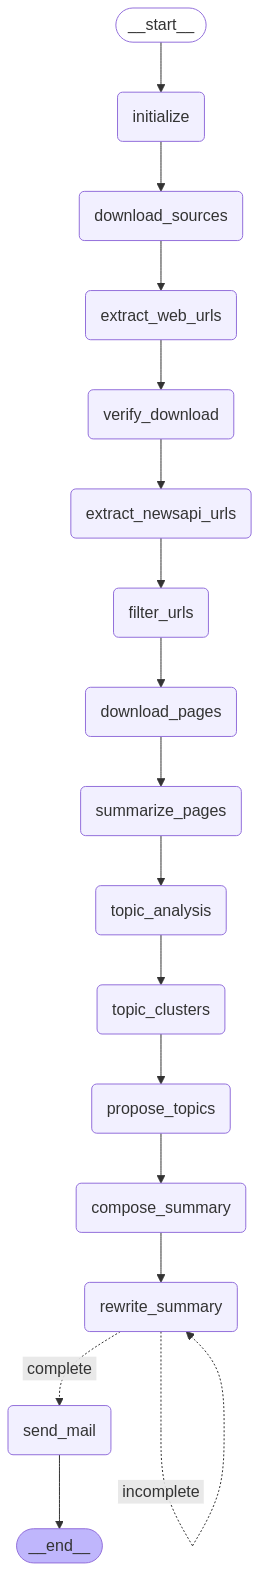

In [14]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

# before_date = None
before_date = '2025-04-09 18:00'
do_download = False

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [15]:
lg_state = lg_agent.initialize_config(lg_state)


2025-04-10 09:40:15,935 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-10 09:40:15,936 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-10 09:40:15,936 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-10 09:40:15,937 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-10 09:40:15,937 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-10 09:40:15,937 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-10 09:40:15,938 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [16]:
lg_state = lg_agent.download_sources(lg_state)


2025-04-10 09:40:16,719 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-04-10 09:40:16,720 - AInewsbot - INFO - Found 16 previously downloaded files
2025-04-10 09:40:16,721 - AInewsbot - INFO - htmldata/Washington Post (04_10_2025 07_32_33 AM).html
2025-04-10 09:40:16,722 - AInewsbot - INFO - htmldata/Hacker News 2 (04_10_2025 07_31_48 AM).html
2025-04-10 09:40:16,722 - AInewsbot - INFO - htmldata/Hacker News 1 (04_10_2025 07_31_46 AM).html
2025-04-10 09:40:16,722 - AInewsbot - INFO - htmldata/The Verge (04_10_2025 07_32_11 AM).html
2025-04-10 09:40:16,723 - AInewsbot - INFO - htmldata/Ars Technica (04_10_2025 07_31_37 AM).html
2025-04-10 09:40:16,724 - AInewsbot - INFO - htmldata/Business Insider (04_10_2025 07_31_35 AM).html
2025-04-10 09:40:16,724 - AInewsbot - INFO - htmldata/Bloomberg (04_10_2025 07_31_37 AM).html
2025-04-10 09:40:16,725 - AInewsbot - INFO - htmldata/VentureBeat (04_10_2025 07_32_20 AM).html
2025-04-10 09:40:16,726 - AInewsbot - INFO

In [17]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-04-10 09:40:17,760 - AInewsbot - INFO - Parsing html files
2025-04-10 09:40:17,761 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (04_10_2025 07_31_37 AM).html
2025-04-10 09:40:17,801 - AInewsbot - INFO - parse_file - found 169 raw links
2025-04-10 09:40:17,804 - AInewsbot - INFO - parse_file - found 36 filtered links
2025-04-10 09:40:17,804 - AInewsbot - INFO - 36 links found
2025-04-10 09:40:17,804 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg (04_10_2025 07_31_37 AM).html
2025-04-10 09:40:17,827 - AInewsbot - INFO - parse_file - found 245 raw links
2025-04-10 09:40:17,830 - AInewsbot - INFO - parse_file - found 38 filtered links
2025-04-10 09:40:17,831 - AInewsbot - INFO - 38 links found
2025-04-10 09:40:17,831 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider (04_10_2025 07_31_35 AM).html
2025-04-10 09:40:17,848 - AInewsbot - INFO - parse_file - found 209 raw links
2025-04-10 09:40:17,850 - AInewsbot - INFO - parse_file - found 20 filtered l

In [18]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


id
src                  
Ars Technica       35
Bloomberg          31
Business Insider   20
FT                 61
Feedly AI          34
Hacker News 1      25
Hacker News 2      24
HackerNoon        110
New York Times     19
Reddit            109
Techmeme          166
The Register      108
The Verge          32
VentureBeat        45
WSJ                18
Washington Post    40

number of missing sources 0


set()

In [19]:
lg_state = lg_agent.verify_download(lg_state)


2025-04-10 09:40:22,968 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [20]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-04-10 09:40:24,080 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-09T09:40:24 from NewsAPI


In [21]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-04-10 09:40:25,479 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-09 18:00'
2025-04-10 09:40:25,659 - AInewsbot - INFO - URLs in orig_df: 975
2025-04-10 09:40:25,662 - AInewsbot - INFO - Existing URLs in DB: 241916
2025-04-10 09:40:25,718 - AInewsbot - INFO - New URLs in df filtered by URL: 414
2025-04-10 09:40:25,839 - AInewsbot - INFO - Existing src+title: 17
2025-04-10 09:40:25,840 - AInewsbot - INFO - New URLs in df filtered by src+title: 397
2025-04-10 09:40:25,853 - AInewsbot - INFO - Found 396 unique new headlines
2025-04-10 09:40:25,854 - AInewsbot - INFO - Found 388 unique cleaned new headlines
2025-04-10 09:40:34,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 09:40:34,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 09:40:40,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

id
src                 
Ars Technica       4
Bloomberg         13
Business Insider   4
FT                 2
Feedly AI         28
Hacker News 1      4
Hacker News 2      3
HackerNoon         7
New York Times     1
NewsAPI           56
Reddit             1
Techmeme          25
The Register       6
The Verge          7
VentureBeat        2
WSJ                2
Washington Post    1

In [23]:
lg_state = lg_agent.download_pages(lg_state)


2025-04-10 09:44:45,519 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-10 09:45:48,137 - AInewsbot - INFO - Processing page 0: https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/
2025-04-10 09:45:48,137 - AInewsbot - INFO - Processing page 1: https://semianalysis.com/2025/04/10/tariff-armageddon-gpu-loopholes/
2025-04-10 09:45:48,137 - AInewsbot - INFO - Processing page 2: https://www.cnbc.com/2025/04/09/inside-isomorphic-labs-google-deepminds-ai-life-sciences-spinoff.html
2025-04-10 09:45:48,138 - AInewsbot - INFO - Processing page 3: https://www.forbes.com/sites/konstantinebuhler/2025/04/10/ai-50-2025-ai-agents-move-beyond-chat/
2025-04-10 09:45:48,138 - AInewsbot - INFO - get_url(https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/) - starting get_url https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-n

2025-04-10 09:45:48,154 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-10/alphabet-can-t-shake-off-ai-concerns-even-with-low-multiple) - starting get_url https://www.bloomberg.com/news/articles/2025-04-10/alphabet-can-t-shake-off-ai-concerns-even-with-low-multiple
2025-04-10 09:45:48,154 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-08/altman-backed-praxis-scouts-kyiv-athens-for-tech-utopia-base) - starting get_url https://www.bloomberg.com/news/articles/2025-04-08/altman-backed-praxis-scouts-kyiv-athens-for-tech-utopia-base
2025-04-10 09:45:48,155 - AInewsbot - INFO - Processing page 20: https://www.wsj.com/tech/ai/amazon-ceo-gen-ai-will-reinvent-every-customer-experience-f12ecb2c
2025-04-10 09:45:48,155 - AInewsbot - INFO - Processing page 21: https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/
2025-04-10 09:45:48,155 - AInewsbot - INFO - get_url(https://www.wsj.com/tech/ai/amazon-ceo-gen-ai-will-reinvent-ever

2025-04-10 09:45:49,809 - AInewsbot - INFO - Processing page 36: https://www.businessinsider.com/chinese-social-media-users-turned-trade-tariff-war-meme-war-2025-4
2025-04-10 09:45:49,809 - AInewsbot - INFO - get_url(https://www.businessinsider.com/chinese-social-media-users-turned-trade-tariff-war-meme-war-2025-4) - starting get_url https://www.businessinsider.com/chinese-social-media-users-turned-trade-tariff-war-meme-war-2025-4
2025-04-10 09:45:49,811 - AInewsbot - INFO - Processing page 37: https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/
2025-04-10 09:45:49,812 - AInewsbot - INFO - get_url(https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/) - starting get_url https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/
2025-04-10 09:45:49,814 - AInewsbot - INFO - Processing page 38: https://www.iea.org/news/ai-is-s

2025-04-10 09:45:50,063 - AInewsbot - INFO - get_url(https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol) - starting get_url https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol
2025-04-10 09:45:50,067 - AInewsbot - INFO - Processing page 54: https://venturebeat.com/security/google-cloud-intros-ai-security-agents-unified-security-platform-to-consolidate-ops-triage-threat-intel/
2025-04-10 09:45:50,069 - AInewsbot - INFO - get_url(https://venturebeat.com/security/google-cloud-intros-ai-security-agents-unified-security-platform-to-consolidate-ops-triage-threat-intel/) - starting get_url https://venturebeat.com/security/google-cloud-intros-ai-security-agents-unified-security-platform-to-consolidate-ops-triage-threat-intel/
2025-04-10 09:45:50,071 - AInewsbot - INFO - Processing page 55: https://techcrunch.com/2025/04/09/google-says-itll-embrace-anthropics-standard-for-connecting-ai-models-to-data/
2025-04-10 09:45:50,071 - AInewsbot - I

2025-04-10 09:45:51,115 - AInewsbot - INFO - get_url(https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/) - starting get_url https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/
2025-04-10 09:45:51,120 - AInewsbot - INFO - Processing page 71: https://arstechnica.com/gadgets/2025/04/google-unveils-ironwood-its-most-powerful-ai-processor-yet/
2025-04-10 09:45:51,127 - AInewsbot - INFO - get_url(https://arstechnica.com/gadgets/2025/04/google-unveils-ironwood-its-most-powerful-ai-processor-yet/) - starting get_url https://arstechnica.com/gadgets/2025/04/google-unveils-ironwood-its-most-powerful-ai-processor-yet/
2025-04-10 09:45:51,135 - AInewsbot - INFO - Processing page 72: https://techcrunch.com/2025/04/09/google-unveils-ironwood-a-new-ai-accelerator-chip/
2025-04-10 09:45:51,136 - AInewsbot - INFO - get_url(https://techcrunch.com/2025/04/09/google-unveils-ironwood-a-new-ai-accelerator-chip/) - starting get_url https

2025-04-10 09:45:51,180 - AInewsbot - INFO - Processing page 91: https://www.bloomberg.com/news/articles/2025-04-10/indian-startup-unveils-system-to-run-ai-without-advanced-chips
2025-04-10 09:45:51,181 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-10/indian-startup-unveils-system-to-run-ai-without-advanced-chips) - starting get_url https://www.bloomberg.com/news/articles/2025-04-10/indian-startup-unveils-system-to-run-ai-without-advanced-chips
2025-04-10 09:45:51,182 - AInewsbot - INFO - Processing page 92: https://nationalinterest.org/blog/buzz/inside-the-navys-upcoming-terminator-ai-fighter-jets
2025-04-10 09:45:51,182 - AInewsbot - INFO - get_url(https://nationalinterest.org/blog/buzz/inside-the-navys-upcoming-terminator-ai-fighter-jets) - starting get_url https://nationalinterest.org/blog/buzz/inside-the-navys-upcoming-terminator-ai-fighter-jets
2025-04-10 09:45:51,184 - AInewsbot - INFO - Processing page 93: https://blog.google/products/google-cloud

2025-04-10 09:45:53,573 - AInewsbot - INFO - Processing page 111: https://www.theregister.com/2025/04/10/uk_ai_energy_council_meets/
2025-04-10 09:45:53,573 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/04/10/uk_ai_energy_council_meets/) - starting get_url https://www.theregister.com/2025/04/10/uk_ai_energy_council_meets/
2025-04-10 09:45:53,573 - AInewsbot - INFO - Processing page 112: https://www.nytimes.com/2025/04/09/technology/openai-elon-musk-lawsuit.html
2025-04-10 09:45:53,574 - AInewsbot - INFO - get_url(https://www.nytimes.com/2025/04/09/technology/openai-elon-musk-lawsuit.html) - starting get_url https://www.nytimes.com/2025/04/09/technology/openai-elon-musk-lawsuit.html
2025-04-10 09:45:53,574 - AInewsbot - INFO - Processing page 113: https://www.bloomberg.com/news/articles/2025-04-09/anthropic-to-offer-200-monthly-claude-chatbot-subscription
2025-04-10 09:45:53,574 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-09/anthropic-to-

2025-04-10 09:45:53,665 - AInewsbot - INFO - get_url(https://www.euronews.com/health/2025/04/10/scientists-produce-complex-map-of-mouses-brain-that-could-unravel-mystery-of-how-ours-work) - starting get_url https://www.euronews.com/health/2025/04/10/scientists-produce-complex-map-of-mouses-brain-that-could-unravel-mystery-of-how-ours-work
2025-04-10 09:45:55,433 - AInewsbot - INFO - get_url(Scientists produce complex map of mouse's brain that could unravel mystery of how ours work) - Saving Scientists_produce_complex_map_of_mouse_s_brain_that_could_unravel_mystery_of_how_ours_work.html as UTF-8
2025-04-10 09:45:55,434 - AInewsbot - INFO - Processing page 131: https://www.ft.com/content/f8d5404c-5a24-4e3a-9e0b-6987153cd41e
2025-04-10 09:45:55,435 - AInewsbot - INFO - get_url(https://www.ft.com/content/f8d5404c-5a24-4e3a-9e0b-6987153cd41e) - starting get_url https://www.ft.com/content/f8d5404c-5a24-4e3a-9e0b-6987153cd41e
2025-04-10 09:45:55,633 - AInewsbot - INFO - get_url(Google cloud d

2025-04-10 09:45:56,864 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-09/us-government-employs-ai-to-analyze-worker-personnel-files) - starting get_url https://www.bloomberg.com/news/articles/2025-04-09/us-government-employs-ai-to-analyze-worker-personnel-files
2025-04-10 09:45:56,865 - AInewsbot - INFO - Processing page 147: https://techcrunch.com/2025/04/09/court-document-reveals-locations-of-whatsapp-victims-targeted-by-nso-spyware/
2025-04-10 09:45:56,865 - AInewsbot - INFO - get_url(https://techcrunch.com/2025/04/09/court-document-reveals-locations-of-whatsapp-victims-targeted-by-nso-spyware/) - starting get_url https://techcrunch.com/2025/04/09/court-document-reveals-locations-of-whatsapp-victims-targeted-by-nso-spyware/
2025-04-10 09:45:57,684 - AInewsbot - INFO - get_url(Safeguarding The Future: Penetration Testing In The AI Era) - Saving Safeguarding_The_Future__Penetration_Testing_In_The_AI_Era.html as utf-8
2025-04-10 09:45:57,686 - AInewsbot -

2025-04-10 09:45:59,962 - AInewsbot - INFO - get_url(reAlpha Tech Corp. Announces Closing of Exercise of Warrants for $3.1 Million Gross Proceeds) - Saving reAlpha_Tech_Corp._Announces_Closing_of_Exercise_of_Warrants_for__3.1_Million_Gross_Proceeds.html as utf-8
2025-04-10 09:45:59,963 - AInewsbot - INFO - Processing page 165: https://techcrunch.com/2025/04/09/elon-musks-ai-company-xai-launches-an-api-for-grok-3/
2025-04-10 09:45:59,963 - AInewsbot - INFO - get_url(https://techcrunch.com/2025/04/09/elon-musks-ai-company-xai-launches-an-api-for-grok-3/) - starting get_url https://techcrunch.com/2025/04/09/elon-musks-ai-company-xai-launches-an-api-for-grok-3/
2025-04-10 09:45:59,963 - AInewsbot - INFO - Quit webdriver
2025-04-10 09:46:02,651 - AInewsbot - INFO - 34 pages saved
2025-04-10 09:46:08,144 - AInewsbot - INFO - get_url(Nuro valued at $6 billion in latest funding round) - Saving Nuro_valued_at__6_billion_in_latest_funding_round.html as utf-8
2025-04-10 09:46:08,145 - AInewsbot -

In [24]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-04-10 10:03:55,781 - AInewsbot - INFO - Starting summarize
2025-04-10 10:03:55,786 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-10 10:03:55,843 - AInewsbot - INFO - clean_html - Page title: $144 Billion Tether’s Next Act: A U.S. Stablecoin And A Peer-To-Peer ChatGPT
Social card title: $144 Billion Tether’s Next Act: A U.S. Stablecoin And A Peer-To-Peer ChatGPT
Social card description: The world’s largest stablecoin issuer is plotting its U.S. expansion and building a decentralized rival to OpenAI’s model.

2025-04-10 10:03:55,942 - AInewsbot - INFO - Queuing 0: Page title: $144 Billion Tether’s Next Act: A U.S....
2025-04-10 10:03:55,978 - AInewsbot - INFO - clean_html - Page title: Tariff Armageddon? | GPU Loopholes, Mexico Supply Chain Shift, Wafer Fab Equipment Vulnerabilities, Optical Module Pricing Surge, Datacenter Equipment – SemiAnalysis
Social card title: Tariff Armageddon? | GPU Loopholes, Mexico Supply Chain Shift, Wafer Fab Equipment Vulnerabilities

2025-04-10 10:03:57,101 - AInewsbot - INFO - Queuing 16: Page title: Agent2Agent: Google announces open pro...
2025-04-10 10:03:57,115 - AInewsbot - INFO - clean_html - Page title: AkiraBot network hits thousands of sites with CAPTCHA bypassing AI spam | TechRadar
Social card title: AkiraBot network hits thousands of sites with CAPTCHA bypassing AI spam
Social card description: Tens of thousands of websites were served spam messages

2025-04-10 10:03:57,135 - AInewsbot - INFO - Queuing 17: Page title: AkiraBot network hits thousands of sit...
2025-04-10 10:03:57,137 - AInewsbot - INFO - clean_html - Page title: Bloomberg - Are you a robot?

2025-04-10 10:03:57,139 - AInewsbot - INFO - Queuing 18: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-10 10:03:57,153 - AInewsbot - INFO - clean_html - Page title: Altman-Backed Praxis Scouts Kyiv, Athens for Tech Utopia - Bloomberg
Social card title: Altman-Backed Praxis Scouts Kyiv, Athens for Tech Utopia Base
Social card descript

2025-04-10 10:03:57,617 - AInewsbot - INFO - Queuing 34: Page title: Capitalizing On The AI Gold Rush: Oppo...
2025-04-10 10:03:57,647 - AInewsbot - INFO - clean_html - Page title: ChatGPT Plus Is Free for College Students Right Now. Here's What You Get - CNET
Social card title: ChatGPT Plus Is Free for College Students Right Now. Here's What You Get
Social card description: OpenAI is giving away its premium ChatGPT Plus service for free to college students at degree-granting schools in the US and Canada until May 31.

2025-04-10 10:03:57,667 - AInewsbot - INFO - Queuing 35: Page title: ChatGPT Plus Is Free for College Stude...
2025-04-10 10:03:57,683 - AInewsbot - INFO - clean_html - Page title: Chinese Social Media Users Have Turned the Trade War Into a Meme War - Business Insider
Social card title: Chinese social media users have turned the trade war into a meme war, complete with AI-generated art
Social card description: AI generated memes of weapon-wielding penguins and Americans 

2025-04-10 10:03:58,111 - AInewsbot - INFO - Queuing 50: Page title: Clearview founder ousted from board af...
2025-04-10 10:03:58,123 - AInewsbot - INFO - clean_html - Page title: Gemini 2.5 Pro Experimental Will Now Power the Agentic Deep Research Feature | Technology News
Social card title: Deep Research AI Agent Will Now Be Powered by Gemini 2.5 Pro Experimental
Social card description: Before this, the Deep Research tool was powered by the Gemini 2.0 Flash Thinking (experimental) AI model.

2025-04-10 10:03:58,154 - AInewsbot - INFO - Queuing 51: Page title: Gemini 2.5 Pro Experimental Will Now P...
2025-04-10 10:03:58,169 - AInewsbot - INFO - clean_html - Page title: Gemini can now turn your Google Docs into podcasts | The Verge
Social card title: Gemini can now turn your Google Docs into podcasts
Social card description: Gemini can be your editor and your data analyst, apparently.

2025-04-10 10:03:58,192 - AInewsbot - INFO - Queuing 52: Page title: Gemini can now turn your Goog

2025-04-10 10:03:58,861 - AInewsbot - INFO - Queuing 66: Page title: Google launches new Ironwood chip to s...
2025-04-10 10:03:58,870 - AInewsbot - INFO - clean_html - Page title: Google's 7th-gen Ironwood TPUs promise 42 AI exaFLOPS pods • The Register
Social card title: Google's 7th-gen Ironwood TPUs promise 42 AI exaFLOPS pods
Social card description: Cloud Next: Sure, we're doing FP8 versus a supercomputer's FP64. What of it?

2025-04-10 10:03:58,885 - AInewsbot - INFO - Queuing 67: Page title: Google's 7th-gen Ironwood TPUs promise...
2025-04-10 10:03:58,901 - AInewsbot - INFO - clean_html - Page title: Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE
Social card title: Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE
Social card description: Google rolls out updates for building multi-agent AI ecosystems - SiliconANGLE

2025-04-10 10:03:58,924 - AInewsbot - INFO - Queuing 68: Page title: Google rolls out updates for bui

2025-04-10 10:03:59,363 - AInewsbot - INFO - Queuing 84: Page title: How LongFact Helps Measure the Accurac...
2025-04-10 10:03:59,378 - AInewsbot - INFO - clean_html - Page title: How SAFE Performs Compared to Human Annotations | HackerNoon
Social card title: How SAFE Performs Compared to Human Annotations | HackerNoon
Social card description: This FAQ section clarifies key aspects of  LongFact benchmarking, including reproducibility, SAFE evaluation, human error, recall measurement, & future research

2025-04-10 10:03:59,410 - AInewsbot - INFO - Queuing 85: Page title: How SAFE Performs Compared to Human An...
2025-04-10 10:03:59,416 - AInewsbot - INFO - clean_html - Page title: Anthropic Education Report: How University Students Use Claude \ Anthropic
Social card title: Anthropic Education Report: How University Students Use Claude
Social card description: AI systems are no longer just specialized research tools: they’re everyday academic companions. As AIs integrate more deeply int

2025-04-10 10:03:59,829 - AInewsbot - INFO - Queuing 101: Page title: Meta’s Llama 4 Models Are Good for Ent...
2025-04-10 10:03:59,839 - AInewsbot - INFO - clean_html - Page title: MusiCoT_paper.pdf

2025-04-10 10:03:59,853 - AInewsbot - INFO - Queuing 102: Page title: MusiCoT_paper.pdf
Analyzable Chain-of-...
2025-04-10 10:03:59,861 - AInewsbot - INFO - clean_html - Page title: NVIDIA Celebrates Partners of the Year Advancing AI in EMEA | NVIDIA Blog
Social card title: NVIDIA Celebrates Partners of the Year Advancing AI in Europe, Middle East and Africa
Social card description: NVIDIA this week recognized partners in Europe, the Middle East and Africa at the annual EMEA Partner Day hosted by the NVIDIA Partner Network.

2025-04-10 10:03:59,869 - AInewsbot - INFO - Queuing 103: Page title: NVIDIA Celebrates Partners of the Year...
2025-04-10 10:03:59,885 - AInewsbot - INFO - clean_html - Page title: New Workspace AI tools from Google focus on workflow automation and content creation -

2025-04-10 10:04:00,548 - AInewsbot - INFO - clean_html - Page title: yahoo

2025-04-10 10:04:00,552 - AInewsbot - INFO - Queuing 121: Page title: yahoo
guce
guce
Oops, something went w...
2025-04-10 10:04:00,566 - AInewsbot - INFO - clean_html - Page title: Reddit Answers just got a huge Google Gemini upgrade, and now I can’t wait to try it | TechRadar
Social card title: Reddit Answers just got a huge Google Gemini upgrade, and now I can’t wait to try it
Social card description: Reddit has the answer

2025-04-10 10:04:00,585 - AInewsbot - INFO - Queuing 122: Page title: Reddit Answers just got a huge Google ...
2025-04-10 10:04:00,596 - AInewsbot - INFO - clean_html - Page title: Reddit’s conversational AI search tool leverages Google Gemini | TechCrunch
Social card title: Reddit’s conversational AI search tool leverages Google Gemini | TechCrunch
Social card description: Reddit Answers, the platform's conversational AI search tool, gets an upgrade through an integration with Google G

2025-04-10 10:04:01,171 - AInewsbot - INFO - Queuing 138: Page title: Tessell snags $60M to drive data manag...
2025-04-10 10:04:01,193 - AInewsbot - INFO - clean_html - Page title: The AI Valuation Paradox: Balancing Hype With Real-World Impact
Social card title: The AI Valuation Paradox: Balancing Hype With Real-World Impact
Social card description: We may soon witness a decline in the high funding levels AI startups currently attract.

2025-04-10 10:04:01,222 - AInewsbot - INFO - Queuing 139: Page title: The AI Valuation Paradox: Balancing Hy...
2025-04-10 10:04:01,243 - AInewsbot - INFO - clean_html - Page title: The Dawn Of The AI CEO? Why Education Needs To Watch Closely
Social card title: The Dawn Of The AI CEO? Why Education Needs To Watch Closely
Social card description: HeyBoss AI appointed an artificial intelligence as CEO—raising urgent questions about the future of leadership, work, and education. This article explores what it means.

2025-04-10 10:04:01,273 - AInewsbot - 

2025-04-10 10:04:02,047 - AInewsbot - INFO - Queuing 156: Page title: With agentic AI, Google Cloud is trans...
2025-04-10 10:04:02,059 - AInewsbot - INFO - clean_html - Page title: WordPress.com launches a free AI-powered website builder | TechCrunch
Social card title: WordPress.com launches a free AI-powered website builder | TechCrunch
Social card description: WordPress.com has launched a new AI site builder that allows anyone to create a functioning website using an AI chat-style interface.

2025-04-10 10:04:02,072 - AInewsbot - INFO - Queuing 157: Page title: WordPress.com launches a free AI-power...
2025-04-10 10:04:02,097 - AInewsbot - INFO - clean_html - Page title: You can now give Google’s AI video model camera directions | The Verge
Social card title: You can now give Google’s AI video model camera directions
Social card description: Veo 2 can also edit your real videos too.

2025-04-10 10:04:02,119 - AInewsbot - INFO - Queuing 158: Page title: You can now give Google’s AI v

2025-04-10 10:04:05,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,076 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,107 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:06,213 - httpx 

2025-04-10 10:04:07,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,287 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:08,382 - httpx 

2025-04-10 10:04:15,324 - AInewsbot - INFO - Summary for 2: - Isomorphic Labs, a spinoff of Google DeepMind, aims to "solve all disease" using AI-powered drug discovery, leveraging the AlphaFold technology to predict protein structures and develop potential treatments for diseases like Alzheimer's and cancer.

- The startup recently secured $600 million in external funding, led by Thrive Capital and GV, to expand into biologics and increase computational resources for scaling drug discovery efforts.

- Since its 2021 launch, Isomorphic has grown to over 200 employees, partnered with pharmaceutical giants like Eli Lilly and Novartis, and released AlphaFold3 for non-commercial use, broadening its applications in molecular biology.
2025-04-10 10:04:15,324 - AInewsbot - INFO - Summary for 3: - The 2025 Forbes AI 50 list showcases a shift in AI from merely responding to prompts to solving problems and completing entire workflows, with startups like Harvey automating complex tasks in industr

2025-04-10 10:04:15,332 - AInewsbot - INFO - Summary for 16: • Google has launched Agent2Agent (A2A), an open protocol enabling AI agents from different developers or frameworks to securely communicate and collaborate, addressing fragmentation in the AI ecosystem.  

• The A2A protocol facilitates task negotiation and collaboration between agents by allowing them to advertise their capabilities and coordinate on various processes, with support from over 50 technology partners including Atlassian, Salesforce, and SAP.  

• Google has released A2A's full specifications on GitHub and is working with partners to deliver a production-ready version later this year, complementing tools like MCP for broader business system integration.
2025-04-10 10:04:15,332 - AInewsbot - INFO - Summary for 17: - Cybersecurity researchers at SentinelOne discovered a Python-based spam framework called AkiraBot, which has spammed over 80,000 websites by bypassing CAPTCHA filters using fake browsers, code inject

2025-04-10 10:04:15,336 - AInewsbot - INFO - Summary for 30: - Boosted.ai partnered with Liontrust's Global Equities team to integrate advanced AI into their portfolio management and research processes, enhancing efficiency, risk control, and investment insights.  
- Liontrust's Mark Hawtin stated that the collaboration uses Boosted.ai to develop proprietary AI agents, improving research efficiency while maintaining flexibility to adjust research parameters in real-time.  
- Boosted.ai CEO Joshua Pantony highlighted the partnership as a validation of agentic AI's effectiveness in delivering efficiencies and insights for institutional investors.  
2025-04-10 10:04:15,337 - AInewsbot - INFO - Summary for 31: - CaixaBank and Salesforce have signed an agreement to advance AI-driven digital transformation in banking services, utilizing tools like Agentforce and Salesforce Data Cloud to enhance customer experience, optimize decision-making, and improve efficiency in both customer and employe

2025-04-10 10:04:15,340 - AInewsbot - INFO - Summary for 42: - ChatGPT enhances Angular development by accelerating software production through automated boilerplate code generation, improving code quality with best practices, and reducing development costs by automating repetitive tasks.  
- Developers face challenges using ChatGPT, including poor output quality, security issues, and the need for clear prompts, but these can often be mitigated with correctly written instructions and responsible data handling.  
- While not a replacement for human expertise, ChatGPT helps developers with tasks like form validation, unit test generation, and code refactoring, saving significant time during the development process.  
2025-04-10 10:04:15,340 - AInewsbot - INFO - Summary for 43: - The European Union plans to triple its AI datacentre capacity within seven years to reduce reliance on non-EU infrastructure and boost competitiveness in artificial intelligence, supported by draft legislation na

2025-04-10 10:04:15,343 - AInewsbot - INFO - Summary for 55: • Google announced plans to adopt Anthropic’s Model Context Protocol (MCP) for its Gemini models and SDK, as revealed by Google DeepMind CEO Demis Hassabis.  

• MCP is an open standard allowing AI models to connect with data sources like business tools and content repositories, enabling developers to create two-way interactions between AI applications and data.  

• Several companies, including Block, Apollo, and Sourcegraph, have already integrated support for MCP since Anthropic open-sourced it.  
2025-04-10 10:04:15,344 - AInewsbot - INFO - Summary for 56: - Google announced new "agentic" capabilities for its AI coding assistant, Gemini Code Assist, allowing it to deploy agents that automate complex programming tasks, such as creating applications, transforming code between languages, and performing code reviews.  
- The upgrades, introduced during the Cloud Next conference, include integration with Android Studio and a n

2025-04-10 10:04:15,346 - AInewsbot - INFO - Summary for 66: - Alphabet's Google unveiled its seventh-generation AI chip, named Ironwood, designed to enhance the performance of AI applications, particularly in inference computing for tasks like chatbot queries.  
- The Ironwood chip is optimized to run AI applications efficiently, with double the performance per energy unit compared to its predecessor, and can operate in groups of up to 9,216 chips.  
- The chip integrates features from earlier designs, increases memory, and supports Google's Gemini AI models, though the chip's manufacturer was not disclosed.  
2025-04-10 10:04:15,346 - AInewsbot - INFO - Summary for 67: - Google announced its seventh-generation Tensor Processing Units (TPUs), codenamed Ironwood, offering significant upgrades in AI performance, including up to 4.6 petaFLOPS of dense FP8 performance per chip and 192 GB high-bandwidth memory capable of up to 7.4 TB/s.  
- Google claims a pod of 9,216 Ironwood TPUs can ac

2025-04-10 10:04:15,349 - AInewsbot - INFO - Summary for 80: - Artists and researchers are exploring co-creativity with AI, using it to inspire and critique creative projects, as seen in Lizzie Wilson's live coding, where AI introduces unexpected musical elements during performances.  
- Critics argue that existing generative AI tools like DALL-E and Midjourney prioritize ease of creation over fostering genuine creativity, potentially stifling skill development and critical engagement.  
- Researchers aim to develop AI tools that augment human creativity, emphasizing back-and-forth interaction, surprise, and challenges, to push creative boundaries and enhance artistic processes.  
2025-04-10 10:04:15,349 - AInewsbot - INFO - Summary for 81: - Artificial intelligence could significantly impact the media industry by reducing its workforce, which included fewer than 50,000 US journalists in 2023, while simultaneously enhancing certain aspects of news reporting, such as data processing.  


2025-04-10 10:04:15,352 - AInewsbot - INFO - Summary for 94: - Nvidia held its GPU Technology Conference (GTC) 2025 in San Jose, California, widely recognized as a leading AI event.  
- CEO Jensen Huang delivered a two-hour keynote at the conference.  
- No substantive news content regarding the AI business's recession resilience is included.
2025-04-10 10:04:15,352 - AInewsbot - INFO - Summary for 95: - no content
2025-04-10 10:04:15,352 - AInewsbot - INFO - Summary for 96: - **EQ-Bench evaluates longform creative writing by LLMs using metrics like average chapter length, word/phrase overuse (Slop), repetition, and quality degradation trends.**
- **Models are scored on a 0-100 scale based on an LLM-judged rubric, with gemini-2.5-pro-preview-03-25 receiving the highest score of 80.2 in this benchmark.**
- **Outputs are generated with specific settings (temp=0.7, min_p=0.1), and the scoring process is handled by Claude Sonnet 3.7.**
2025-04-10 10:04:15,352 - AInewsbot - INFO - Summary f

2025-04-10 10:04:15,355 - AInewsbot - INFO - Summary for 109: • Nvidia Corporation and Google Cloud announced a partnership to provide agentic artificial intelligence (AI) solutions to companies utilizing Google's chatbot Gemini.
2025-04-10 10:04:15,355 - AInewsbot - INFO - Summary for 110: - The UK's AI Energy Council held its first meeting to address powering AI datacenters, focusing on integrating clean energy, sustainable practices, and reforms to support growing energy demands from datacenters.  
- Plans include creating "AI Growth Zones" with access to at least 500 MW of power, while fundamental reforms in the connection process aim to release over 400 GW capacity in the power grid.  
- The UK faces challenges like having one of the highest electricity prices globally, with industrial rates significantly higher than other countries, requiring cost alleviation strategies.  
2025-04-10 10:04:15,355 - AInewsbot - INFO - Summary for 111: • The UK's AI Energy Council held its first me

2025-04-10 10:04:15,358 - AInewsbot - INFO - Summary for 125: - The financial impact of cybercrime is escalating, with projected global losses of $10 trillion by 2025 and AI-driven attacks becoming a rising threat; businesses must adopt proactive security strategies, including penetration testing, to mitigate risks.  
- Penetration testing simulates real-world cyberattacks to identify vulnerabilities, with Gray Box Testing deemed the most effective for addressing AI-exploitable weaknesses, emphasizing the need for continuous testing and improvement rather than one-time solutions.  
- Successful penetration testing involves collaboration with cybersecurity experts, targeted testing to simulate AI-driven exploits, and implementing detailed reports with actionable recommendations to strengthen defenses and ensure long-term resilience.  
2025-04-10 10:04:15,358 - AInewsbot - INFO - Summary for 126: - Sam Altman's lawyers accused Elon Musk of attempting to harm OpenAI through a personal ven

2025-04-10 10:04:15,367 - AInewsbot - INFO - Summary for 140: • Xiaoyin Qu, founder of HeyBoss AI, announced the appointment of Astra, an artificial intelligence system, as the world's first AI CEO, overseeing all company functions without human managers or engineers, though human oversight remains essential for legal, safety, and transparency matters.  

• Astra's capabilities in automating tasks like website creation and marketing highlight the potential for AI to disrupt traditional models of leadership and work, prompting questions about the purpose and role of education in preparing students for an AI-dominated future.  

• Educators are urged to focus on cultivating humanity, ethical thinking, and leadership qualities in students, emphasizing creativity, accountability, and the ability to ask meaningful questions in a world increasingly shaped by AI systems.  
2025-04-10 10:04:15,368 - AInewsbot - INFO - Summary for 141: - Companies face critical losses due to inaction on AI, wit

2025-04-10 10:04:15,370 - AInewsbot - INFO - Summary for 153: - Tempus AI Inc. (NASDAQ:TEM) shares dropped by 12.81% on Tuesday, closing at $37.23, due to overall market pessimism and the absence of new catalysts.  
- The company is anticipated to deliver business updates during the Annual Needham Virtual Healthcare Conference, with CFO Jim Rogers scheduled for a fireside discussion on April 9.  
- Tempus AI specializes in AI-enabled precision medicine, providing personalized healthcare solutions and supporting the development of therapeutics.  
2025-04-10 10:04:15,370 - AInewsbot - INFO - Summary for 154: • Microsoft is rolling out an update to Windows 11's Copilot Vision for Windows Insider program testers, allowing it to interact with any app window, expanding beyond examining content in Microsoft Edge.  

• The new Copilot Vision update aims to assist users in understanding both app content and user interfaces, potentially easing the learning curve for complex apps like Word, Excel

2025-04-10 10:04:15,371 - AInewsbot - INFO - Summary for 165: - Elon Musk's AI company, xAI, has launched an API for Grok 3, its flagship model. The API offers Grok 3 and Grok 3 Mini with reasoning capabilities, with pricing options based on input and output token quantities.  
- Grok 3 has been criticized for its higher pricing compared to competitors and a smaller context window than initially claimed, maxing out at 131,072 tokens despite earlier suggestions of supporting 1 million tokens.  
- Musk initially marketed Grok as an AI willing to address controversial topics, but earlier versions showed political bias, which he attributed to training data. It remains unclear if Grok 3 has achieved neutrality.  
2025-04-10 10:04:15,372 - AInewsbot - INFO - Received 165 summaries


In [25]:
display(Markdown(pd.DataFrame(lg_state["AIdf"]).iloc[0].summary))


• Tether is planning to expand into the U.S. stablecoin market with a new product tailored to the U.S. financial landscape, while maintaining its global USDT presence focused on emerging markets.  

• The company is entering the artificial intelligence sector by developing a decentralized AI platform aimed at offering privacy-focused, peer-to-peer data processing capabilities, diverging from centralized models like OpenAI's ChatGPT.  

• Tether has invested heavily in its AI venture, with approximately $10 billion allocated to its venture fund, and has hired 60 developers to build the AI system, which integrates USDT wallets and promotes the creation of niche AI models.  

In [27]:
z = pd.DataFrame(lg_state["AIdf"])['summary'].to_list()
print(len([z for a in z if a]))


165


In [28]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [29]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-04-10 10:04:48,799 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 10:04:52,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:57,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:57,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:58,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:59,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:59,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:04:59,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:

2025-04-10 10:05:04,317 - AInewsbot - INFO - Canonical topic opinion
2025-04-10 10:05:04,317 - AInewsbot - INFO - Canonical topic cryptocurrency
2025-04-10 10:05:04,317 - AInewsbot - INFO - Canonical topic meta
2025-04-10 10:05:04,318 - AInewsbot - INFO - Canonical topic finance
2025-04-10 10:05:04,318 - AInewsbot - INFO - Canonical topic european union
2025-04-10 10:05:04,318 - AInewsbot - INFO - Canonical topic ai tools
2025-04-10 10:05:04,318 - AInewsbot - INFO - Canonical topic google cloud
2025-04-10 10:05:04,318 - AInewsbot - INFO - Canonical topic lifestyle & travel
2025-04-10 10:05:04,319 - AInewsbot - INFO - Canonical topic open source
2025-04-10 10:05:04,319 - AInewsbot - INFO - Canonical topic ethics
2025-04-10 10:05:04,320 - AInewsbot - INFO - Canonical topic ai competitiveness
2025-04-10 10:05:04,320 - AInewsbot - INFO - Canonical topic tensor processing unit
2025-04-10 10:05:04,320 - AInewsbot - INFO - Canonical topic wayve
2025-04-10 10:05:04,320 - AInewsbot - INFO - Can

2025-04-10 10:05:14,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:14,641 - httpx 

2025-04-10 10:05:16,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:16,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,292 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,295 - httpx 

2025-04-10 10:05:17,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:17,336 - httpx 

2025-04-10 10:05:18,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,492 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,492 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,494 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,494 - httpx 

2025-04-10 10:05:18,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,526 - httpx 

2025-04-10 10:05:18,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,673 - httpx 

2025-04-10 10:05:18,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,707 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,707 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,708 - httpx 

2025-04-10 10:05:18,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,852 - httpx 

2025-04-10 10:05:18,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:18,894 - httpx 

2025-04-10 10:05:19,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,065 - httpx 

2025-04-10 10:05:19,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,528 - httpx 

2025-04-10 10:05:19,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:19,955 - httpx 

2025-04-10 10:05:20,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,702 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,707 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:20,761 - httpx 

2025-04-10 10:05:21,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:21,666 - httpx 

2025-04-10 10:05:23,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,214 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:23,317 - httpx 

2025-04-10 10:05:24,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:24,066 - httpx 

2025-04-10 10:05:24,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,008 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:25,089 - httpx 

2025-04-10 10:05:27,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:27,349 - httpx 

2025-04-10 10:05:31,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:31,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:31,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:31,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:31,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:31,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:31,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:31,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:32,283 - httpx 

In [30]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-04-10 10:05:47,419 - AInewsbot - INFO - Fetching embeddings for 165 headlines
2025-04-10 10:05:48,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-10 10:05:49,634 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-10 10:05:49,676 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-10 10:05:50,322 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-10 10:05:50,429 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-10 10:05:50,438 - AInewsbot - INFO - Found 11 clusters


title_topic_str
0                                                                                                                                                                                                                  Does AI Understand Angular Development? We Put ChatGPT to the Test (Topics: AI Applications, AI Support For Developers, AI Tools, AI Writing, Angular Development, Chatbots, Chatgpt, Code Assistants, Content Creation, Cybersecurity, Development Challenges, Digital Transformation, Gen AI, Generative AI, Job Automation, Jobs & Careers, Language Models, OpenAI, Review, Science, Software Automation, Testing, Virtual Assistants, Workflow Automation)
1  $144 Billion Tethers Next Act: A U.S. Stablecoin And A Peer-To-Peer ChatGPT (Topics: Agentic AI, AI Applications, AI Competitiveness, AI In Cybersecurity, AI Infrastructure, AI Stocks, AI Tools, AI Writing, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Content Creation, Cryptocurrency, Decentralized AI Platform, Digital Transformation, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Language Models, Meta, OpenAI, Privacy, Privacy & Surveillance, Privacy-Focused Data Processing, Products, Retrieval Augmented Generation, Science, Singularity, Stocks, Tether, Us Stablecoin Market, Usdt Integration, Venture Capital)
2                                                                                                                                                                                                                                                ChatGPT Plus Is Free for College Students Right Now. Here's What You Get (Topics: AI Applications, AI Stocks, AI Tools, AI Writing, Bias And Fairness, Chatbots, Chatgpt, Chatgpt Plus, Code Assistants, Content Creation, Education, Educational Focus, Ethics, Gen AI, Generative AI, Jobs & Careers, Language Models, OpenAI, Policy And Regulation, Products, Science, Society & Culture, Student Access, Virtual Assistants)

2025-04-10 10:05:51,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:51,225 - AInewsbot - INFO - I dub this cluster: AI and ChatGPT in Development


title_topic_str
3                                                                                                                                                                                                                                                                                        With agentic AI, Google Cloud is transforming almost every aspect of app development (Topics: Agent Development Kit, Agent2Agent Protocol, Agentic AI, AI Applications, AI Competitiveness, AI Infrastructure, AI Tools, Application Development, Artificial General Intelligence, Code Assistants, Data Centers, Digital Transformation, Economics, Finance, Gaming, Gemini 2.5 Flash, Gen AI, Generative AI, Generative AI Tools, Google, Google Cloud, Google Cloud AI, Google Deepmind, Google Gemini, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Meta, Recommendation Systems, Retrieval Augmented Generation, Science, Singularity, Testing, Vertex AI, Workflow Automation)
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Amazon Nova ACT AI Agents Designed for Automation Efficiency and Precision (Topics: Agent Development Kit, Agentic AI, AI Applications, AI Automation, AI Competitiveness, AI Infrastructure, AI Stocks, AI Tools, Amazon, Amazon Nova Act, Code Assistants, Content Creation, Customer Service, Digital Transformation, Gen AI, Generative AI, Job Automation, Products, Python Integration, Science, Supply Chain Optimization, Workflow Automation, Workflow Efficiency)
5                                                                                                                               Google A2A - a First Look at Another Agent-agent Protocol (Topics: Agent Development Kit, Agent-To-Agent Protocol, Agent2Agent Protocol, Agentic AI, AI Applications, AI Competitiveness, AI Infrastructure, AI Stocks, AI Task Automation, AI Tools, AI Writing, Anthropic, Brain-Computer Interfaces, Bubble, Chatbots, Code Assistants, Content Creation, Deals, Digital Transformation, Firebase Studio, Gen AI, Generative AI, Google, Google A2A, Google Cloud, Google Deepmind, Google Gemini, Internet Of Things, Language Models, Meta, Multi-Agent Collaboration, Neuromorphic Computing, Open Source, Open-Source Development, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Singularity, Speech Recognition & Synthesis, Testing, Transformers, Vertex AI, Virtual Assistants, Wayve, Workflow Automation)
6    Googles new Agent Development Kit lets enterprises rapidly prototype and deploy AI agents without recoding (Topics: Agent Development Kit, Agentic AI, AI Agent Deployment, AI Applications, AI Competitiveness, AI In Cybersecurity, AI Infrastructure, AI Lifecycle Management, AI Tools, AI Writing, Amazon, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Computer Vision, Content Creation, Cybersecurity, Digital Transformation, Enterprise Solutions, Ethics, Gemini 2.5 Flash, Gen AI, Generative AI, Google, Google Cloud, Google Deepmind, Google Gemini, Job Automation, Jobs & Careers, Language Models, Legal Issues, Meta, Open Source, OpenAI, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Robots, Safety And Alignment, Science, Singularity, Speech Recognition & Synthesis, Testing, Transformers, Vertex AI, Virtual Assistants, Workflow Automation)
7                                                                                               

2025-04-10 10:05:52,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:52,037 - AInewsbot - INFO - I dub this cluster: Advancements in Agentic AI Technology


title_topic_str
11                                                                             AI needs a lot of energy. Trump says coal is the answer. (Topics: AI Applications, AI Competitiveness, AI Data Center Energy, AI Infrastructure, AI Tools, AI Writing, Climate, Coal Industry Revival, Data Centers, Economics, Energy, Energy Policy, Environmental Criticism, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Renewable Energy, Safety And Alignment, Sustainability, Trump Executive Order)
12                                                                                                                                                                                                                                                                                                                                          AI Data Center Growth Means More Coal and Gas Plants, IEA Says (Topics: AI Data Center Growth, Climate, Coal And Gas Power Plants, Data Centers, Energy, Energy Consumption, Environmental Implications, Iea Report, Sustainability)
13  OK great, UK is building loads of AI datacenters. How are we going to power that?Practical matters like being 1 of most expensive energy regions in Europe focuses minds at AI Energy Council meetingSystems1 hr|10 (Topics: AI Applications, AI Competitiveness, AI Infrastructure, AI Tools, Climate, Data Centers, Digital Transformation, Economics, Energy, Energy Costs, European Union, Finance, Governance, Grid Capacity Reforms, Infrastructure, Policy And Regulation, Politics, Renewable Energy, Safety And Alignment, Science, Smart Grid, Sustainability, Uk)
14                                                           OK great, UK is building loads of AI datacenters. How are we going to power that? (Topics: AI Applications, AI Competitiveness, AI Datacenter Power Needs, AI Infrastructure, AI Tools, Clean Energy Initiatives, Climate, Data Centers, Digital Transformation, Economics, Energy, Energy Policies, European Union, Governance, Infrastructure, Infrastructure Challenges, Policy And Regulation, Politics, Renewable Energy, Safety And Alignment, Science, Smart Grid, Sustainability, Uk, Uk AI Energy Council)
15                                             Data centers' global electricity demand will exceed 945 TWh by 2030, and US data centers are set to account for nearly 50% of electricity demand growth by 2030 (Topics: AI Applications, AI Competitiveness, AI Impact, AI Infrastructure, AI Tools, Climate, Cybersecurity, Data Centers, Digital Transformation, Economics, Electricity Demand, Energy, Energy Infrastructure, Gen AI, Generative AI, Governance, Infrastructure, Policy And Regulation, Renewable Energy, Science, Supply Chain Optimization, Sustainability)
16                                                                                                                                                                          Data centres will use twice as much energy by 2030  driven by AI (Topics: AI Applications, AI Competitiveness, AI Growth, AI Infrastructure, AI Tools, China, Climate, Data Centers, Digital Transformation, Economics, Electricity Consumption, Energy, Energy Challenges, European Union, Gen AI, Generative AI, Infrastructure, Policy And Regulation, Renewable Energy, Science, Sustainability)

2025-04-10 10:05:52,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:52,768 - AInewsbot - INFO - I dub this cluster: AI Data Centers and Energy Needs


title_topic_str
17  AI In FinTech: Revolution Or Threat? (Topics: AI Applications, AI Competitiveness, AI In Cybersecurity, AI In Fintech, AI Tools, AI Writing, Bias And Fairness, Cybersecurity, Cybersecurity Threats, Digital Transformation, Economics, Ethical AI, Ethics, Finance, Fintech, Fraud Prevention, Gen AI, Generative AI, Governance, Inequality, Jobs & Careers, Legal Issues, Payment Optimization, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Supply Chain Optimization, Workflow Automation)
18                                                                                                   Boosted.ai Partners With Liontrust to Enhance AI-Driven Investment Research (Topics: Agent Development Kit, Agent2Agent Protocol, Agentic AI, AI Applications, AI Competitiveness, AI Investment Research, AI Stocks, AI Tools, AI Writing, Boosted.AI, Content Creation, Deals, Digital Transformation, Economics, Finance, Fintech, Gen AI, Generative AI, Jobs & Careers, Liontrust, Portfolio Management, Stocks, Virtual Assistants)
19                                                                                                                                                                                                                                                                  Fintech Entrepreneur Launches AI-Fueled Financial Assistant Hiro (Topics: AI Applications, AI Financial Assistants, AI In Finance, AI Tools, Code Assistants, Digital Financial Solutions, Economics, Finance, Fintech, Generative AI, Hiro, Products, Virtual Assistants)

2025-04-10 10:05:53,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:53,487 - AInewsbot - INFO - I dub this cluster: AI in Finance and Investment


title_topic_str
20  Adobe outlines agentic AI features coming to Photoshop, Acrobat, Premiere Pro, and more, including one-click context-aware edits and agents to analyze documents (Topics: Adobe Agentic AI, Agent Development Kit, Agentic AI, AI Applications, AI Competitiveness, AI Tools, AI Writing, Art & Design, Authors & Writing, Chatbots, Code Assistants, Content Creation, Context-Aware Editing, Digital Transformation, Document Analysis, Enhanced User Productivity, Gen AI, Generative AI, Hardware, Hollywood, Job Automation, Jobs & Careers, Language Models, Meta, Music, Natural Language Commands, Products, Recommendation Systems, Science, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Virtual Assistants, Workflow Automation)
21                                                                                                       Adobe is building AI agents for Photoshop and Premiere Pro (Topics: Adobe AI Agents, Agent Development Kit, Agentic AI, AI Applications, AI Competitiveness, AI Tools, AI Writing, Art & Design, Authors & Writing, Chatbots, Code Assistants, Content Creation, Creative Tools, Digital Transformation, Entertainment, Gen AI, Generative AI, Hardware, Hollywood, Job Automation, Jobs & Careers, Language Models, Meta, Music, Photoshop Features, Premiere Pro Enhancements, Products, Recommendation Systems, Science, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Uk, User Assistance, Virtual Assistants, Workflow Automation)
22                                                                                                                                                                                                                                                                          How to generate or enhance images in Adobe Photoshop with Generative AI (Topics: Adobe Photoshop Generative AI, AI Applications, AI Tools, AI Writing, Art & Design, Computer Vision, Content Creation, Creative Enhancement, Digital Transformation, Entertainment, Gaming, Gen AI, Generative AI, Generative Fill Feature, Hardware, Image Creation Tools, Intellectual Property, Products, Retrieval Augmented Generation, Review, Society & Culture, Virtual & Augmented Reality)

2025-04-10 10:05:54,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:54,515 - AInewsbot - INFO - I dub this cluster: Adobe AI Innovations in Creative Tools


title_topic_str
23  Anthropic debuts Claude's Max plan, with 5x the usage limits of Pro for $100/month or 20x the usage for $200/month, plus early access to new models and features (Topics: AI Applications, AI Competitiveness, AI Stocks, AI Tools, AI Writing, Anthropic, Chatbot Usage Limits, Chatbots, Claude'S Max Plan, Code Assistants, Deals, Economics, Finance, Fintech, Funding, Funding Round, Gen AI, Generative AI, Healthcare, Jobs & Careers, Language Models, Products, Speech Recognition & Synthesis, Stocks, Subscription Model, Venture Capital, Virtual Assistants)
24                                                                                                                                                                                                                                                                                                                                                                                               OpenAI Rival Anthropic to Offer $200 Monthly Claude Chatbot Subscription (Topics: AI Market Competition, Anthropic, Chatbots, Claude Chatbot, OpenAI, Subscription Services)
25                                                                                                                                                                             Show HN: I turned my kid's worksheet into a math game in 10 minutes with Claude (Topics: Agentic AI, AI Applications, AI Tools, AI Writing, Anthropic, Chatbots, Claude, Code Assistants, Content Creation, Education, Education Technology, Game Development, Gen AI, Generative AI, Jobs & Careers, Language Models, Society & Culture, Testing, User Experience Design, Virtual Assistants)

2025-04-10 10:05:55,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:55,737 - AInewsbot - INFO - I dub this cluster: Anthropic's Claude Chatbot Developments


title_topic_str
26                                                                                                                                                                                                                                                                                                                                                                                                                                         Google unveils Ironwood, its most powerful AI processor yet (Topics: Advanced AI Processing, Agentic AI, AI Applications, AI Competitiveness, AI Infrastructure, AI Tools, Artificial General Intelligence, Cloud AI Infrastructure, Computer Vision, Digital Transformation, Energy, Gemini 2.5 Flash, Gemini Models, Gen AI, Generative AI, Google, Google Cloud, Google Deepmind, Google Gemini, Hardware, Ironwood Tpu, Language Models, Products, Reinforcement Learning, Retrieval Augmented Generation, Science, Semiconductor Chips, Singularity, Tensor Processing Unit, Transformers)
27  Google adds AI agents to Gemini Code Assist for tasks like creating apps from specifications in Docs and migrating code from one language to another, in preview (Topics: Agent Development Kit, Agentic AI, Agentic Capabilities, AI Applications, AI Coding Challenges, AI Competitiveness, AI Infrastructure, AI Stocks, AI Tools, AI Writing, Android Studio Integration, Brain-Computer Interfaces, Chatbots, Code Assistants, Computer Vision, Content Creation, Cybersecurity, Digital Transformation, Firebase Studio, Gaming, Gemini Code Assist, Gen AI, Generative AI, Google, Google Cloud, Google Deepmind, Google Gemini, Hardware, Internet Of Things, Job Automation, Language Models, Meta, Neuromorphic Computing, Privacy & Surveillance, Products, Programming Automation, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Science, Singularity, Speech Recognition & Synthesis, Testing, Transformers, Vertex AI, Virtual Assistants, Wayve, Workflow Automation)
28                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Gemini can now turn your Google Docs into podcasts (Topics: AI Applications, AI Document Editing, AI Narration Features, AI Tools, AI Writing, Authors & Writing, Books & Publishing, Content Creation, Digital Transformation, Education, Entertainment, Gemini Features, Gen AI, Generative AI, Google, Google Cloud, Google Docs Podcasts, Google Gemini, Language Models, Meta, Music, Products, Science, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Workspace AI Tools)
29                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Google unveils Gemini 2.5 Flash, a reasoning model optimized for high-volume, cost-sensitive, and real-time applications, launching soon in Vertex AI (Topics: AI Applications, AI Competitiveness, AI Infrastructure, AI Model Efficiency, AI Tools, Cost-Sensitive AI Solutions, Customer Service, Digital Transformation, Economics, Gemini 2.5 Flash, Gen AI, Generative AI, Google, Google Cloud, Google Gemini, Governance, Language Models, Nvidia, Policy And Regulation, Privacy, Privacy & Surveillance, Real-Time Applic

2025-04-10 10:05:56,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:56,424 - AInewsbot - INFO - I dub this cluster: Advancements in Google's AI Technology


title_topic_str
40                                                                                                                                                                         Googles cloud-based AI Hypercomputer gets new workhorse with Ironwood TPU (Topics: Advanced AI Workloads, AI Applications, AI Competitiveness, AI Hypercomputer, AI Infrastructure, AI Tools, Cloud Services, Data Centers, Digital Transformation, Energy, Gen AI, Generative AI, Google, Google Cloud, Google Deepmind, Google Gemini, Hardware, Infrastructure, Ironwood Tpu, Language Models, Nvidia, Products, Science, Semiconductor Chips, Tensor Processing Unit, Transformers)
41                                                                                                                                     Google offers 7th-gen Ironwood TPUs for AI, with AI-inspired comparisonsCloud NextSure, we're doing FP8 versus a supercomputer's FP64. What of it?AI + ML10 hrs|1 (Topics: AI Applications, AI Competitiveness, AI Infrastructure, AI Performance, AI Tools, Cloud Computing, Digital Transformation, Energy, Gen AI, Generative AI, Google, Google Cloud, Hardware, Ironwood Tpu, Ironwood Tpus, Language Models, Products, Science, Semiconductor Chips, Supercomputer Comparisons, Tensor Processing Unit, Transformers)
42                                                                                                                                                                                                                                                                       Google launches new Ironwood chip to speed AI applications (Topics: AI Applications, AI Competitiveness, AI Inference Computing, AI Infrastructure, AI Tools, Chatbots, Digital Transformation, Energy, Gemini 2.5 Flash, Gen AI, Generative AI, Google, Google Gemini, Hardware, Ironwood Chip, Ironwood Tpu, Language Models, Products, Science, Semiconductor Chips, Tpu Advancements)
43  Google unveils Ironwood, its seventh-generation TPU and the first optimized for inference, coming later in 2025 in a 256-chip cluster or a 9,216-chip cluster (Topics: AI Accelerator Technology, AI Applications, AI Competitiveness, AI Inference, AI Infrastructure, AI Tools, Amazon, Artificial General Intelligence, Cloud Next Conference, Computer Vision, Digital Transformation, Energy, Gen AI, Generative AI, Google, Google Cloud, Google Deepmind, Google Gemini, Hardware, Ironwood Tpu, Language Models, Nvidia, Products, Recommendation Systems, Reinforcement Learning, Science, Semiconductor Chips, Tensor Processing Unit, Transformers)

2025-04-10 10:05:57,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:57,119 - AInewsbot - INFO - I dub this cluster: Google's AI Advancements and Infrastructure


title_topic_str
44                                                                                                                                                                                         Meta Finally Reveals The Truth About Llama 4 AI Models (Topics: Agentic AI, AI Applications, AI Competitiveness, AI Performance Concerns, AI Tools, AI Writing, Anthropic, Benchmark Manipulation, Bias And Fairness, Digital Transformation, Disinformation, Ethical AI Development, Ethics, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Disputes, Meta, Meta Llama 4 Models, Opinion, Privacy, Privacy & Surveillance, Review, Science, Transparency Issues)
45  Meta's AI, built on ill-gotten content, can probably build a digital youLlama 4 Scout is just the right size to ingest a lifetime of Facebook and Insta postsAI + ML4 hrs|3 (Topics: Agentic AI, AI Applications, AI Competitiveness, AI Infrastructure, AI Model Training, AI Stocks, AI Tools, AI Writing, Bias And Fairness, Content Creation, Copyright Concerns, Deepfakes, Digital Transformation, Ethics, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Actions, Legal Disputes, Legal Issues, Llama 4 Scout, Meta, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Science, User Data Privacy)
46                                                Metas Llama 4 Models Are Bad for Rivals but Good for Enterprises, Experts Say (Topics: AI Applications, AI Competitiveness, AI In Business, AI In Cybersecurity, AI Infrastructure, AI Stocks, AI Tools, AI Writing, Code Assistants, Computer Vision, Cost Efficiency In AI, Customer Service, Cybersecurity, Digital Transformation, Economics, Finance, Gen AI, Generative AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Llama 4 Models, Meta, Multimodal Capabilities, OpenAI, Products, Retrieval Augmented Generation, Safety And Alignment, Science, Supply Chain Optimization, Workflow Automation)

2025-04-10 10:05:58,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:58,097 - AInewsbot - INFO - I dub this cluster: Meta's Llama 4 AI Developments


title_topic_str
47                                                                                                     OpenAI countersues Elon Musk to stop his attacks and fake takeover bid (Topics: AI Applications, AI Competitiveness, AI Doom, AI Infrastructure, AI Stocks, AI Tools, AI Writing, Artificial General Intelligence, Bias And Fairness, Chatgpt, Code Assistants, Countersuit, Deals, Deepfakes, Digital Transformation, Elon Musk, Ethics, Finance, Gen AI, Generative AI, Governance, Intellectual Property, Language Models, Legal Actions, Legal Disputes, Legal Issues, Legal Strategies, Mergers And Acquisitions, Meta, Open Source, OpenAI, Opinion, Policy And Regulation, Politics, Retrieval Augmented Generation, Scams, Science, Singularity, Takeover Allegations)
48  OpenAI countersues Elon Musk, claiming harassment and asking a federal judge to stop Musk from any further attacks in a case over OpenAI's future structure (Topics: AI Applications, AI Competitiveness, AI Doom, AI Infrastructure, AI Stocks, AI Tools, AI Writing, Artificial General Intelligence, Bias And Fairness, Chatgpt, Code Assistants, Deals, Digital Transformation, Economics, Elon Musk, Ethics, Finance, For-Profit Transition, Funding, Gen AI, Generative AI, Governance, Harassment Claims, Intellectual Property, Ipos, Language Models, Legal Actions, Legal Disputes, Legal Issues, Mergers And Acquisitions, Meta, Open Source, OpenAI, Opinion, Policy And Regulation, Politics, Retrieval Augmented Generation, Science, Singularity, Venture Capital)
49                                                                OpenAI countersues Musk as Altman feud escalates (Topics: AI Applications, AI Competitiveness, AI Doom, AI Industry Dynamics, AI Infrastructure, AI Stocks, AI Tools, AI Writing, Artificial General Intelligence, Bias And Fairness, Chatgpt, Code Assistants, Deals, Digital Transformation, Economics, Elon Musk, Ethics, Finance, Funding, Funding Round, Funding Strategies, Gen AI, Generative AI, Governance, Hostile Takeover Allegations, Intellectual Property, Ipos, Language Models, Legal Actions, Legal Disputes, Legal Issues, Mergers And Acquisitions, Meta, Open Source, OpenAI, Opinion, Policy And Regulation, Politics, Retrieval Augmented Generation, Science, Singularity, Venture Capital)
50                                                                                                                                                                                                                                                             Sam Altman's lawyers roast Elon Musk in scorching new court filing (Topics: Agentic AI, AI Applications, AI Competitiveness, AI Market Dynamics, AI Tools, AI Writing, Anthropic, Artificial General Intelligence, Chatgpt, Elon Musk, Ethics, Gen AI, Generative AI, Governance, Intellectual Property, Language Models, Legal Actions, Legal Disputes, Legal Issues, Mergers And Acquisitions, Meta, Open Source, OpenAI, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Sam Altman, Singularity)
51                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             OpenAI Asks Court to Bar Elon Musk From Unfairly Attacking It (Topics: AI Industry Implications, Company Governance, Elon Musk, Legal Actions, Legal Disputes, OpenAI)

2025-04-10 10:05:59,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:05:59,326 - AInewsbot - INFO - I dub this cluster: OpenAI vs. Elon Musk Legal Disputes


title_topic_str
52                       The Hidden Cost Of Inaction: Why Businesses Should Build Process Intelligence For The Age Of Agentic AI (Topics: Agentic AI, AI Applications, AI Competitiveness, AI Implementation Challenges, AI Infrastructure, AI Tools, AI Workforce Readiness, Business AI Integration, Customer Service, Digital Transformation, Economics, Finance, Gen AI, Generative AI, Jobs & Careers, Labor Market, Process Intelligence, Science, Workflow Automation)
53  Capitalizing On The AI Gold Rush: Opportunities, Risks And The Future Of Work (Topics: AI Applications, AI Competitiveness, AI Doom, AI Innovation, AI Tools, Bias And Fairness, Economic Disparities, Economics, Education, Ethics, Finance, Future Of Work, Gen AI, Generative AI, Governance, Hardware, Inequality, Job Automation, Jobs & Careers, Labor Market, Open Source, Opinion, Policy And Regulation, Politics, Science, Society & Culture, Workforce Impact)
54                                                                                                 Why AI Demands a New Breed of Leaders (Topics: AI Applications, AI Competitiveness, AI Infrastructure, AI Leadership, AI Tools, Cultural Challenges In AI, Digital Transformation, Economics, Ethics, Gen AI, Generative AI, Jobs & Careers, Labor Market, Opinion, Organizational Change, Safety And Alignment, Science, Society & Culture, Successful AI Implementation)

2025-04-10 10:06:01,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:06:01,069 - AInewsbot - INFO - I dub this cluster: AI's Impact on Business and Workforce
2025-04-10 10:06:01,140 - AInewsbot - INFO - Sending bullet points email
2025-04-10 10:06:02,807 - AInewsbot - INFO - ['AI and ChatGPT in Development', 'Advancements in Agentic AI Technology', 'AI Data Centers and Energy Needs', 'AI in Finance and Investment', 'Adobe AI Innovations in Creative Tools', "Anthropic's Claude Chatbot Developments", "Advancements in Google's AI Technology", "Google's AI Advancements and Infrastructure", "Meta's Llama 4 AI Developments", 'OpenAI vs. Elon Musk Legal Disputes', "AI's Impact on Business and Workforce"]


In [31]:
# flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state, model_str='o3-mini')


2025-04-10 10:06:31,432 - AInewsbot - INFO - Proposing categories using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 10:06:31,433 - AInewsbot - INFO - Initial cluster topics: 
AI and ChatGPT in Development
Advancements in Agentic AI Technology
AI Data Centers and Energy Needs
AI in Finance and Investment
Adobe AI Innovations in Creative Tools
Anthropic's Claude Chatbot Developments
Advancements in Google's AI Technology
Google's AI Advancements and Infrastructure
Meta's Llama 4 AI Developments
OpenAI vs. Elon Musk Legal Disputes
AI's Impact on Business and Workforce
2025-04-10 10:06:46,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:06:55,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:06:55,417 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI and ChatGPT in Development
Advan

In [32]:
# compose and rewrite summary
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-04-10 10:07:43,836 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 10:08:48,855 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-10 10:08:48,862 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


# Agent Antics Unleashed  
- Tether is expanding into the U.S. stablecoin market by launching a decentralized AI platform that integrates USDT wallets and overhauls data processing — [Forbes](https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/).  
- Google Cloud is revolutionizing app development with its new AI-powered platform that uses generative tools to streamline the entire app lifecycle — [SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/).  
- Amazon’s Nova ACT deploys advanced AI agents that automate complex workflows via headless processing and Python integration to boost efficiency across industries — [Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/).  
- Google released its open-source Agent2Agent protocol that enables AI agents from different vendors to securely exchange information and coordinate on multi-step tasks — [Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol).  
- With its new Agent Development Kit, Google now empowers enterprises to rapidly prototype and deploy AI agents with minimal coding and robust lifecycle management — [VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/).

# Gemini Goes Great  
- Google enhanced its Gemini Code Assist by adding agentic capabilities that automate tasks like transforming code between languages and integrating with Android Studio — [TechCrunch](https://techcrunch.com/2025/04/09/gemini-code-assist-googles-ai-coding-assistant-gets-agentic-upgrades/).  
- The launch of Gemini 2.5 Flash on Vertex AI promises high-volume, low-latency performance for real-time applications such as customer service and document parsing — [TechCrunch](https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/).  
- Google introduced Firebase Studio, an AI-powered, in-browser platform that lets developers and non-developers quickly build and deploy custom mobile and web apps — [VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/).

# Powering the AI Storm  
- In a surprising move, President Trump signed an executive order to revive the coal industry for powering energy-hungry AI datacenters by extending the life of older plants and boosting exports — [Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4).  
- The UK's AI Energy Council convened to strategize on integrating renewable energy with datacenter construction and grid reforms as the nation faces some of the highest industrial electricity prices in Europe — [The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/).  
- According to projections from the IEA and reports in Nature, global AI-driven data centre energy use is set to more than double by 2030, presenting both cost and sustainability challenges — [IEA](https://www.iea.org/news/ai-is-set-to-drive-surging-electricity-demand-from-data-centres-while-offering-the-potential-to-transform-how-the-energy-sector-works) / [Nature](https://www.nature.com/articles/d41586-025-01113-z).

# Legal Tech Tussles  
- OpenAI has launched a countersuit against Elon Musk, accusing him of executing a fake takeover bid and using harassment to disrupt its efforts to transition into a for-profit model — [The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk) / [Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/).  
- Musk’s hostile legal maneuvers, including his rejected \\$97.4 billion bid and subsequent public criticisms, have set the stage for a jury trial scheduled for spring 2026 — [Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/).  
- Sam Altman’s legal team sharply criticized Musk in fresh court filings, alleging that his personal vendettas are damaging the collaborative mission at OpenAI — [Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4).

# Spam and Shield  
- Cybersecurity researchers uncovered a massive spam campaign where AkiraBot exploited OpenAI’s GPT-4o-mini to bypass CAPTCHA filters and blast over 80,000 websites with dubious SEO messages — [Ars Technica](https://arstechnica.com/security/2025/04/openais-gpt-helps-spammers-send-blast-of-80000-messages-that-bypassed-filters/).  
- CrowdStrike expanded its partnership with Google Cloud to offer end-to-end AI security features, including runtime protections and AI-driven threat intelligence, to safeguard AI deployments — [SiliconANGLE](https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/).  
- A court document revealed that NSO Group’s Pegasus spyware targeted over a thousand WhatsApp users across 51 countries in a 2019 hacking campaign, underscoring the escalating cybersecurity risks posed by advanced surveillance tools — [TechCrunch](https://techcrunch.com/2025/04/09/court-document-reveals-locations-of-whatsapp-victims-targeted-by-nso-spyware/).

# Artful Algorithms  
- Adobe is rolling out agentic AI features across Photoshop, Premiere Pro, Acrobat, and Express, enabling context-aware editing recommendations and natural language commands to streamline creative workflows — [ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/) / [The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions).  
- Filmmaker James Cameron expressed cautious optimism that generative AI can cut VFX costs by half while enhancing creative efficiency, though he cautioned against overreliance on mimicry — [Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/).  
- Google is leveraging Gemini AI to transform Google Docs into podcasts and to boost creative editing tools in Workspace, merging content creation with natural language processing — [The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts).

# Every Day, A New AI Edge  
- OpenAI is temporarily offering its premium ChatGPT Plus service free to college students in North America, aiming to enhance educational outcomes while familiarizing the next generation with AI tools — [CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/).  
- CaixaBank has partnered with Salesforce to leverage AI-driven solutions for personalized customer experiences and streamlined contracting processes in the banking sector — [Finextra](https://www.finextra.com/pressarticle/105156/caixabank-and-salesforce-collaborate-to-personalise-customer-experience-in-banking-through-ai).  
- Parley, a legal tech startup, is using AI to draft and organize visa applications for immigration lawyers, significantly reducing turnaround time and workloads in legal practices — [Business Insider](https://www.businessinsider.com/parley-ai-for-immigration-lawyers-streamline-visa-applications-2025-4).  
- WordPress.com has launched a free AI-powered website builder that uses a chat interface, allowing users to generate functional websites with ease and compete with platforms like Squarespace and Wix — [TechCrunch](https://techcrunch.com/2025/04/09/wordpress-com-launches-a-free-ai-powered-website-builder/).

2025-04-10 10:08:48,869 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 10:09:25,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Today's Top AI Headlines

# Agentic Advances
- Tether launches a decentralized AI platform to integrate USDT wallets in the U.S. stablecoin market — [Forbes](https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/).
- Google unveils several AI agent innovations, including a generative AI platform on Google Cloud — [SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/), an open-source Agent2Agent protocol — [Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol), and an Agent Development Kit for rapid prototyping — [VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/).
- Amazon deploys Nova ACT, advanced AI agents that automate complex workflows with headless processing and Python integration — [Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/).

# Gemini Gains
- Google upgrades its Gemini suite with enhanced agentic coding assistance — [TechCrunch](https://techcrunch.com/2025/04/09/gemini-code-assist-googles-ai-coding-assistant-gets-agentic-upgrades/), launches Gemini 2.5 Flash on Vertex AI for real-time applications — [TechCrunch](https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/), and introduces Firebase Studio, an AI-powered in-browser app builder — [VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/).

# Amped AI
- An executive order aims to revive U.S. coal plants to power AI-driven data centers — [Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4).
- The UK's AI Energy Council meets to integrate renewables with data center infrastructure — [The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/).
- Studies project AI data center energy use to double by 2030, highlighting cost and sustainability challenges — [IEA](https://www.iea.org/news/ai-is-set-to-drive-surging-electricity-demand-from-data-centres-while-offering-the-potential-to-transform-how-the-energy-sector-works) / [Nature](https://www.nature.com/articles/d41586-025-01113-z).

# Legal Labyrinth
- OpenAI files a countersuit against Elon Musk over alleged takeover tactics, with a jury trial set for spring 2026 — [The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk) / [Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/).
- Sam Altman's legal team criticizes Musk’s actions in fresh court filings — [Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4).

# AI Armor
- Researchers uncover a spam campaign exploiting GPT-4o-mini to bypass CAPTCHA and target over 80,000 websites — [Ars Technica](https://arstechnica.com/security/2025/04/openais-gpt-helps-spammers-send-blast-of-80000-messages-that-bypassed-filters/).
- CrowdStrike partners with Google Cloud to integrate AI security features such as runtime protections and threat intelligence — [SiliconANGLE](https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/).

# Artful AI
- Adobe integrates agentic AI features across Photoshop, Premiere Pro, Acrobat, and Express — [ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/) / [The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions).
- Google leverages Gemini AI to transform Google Docs into podcasts and enhance Workspace creative tools — [The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts).
- Filmmaker James Cameron notes generative AI’s potential to cut VFX costs while urging caution — [Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/).

# Edge AI
- OpenAI offers its premium ChatGPT Plus free to North American college students — [CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/).
- CaixaBank and Salesforce collaborate on AI-driven solutions to personalize customer experiences in banking — [Finextra](https://www.finextra.com/pressarticle/105156/caixabank-and-salesforce-collaborate-to-personalise-customer-experience-in-banking-through-ai).
- Parley uses AI to draft and organize visa applications for immigration lawyers — [Business Insider](https://www.businessinsider.com/parley-ai-for-immigration-lawyers-streamline-visa-applications-2025-4).
- WordPress.com launches a free AI-powered website builder with a chat interface — [TechCrunch](https://techcrunch.com/2025/04/09/wordpress-com-launches-a-free-ai-powered-website-builder/).

2025-04-10 10:09:25,651 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-10 10:09:48,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Today's Top AI Headlines

# Agent Arsenal
- Tether launches a decentralized AI platform to integrate USDT wallets in the U.S. stablecoin market — [Forbes](https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/).
- Google introduces AI agent innovations: a generative AI platform on Google Cloud — [SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/), an open-source Agent2Agent protocol — [Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol), and an Agent Development Kit for rapid prototyping — [VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/).
- Amazon deploys Nova ACT to automate complex workflows with headless processing and Python integration — [Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/).

# Gemini Gains
- Google upgrades its Gemini suite with enhanced agentic coding assistance — [TechCrunch](https://techcrunch.com/2025/04/09/gemini-code-assist-googles-ai-coding-assistant-gets-agentic-upgrades/), launches Gemini 2.5 Flash on Vertex AI for real-time applications — [TechCrunch](https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/), and introduces Firebase Studio, an AI-powered in-browser app builder — [VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/).

# Energized AI
- An executive order revives U.S. coal plants to power AI-driven data centers — [Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4).
- The UK's AI Energy Council works to integrate renewables with data center infrastructure — [The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/).
- Studies project AI data center energy use may double by 2030 — [IEA](https://www.iea.org/news/ai-is-set-to-drive-surging-electricity-demand-from-data-centres-while-offering-the-potential-to-transform-how-the-energy-sector-works) / [Nature](https://www.nature.com/articles/d41586-025-01113-z).

# Legal Labyrinth
- OpenAI files a countersuit against Elon Musk over alleged takeover tactics, with a jury trial set for spring 2026 — [The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk) / [Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/).
- Sam Altman's legal team criticizes Musk’s actions in new court filings — [Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4).

# AI Armor
- Researchers uncover a spam campaign exploiting GPT-4o-mini to bypass CAPTCHA and target over 80,000 websites — [Ars Technica](https://arstechnica.com/security/2025/04/openais-gpt-helps-spammers-send-blast-of-80000-messages-that-bypassed-filters/).
- CrowdStrike partners with Google Cloud to integrate AI security features including runtime protections and threat intelligence — [SiliconANGLE](https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/).

# Artful AI
- Adobe integrates agentic AI features across Photoshop, Premiere Pro, Acrobat, and Express — [ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/) / [The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions).
- Google leverages Gemini AI to convert Google Docs into podcasts and enhance Workspace creative tools — [The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts).
- Filmmaker James Cameron highlights generative AI’s potential to reduce VFX costs while advising caution — [Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/).

# Applied AI
- OpenAI offers ChatGPT Plus free for North American college students — [CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/).
- CaixaBank and Salesforce collaborate on AI-driven solutions to personalize banking experiences — [Finextra](https://www.finextra.com/pressarticle/105156/caixabank-and-salesforce-collaborate-to-personalise-customer-experience-in-banking-through-ai).
- Parley uses AI to draft and organize visa applications for immigration lawyers — [Business Insider](https://www.businessinsider.com/parley-ai-for-immigration-lawyers-streamline-visa-applications-2025-4).
- WordPress.com launches a free AI-powered website builder with a chat interface — [TechCrunch](https://techcrunch.com/2025/04/09/wordpress-com-launches-a-free-ai-powered-website-builder/).

2025-04-10 10:09:48,619 - AInewsbot - INFO - Sending summary email
2025-04-10 10:09:48,629 - AInewsbot - INFO - Email subject Agent Arsenal
2025-04-10 10:09:48,631 - AInewsbot - INFO - Email length 5519


Today's Top AI Headlines

# Agent Arsenal
- Tether launches a decentralized AI platform to integrate USDT wallets in the U.S. stablecoin market — [Forbes](https://www.forbes.com/sites/digital-assets/2025/04/09/144-billion-tethers-next-act-a-us-stablecoin-and-a-peer-to-peer-chatgpt/).
- Google introduces AI agent innovations: a generative AI platform on Google Cloud — [SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/), an open-source Agent2Agent protocol — [Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol), and an Agent Development Kit for rapid prototyping — [VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/).
- Amazon deploys Nova ACT to automate complex workflows with headless processing and Python integration — [Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/).

# Gemini Gains
- Google upgrades its Gemini suite with enhanced agentic coding assistance — [TechCrunch](https://techcrunch.com/2025/04/09/gemini-code-assist-googles-ai-coding-assistant-gets-agentic-upgrades/), launches Gemini 2.5 Flash on Vertex AI for real-time applications — [TechCrunch](https://techcrunch.com/2025/04/09/googles-newest-gemini-ai-model-focuses-on-efficiency/), and introduces Firebase Studio, an AI-powered in-browser app builder — [VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/).

# Energized AI
- An executive order revives U.S. coal plants to power AI-driven data centers — [Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4).
- The UK's AI Energy Council works to integrate renewables with data center infrastructure — [The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/).
- Studies project AI data center energy use may double by 2030 — [IEA](https://www.iea.org/news/ai-is-set-to-drive-surging-electricity-demand-from-data-centres-while-offering-the-potential-to-transform-how-the-energy-sector-works) / [Nature](https://www.nature.com/articles/d41586-025-01113-z).

# Legal Labyrinth
- OpenAI files a countersuit against Elon Musk over alleged takeover tactics, with a jury trial set for spring 2026 — [The Verge](https://www.theverge.com/news/646308/openai-countersues-elon-musk) / [Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/).
- Sam Altman's legal team criticizes Musk’s actions in new court filings — [Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4).

# AI Armor
- Researchers uncover a spam campaign exploiting GPT-4o-mini to bypass CAPTCHA and target over 80,000 websites — [Ars Technica](https://arstechnica.com/security/2025/04/openais-gpt-helps-spammers-send-blast-of-80000-messages-that-bypassed-filters/).
- CrowdStrike partners with Google Cloud to integrate AI security features including runtime protections and threat intelligence — [SiliconANGLE](https://siliconangle.com/2025/04/09/crowdstrike-expands-google-cloud-partnership-secure-ai-development-scale/).

# Artful AI
- Adobe integrates agentic AI features across Photoshop, Premiere Pro, Acrobat, and Express — [ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/) / [The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions).
- Google leverages Gemini AI to convert Google Docs into podcasts and enhance Workspace creative tools — [The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts).
- Filmmaker James Cameron highlights generative AI’s potential to reduce VFX costs while advising caution — [Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/).

# Applied AI
- OpenAI offers ChatGPT Plus free for North American college students — [CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/).
- CaixaBank and Salesforce collaborate on AI-driven solutions to personalize banking experiences — [Finextra](https://www.finextra.com/pressarticle/105156/caixabank-and-salesforce-collaborate-to-personalise-customer-experience-in-banking-through-ai).
- Parley uses AI to draft and organize visa applications for immigration lawyers — [Business Insider](https://www.businessinsider.com/parley-ai-for-immigration-lawyers-streamline-visa-applications-2025-4).
- WordPress.com launches a free AI-powered website builder with a chat interface — [TechCrunch](https://techcrunch.com/2025/04/09/wordpress-com-launches-a-free-ai-powered-website-builder/).

# Re-run based on previously generated content

In [33]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

[Does AI Understand Angular Development? We Put ChatGPT to the Test - Hacker Noon](https://hackernoo


In [34]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


ChatGPT Development
Agentic AI Developments
Data Center Energy Demand
Finance Disruption
Adobe Creative Tools
Anthropic Claude Chatbot
Google AI Developments
Meta Llama 4
OpenAI Musk Disputes
Business Workforce Impact
Google Ironwood TPU
Google Gemini
EU Datacenter Capacity
Drug Discovery Advances
Tech City Development
Wayve Auto Deal
Google Security Enhancements
Visa Application Automation
AkiraBot CAPTCHA Bypass
SAFE Factual Verification
MusiCoT Music Generation
Google Video Model
EU AI Regulations
LLMs Software Development
Shark Curriculum
Nvidia Google Partnership
Startup Valuation Concerns
Tempus Stock Slump
Nvidia Partner Awards
YouTube Likeness Detection
Hilton Creativity Boost
Chinese Meme Trade War
fMRI-To-Image Breakthrough
Nvidia Chip Export Ban Reversal
Firebase Studio App Builder
Camb.ai Translation
Google Cloud Data Management


In [35]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))
      

You are ASA, an advanced summarization assistant designed to
write a compelling summary of news input. You are able to categorize information,
and identify important themes from large volumes of news.

I will provide today's news items about AI and summary bullet points in markdown format,
structured according to an input format template. I will also provide a list of possible
topics, which are simply a few suggestions and may not be exhaustive or unique.

Analyze the provided set of summarized articles. First, select the most important and
frequently mentioned topics and themes. Then, compose a markdown-formatted, comprehensive
summary of the top news in a coherent narrative structured using the
output format provided below.

The summary should be:
 • Informative
 • Thoughtful
 • Insightful
 • Cohesive
 • Concise
 • Crisp
 • Punchy
 • Lively

Group related items into sections which identify overarching themes, containing individual
news bullet points.
Present the sections in order of 

In [40]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",            
        }
    ]
)


2025-04-10 10:15:30,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [41]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

# Agentic Antics Ignite Innovation
- Google Cloud unveiled an AI-powered application development platform that leverages generative AI and new agents (like Gemini Code Assist) to automate coding and streamline troubleshooting – [SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/)
- Amazon introduced Nova ACT, an advanced AI agent that autonomously navigates websites and schedules tasks to boost workflow efficiency across industries – [Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/)
- Google released its Agent2Agent (A2A) protocol to enable seamless communication and collaboration among diverse AI agents using open standards – [Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol)
- Google's new Agent Development Kit empowers enterprises to rapidly prototype and deploy AI agents with minimal coding while emphasizing security and scalability – [VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/)
- In Southeast Asia, executives are still grappling with the concept of agentic AI, even as its potential to automate customer service and scheduling hints at transformative growth – [Tech in Asia](https://www.techinasia.com/executives-struggle-agentic-ai-jason-sosa)

# Powering Up: AI Infrastructure & Energy Challenges
- President Trump advanced plans to power energy-intensive AI data centers with coal by extending the life of older coal plants and promoting coal technology – [Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4)
- The UK's AI Energy Council convened to address powering burgeoning data centers amid soaring electricity costs and infrastructure limitations, aiming to unlock more grid capacity – [The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/)
- A report from the International Energy Agency warned that AI growth could more than double global data center electricity demand by 2030, calling for investments in efficiency improvements – [IEA](https://www.iea.org/news/ai-is-set-to-drive-surging-electricity-demand-from-data-centres-while-offering-the-potential-to-transform-how-the-energy-sector-works)
- Data centers driven by AI are projected to consume 945 TWh of electricity by 2030, underscoring sustainability challenges and the need for robust infrastructure – [Nature](https://www.nature.com/articles/d41586-025-01113-z)

# Enterprise Evolution: AI Tools Transforming Productivity
- ChatGPT is boosting Angular development by automating boilerplate code and code refactoring, helping developers enhance productivity and reduce costs – [Hacker Noon](https://hackernoon.com/does-ai-understand-angular-development-we-put-chatgpt-to-the-test)
- OpenAI is offering its premium ChatGPT Plus subscription free to college students in the US and Canada, accelerating access to faster responses and advanced AI features for academic research – [CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/)
- Google launched Firebase Studio, a generative AI-powered platform that enables developers and non-developers alike to build, deploy, and monitor custom apps directly in the browser – [VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/)
- With its new Workspace Flows, Google has integrated AI-powered automation across Docs, Sheets, Meet, and Chat to streamline multi-step processes and boost workplace productivity – [9to5Google](https://9to5google.com/2025/04/09/google-workspace-flows/)

# Creative Chronicles: AI in Media & Arts
- Adobe is incorporating agentic AI into Photoshop, Premiere Pro, Acrobat, and Express to enable one-click context-aware edits and natural language commands that elevate creative workflows – [ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/)
- Adobe is also developing dedicated creative agents for Photoshop and Premiere Pro to assist with tasks like background removal, video cutting, and color grading, streamlining the creative process – [The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions)
- Google’s Gemini technology now transforms Google Docs into engaging podcasts with AI-generated audio summaries, blending text editing with multimedia creativity – [The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts)
- Filmmaker James Cameron expressed cautious optimism that generative AI could substantially cut visual effects costs and expedite workflows, while underscoring the importance of ethical originality in filmmaking – [Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/)

# Legal Labyrinth & Market Maneuvers: AI Battles and Valuations
- OpenAI has filed a countersuit against Elon Musk, alleging harassment and a sham takeover bid aimed at disrupting its transition to a for-profit model – [Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/)
- Sam Altman's legal team delivered a scathing court filing against Elon Musk, criticizing his disruptive tactics and personal vendettas intended to undermine OpenAI’s mission – [Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4)
- AI startups like Anysphere’s Cursor have surged in revenue—doubling to \\$200 million without traditional marketing—illustrating the rapid commercialization of AI tools amid fierce market competition – [Entrepreneur](https://www.entrepreneur.com/business-news/26b-ai-startup-didnt-market-ai-gained-a-million-users/489789)
- Soaring AI startup valuations, exemplified by OpenAI’s leap to \\$157 billion, now spark debate over whether these asset-light models can deliver real-world impact or are simply riding a wave of market hype – [Forbes](https://www.forbes.com/councils/forbesfinancecouncil/2025/04/09/the-ai-valuation-paradox-balancing-hype-with-real-world-impact/)

In [43]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


2025-04-10 10:16:43,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Frontline: Agents, Energy, Enterprise, Creativity & Courts

## Agentic Advancements
- Google Cloud unveils an AI-powered app development platform with generative AI and Gemini Code Assist to automate coding and troubleshooting – [SiliconANGLE](https://siliconangle.com/2025/04/09/agentic-ai-google-cloud-transforming-almost-every-aspect-app-development/)
- Amazon introduces Nova ACT, an AI agent that automates web navigation and task scheduling – [Geeky Gadgets](https://www.geeky-gadgets.com/amazon-nova-act-ai-task-automation/)
- Google releases Agent2Agent (A2A) protocol for seamless communication among AI agents – [Hacker Noon](https://hackernoon.com/google-a2a-a-first-look-at-another-agent-agent-protocol)
- Google launches an Agent Development Kit to prototype and deploy AI agents with minimal coding – [VentureBeat](https://venturebeat.com/ai/googles-new-agent-development-kit-lets-enterprises-rapidly-prototype-and-deploy-ai-agents-without-recoding/)
- Southeast Asia executives explore agentic AI for automating customer service and scheduling – [Tech in Asia](https://www.techinasia.com/executives-struggle-agentic-ai-jason-sosa)

## AI Infrastructure Insights
- President Trump promotes powering AI data centers with coal by extending older plants and supporting coal technology – [Business Insider](https://www.businessinsider.com/trump-coal-ai-data-centers-executive-order-2025-4)
- The UK's AI Energy Council meets to address data center energy challenges amid rising costs – [The Register](https://go.theregister.com/feed/www.theregister.com/2025/04/10/uk_ai_energy_council_meets/)
- The International Energy Agency warns AI growth could double global data center electricity demand by 2030, urging efficiency improvements – [IEA](https://www.iea.org/news/ai-is-set-to-drive-surging-electricity-demand-from-data-centres-while-offering-the-potential-to-transform-how-the-energy-sector-works)
- AI-driven data centers could consume 945 TWh of electricity by 2030, raising sustainability concerns – [Nature](https://www.nature.com/articles/d41586-025-01113-z)

## Enterprise AI Tools
- ChatGPT boosts Angular development by automating boilerplate code and refactoring – [Hacker Noon](https://hackernoon.com/does-ai-understand-angular-development-we-put-chatgpt-to-the-test)
- OpenAI offers ChatGPT Plus free to US and Canadian college students to accelerate academic research – [CNET](https://www.cnet.com/tech/services-and-software/chatgpt-plus-is-free-for-college-students-right-now-heres-what-you-get/)
- Google launches Firebase Studio, a generative AI-powered platform for building and monitoring custom apps in-browser – [VentureBeat](https://venturebeat.com/ai/google-introduces-firebase-studio-an-end-to-end-platform-that-builds-custom-apps-in-browser-in-minutes/)
- Google integrates AI automation across Workspace apps with Workspace Flows to streamline processes – [9to5Google](https://9to5google.com/2025/04/09/google-workspace-flows/)

## Creative AI
- Adobe incorporates agentic AI in Photoshop, Premiere Pro, Acrobat, and Express for one-click, context-aware edits and natural language commands – [ZDNet](https://www.zdnet.com/article/adobe-photoshop-is-getting-its-first-ai-agent-heres-what-it-can-do/)
- Adobe develops creative agents for Photoshop and Premiere Pro to streamline tasks like background removal and video cutting – [The Verge](https://www.theverge.com/news/646205/adobe-photoshop-premiere-pro-ai-creative-agent-actions)
- Google’s Gemini technology converts Google Docs into AI-generated podcasts with audio summaries – [The Verge](https://www.theverge.com/news/645986/gemini-can-now-turn-your-google-docs-into-podcasts)
- Filmmaker James Cameron notes generative AI may reduce visual effects costs and expedite workflows, while stressing ethical originality – [Hollywood Reporter](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/)

## AI Legal & Market Moves
- OpenAI files a countersuit against Elon Musk, alleging harassment and a sham takeover bid during its transition to a for-profit model – [Reuters](https://www.reuters.com/legal/openai-countersues-elon-musk-claims-harassment-2025-04-09/)
- Sam Altman’s legal team criticizes Elon Musk's tactics in a court filing intended to disrupt OpenAI’s mission – [Business Insider](https://www.businessinsider.com/sam-altman-lawyers-roasted-elon-musk-new-lawsuit-filing-2025-4)
- AI startup Anysphere’s Cursor doubles revenue to \\$200M without traditional marketing, highlighting rapid commercialization – [Entrepreneur](https://www.entrepreneur.com/business-news/26b-ai-startup-didnt-market-ai-gained-a-million-users/489789)
- Soaring valuations, including OpenAI's \\$157B mark, prompt debate over the real-world impact of asset-light AI models – [Forbes](https://www.forbes.com/councils/forbesfinancecouncil/2025/04/09/the-ai-valuation-paradox-balancing-hype-with-real-world-impact/)

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [44]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


Markdown content successfully saved to summary.md.


In [45]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


4963


In [46]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

852


In [47]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [51]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


2025-04-10 10:20:04,281 - podcastfy.content_generator - INFO - Content generated successfully
2025-04-10 10:20:04,283 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_f210713d06184fd4a9c91c4cf787f5dc.txt
2025-04-10 10:20:04,284 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_f210713d06184fd4a9c91c4cf787f5dc.txt
2025-04-10 10:20:04,284 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_f210713d06184fd4a9c91c4cf787f5dc.txt


Transcript saved to ./data/transcripts/transcript_f210713d06184fd4a9c91c4cf787f5dc.txt


In [52]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


data/transcripts/transcript_f210713d06184fd4a9c91c4cf787f5dc.txt
<Person1> "Welcome to Skynet and Chill! Today's AI news, lovingly curated by man and machine.  It's an AI explosion out there, folks!  Agentic AI is everywhere – Google's got new app development platforms, Amazon's automating tasks, and even Southeast Asia is jumping on the bandwagon." 
</Person1><Person2> "It's like AI agents are suddenly the cool kids at school.  But what about the energy bill for this party?  I saw something about Trump and coal-powered data centers…"
</Person2><Person1> "Yeah, Trump's pushing coal for AI, while the UK and the International Energy Agency are freaking out about data centers gobbling up all the electricity.  Apparently, AI could double global data center demand by 2030!"
</Person1><Person2> "Double?  That's… a lot of power.  Hopefully, someone's working on making these things more efficient." 
</Person2><Person1> "They are!  But in the meantime, ChatGPT is helping Angular devs, and OpenA

In [53]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


2025-04-10 10:20:10,070 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_f210713d06184fd4a9c91c4cf787f5dc.txt
2025-04-10 10:20:10,070 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_f210713d06184fd4a9c91c4cf787f5dc.txt
2025-04-10 10:20:10,079 - podcastfy.tts.providers.geminimulti - INFO - Successfully initialized GeminiMultiTTS client
2025-04-10 10:20:10,080 - podcastfy.tts.providers.geminimulti - INFO - Starting audio generation for text of length: 2688
2025-04-10 10:20:10,080 - podcastfy.tts.providers.geminimulti - INFO - Created 3 chunks from input text
2025-04-10 10:20:10,081 - podcastfy.tts.providers.geminimulti - INFO - #########################33 Text split into 3 chunks
2025-04-10 10:20:16,295 - podcastfy.text_to_speech - INFO - Starting audio processing with 3 chunks
2025-04-10 10:20:19,340 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 0, duration: 64080ms
2025-04-10 10:20:19,515 - podcastfy.te

In [54]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_d7a4e3e40aae45189951d36e1dabbd6a.mp3


In [55]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


File 'podcast_d7a4e3e40aae45189951d36e1dabbd6a.mp3' successfully moved to the current directory.


In [56]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))
    

In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
"ColPali: EFFICIENT DOCUMENT RETRIEVAL WITH VISION LANGUAGE MODELS".title()